In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math
from numpy import arange
import IPython.display as ipd
import matplotlib.lines as mlines

#pandas
from pandas.plotting import parallel_coordinates
import datetime

#sklearn
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain

#tslearn
from tslearn.metrics import dtw, dtw_path, cdist_dtw, subsequence_cost_matrix

#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson
from scipy.spatial.distance import euclidean, cityblock, cosine, minkowski
from scipy.spatial.distance import cdist

#matrixprofile
import matrixprofile
from matrixprofile import *
from matrixprofile.discords import discords

In [2]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, silhouette_samples, davies_bouldin_score
import numpy as np
import scipy.stats as stats
import collections
import math

from kmodes.kmodes import KModes

In [3]:
def plot_general_distributions(df):
    
    for column in df.columns:

        if column != 'Labels':

            fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5))
            cluster_list = []
            list_num_cluster = []

            for num_cluster in np.unique(df['Labels']):
                cluster_list.append(df[df['Labels'] == num_cluster][column])  #distribution
                list_num_cluster.append('Cluster %s' % num_cluster)           #num cluster

            ax[0].hist(cluster_list, label = list_num_cluster)
            ax[0].legend(title="Clusters", bbox_to_anchor = (1, 1.05), loc='upper left', \
                   frameon = True, shadow = True)
            ax[0].set_title(column + " Histogram")

            ax[1].hist(df[column], color = "#B8002E")
            ax[1].set_title(column + " Histogram (Distribution in the whole dataset)")

            fig.tight_layout()
            plt.show()

In [4]:
def analyze_single_clusters(df):
    
    for label in np.unique(df['Labels']):
        
        print("Cluster {}".format(label))
        print()
        
        Studio_0_dataset = df[(df['Labels'] == label) & (df['album_type'] == 0)] #Studio_Recording

        Live_1_dataset = df[(df['Labels'] == label) & (df['album_type'] == 1)]   #Live_Recording

        for column in df.columns:

            if (column != 'Labels' and column != 'album_type'):

                fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5), sharey = True)

                ax[0].hist(Studio_0_dataset[column], label = 'Studio_Recording', color = "#8AB800")
                ax[0].legend(loc='upper right')
                ax[0].set_title(column + " Histogram - Cluster {}".format(label))

                ax[1].hist(Live_1_dataset[column], label = 'Live_Recording', color = "#FF3D3D")
                ax[1].legend(loc='upper right')
                ax[1].set_title(column + " Histogram - Cluster {}".format(label))

                plt.show()
        print("------------------------------------------------------------------------------------------------------------------")

In [5]:
def inertia(number_of_clusters, X, labels):
    
    manual_SSE = 0
    for i in range(number_of_clusters):
        cluster = X[labels == i]
        if len(cluster) > 0:
                clusterMean = cluster.mean(axis = 0)
                manual_SSE += ((cluster - clusterMean) ** 2).sum()
                
    return manual_SSE

In [6]:
def cluster_insight(df):
    
    cluster_diz = pd.DataFrame(columns = ["Studio_Recording", "Live_Recording"], \
                                index = ["Cluster {}".format(str(i)) for i in np.unique(df['Labels'])])
    
    tot_entropies = []
    dim_clusters = []
    max_cluster = 0

    for i in np.unique(df['Labels']):

        cluster_list = list(df[df['Labels'] == i]['album_type'])

        counter = collections.Counter(cluster_list)

        cluster_diz.loc["Cluster {}".format(str(i)), 'Studio_Recording'] = counter[0]
        cluster_diz.loc["Cluster {}".format(str(i)), 'Live_Recording'] = counter[1]

        #cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = cluster_diz.loc["Cluster {}".format(str(i)), ['Studio_Recording', 'Live_Recording']].sum()

        lista = cluster_diz.loc['Cluster {}'.format(str(i)), ['Studio_Recording', 'Live_Recording']].values.tolist()
        tot = sum(lista)
        cluster_diz.loc["Cluster {}".format(str(i)), 'Tot_Cluster'] = tot
        dim_clusters.append(tot)

        '''
        Entropia singola: -(sommatoria di (pij log2 pij) per tutte le classi all'interno di un cluster.
        --> pij = mij/mj dove mj è il numero di valori nel cluster j e mij è il numero di valori della classe i
        nel cluster j.
        '''
        entropy_single = sum([(x/tot)*math.log2(x/tot) for x in lista if x != 0])
        if entropy_single != 0.0:
            entropy_single*=-1
        cluster_diz.loc["Cluster {}".format(str(i)), 'Entropy'] = "%.4f" %(entropy_single)
        tot_entropies.append(entropy_single)


        '''
        Purity singola: etichetta della classe più frequente/numero di valori nel cluster
        '''
        purity_single = max(lista)/tot
        cluster_diz.loc["Cluster {}".format(str(i)), 'Purity'] = "%.4f" %(purity_single)

        max_cluster += max(lista)


    new_row = pd.Series(cluster_diz[['Studio_Recording', 'Live_Recording', 'Tot_Cluster']].sum(axis=0).astype(int), name = "Total")
    cluster_diz = cluster_diz.append(new_row, ignore_index=False)

    '''
    Entropia complessiva: sommatoria delle entropie di ogni cluster pesate per la dimensione di ogni cluster.
    --> (mj/m) * ej --> dove mj è la dimensione del cluster j e m è il numero totale di punti. 
    '''

    last_tot = cluster_diz.loc['Total', 'Tot_Cluster']
    tot_entropy = 0

    for entropy, dim in zip(tot_entropies, dim_clusters):
        tot_entropy+=(entropy*(dim/last_tot))

    cluster_diz.loc["Total", 'Entropy'] = "%.4f" %(tot_entropy)

    '''
    Purity complessiva: sommatoria delle classi "corrette" (il valore più alto) di ogni cluster, divisa per il
    numero totale di valori.
    '''

    tot_purity = max_cluster/last_tot
    cluster_diz.loc["Total", 'Purity'] = "%.4f" %(tot_purity)



    cluster_diz['Tot_Cluster'] = cluster_diz['Tot_Cluster'].astype(int)

    ipd.display(cluster_diz)

"""class KModes(BaseEstimator, ClusterMixin):

    k-modes clustering algorithm for categorical data.
    Parameters
    -----------
    n_clusters : int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.
        
    max_iter : int, default: 100
        Maximum number of iterations of the k-modes algorithm for a
        single run.
        
    cat_dissim : func, default: matching_dissim
        Dissimilarity function used by the k-modes algorithm for categorical variables.
        Defaults to the matching dissimilarity function.
        
    init : {'Huang', 'Cao', 'random' or an ndarray}, default: 'Cao'
        Method for initialization:
        'Huang': Method in Huang [1997, 1998]
        'Cao': Method in Cao et al. [2009]
        'random': choose 'n_clusters' observations (rows) at random from
        data for the initial centroids.
        If an ndarray is passed, it should be of shape (n_clusters, n_features)
        and gives the initial centroids.
        
    n_init : int, default: 10
        Number of time the k-modes algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of cost.
        
    verbose : int, optional
        Verbosity mode.
        
    random_state : int, RandomState instance or None, optional, default: None
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
        
    n_jobs : int, default: 1
        The number of jobs to use for the computation. This works by computing
        each of the n_init runs in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For n_jobs below -1,
        (n_cpus + 1 + n_jobs) are used. Thus for n_jobs = -2, all CPUs but one
        are used.
        
    Attributes
    ----------
    cluster_centroids_ : array, [n_clusters, n_features]
        Categories of cluster centroids
        
    labels_ :
        Labels of each point
        
    cost_ : float
        Clustering cost, defined as the sum distance of all points to
        their respective cluster centroids.
        
    n_iter_ : int
        The number of iterations the algorithm ran for.
        
    epoch_costs_ :
        The cost of the algorithm at each epoch from start to completion.
        
    Notes
    -----
    See:
    Huang, Z.: Extensions to the k-modes algorithm for clustering large
    data sets with categorical values, Data Mining and Knowledge
    Discovery 2(3), 1998.
    """

In [7]:
def run_kmodes(X):
    
    max_k = 20
    sse_list = list()
    silhouette = list()
    calinski = list()
    bouldin = list()
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 10))

    for k in range(2, max_k+1):
        
        #-----------------------------------run algorithm------------------------------------#
        
        km = KModes(n_clusters = k, init = 'Cao', verbose = 0, random_state = 0)
        clusters = km.fit_predict(X)

        #-----------------------------------calculate metrics--------------------------------#
        
        n_clusters = len(np.unique(km.labels_))
        
        sse = inertia(n_clusters, X, km.labels_)
        sse_list.append(sse)
        
        sil = silhouette_score(X, km.labels_)
        silhouette.append(sil)
        
        cal = calinski_harabasz_score(X, km.labels_)
        calinski.append(cal)
        
        boul = davies_bouldin_score(X, km.labels_)
        bouldin.append(boul)
        
        print("k: ", k)
        print ('SSE: ', sse)
        print('Cost:', km.cost_)
        print ('Silhouette Score: ', sil)
        print ("Calinski - Harabaz Score: ", cal)
        print ("Davies - Bouldin Score: ", boul)
        print()
        print("---------------------------------")
        print()
        
        
    
    index = [i for i in range(2, max_k + 1)]
    
    ax[0, 0].plot(range(2, len(sse_list) + 2), sse_list)
    ax[0, 0].set_ylabel('SSE', fontsize=15)
    ax[0, 0].set_xlabel('K', fontsize=15)

    ax[0, 1].plot(range(2, len(silhouette) + 2), silhouette)
    ax[0, 1].set_ylabel('SIL', fontsize=15)
    ax[0, 1].set_xlabel('K', fontsize=15)

    ax[1, 0].plot(range(2, len(calinski) + 2), calinski)
    ax[1, 0].set_ylabel('CAL', fontsize=15)
    ax[1, 0].set_xlabel('K', fontsize=15)

    ax[1, 1].plot(range(2, len(bouldin) + 2), bouldin)
    ax[1, 1].set_ylabel('BOUL', fontsize=15)
    ax[1, 1].set_xlabel('K', fontsize=15)
    
    for axis in ax.flat:
        axis.xaxis.set_major_locator(MultipleLocator(5))
        axis.xaxis.set_minor_locator(MultipleLocator(1))
        axis.tick_params(which='major', length=9)
        axis.tick_params(which='minor', length=7, color='r')

    plt.show()
    fig.tight_layout()

In [8]:
def concatenate(df_generale, df):
    
    #new_row = pd.Series(dtype='object', name = '----------')
    #df_generale = df_generale.append(new_row, ignore_index=False)
    #df_generale = df_generale.replace(np.nan, '----------', regex = True)
    
    df_generale = pd.concat([df_generale, df])
    #ipd.display(df_generale)
    
    return df_generale

In [9]:
dissimilarity_function = 'matching_dissim'

In [10]:
init_alg = 'Cao'

In [11]:
df_tot = pd.read_csv("df_categorical_AllOnehot.csv", index_col = 0)

In [12]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   track_genre_top_Hip-Hop              103708 non-null  int64
 1   track_genre_top_Pop                  103708 non-null  int64
 2   track_genre_top_Experimental         103708 non-null  int64
 3   track_genre_top_Folk                 103708 non-null  int64
 4   track_genre_top_Jazz                 103708 non-null  int64
 5   track_genre_top_Rock                 103708 non-null  int64
 6   track_genre_top_Electronic           103708 non-null  int64
 7   track_genre_top_Spoken               103708 non-null  int64
 8   track_genre_top_International        103708 non-null  int64
 9   track_genre_top_Soul-RnB             103708 non-null  int64
 10  track_genre_top_Blues                103708 non-null  int64
 11  track_genre_top_Classical            10

-------------------------------------------------------------------------------------------------------------------

<h2>All categorical features</h2>

In [131]:
df_all_features = df_tot[[col for col in df_tot.columns if col != 'album_type']]

In [132]:
df_all_features

track_genre_top_Hip-Hop  track_genre_top_Pop  \
track_id                                                 
2                               1                    0   
3                               1                    0   
5                               1                    0   
10                              0                    1   
20                              0                    1   
...                           ...                  ...   
155316                          0                    0   
155317                          0                    0   
155318                          0                    0   
155319                          0                    0   
155320                          0                    0   

          track_genre_top_Experimental  track_genre_top_Folk  \
track_id                                                       
2                                    0                     0   
3                                    0                     0   
5                                    0                     0   
10                                   0                     0   
20                                   0                     0   
...                                ...                   ...   
155316                               0                     0   
155317                               0                     0   
155318                               0                     0   
155319                               0                     0   
155320                               0                     0   

          track_genre_top_Jazz  track_genre_top_Rock  \
track_id                                               
2                            0                     0   
3                            0                     0   
5                            0                     0   
10                           0                     0   
20                           0                     0   
...                        ...                   ...   
155316                       0                     1   
155317                       0                     1   
155318                       0                     1   
155319                       0                     1   
155320                       0                     0   

          track_genre_top_Electronic  track_genre_top_Spoken  \
track_id                                                       
2                                  0                       0   
3                                  0                       0   
5                                  0                       0   
10                                 0                       0   
20                                 0                       0   
...                              ...                     ...   
155316                             0                       0   
155317                             0                       0   
155318                             0                       0   
155319                             0                       0   
155320                             0                       0   

          track_genre_top_International  track_genre_top_Soul-RnB  ...  \
track_id                                                           ...   
2                                     0                         0  ...   
3                                     0                         0  ...   
5                                     0                         0  ...   
10                                    0                         0  ...   
20                                    0                         0  ...   
...                                 ...                       ...  ...   
155316                                0                         0  ...   
155317                                0                         0  ...   
155318                                0                         0  ...   
155319                                0       

In [133]:
df_all_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 30 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   track_genre_top_Hip-Hop              103708 non-null  int64
 1   track_genre_top_Pop                  103708 non-null  int64
 2   track_genre_top_Experimental         103708 non-null  int64
 3   track_genre_top_Folk                 103708 non-null  int64
 4   track_genre_top_Jazz                 103708 non-null  int64
 5   track_genre_top_Rock                 103708 non-null  int64
 6   track_genre_top_Electronic           103708 non-null  int64
 7   track_genre_top_Spoken               103708 non-null  int64
 8   track_genre_top_International        103708 non-null  int64
 9   track_genre_top_Soul-RnB             103708 non-null  int64
 10  track_genre_top_Blues                103708 non-null  int64
 11  track_genre_top_Classical            10

In [134]:
df_all_features = df_all_features.values

k:  2
SSE:  229405.91242100982
Cost: 282837.0
Silhouette Score:  0.112288837043637
Calinski - Harabaz Score:  12554.30157846639
Davies - Bouldin Score:  2.459340544191158

---------------------------------

k:  3
SSE:  204823.8776367249
Cost: 251796.0
Silhouette Score:  0.16111180514099094
Calinski - Harabaz Score:  13253.540596076376
Davies - Bouldin Score:  2.271939781749125

---------------------------------

k:  4
SSE:  179128.70404303347
Cost: 207416.0
Silhouette Score:  0.21331791290834481
Calinski - Harabaz Score:  15061.652880743784
Davies - Bouldin Score:  1.849831194204955

---------------------------------

k:  5
SSE:  173354.52951311233
Cost: 201227.0
Silhouette Score:  0.163006274006122
Calinski - Harabaz Score:  12535.934713085844
Davies - Bouldin Score:  1.9372001914942416

---------------------------------

k:  6
SSE:  167585.6029295729
Cost: 195012.0
Silhouette Score:  0.1343922961615084
Calinski - Harabaz Score:  11087.837494908714
Davies - Bouldin Score:  1.988619712

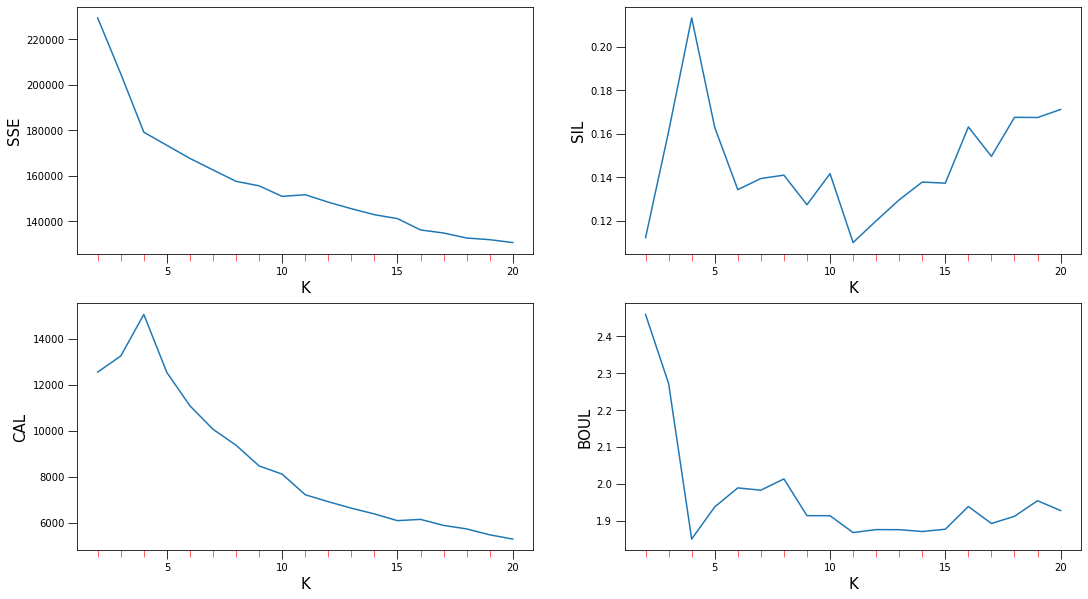

In [135]:
run_kmodes(df_all_features)

In [136]:
km = KModes(n_clusters = 4, init = 'Cao', verbose = 0, random_state = 0)
clusters = km.fit_predict(df_all_features)

n_clusters = len(np.unique(km.labels_))
        
sse = inertia(n_clusters, df_all_features, km.labels_)
       
sil = silhouette_score(df_all_features, km.labels_)
        
cal = calinski_harabasz_score(df_all_features, km.labels_)
       
boul = davies_bouldin_score(df_all_features, km.labels_)
 
print ('SSE: ', sse)
print('Cost:', km.cost_)
print ('Silhouette Score: ', sil)
print ("Calinski - Harabaz Score: ", cal)
print ("Davies - Bouldin Score: ", boul)

df_metrics_1 = pd.DataFrame({'Init': init_alg, \
                             'Dissimilarity_function': dissimilarity_function, \
                             'N_clusters': len(np.unique(km.labels_)), 'SSE': '%.4f'%(sse), \
                             'Silhouette': '%.4f'%(sil), 'Calinski': '%.4f'%(cal), \
                             'Bouldin': '%.4f'%(boul)}, index = ['Genres, years and seasons'])

SSE:  179128.70404303347
Cost: 207416.0
Silhouette Score:  0.21331791290834481
Calinski - Harabaz Score:  15061.652880743784
Davies - Bouldin Score:  1.849831194204955


In [137]:
df_generale = df_metrics_1.copy()

In [138]:
df_all_features_complete = df_tot.copy()

In [139]:
df_all_features_complete['Labels'] = km.labels_

In [140]:
cluster_insight(df_all_features_complete)

Studio_Recording Live_Recording  Tot_Cluster Entropy  Purity
Cluster 0            25546           4178        29724  0.5857  0.8594
Cluster 1            25582           2705        28287  0.4550  0.9044
Cluster 2            21537           1970        23507  0.4154  0.9162
Cluster 3            19518           2672        22190  0.5306  0.8796
Total                92183          11525       103708  0.4997  0.8889

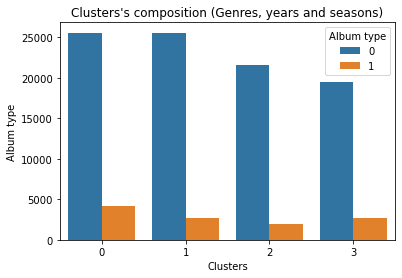

In [141]:
b = sns.countplot(x=df_all_features_complete['Labels'], data=df_all_features_complete, \
                  hue = df_all_features_complete['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.set_title("Clusters's composition (Genres, years and seasons)")
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

<h2>Feature selection (Genres and years) </h2>

In [142]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   track_genre_top_Hip-Hop              103708 non-null  int64
 1   track_genre_top_Pop                  103708 non-null  int64
 2   track_genre_top_Experimental         103708 non-null  int64
 3   track_genre_top_Folk                 103708 non-null  int64
 4   track_genre_top_Jazz                 103708 non-null  int64
 5   track_genre_top_Rock                 103708 non-null  int64
 6   track_genre_top_Electronic           103708 non-null  int64
 7   track_genre_top_Spoken               103708 non-null  int64
 8   track_genre_top_International        103708 non-null  int64
 9   track_genre_top_Soul-RnB             103708 non-null  int64
 10  track_genre_top_Blues                103708 non-null  int64
 11  track_genre_top_Classical            10

In [143]:
df_genres_years_complete = df_tot[[col for col in df_tot.columns if 'genre_top' in col or \
                            'track_date_created_year' in col or \
                            'album_type' in col]]

In [144]:
df_genres_years_complete

track_genre_top_Hip-Hop  track_genre_top_Pop  \
track_id                                                 
2                               1                    0   
3                               1                    0   
5                               1                    0   
10                              0                    1   
20                              0                    1   
...                           ...                  ...   
155316                          0                    0   
155317                          0                    0   
155318                          0                    0   
155319                          0                    0   
155320                          0                    0   

          track_genre_top_Experimental  track_genre_top_Folk  \
track_id                                                       
2                                    0                     0   
3                                    0                     0   
5                                    0                     0   
10                                   0                     0   
20                                   0                     0   
...                                ...                   ...   
155316                               0                     0   
155317                               0                     0   
155318                               0                     0   
155319                               0                     0   
155320                               0                     0   

          track_genre_top_Jazz  track_genre_top_Rock  \
track_id                                               
2                            0                     0   
3                            0                     0   
5                            0                     0   
10                           0                     0   
20                           0                     0   
...                        ...                   ...   
155316                       0                     1   
155317                       0                     1   
155318                       0                     1   
155319                       0                     1   
155320                       0                     0   

          track_genre_top_Electronic  track_genre_top_Spoken  \
track_id                                                       
2                                  0                       0   
3                                  0                       0   
5                                  0                       0   
10                                 0                       0   
20                                 0                       0   
...                              ...                     ...   
155316                             0                       0   
155317                             0                       0   
155318                             0                       0   
155319                             0                       0   
155320                             0                       0   

          track_genre_top_International  track_genre_top_Soul-RnB  ...  \
track_id                                                           ...   
2                                     0                         0  ...   
3                                     0                         0  ...   
5                                     0                         0  ...   
10                                    0                         0  ...   
20                                    0                         0  ...   
...                                 ...                       ...  ...   
155316                                0                         0  ...   
155317                                0                         0  ...   
155318                                0                         0  ...   
155319                                0       

In [145]:
df_genres_years_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 27 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   track_genre_top_Hip-Hop              103708 non-null  int64
 1   track_genre_top_Pop                  103708 non-null  int64
 2   track_genre_top_Experimental         103708 non-null  int64
 3   track_genre_top_Folk                 103708 non-null  int64
 4   track_genre_top_Jazz                 103708 non-null  int64
 5   track_genre_top_Rock                 103708 non-null  int64
 6   track_genre_top_Electronic           103708 non-null  int64
 7   track_genre_top_Spoken               103708 non-null  int64
 8   track_genre_top_International        103708 non-null  int64
 9   track_genre_top_Soul-RnB             103708 non-null  int64
 10  track_genre_top_Blues                103708 non-null  int64
 11  track_genre_top_Classical            10

In [146]:
df_genres_years = df_genres_years_complete[[col for col in df_genres_years_complete.columns \
                                            if 'album_type' not in col]]

In [147]:
df_genres_years

track_genre_top_Hip-Hop  track_genre_top_Pop  \
track_id                                                 
2                               1                    0   
3                               1                    0   
5                               1                    0   
10                              0                    1   
20                              0                    1   
...                           ...                  ...   
155316                          0                    0   
155317                          0                    0   
155318                          0                    0   
155319                          0                    0   
155320                          0                    0   

          track_genre_top_Experimental  track_genre_top_Folk  \
track_id                                                       
2                                    0                     0   
3                                    0                     0   
5                                    0                     0   
10                                   0                     0   
20                                   0                     0   
...                                ...                   ...   
155316                               0                     0   
155317                               0                     0   
155318                               0                     0   
155319                               0                     0   
155320                               0                     0   

          track_genre_top_Jazz  track_genre_top_Rock  \
track_id                                               
2                            0                     0   
3                            0                     0   
5                            0                     0   
10                           0                     0   
20                           0                     0   
...                        ...                   ...   
155316                       0                     1   
155317                       0                     1   
155318                       0                     1   
155319                       0                     1   
155320                       0                     0   

          track_genre_top_Electronic  track_genre_top_Spoken  \
track_id                                                       
2                                  0                       0   
3                                  0                       0   
5                                  0                       0   
10                                 0                       0   
20                                 0                       0   
...                              ...                     ...   
155316                             0                       0   
155317                             0                       0   
155318                             0                       0   
155319                             0                       0   
155320                             0                       0   

          track_genre_top_International  track_genre_top_Soul-RnB  ...  \
track_id                                                           ...   
2                                     0                         0  ...   
3                                     0                         0  ...   
5                                     0                         0  ...   
10                                    0                         0  ...   
20                                    0                         0  ...   
...                                 ...                       ...  ...   
155316                                0                         0  ...   
155317                                0                         0  ...   
155318                                0                         0  ...   
155319                                0       

In [148]:
df_genres_years = df_genres_years.values

k:  2
SSE:  158598.59552232453
Cost: 184186.0
Silhouette Score:  0.12615436052747
Calinski - Harabaz Score:  13850.222517899136
Davies - Bouldin Score:  2.072551778718661

---------------------------------

k:  3
SSE:  141654.8562396622
Cost: 166089.0
Silhouette Score:  0.1812960271652172
Calinski - Harabaz Score:  13955.59335201881
Davies - Bouldin Score:  2.032150698209989

---------------------------------

k:  4
SSE:  133714.68898227718
Cost: 158153.0
Silhouette Score:  0.18660939255735637
Calinski - Harabaz Score:  11908.799142011017
Davies - Bouldin Score:  2.02601207541535

---------------------------------

k:  5
SSE:  126042.18948997345
Cost: 150354.0
Silhouette Score:  0.19958770522390876
Calinski - Harabaz Score:  11053.360966857525
Davies - Bouldin Score:  2.004694759172912

---------------------------------

k:  6
SSE:  119025.33875791916
Cost: 143294.0
Silhouette Score:  0.21629246071165362
Calinski - Harabaz Score:  10586.597866671582
Davies - Bouldin Score:  1.976862315

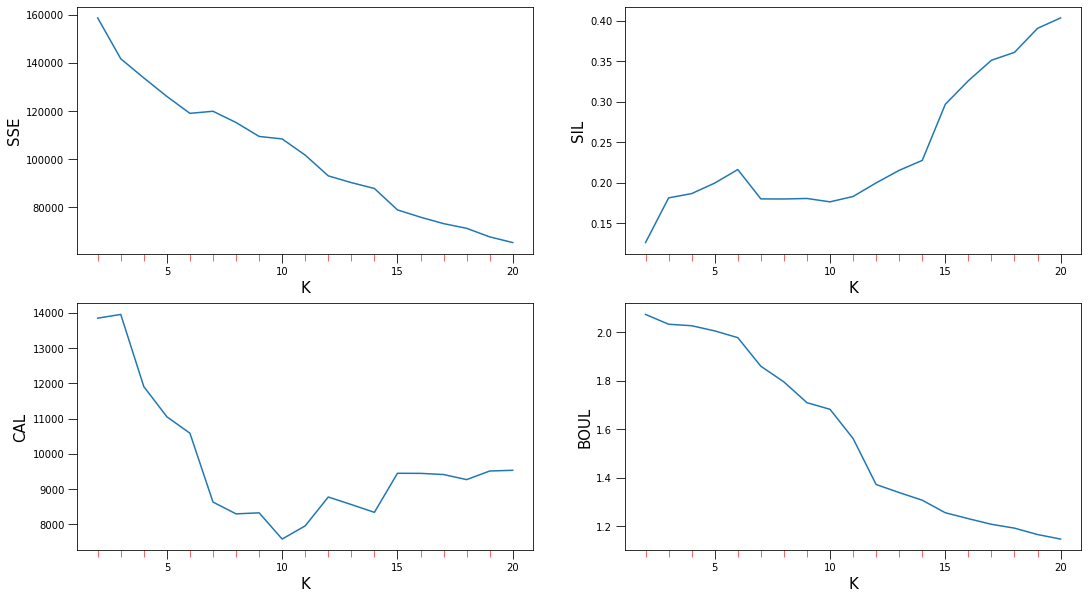

In [149]:
run_kmodes(df_genres_years)

In [150]:
km = KModes(n_clusters = 6, init = 'Cao', verbose = 0, random_state = 0)
clusters = km.fit_predict(df_genres_years)

n_clusters = len(np.unique(km.labels_))
        
sse = inertia(n_clusters, df_genres_years, km.labels_)
       
sil = silhouette_score(df_genres_years, km.labels_)
        
cal = calinski_harabasz_score(df_genres_years, km.labels_)
       
boul = davies_bouldin_score(df_genres_years, km.labels_)
 
print ('SSE: ', sse)
print('Cost:', km.cost_)
print ('Silhouette Score: ', sil)
print ("Calinski - Harabaz Score: ", cal)
print ("Davies - Bouldin Score: ", boul)

df_metrics_2 = pd.DataFrame({'Init': init_alg, \
                             'Dissimilarity_function': dissimilarity_function, \
                             'N_clusters': len(np.unique(km.labels_)), 'SSE': '%.4f'%(sse), \
                             'Silhouette': '%.4f'%(sil), 'Calinski': '%.4f'%(cal), \
                             'Bouldin': '%.4f'%(boul)}, index = ['Genres and years'])

SSE:  119025.33875791916
Cost: 143294.0
Silhouette Score:  0.21629246071165362
Calinski - Harabaz Score:  10586.597866671582
Davies - Bouldin Score:  1.9768623155638076


In [151]:
df_generale = concatenate(df_generale, df_metrics_2)

In [152]:
df_genres_years_complete_labels = df_genres_years_complete.copy()

In [153]:
df_genres_years_complete_labels['Labels'] = km.labels_

In [154]:
cluster_insight(df_genres_years_complete_labels)

Studio_Recording Live_Recording  Tot_Cluster Entropy  Purity
Cluster 0            32868           6718        39586  0.6570  0.8303
Cluster 1            21989           1241        23230  0.3008  0.9466
Cluster 2            17749            348        18097  0.1371  0.9808
Cluster 3             7439            497         7936  0.3378  0.9374
Cluster 4             6552           1247         7799  0.6341  0.8401
Cluster 5             5586           1474         7060  0.7391  0.7912
Total                92183          11525       103708  0.4659  0.8889

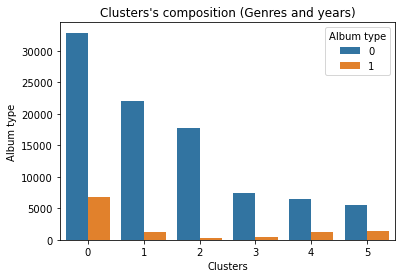

In [155]:
b = sns.countplot(x=df_genres_years_complete_labels['Labels'], data=df_genres_years_complete_labels, \
                  hue = df_genres_years_complete_labels['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.set_title("Clusters's composition (Genres and years)")
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

<h2>Feature selection (Genres and seasons)</h2>

In [13]:
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 31 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   track_genre_top_Hip-Hop              103708 non-null  int64
 1   track_genre_top_Pop                  103708 non-null  int64
 2   track_genre_top_Experimental         103708 non-null  int64
 3   track_genre_top_Folk                 103708 non-null  int64
 4   track_genre_top_Jazz                 103708 non-null  int64
 5   track_genre_top_Rock                 103708 non-null  int64
 6   track_genre_top_Electronic           103708 non-null  int64
 7   track_genre_top_Spoken               103708 non-null  int64
 8   track_genre_top_International        103708 non-null  int64
 9   track_genre_top_Soul-RnB             103708 non-null  int64
 10  track_genre_top_Blues                103708 non-null  int64
 11  track_genre_top_Classical            10

In [14]:
df_genres_seasons_complete = df_tot[[col for col in df_tot.columns if 'genre_top' in col or \
                            'track_date_created_season' in col or \
                            'album_type' in col]]

In [15]:
df_genres_seasons_complete

track_genre_top_Hip-Hop  track_genre_top_Pop  \
track_id                                                 
2                               1                    0   
3                               1                    0   
5                               1                    0   
10                              0                    1   
20                              0                    1   
...                           ...                  ...   
155316                          0                    0   
155317                          0                    0   
155318                          0                    0   
155319                          0                    0   
155320                          0                    0   

          track_genre_top_Experimental  track_genre_top_Folk  \
track_id                                                       
2                                    0                     0   
3                                    0                     0   
5                                    0                     0   
10                                   0                     0   
20                                   0                     0   
...                                ...                   ...   
155316                               0                     0   
155317                               0                     0   
155318                               0                     0   
155319                               0                     0   
155320                               0                     0   

          track_genre_top_Jazz  track_genre_top_Rock  \
track_id                                               
2                            0                     0   
3                            0                     0   
5                            0                     0   
10                           0                     0   
20                           0                     0   
...                        ...                   ...   
155316                       0                     1   
155317                       0                     1   
155318                       0                     1   
155319                       0                     1   
155320                       0                     0   

          track_genre_top_Electronic  track_genre_top_Spoken  \
track_id                                                       
2                                  0                       0   
3                                  0                       0   
5                                  0                       0   
10                                 0                       0   
20                                 0                       0   
...                              ...                     ...   
155316                             0                       0   
155317                             0                       0   
155318                             0                       0   
155319                             0                       0   
155320                             0                       0   

          track_genre_top_International  track_genre_top_Soul-RnB  ...  \
track_id                                                           ...   
2                                     0                         0  ...   
3                                     0                         0  ...   
5                                     0                         0  ...   
10                                    0                         0  ...   
20                                    0                         0  ...   
...                                 ...                       ...  ...   
155316                                0                         0  ...   
155317                                0                         0  ...   
155318                                0                         0  ...   
155319                                0       

In [16]:
df_genres_seasons = df_genres_seasons_complete[[col for col in df_genres_seasons_complete.columns if \
                                                'album_type' not in col]]

In [17]:
df_genres_seasons

track_genre_top_Hip-Hop  track_genre_top_Pop  \
track_id                                                 
2                               1                    0   
3                               1                    0   
5                               1                    0   
10                              0                    1   
20                              0                    1   
...                           ...                  ...   
155316                          0                    0   
155317                          0                    0   
155318                          0                    0   
155319                          0                    0   
155320                          0                    0   

          track_genre_top_Experimental  track_genre_top_Folk  \
track_id                                                       
2                                    0                     0   
3                                    0                     0   
5                                    0                     0   
10                                   0                     0   
20                                   0                     0   
...                                ...                   ...   
155316                               0                     0   
155317                               0                     0   
155318                               0                     0   
155319                               0                     0   
155320                               0                     0   

          track_genre_top_Jazz  track_genre_top_Rock  \
track_id                                               
2                            0                     0   
3                            0                     0   
5                            0                     0   
10                           0                     0   
20                           0                     0   
...                        ...                   ...   
155316                       0                     1   
155317                       0                     1   
155318                       0                     1   
155319                       0                     1   
155320                       0                     0   

          track_genre_top_Electronic  track_genre_top_Spoken  \
track_id                                                       
2                                  0                       0   
3                                  0                       0   
5                                  0                       0   
10                                 0                       0   
20                                 0                       0   
...                              ...                     ...   
155316                             0                       0   
155317                             0                       0   
155318                             0                       0   
155319                             0                       0   
155320                             0                       0   

          track_genre_top_International  track_genre_top_Soul-RnB  \
track_id                                                            
2                                     0                         0   
3                                     0                         0   
5                                     0                         0   
10                                    0                         0   
20                                    0                         0   
...                                 ...                       ...   
155316                                0                         0   
155317                                0                         0   
155318                                0                         0   
155319                                0                         0   
155320                          

In [18]:
df_genres_seasons = df_genres_seasons.values

k:  2
SSE:  154757.2859193474
Cost: 193670.0
Silhouette Score:  0.07633339428768524
Calinski - Harabaz Score:  6974.27592160237
Davies - Bouldin Score:  0.9911579855385034

---------------------------------

k:  3
SSE:  113108.30402000852
Cost: 148088.0
Silhouette Score:  0.28209795539039334
Calinski - Harabaz Score:  23864.37193991321
Davies - Bouldin Score:  1.6801687800251193

---------------------------------

k:  4
SSE:  87681.9049943381
Cost: 103708.0
Silhouette Score:  0.3731792300717332
Calinski - Harabaz Score:  30547.10281765804
Davies - Bouldin Score:  1.2947865336578488

---------------------------------

k:  5
SSE:  81937.65701923441
Cost: 97519.0
Silhouette Score:  0.3321570930900046
Calinski - Harabaz Score:  26333.74897511245
Davies - Bouldin Score:  1.1963687697057266

---------------------------------

k:  6
SSE:  76232.39876221748
Cost: 91304.0
Silhouette Score:  0.3224725631262208
Calinski - Harabaz Score:  24195.66058683807
Davies - Bouldin Score:  1.12969089034725

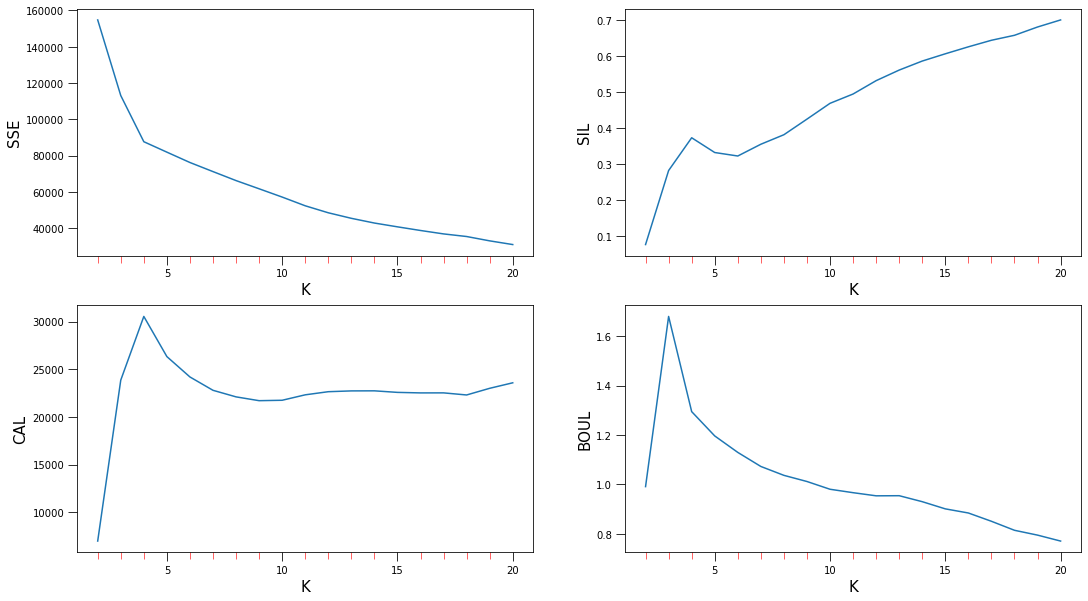

In [19]:
run_kmodes(df_genres_seasons)

In [20]:
km = KModes(n_clusters = 4, init = 'Cao', verbose = 0, random_state = 0)
clusters = km.fit_predict(df_genres_seasons)

n_clusters = len(np.unique(km.labels_))
        
sse = inertia(n_clusters, df_genres_seasons, km.labels_)
       
sil = silhouette_score(df_genres_seasons, km.labels_)
        
cal = calinski_harabasz_score(df_genres_seasons, km.labels_)
       
boul = davies_bouldin_score(df_genres_seasons, km.labels_)
 
print ('SSE: ', sse)
print('Cost:', km.cost_)
print ('Silhouette Score: ', sil)
print ("Calinski - Harabaz Score: ", cal)
print ("Davies - Bouldin Score: ", boul)

df_metrics_3 = pd.DataFrame({'Init': init_alg, \
                             'Dissimilarity_function': dissimilarity_function, \
                             'N_clusters': len(np.unique(km.labels_)), 'SSE': '%.4f'%(sse), \
                             'Silhouette': '%.4f'%(sil), 'Calinski': '%.4f'%(cal), \
                             'Bouldin': '%.4f'%(boul)}, index = ['Genres and seasons'])

SSE:  87681.9049943381
Cost: 103708.0
Silhouette Score:  0.3731792300717332
Calinski - Harabaz Score:  30547.10281765804
Davies - Bouldin Score:  1.2947865336578488


In [22]:
df_metrics_3

Init Dissimilarity_function  N_clusters         SSE  \
Genres and seasons  Cao        matching_dissim           4  87681.9050   

                   Silhouette    Calinski Bouldin  
Genres and seasons     0.3732  30547.1028  1.2948

In [23]:
df_genres_seasons_complete_labels = df_genres_seasons_complete.copy()

In [24]:
df_genres_seasons_complete_labels['Labels'] = km.labels_

In [25]:
cluster_insight(df_genres_seasons_complete_labels)

Studio_Recording Live_Recording  Tot_Cluster Entropy  Purity
Cluster 0            25546           4178        29724  0.5857  0.8594
Cluster 1            25582           2705        28287  0.4550  0.9044
Cluster 2            21537           1970        23507  0.4154  0.9162
Cluster 3            19518           2672        22190  0.5306  0.8796
Total                92183          11525       103708  0.4997  0.8889

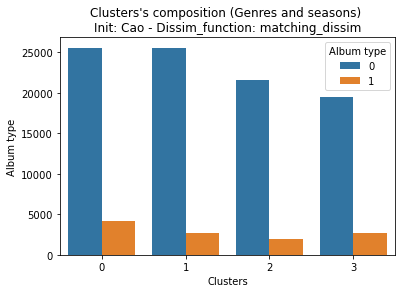

In [26]:
b = sns.countplot(x=df_genres_seasons_complete_labels['Labels'], data=df_genres_seasons_complete_labels, \
                  hue = df_genres_seasons_complete_labels['album_type'])
b.set_xlabel("Clusters")
b.set_ylabel("Album type")
b.set_title("Clusters's composition (Genres and seasons) \nInit: {} - Dissim_function: {}".format(init_alg, dissimilarity_function))
b.tick_params()
b.legend_.set_title('Album type')
b.grid(False)

In [27]:
df_prova = df_genres_seasons_complete_labels[df_genres_seasons_complete_labels['album_type'] == 1]

In [28]:
sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

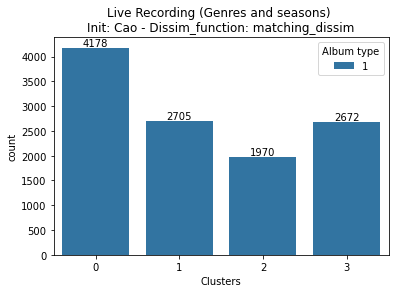

In [29]:
g = sns.countplot(x=df_prova['Labels'], data=df_prova, \
                  hue = df_prova['album_type'])
g.set_xlabel("Clusters")
g.set_title("Live Recording (Genres and seasons) \nInit: {} - Dissim_function: {}".format(init_alg, dissimilarity_function))
g.tick_params()
g.legend_.set_title('Album type')
g.grid(False)

for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center', \
                   xytext = (0, 5), \
                   textcoords = 'offset points')

In [ ]:
ipd.display(df_generale)

**We can see that the best clustering is that composed by Genres and Seasons, that has the best Silhouette value and the lower SSE value, so we analize these clusters.**

In [173]:
df_genres_seasons_complete_labels

track_genre_top_Hip-Hop  track_genre_top_Pop  \
track_id                                                 
2                               1                    0   
3                               1                    0   
5                               1                    0   
10                              0                    1   
20                              0                    1   
...                           ...                  ...   
155316                          0                    0   
155317                          0                    0   
155318                          0                    0   
155319                          0                    0   
155320                          0                    0   

          track_genre_top_Experimental  track_genre_top_Folk  \
track_id                                                       
2                                    0                     0   
3                                    0                     0   
5                                    0                     0   
10                                   0                     0   
20                                   0                     0   
...                                ...                   ...   
155316                               0                     0   
155317                               0                     0   
155318                               0                     0   
155319                               0                     0   
155320                               0                     0   

          track_genre_top_Jazz  track_genre_top_Rock  \
track_id                                               
2                            0                     0   
3                            0                     0   
5                            0                     0   
10                           0                     0   
20                           0                     0   
...                        ...                   ...   
155316                       0                     1   
155317                       0                     1   
155318                       0                     1   
155319                       0                     1   
155320                       0                     0   

          track_genre_top_Electronic  track_genre_top_Spoken  \
track_id                                                       
2                                  0                       0   
3                                  0                       0   
5                                  0                       0   
10                                 0                       0   
20                                 0                       0   
...                              ...                     ...   
155316                             0                       0   
155317                             0                       0   
155318                             0                       0   
155319                             0                       0   
155320                             0                       0   

          track_genre_top_International  track_genre_top_Soul-RnB  ...  \
track_id                                                           ...   
2                                     0                         0  ...   
3                                     0                         0  ...   
5                                     0                         0  ...   
10                                    0                         0  ...   
20                                    0                         0  ...   
...                                 ...                       ...  ...   
155316                                0                         0  ...   
155317                                0                         0  ...   
155318                                0                         0  ...   
155319                                0       

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


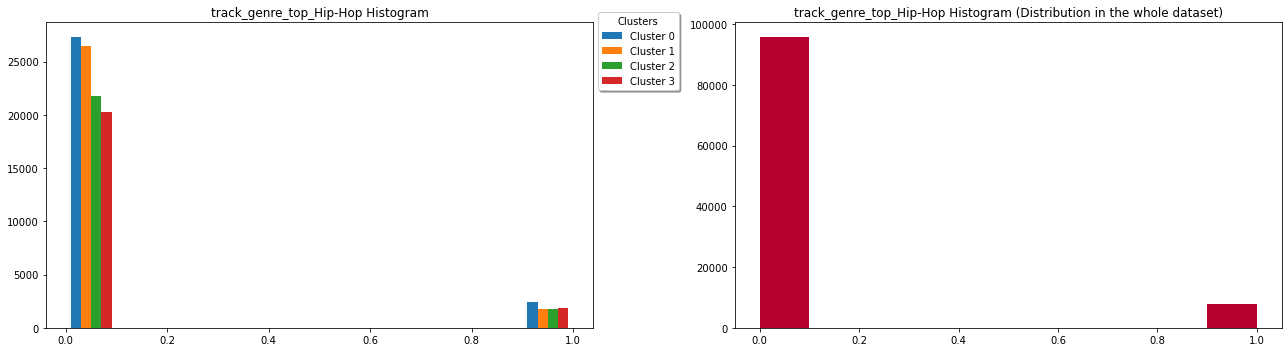

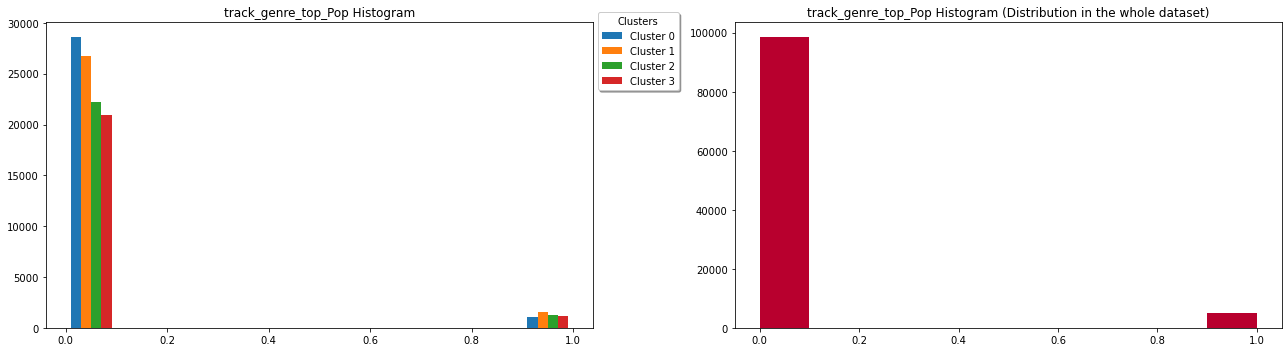

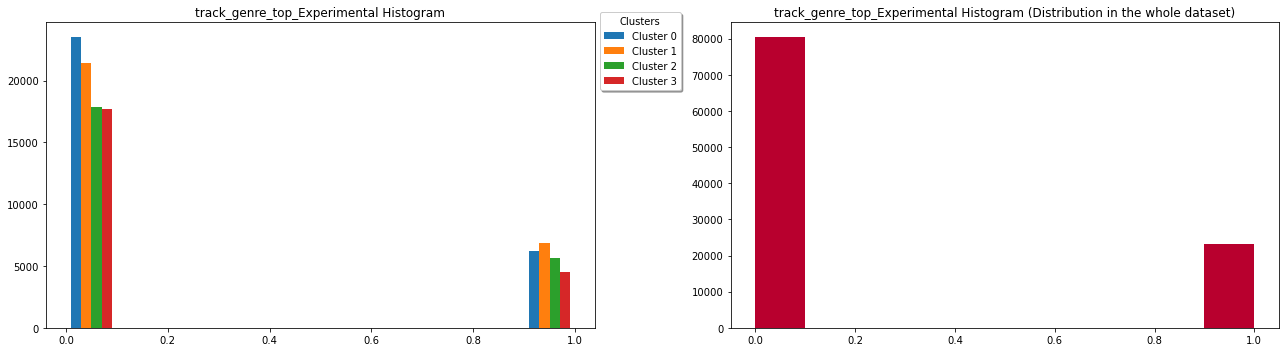

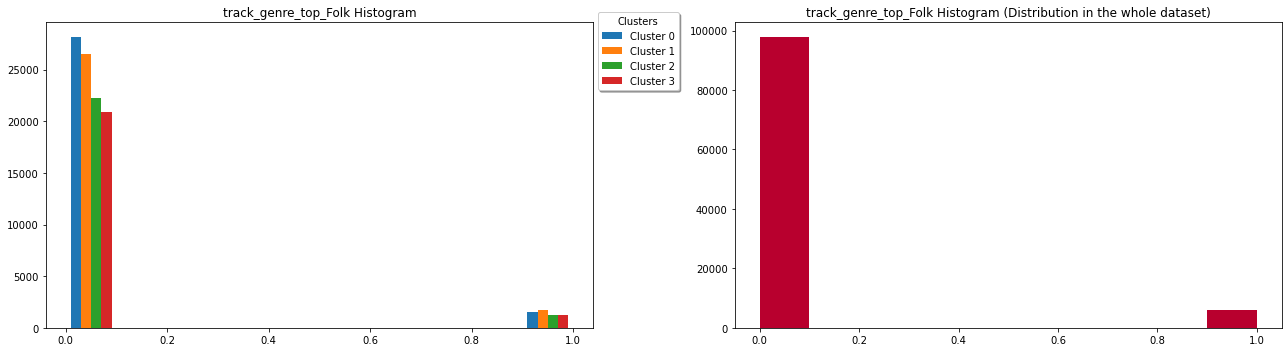

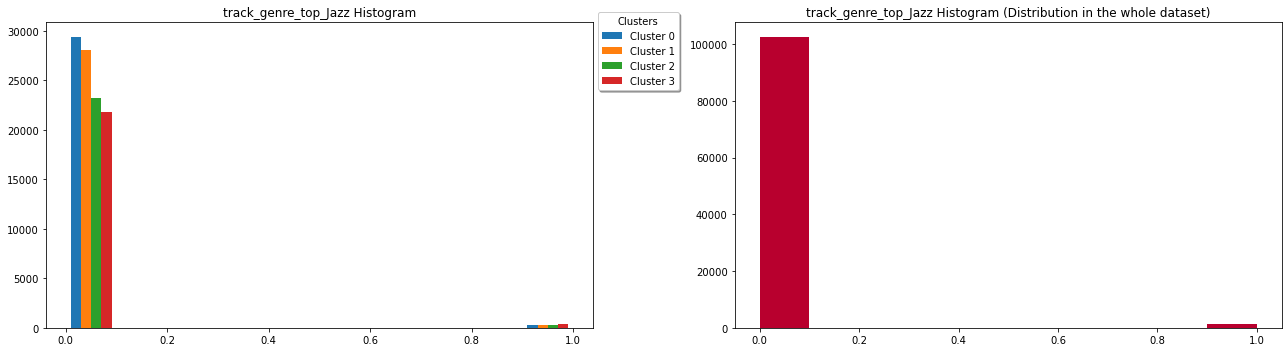

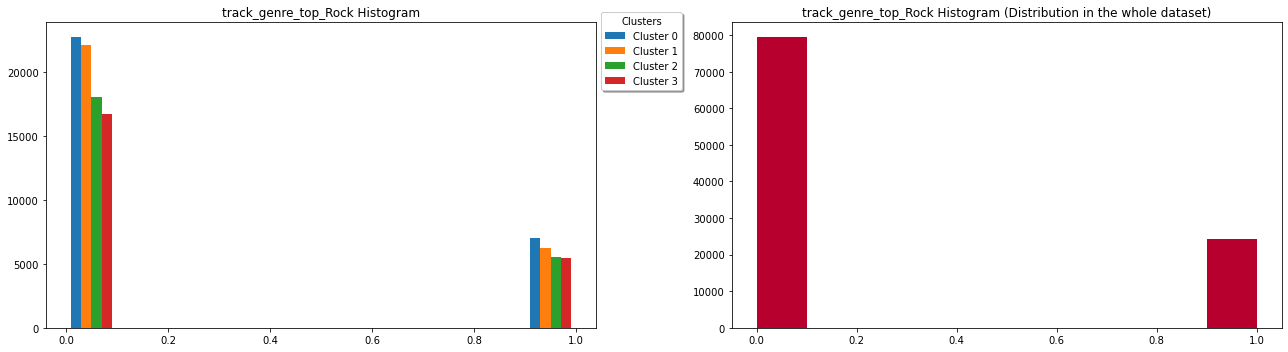

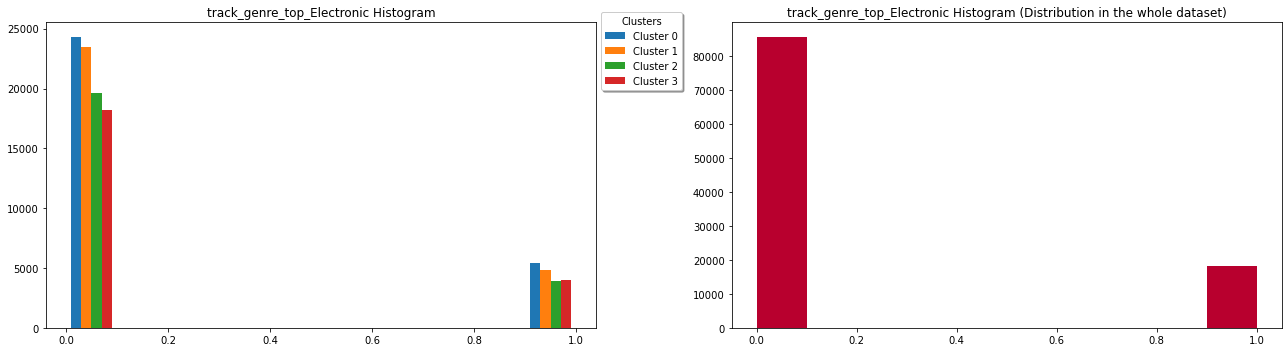

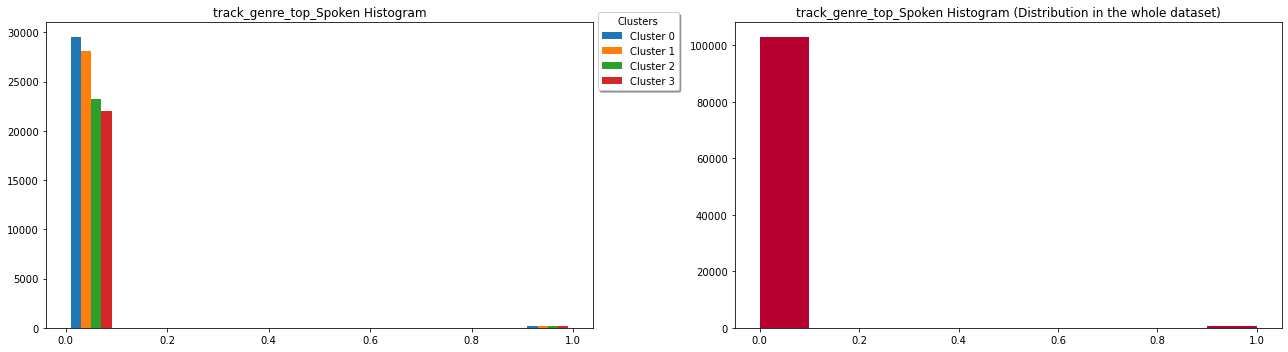

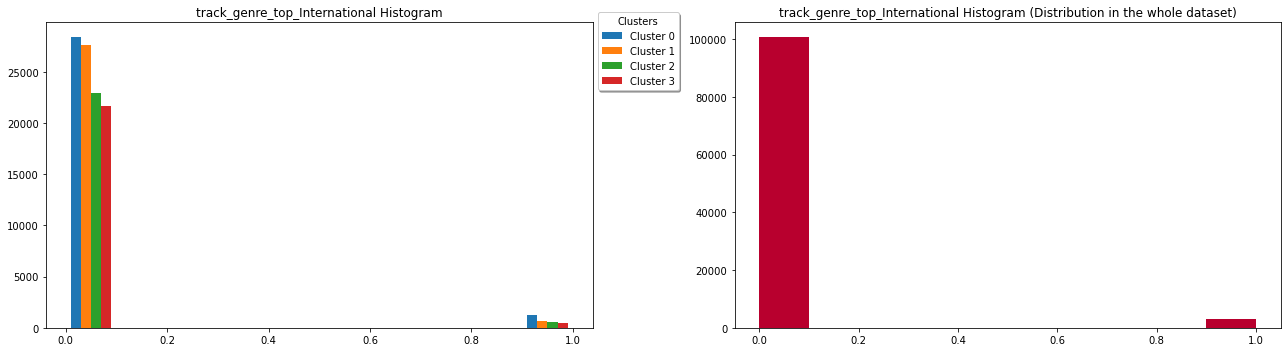

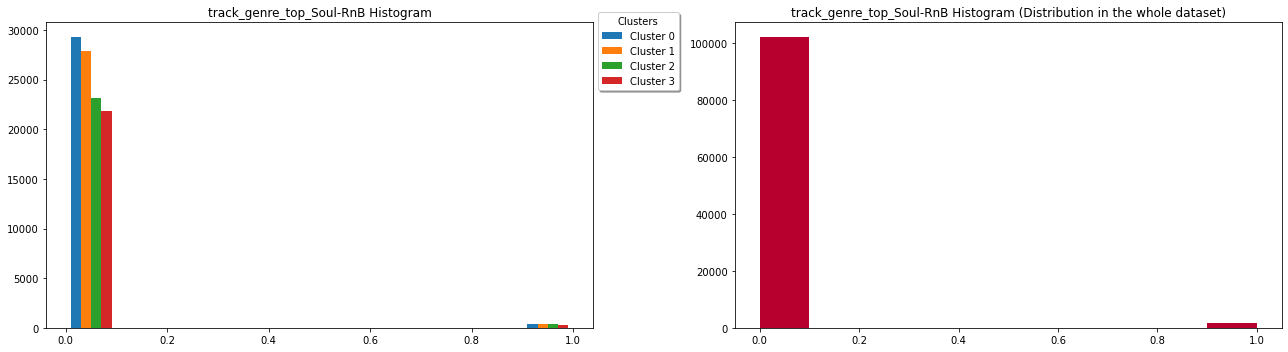

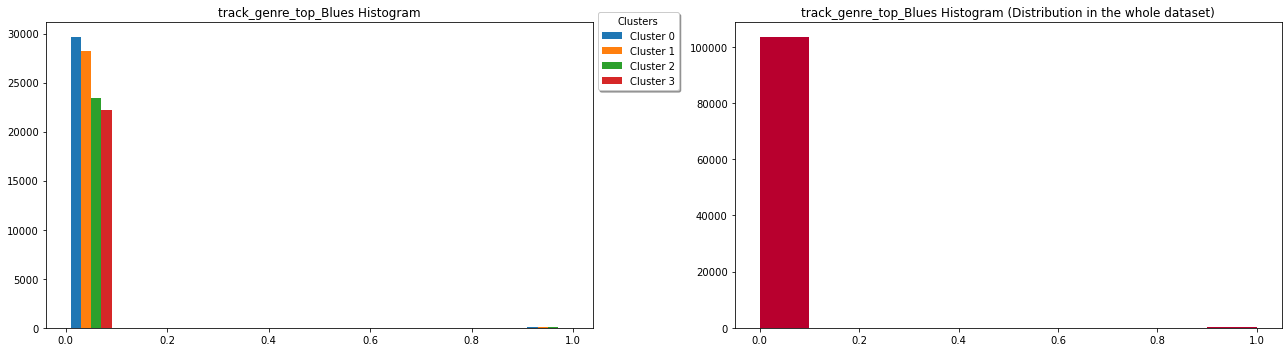

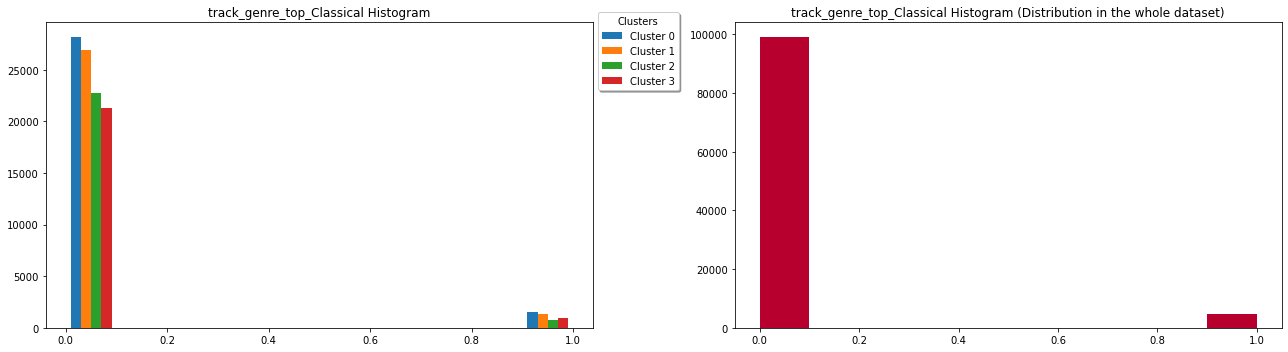

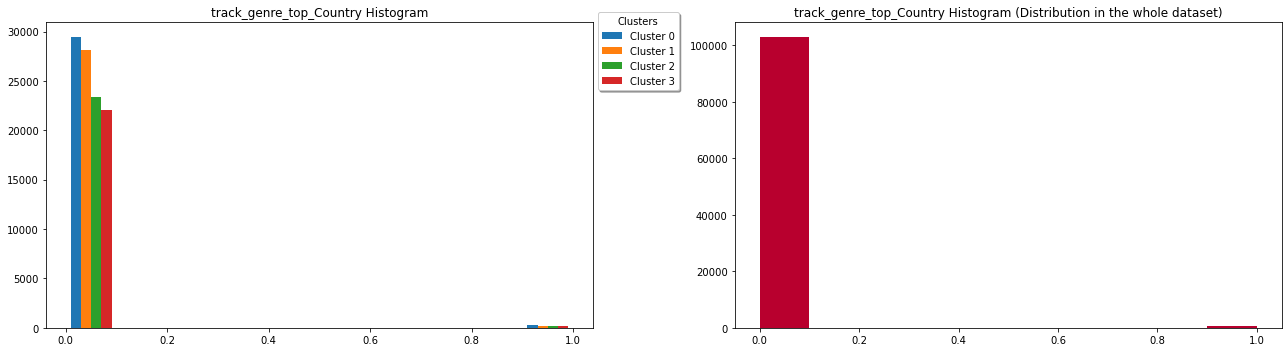

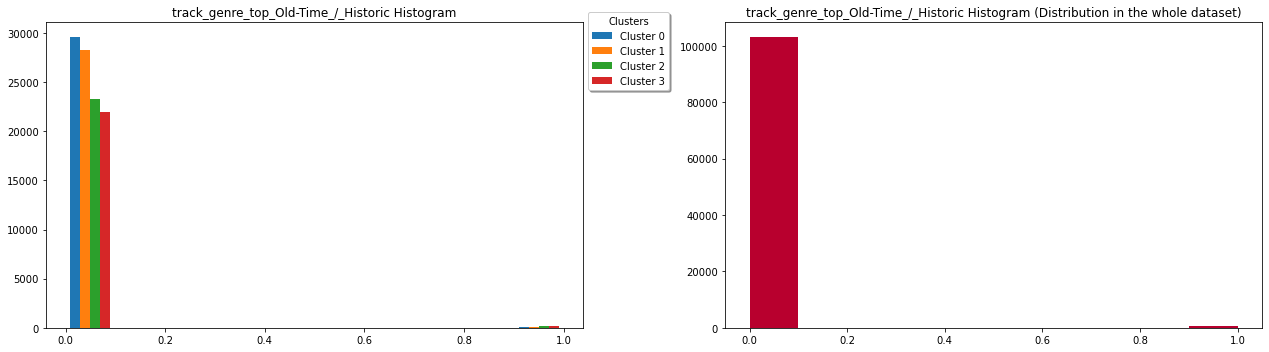

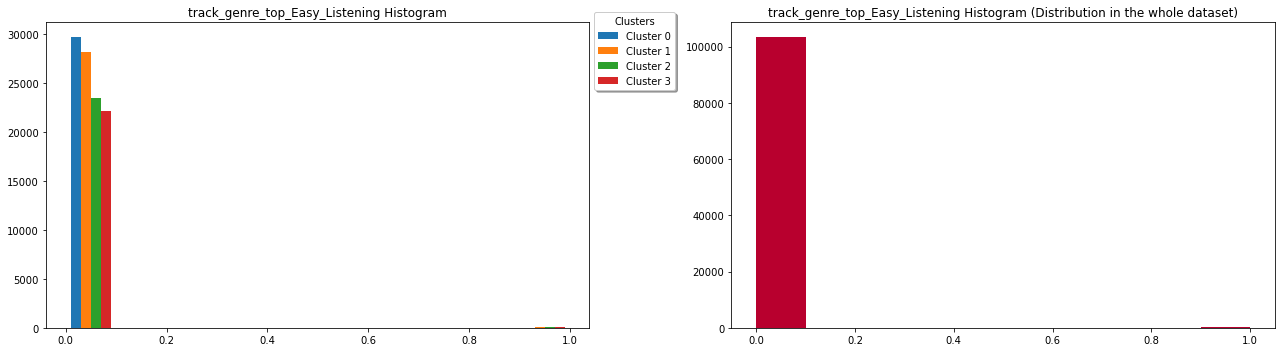

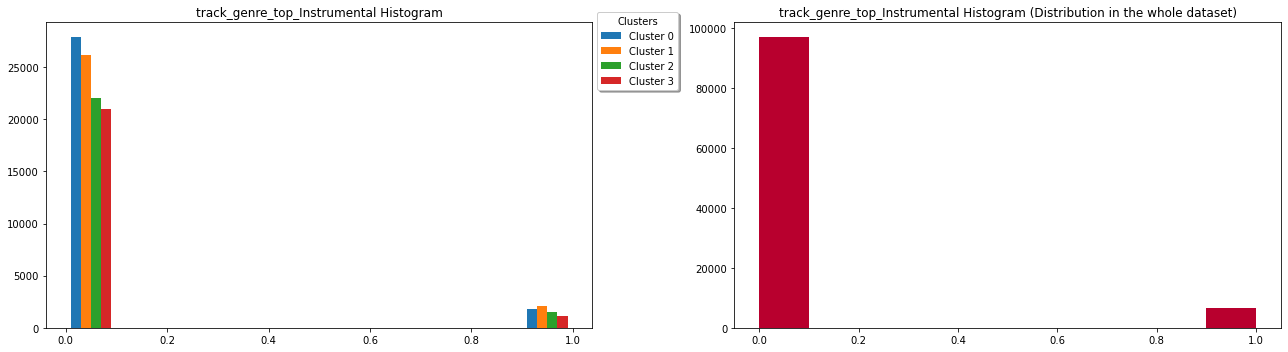

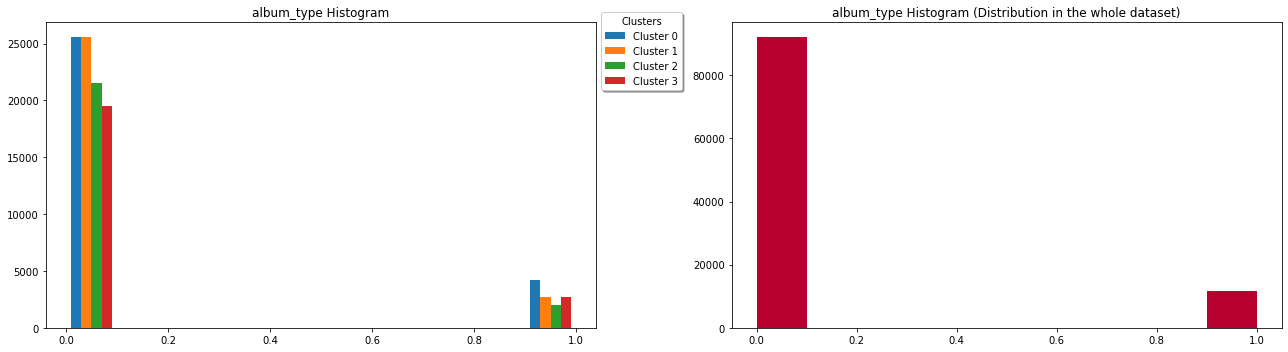

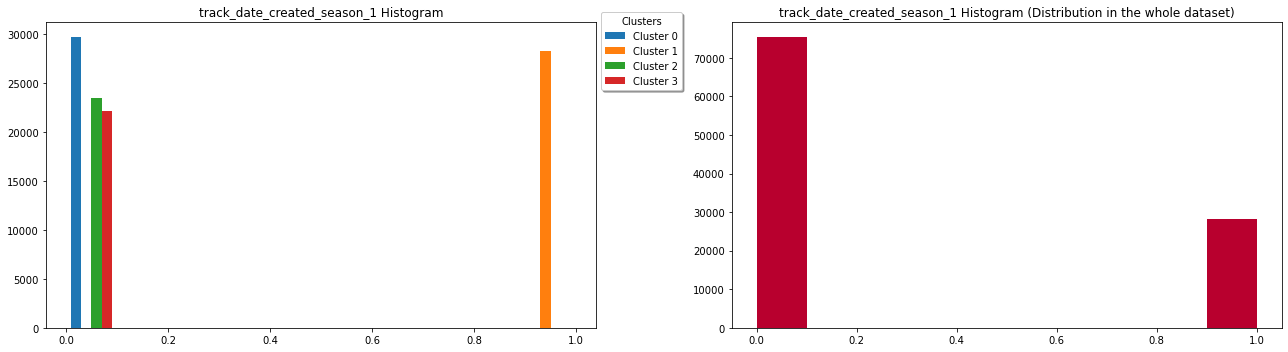

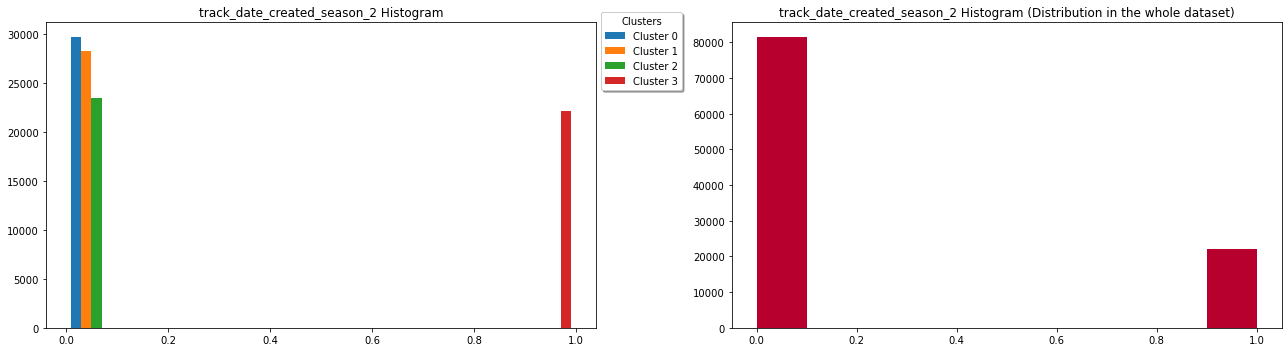

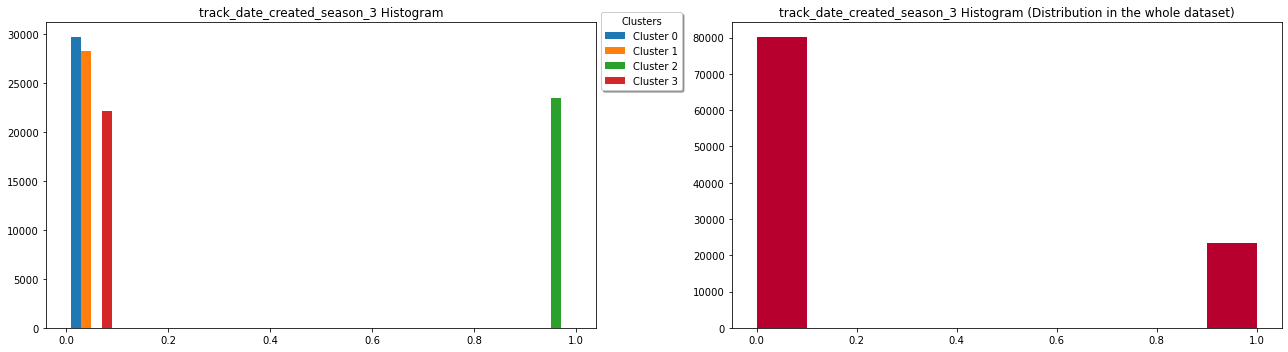

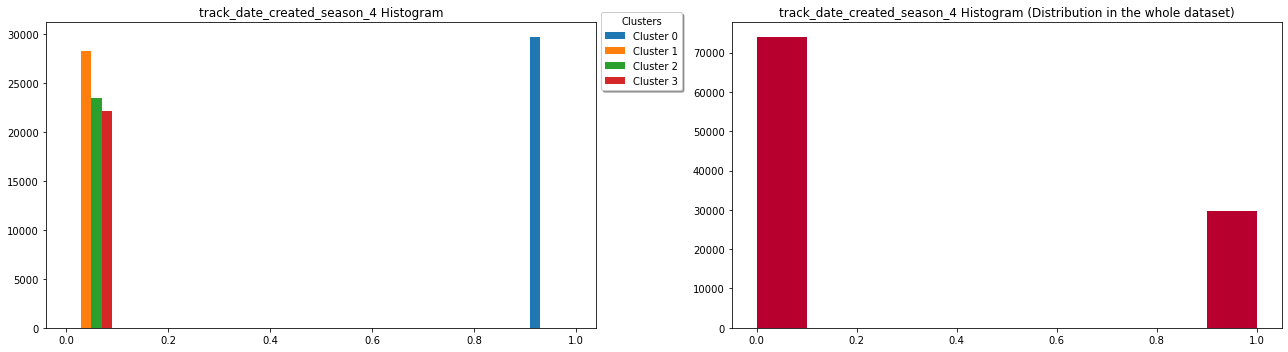

In [30]:
plot_general_distributions(df_genres_seasons_complete_labels)

In [76]:
def plot_seasons(df):
    
    for column in df.columns:

        if 'season' not in column and 'Labels' not in column:

            fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 5))
            #cluster_list = []
            #list_num_cluster = []
            '''
            for num_cluster in np.unique(df['Labels']):
                cluster_list.append(df[df['Labels'] == num_cluster][column])  #distribution
                list_num_cluster.append('Cluster %s' % num_cluster)           #num cluster
            '''
            
            ax[0].hist(df[(df['track_date_created_season_1'] == 1) & (df[column] == 1)][column])
            ax[0].legend(['Season_1 (Primavera)'])
            ax[0].set_title(column + " Histogram")
            

            ax[1].hist(df[(df['track_date_created_season_2'] == 1) & (df[column] == 1)][column])
            ax[1].legend(['Season_2 (Estate)'])
            ax[1].set_title(column + " Histogram")
            
            ax[2].hist(df[(df['track_date_created_season_3'] == 1) & (df[column] == 1)][column])
            ax[2].legend(['Season_3 (Autunno)'])
            ax[2].set_title(column + " Histogram")
            
            ax[3].hist(df[(df['track_date_created_season_4'] == 1) & (df[column] == 1)][column])
            ax[3].legend(['Season_4 (Inverno)'])
            ax[3].set_title(column + " Histogram")

            fig.tight_layout()
            plt.show()

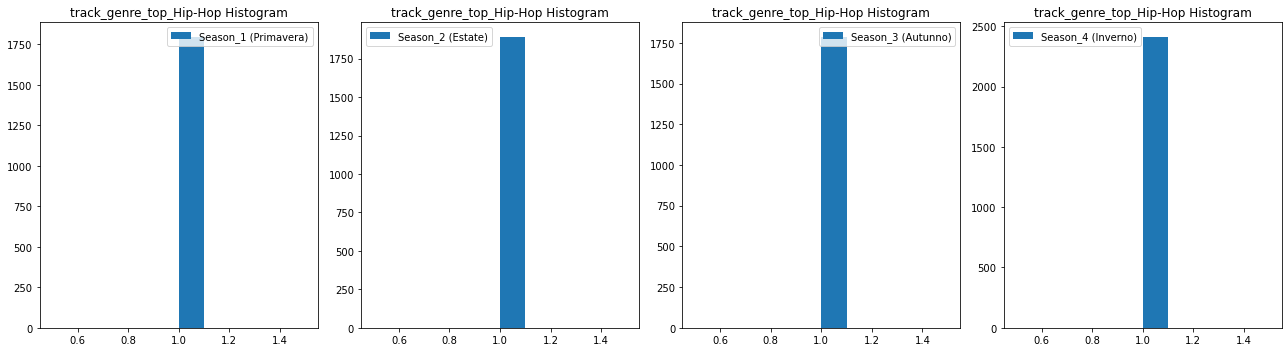

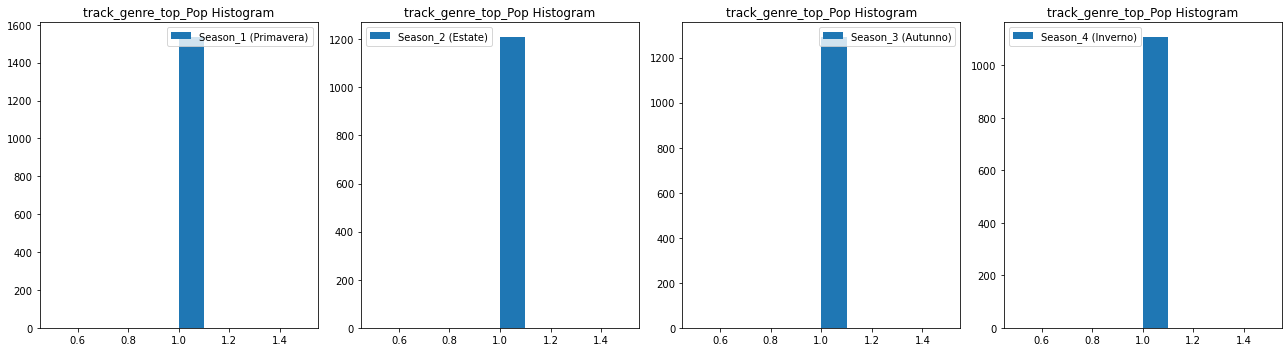

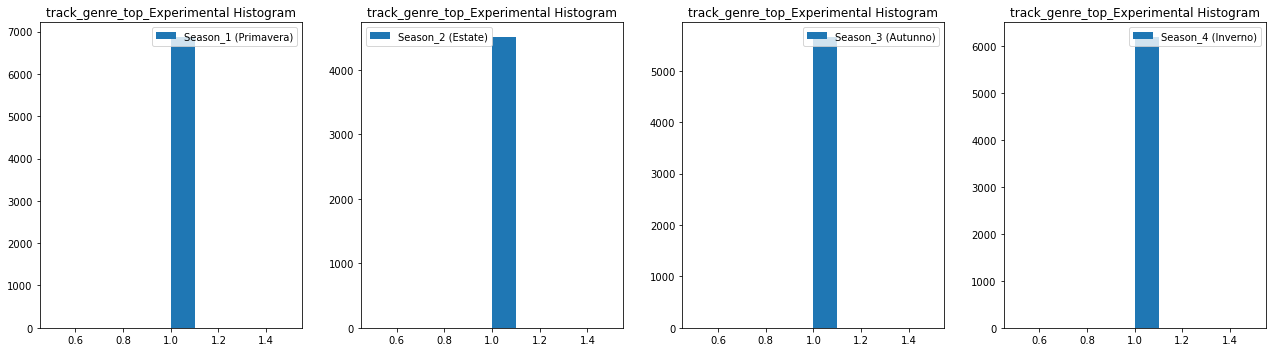

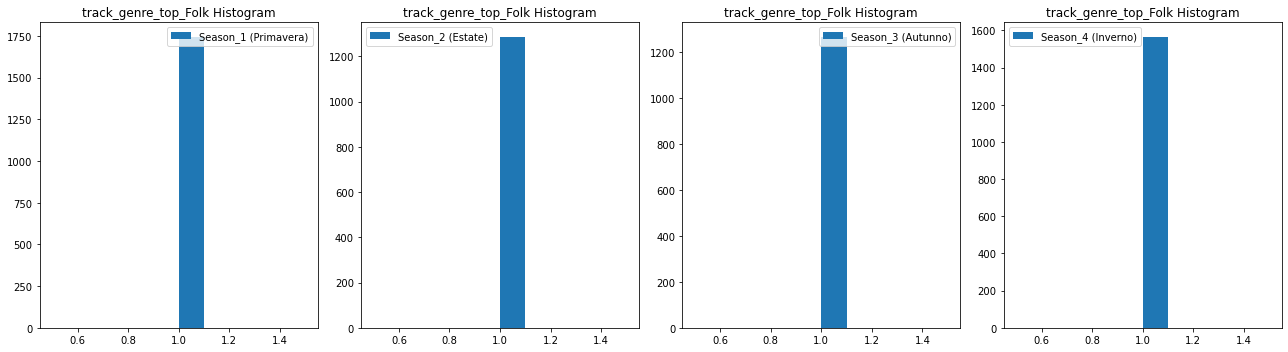

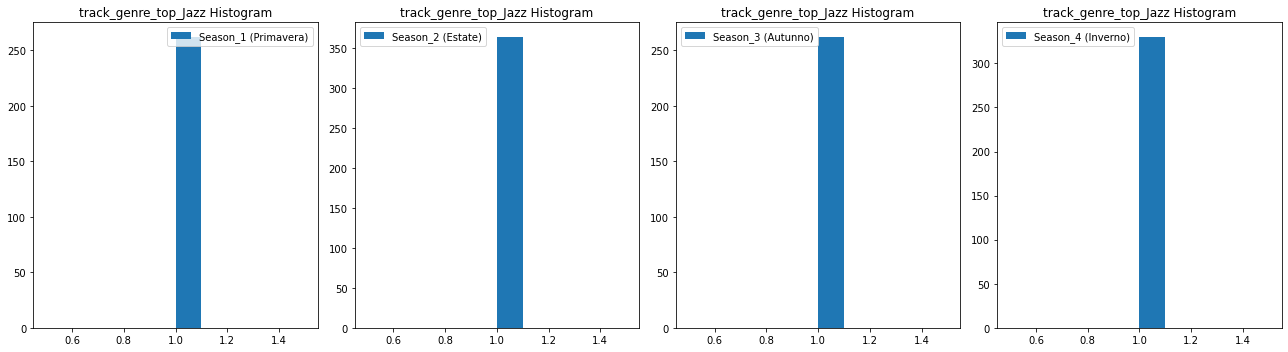

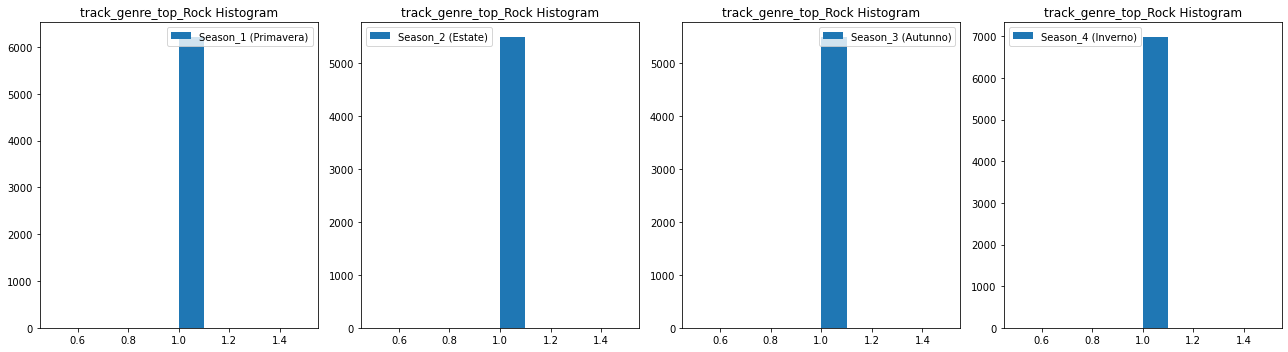

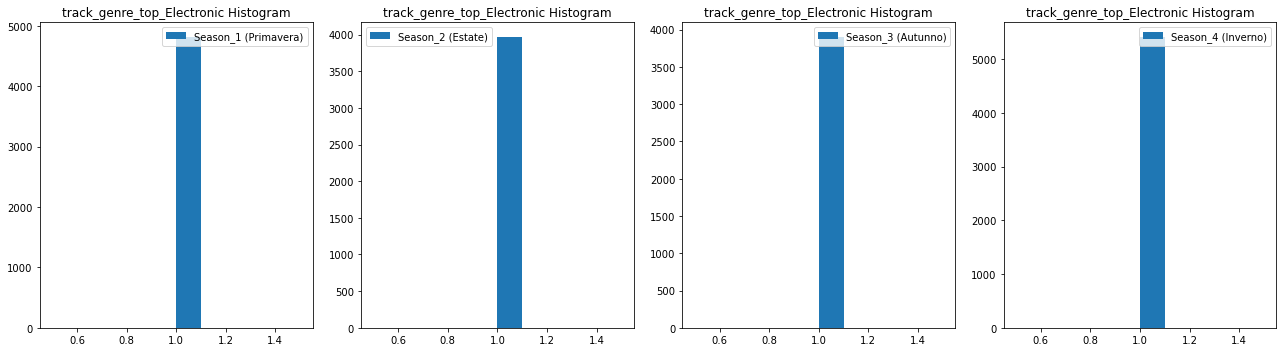

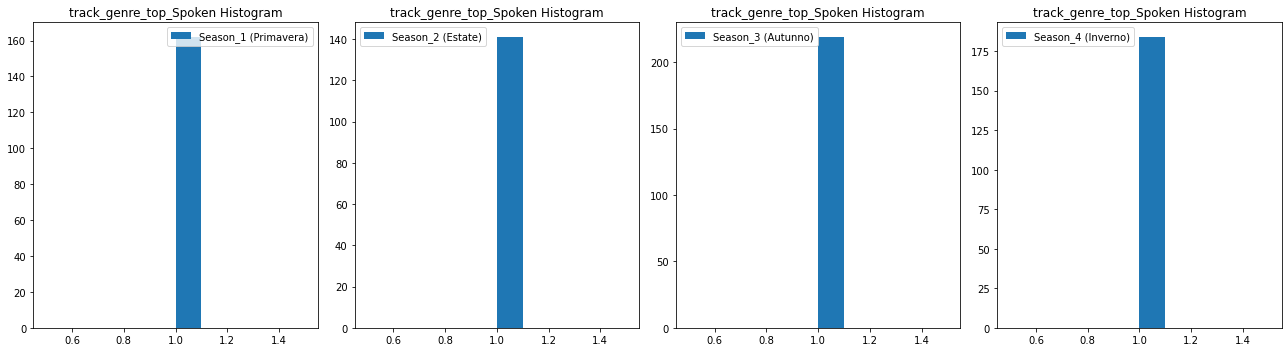

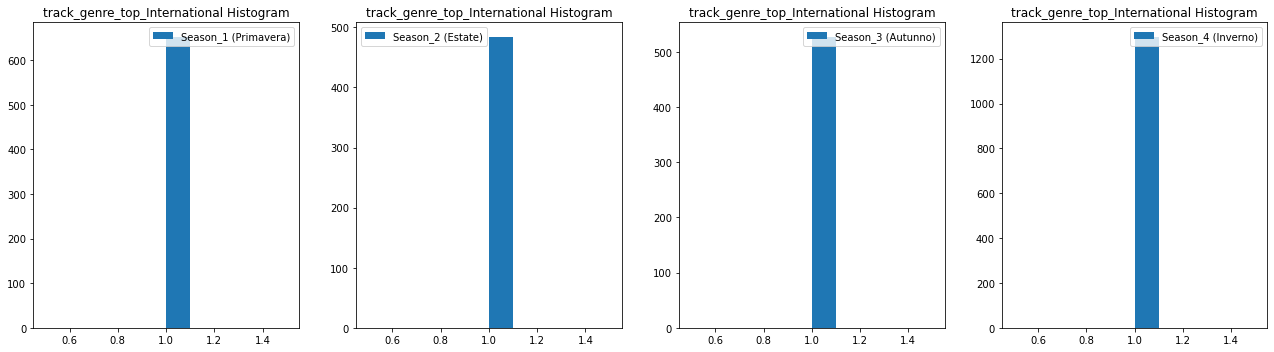

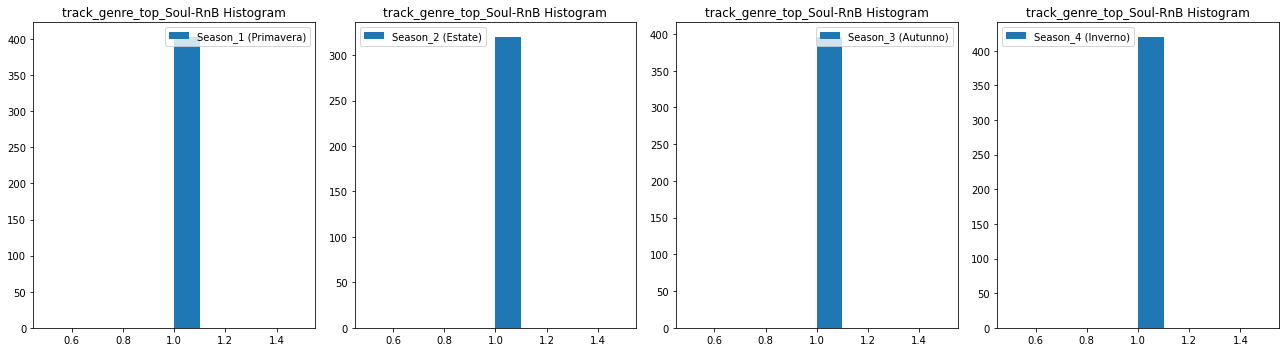

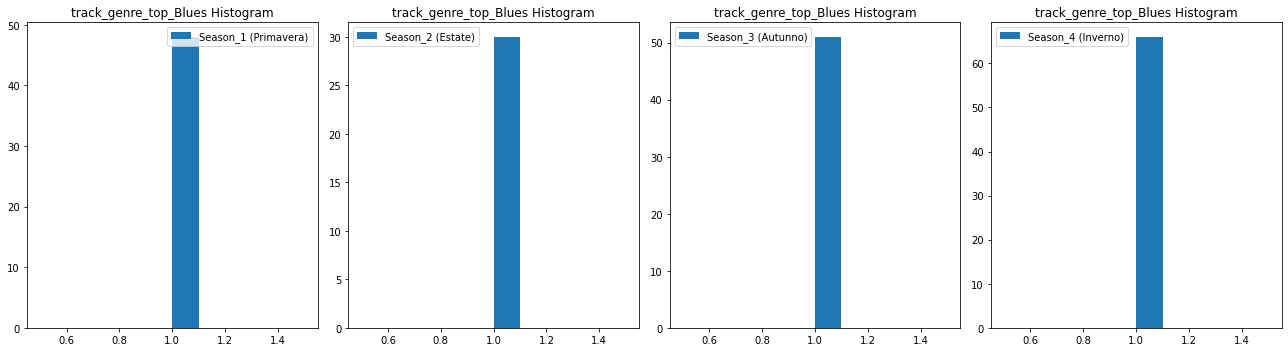

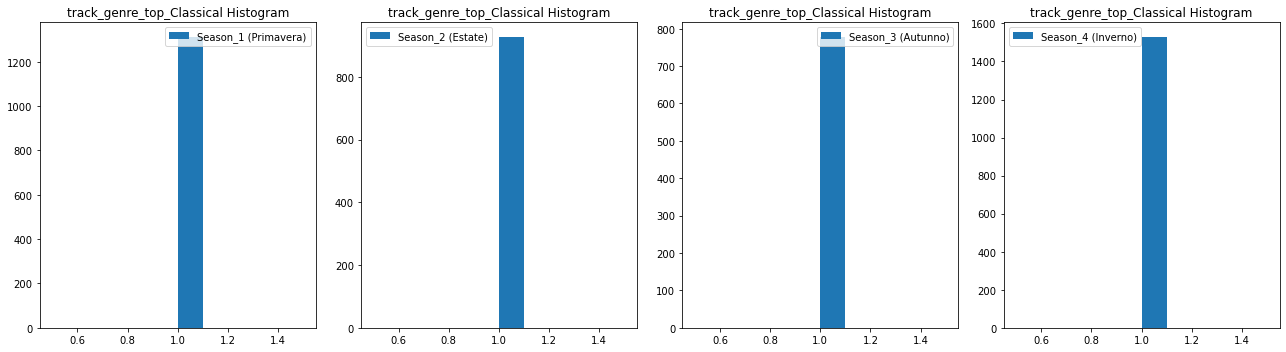

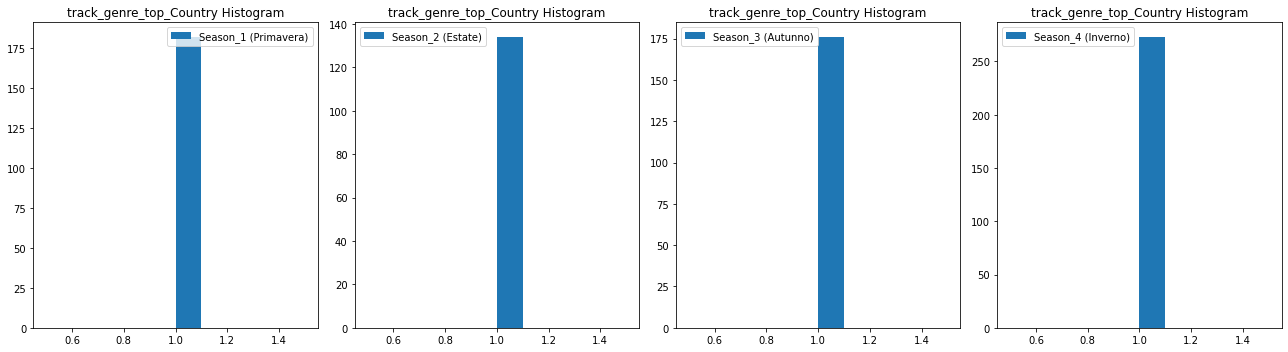

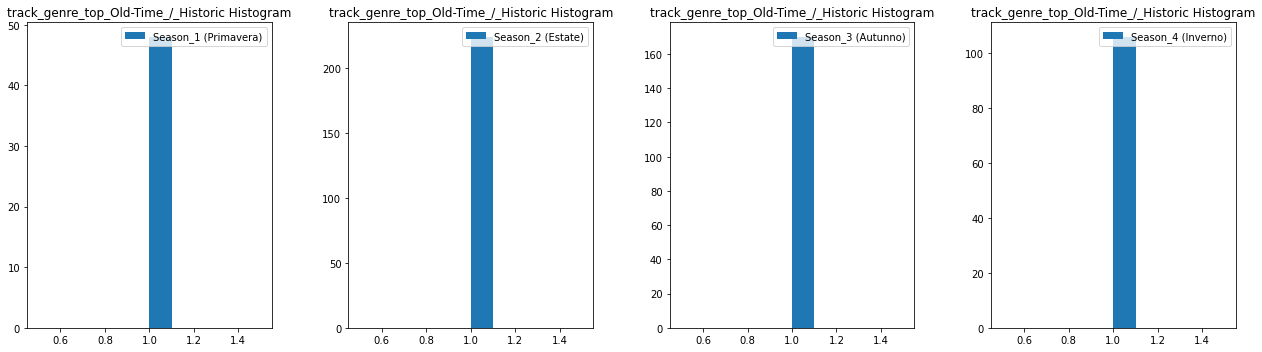

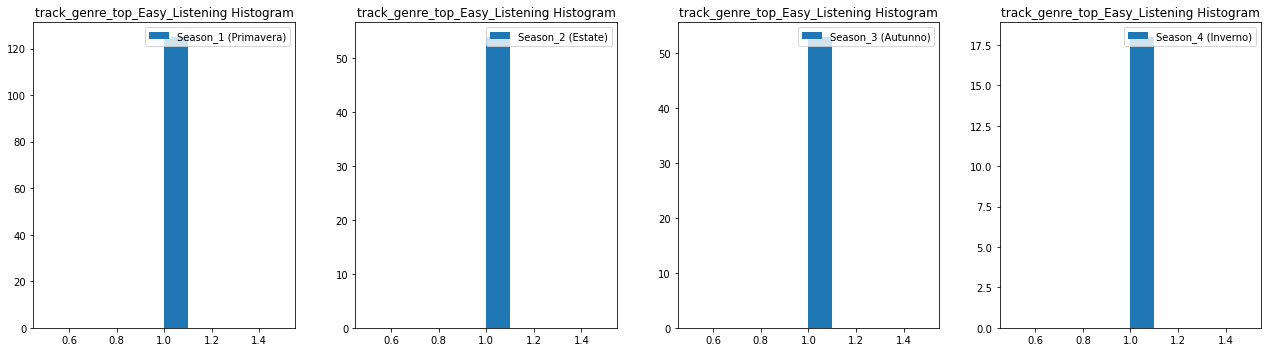

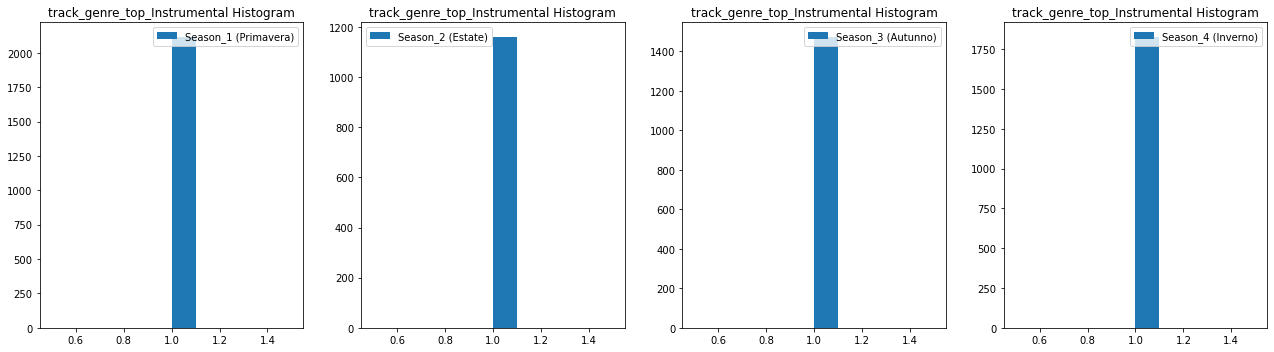

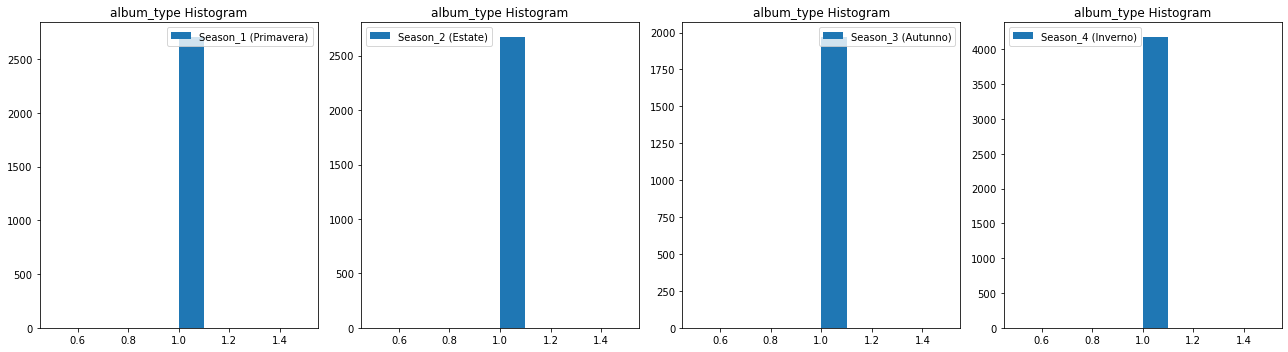

In [77]:
plot_seasons(df_genres_seasons_complete_labels)

**We create a copy of the original dataset but with ordinal features (years and seasons) encoded with onehot encoding.**

In [175]:
df_original_onehot = pd.read_csv('group_20_fma_numeric.csv', index_col = 0)

In [176]:
df_original_onehot = pd.get_dummies(df_original_onehot, \
                            columns = ['track_date_created_year', 'track_date_created_season'], dtype = int)

In [177]:
df_original_onehot

chroma_cens_02  chroma_cens_04  chroma_cens_06  chroma_cens_07  \
track_id                                                                   
2               0.534301        0.311606        0.336365        0.341694   
3               0.331490        0.296091        0.368770        0.550413   
5               0.438305        0.298619        0.358552        0.411062   
10              0.414595        0.309863        0.438154        0.616182   
20              0.354114        0.256808        0.361826        0.415287   
...                  ...             ...             ...             ...   
155316          0.239374        0.506758        0.610919        0.257752   
155317          0.376784        0.453340        0.290186        0.281965   
155318          0.297417        0.480687        0.499205        0.311303   
155319          0.376004        0.361030        0.479526        0.444307   
155320          0.326523        0.399048        0.392797        0.320429   

          chroma_cens_09  chroma_cens_11  chroma_stft_05  chroma_stft_08  \
track_id                                                                   
2               0.292243        0.276052        0.341598        0.430064   
3               0.464814        0.363497        0.391794        0.581584   
5               0.515737        0.338845        0.335509        0.353870   
10              0.399730        0.369890        0.357122        0.420764   
20              0.368049        0.419011        0.390003        0.575782   
...                  ...             ...             ...             ...   
155316          0.253840        0.242582        0.512779        0.418091   
155317          0.324159        0.404858        0.579709        0.609059   
155318          0.363107        0.317513        0.582218        0.529418   
155319          0.405410        0.283908        0.628887        0.527227   
155320          0.447267        0.365973        0.617016        0.533301   

          chroma_stft_10  chroma_stft_12  ...  track_date_created_year_5  \
track_id                                  ...                              
2               0.381936        0.529627  ...                          0   
3               0.510926        0.540496  ...                          0   
5               0.418968        0.467409  ...                          0   
10              0.370725        0.388618  ...                          0   
20              0.556986        0.491322  ...                          0   
...                  ...             ...  ...                        ...   
155316          0.422479        0.476460  ...                          0   
155317          0.567302        0.643192  ...                          0   
155318          0.496228        0.579227  ...                          0   
155319          0.411554        0.615549  ...                          0   
155320          0.631633        0.561229  ...                          0   

          track_date_created_year_6  track_date_created_year_7  \
track_id                                                         
2                                 0                          0   
3                                 0                          0   
5                                 0                          0   
10                                0                          0   
20                                0                          0   
...                             ...                        ...   
155316                            0                          0   
155317                            0                          0   
155318                            0                          0   
155319                            0                          0   
155320                            0                          0   

          track_date_created_year_8  track_date_created_year_9  \
track_id                                                         
2                                 0                 

In [178]:
df_original_onehot['Labels'] = df_genres_seasons_complete_labels['Labels']

In [179]:
df_original_onehot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103708 entries, 2 to 155320
Data columns (total 69 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   chroma_cens_02                       103708 non-null  float64
 1   chroma_cens_04                       103708 non-null  float64
 2   chroma_cens_06                       103708 non-null  float64
 3   chroma_cens_07                       103708 non-null  float64
 4   chroma_cens_09                       103708 non-null  float64
 5   chroma_cens_11                       103708 non-null  float64
 6   chroma_stft_05                       103708 non-null  float64
 7   chroma_stft_08                       103708 non-null  float64
 8   chroma_stft_10                       103708 non-null  float64
 9   chroma_stft_12                       103708 non-null  float64
 10  mfcc_02                              103708 non-null  float64
 11  mfcc_03      

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


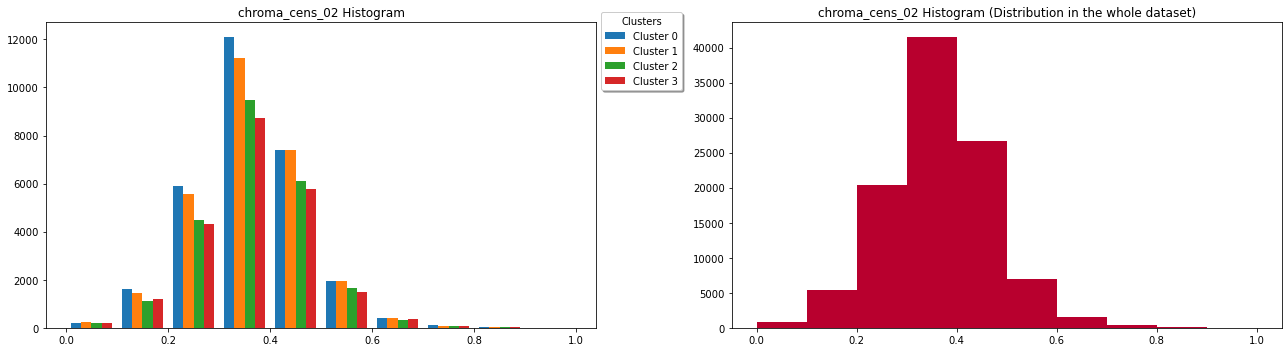

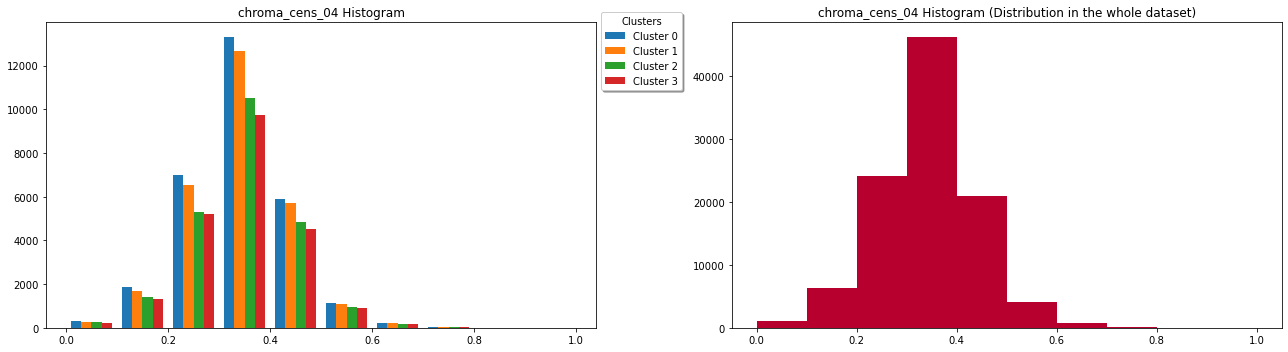

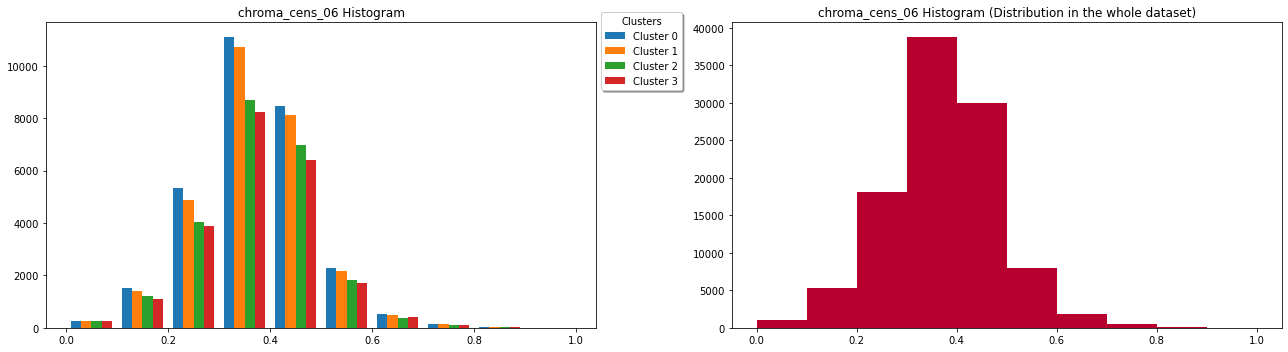

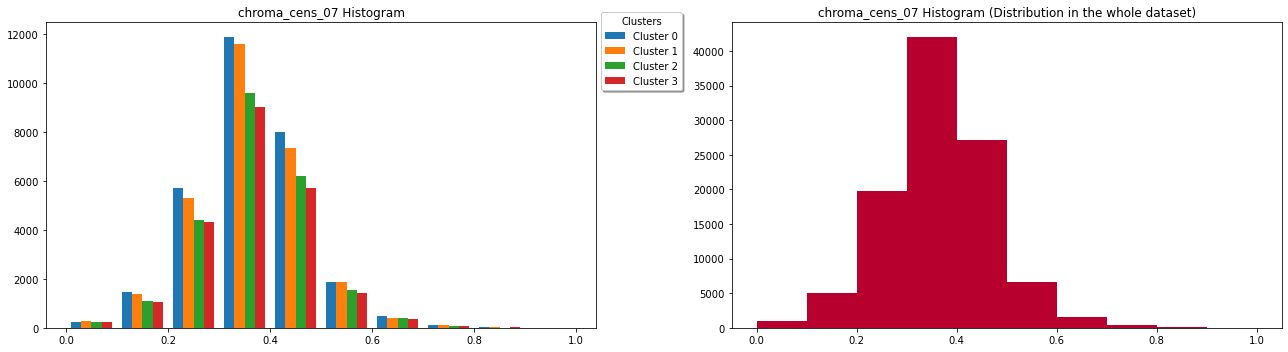

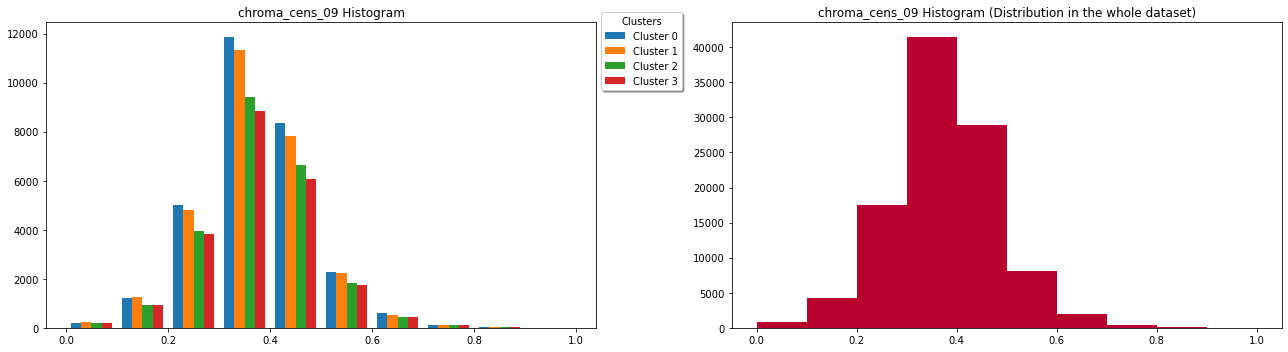

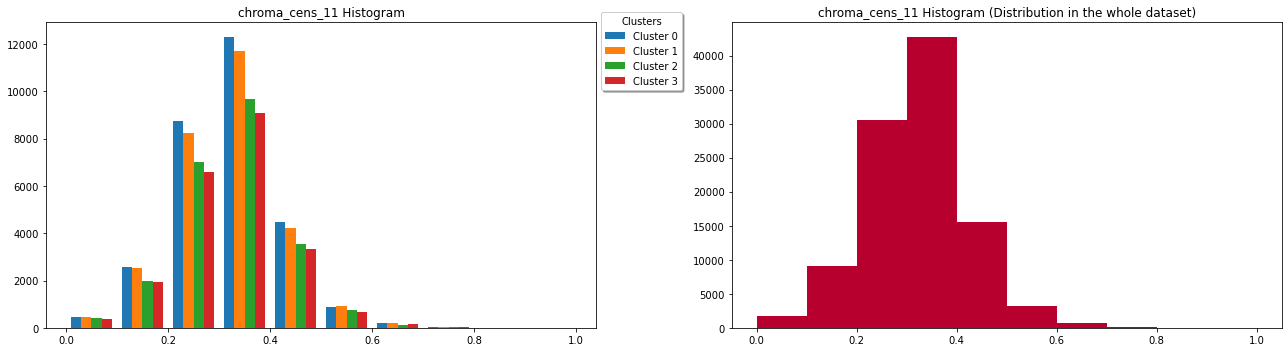

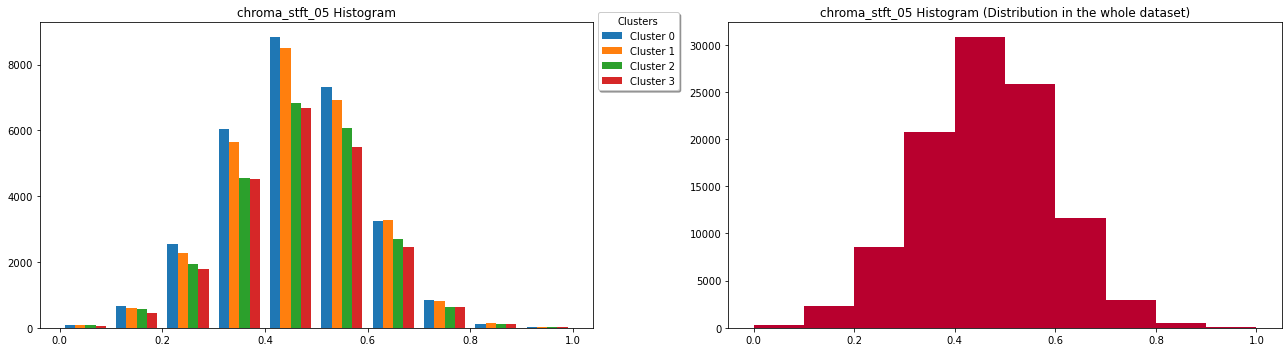

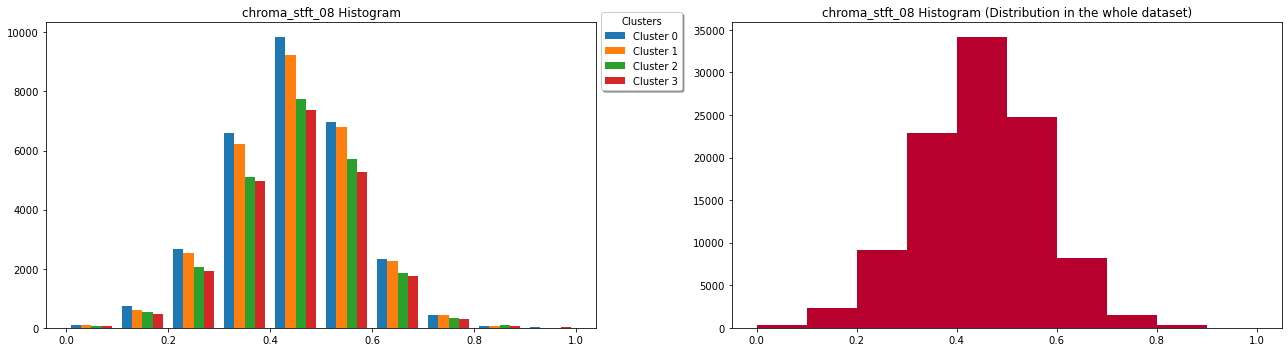

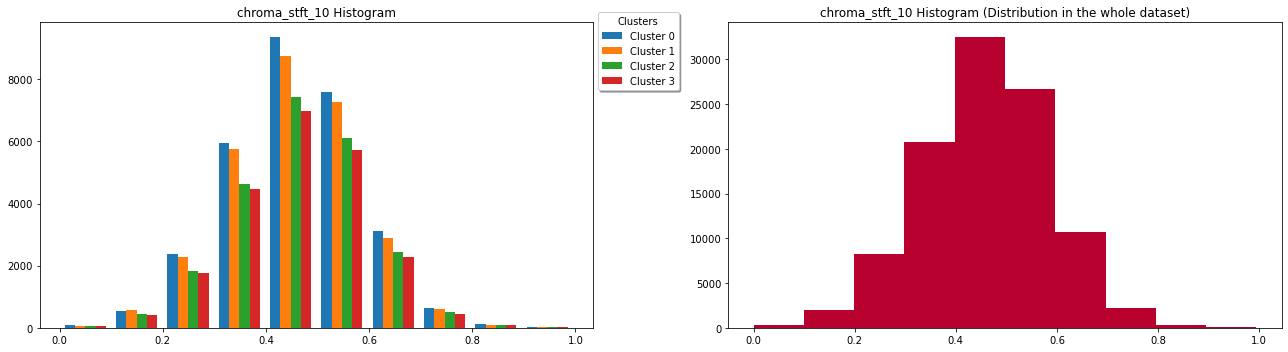

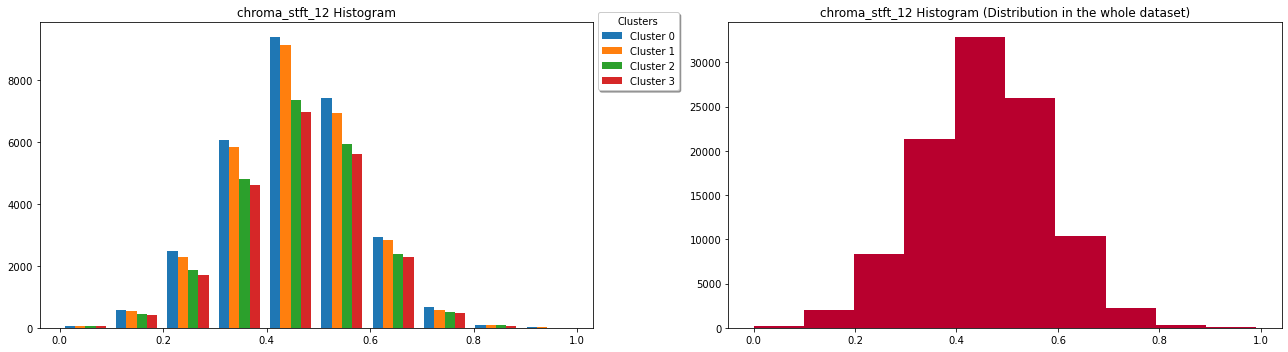

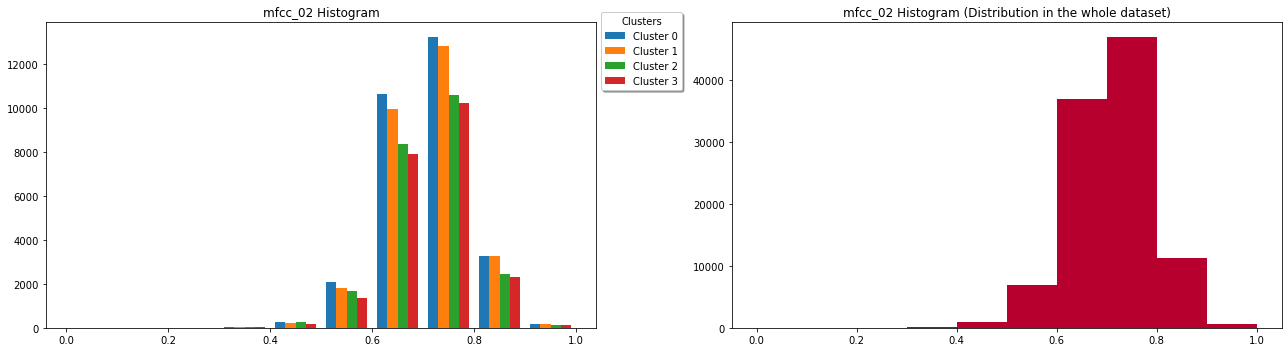

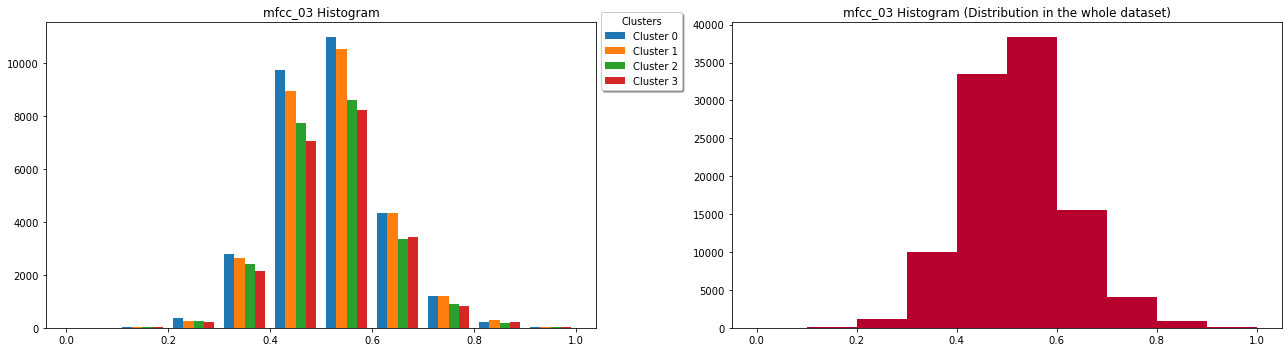

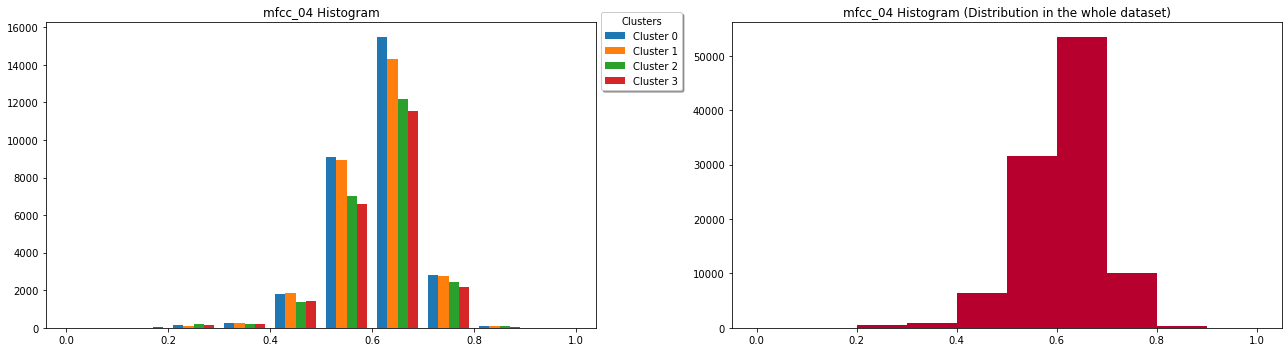

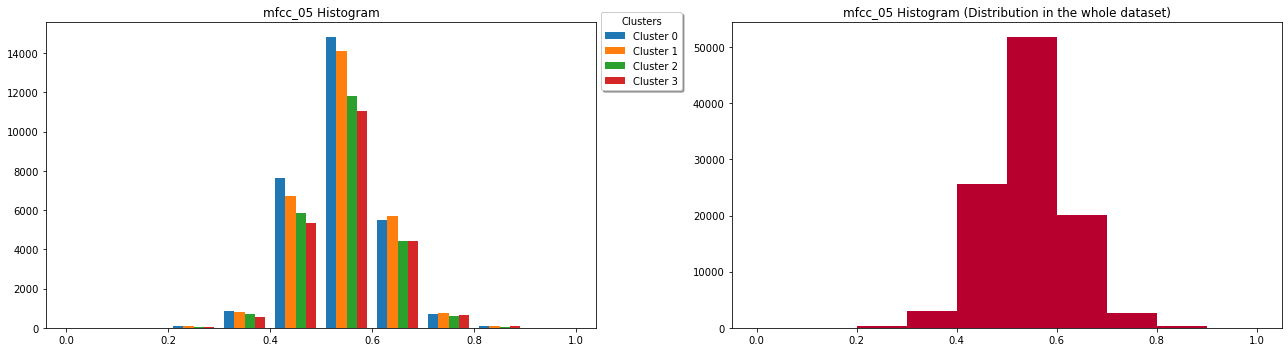

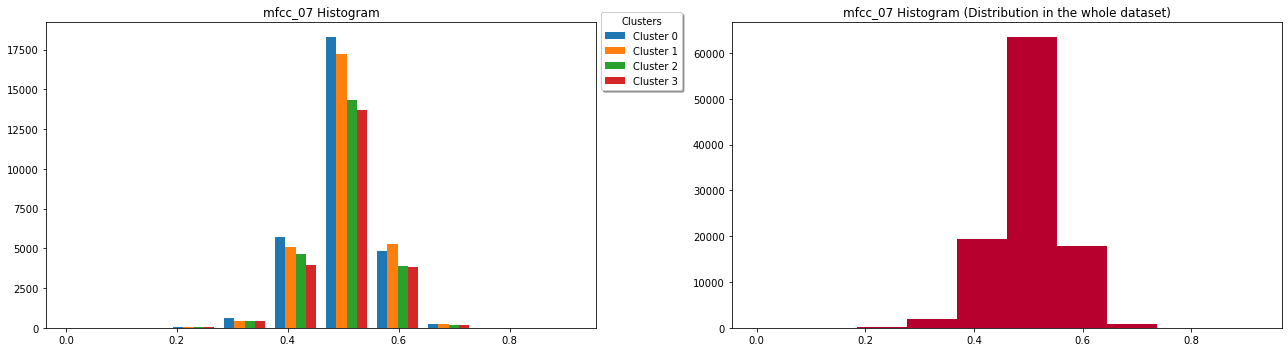

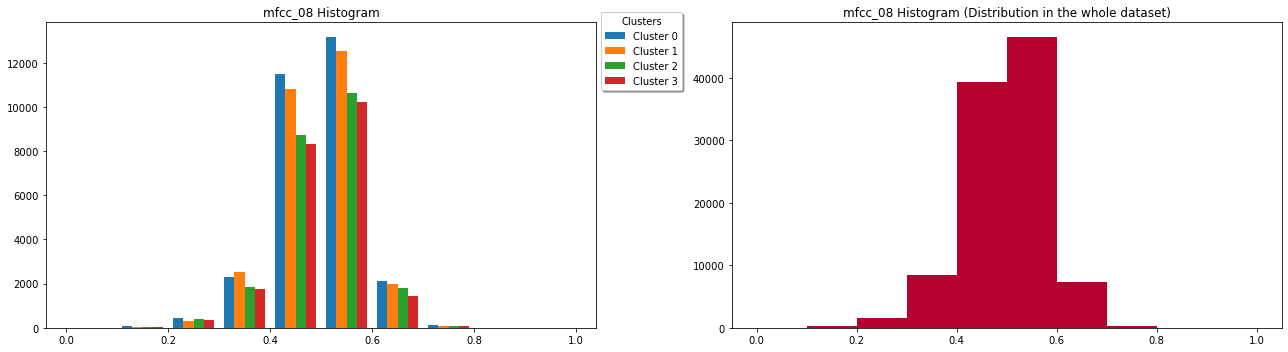

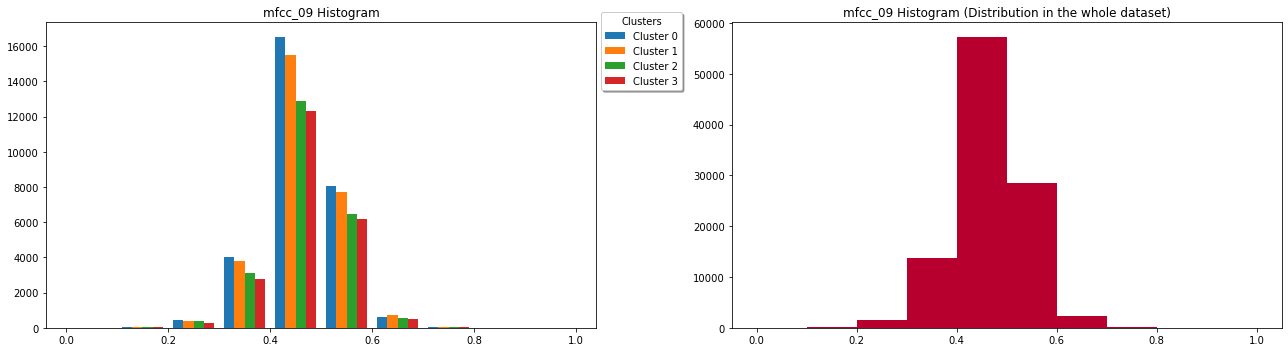

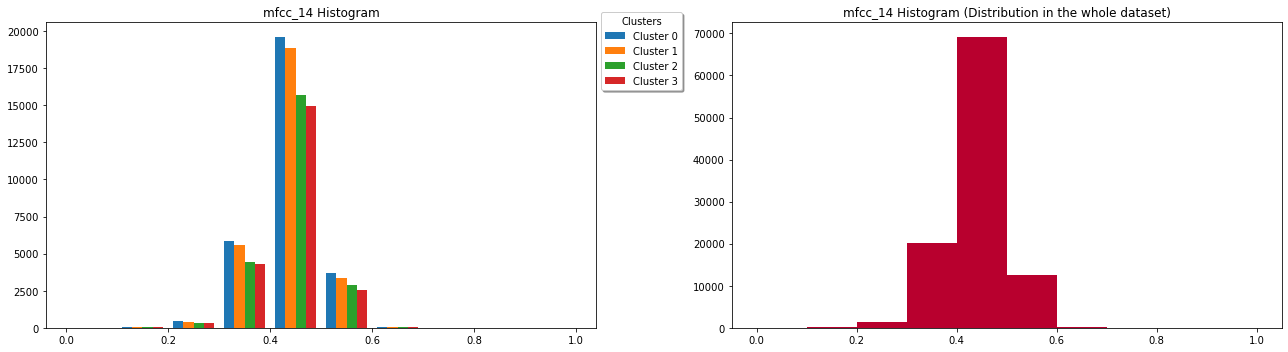

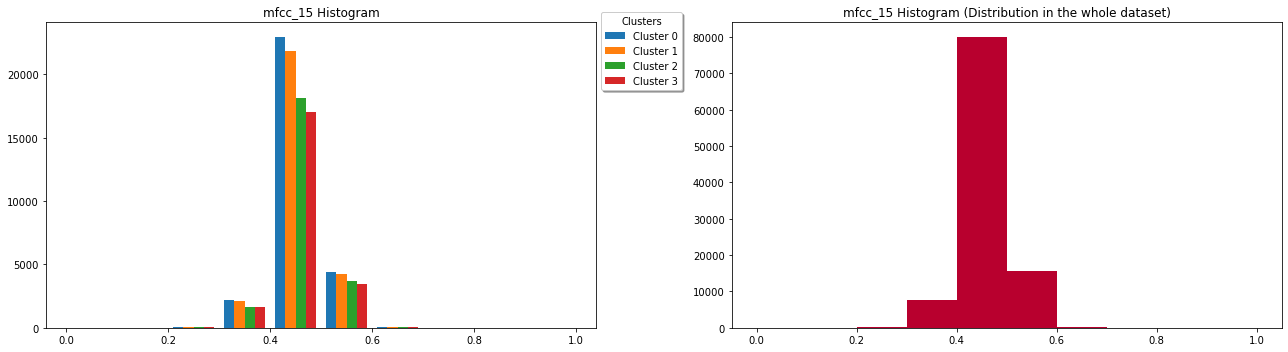

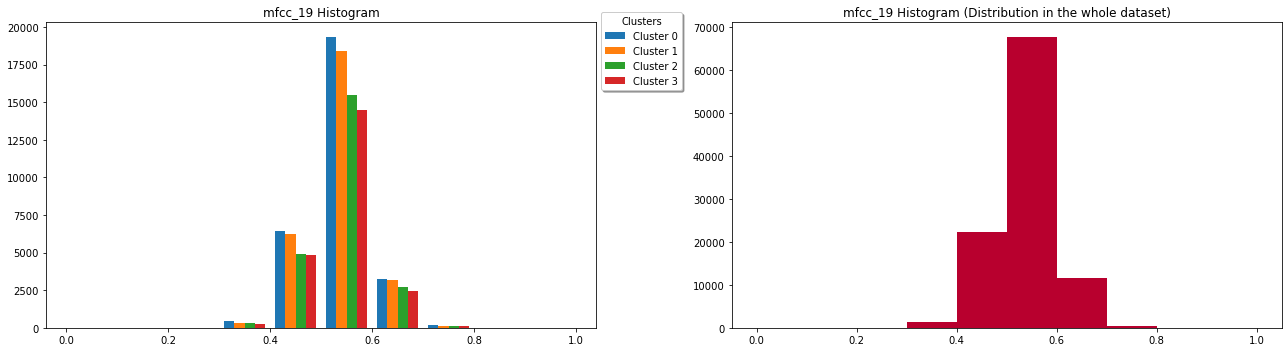

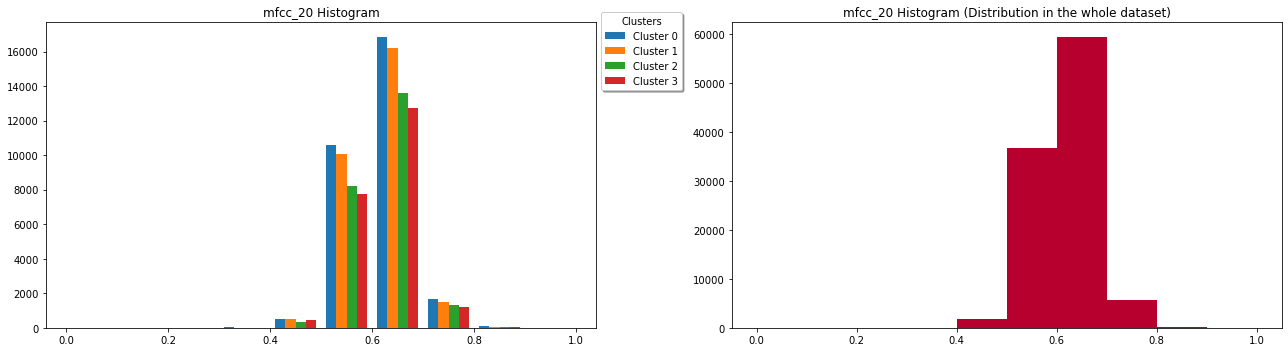

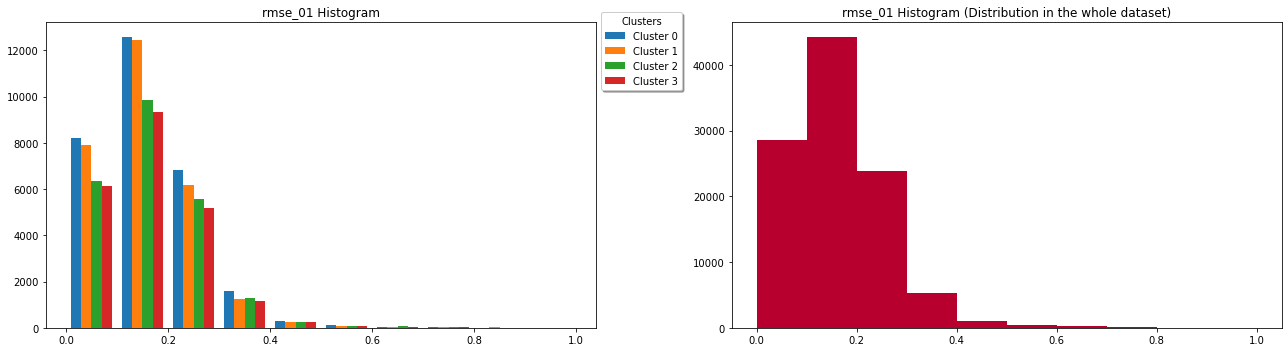

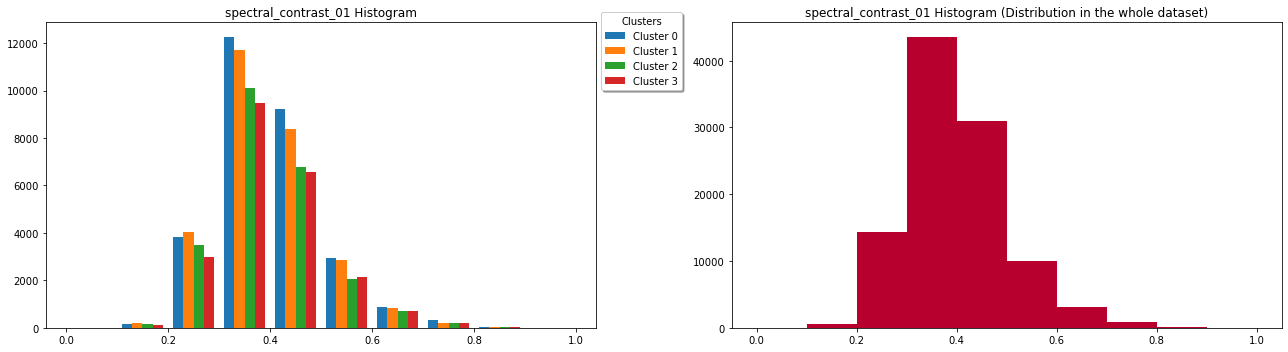

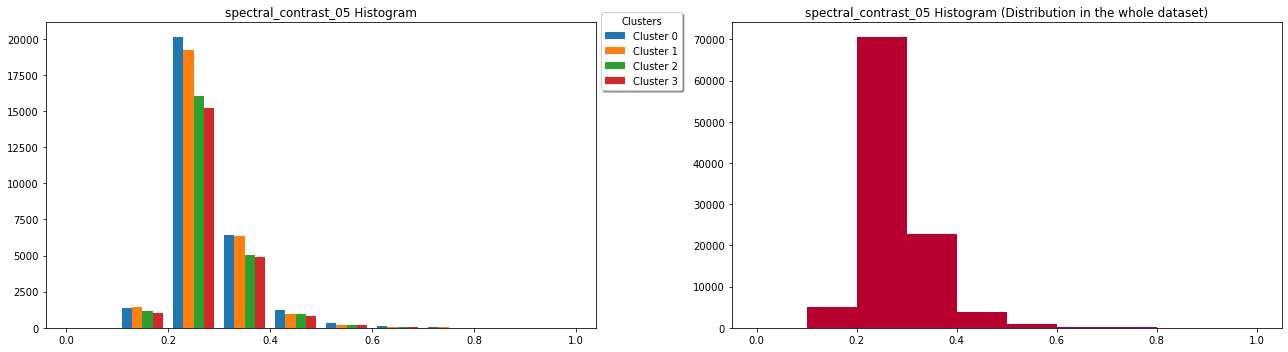

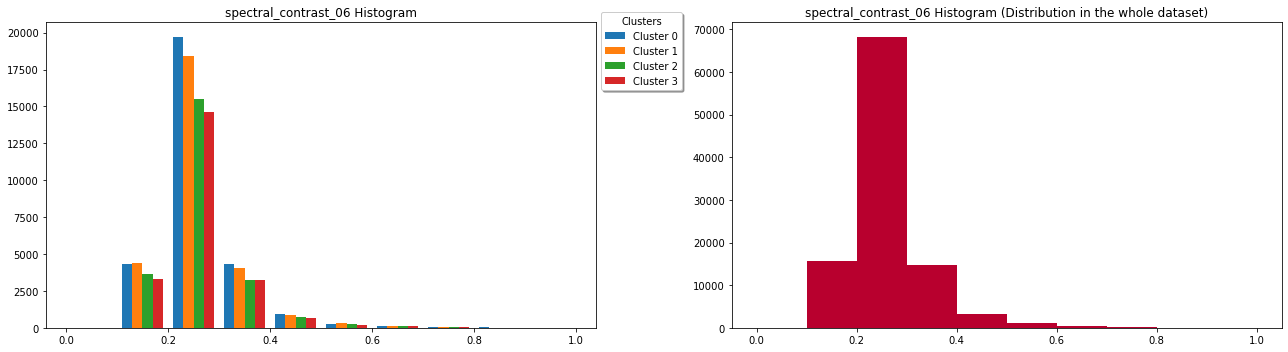

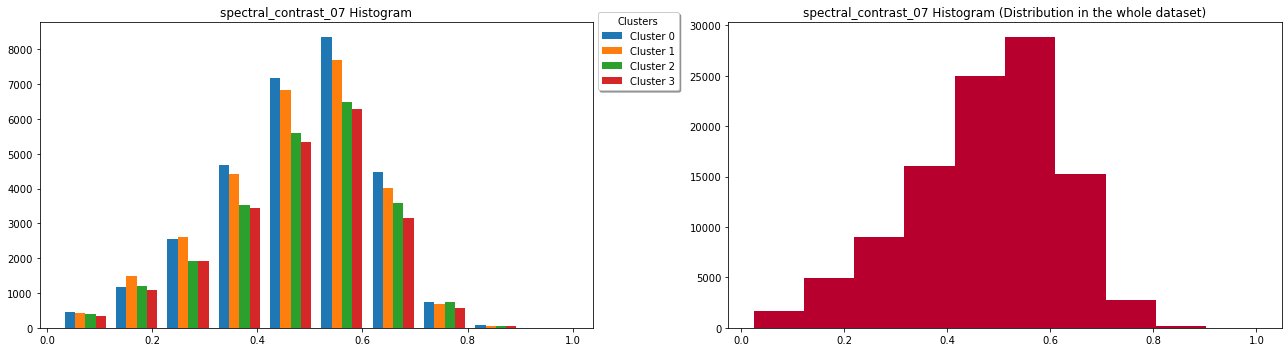

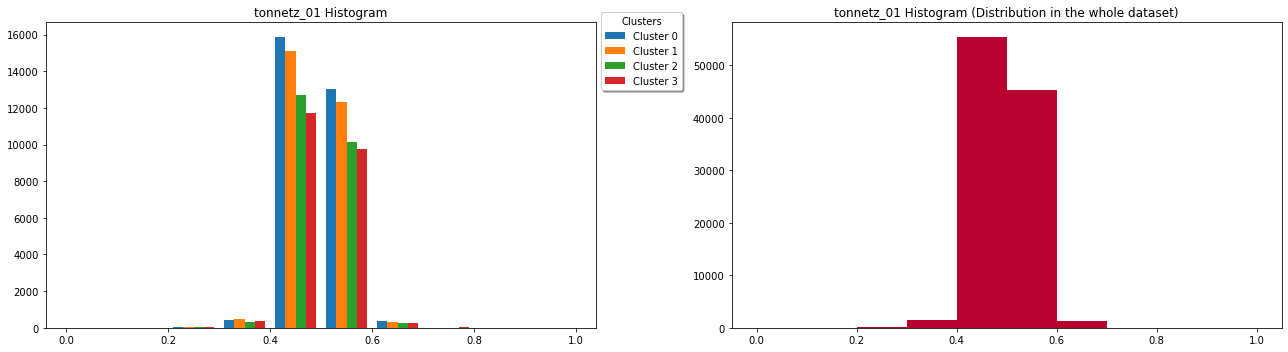

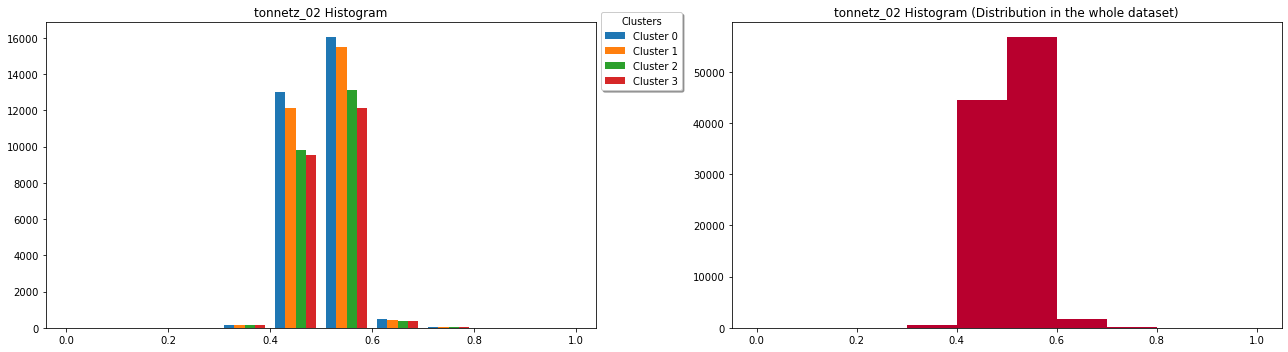

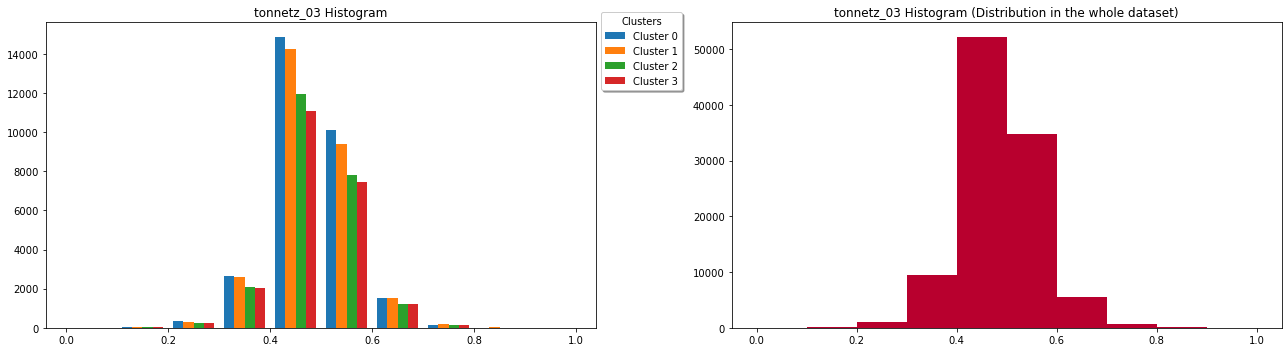

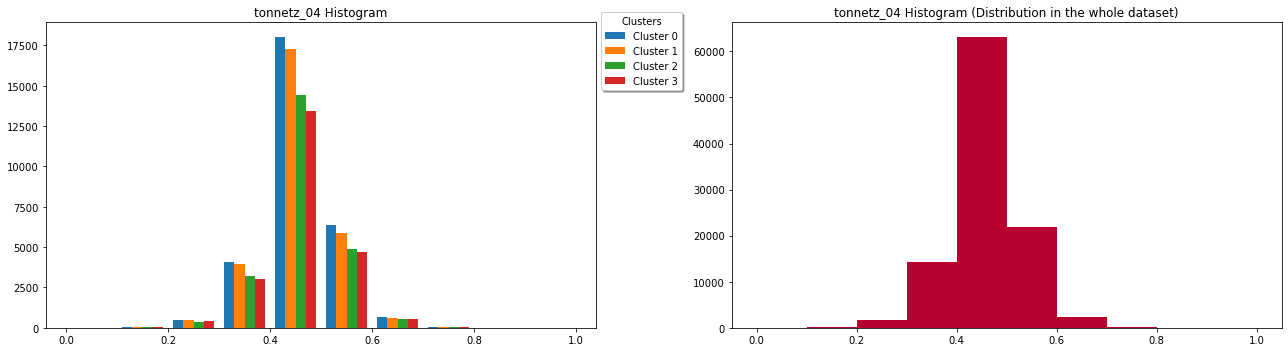

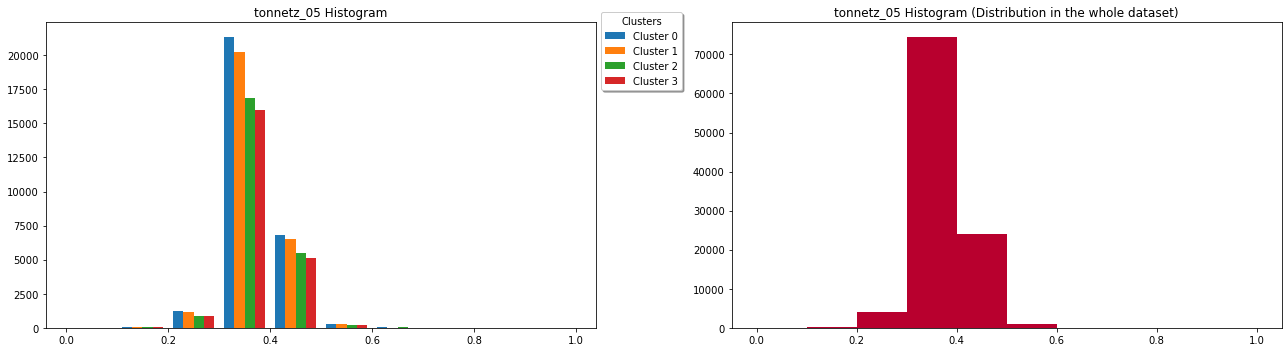

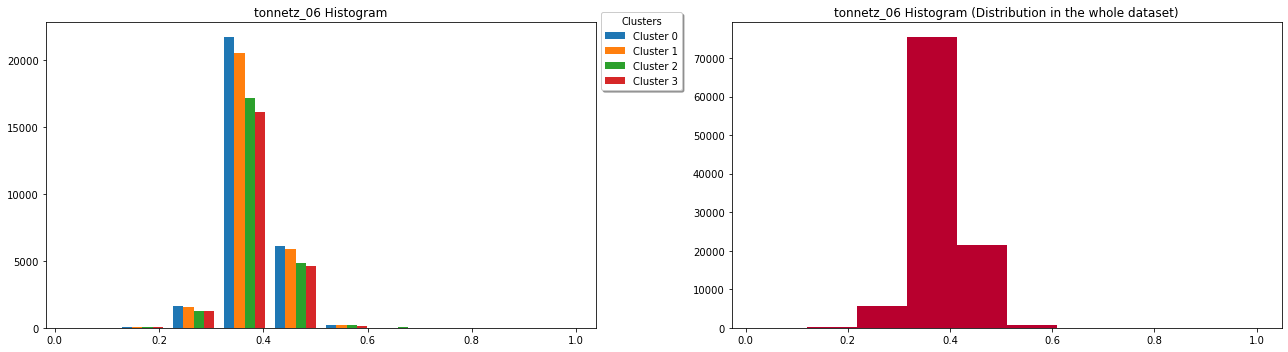

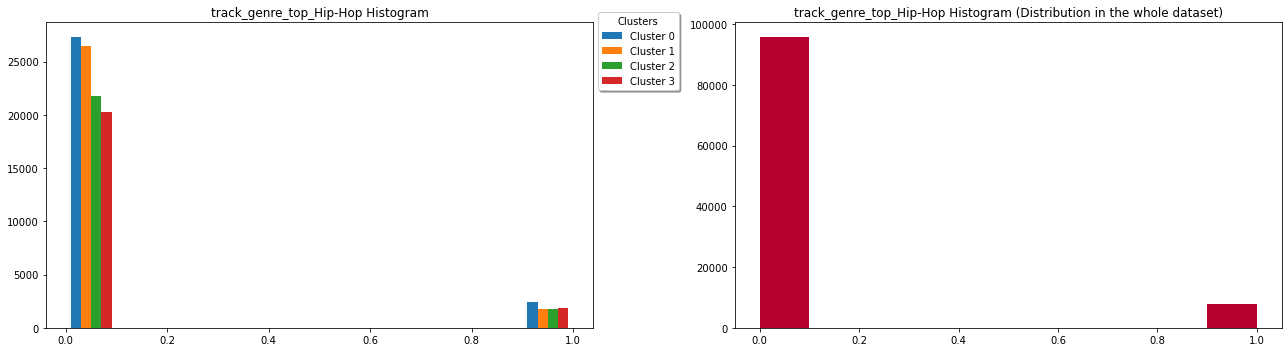

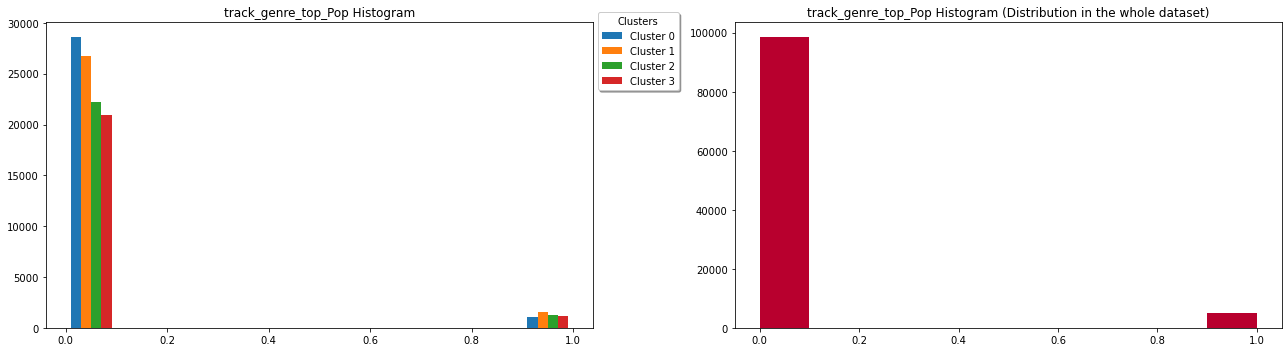

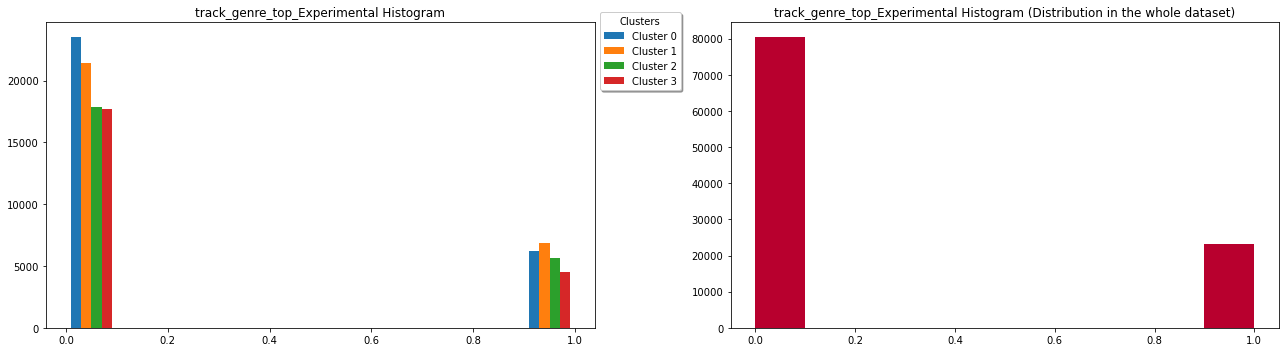

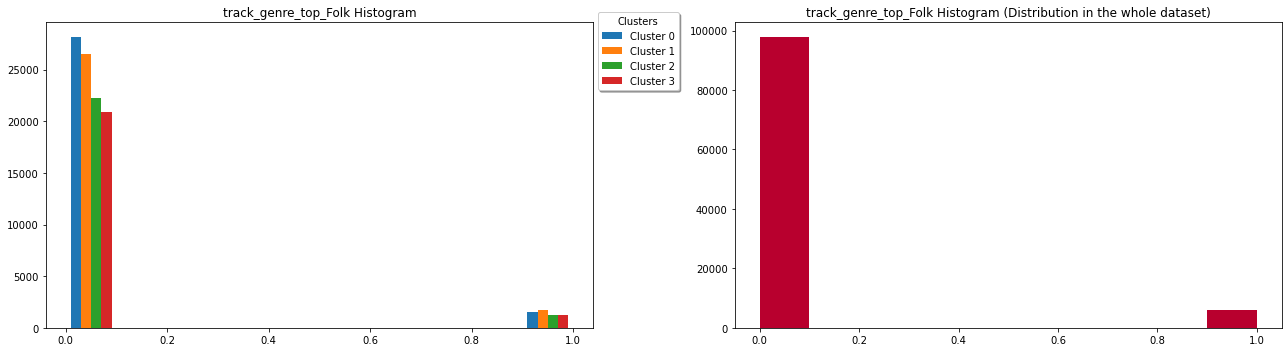

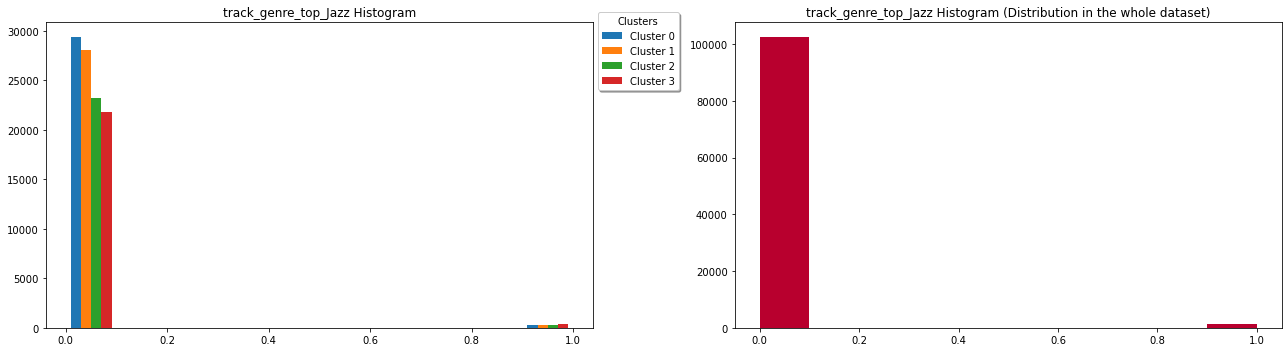

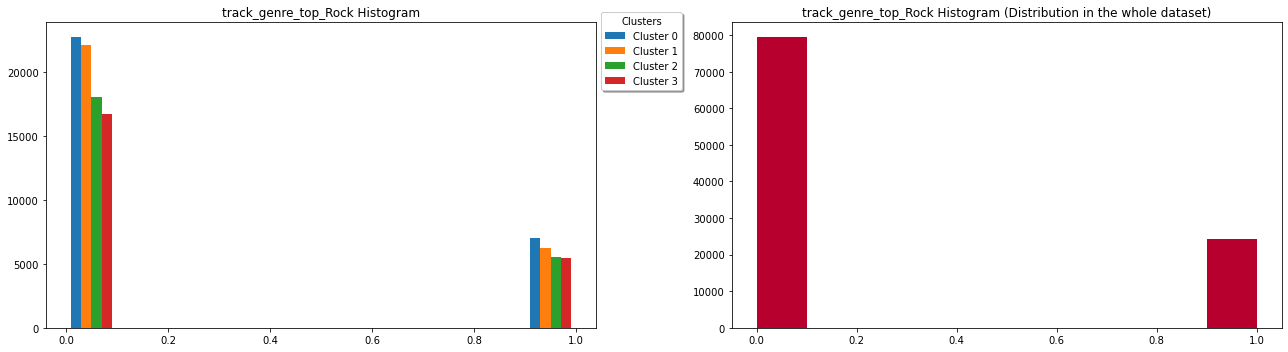

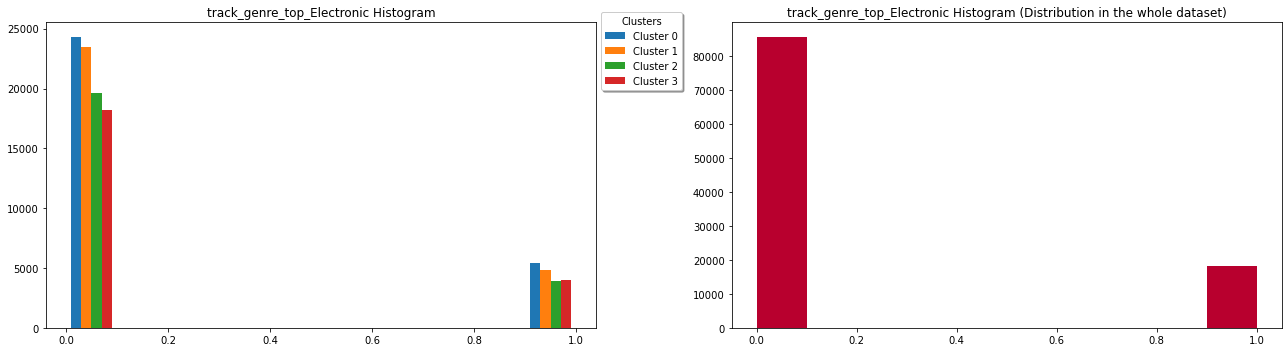

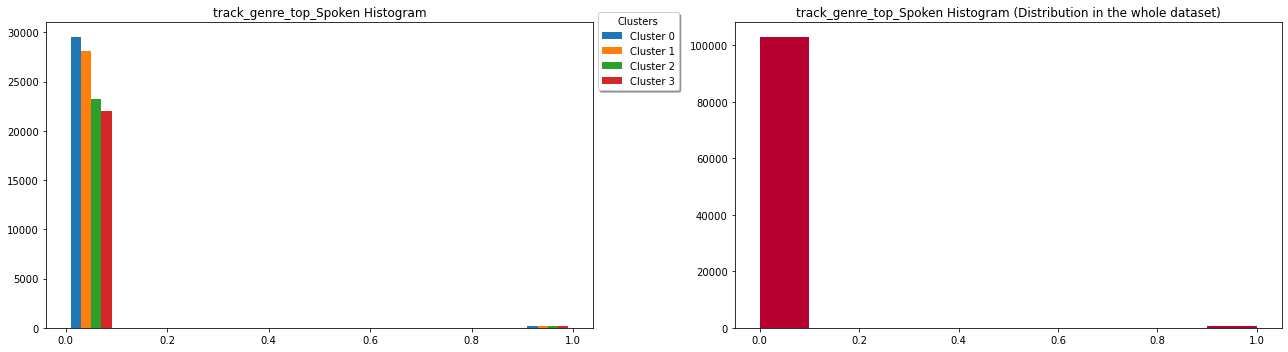

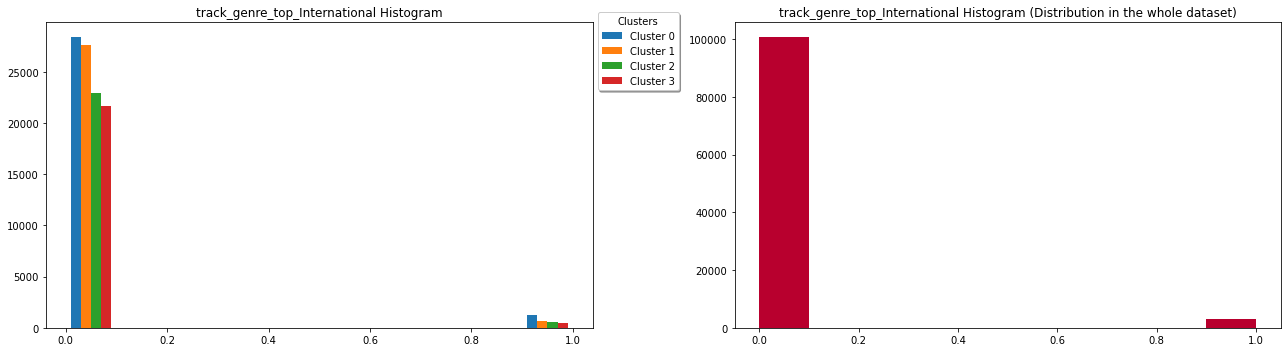

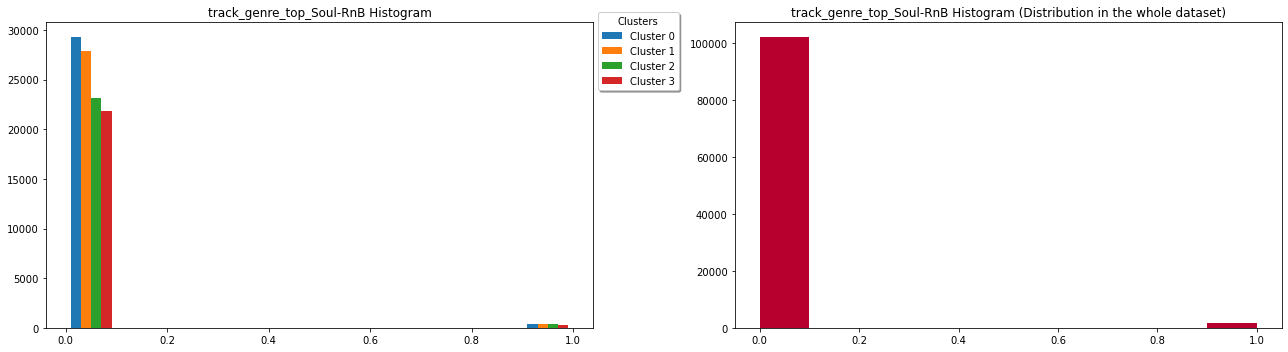

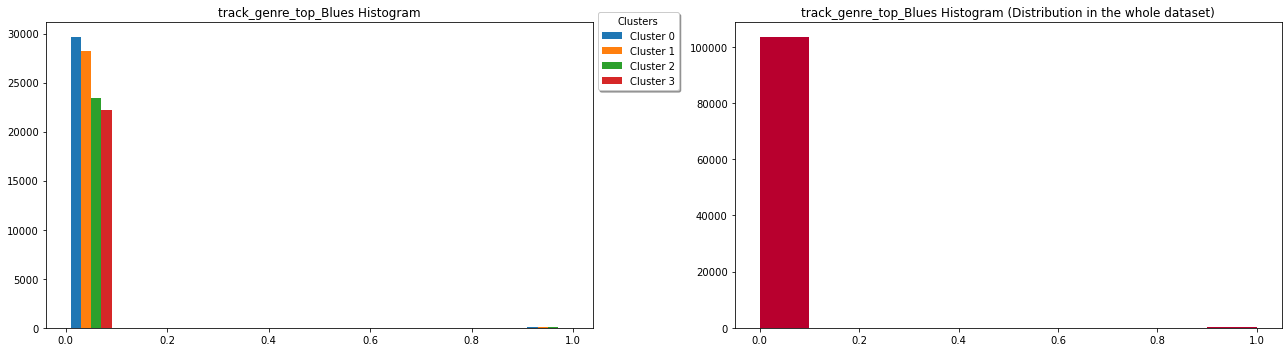

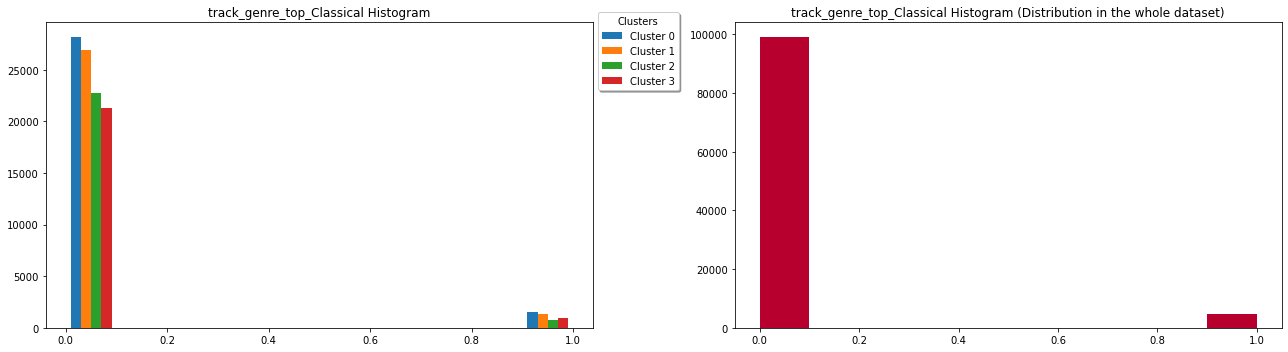

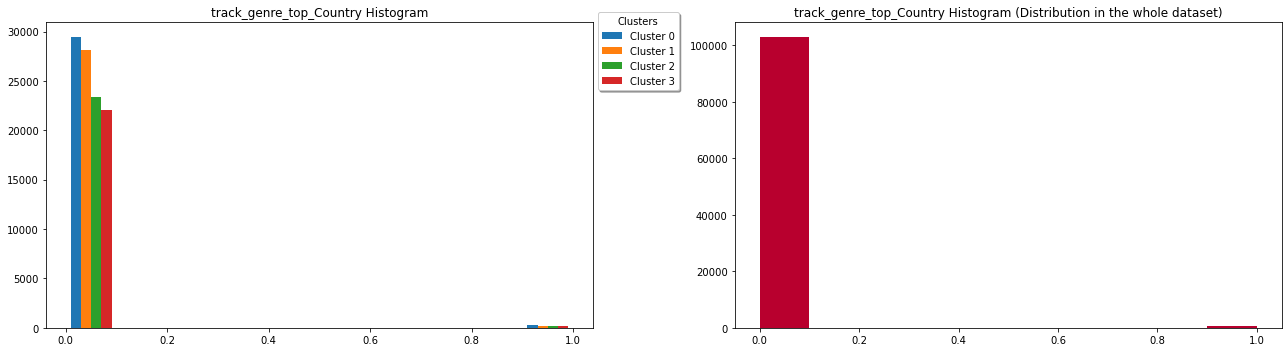

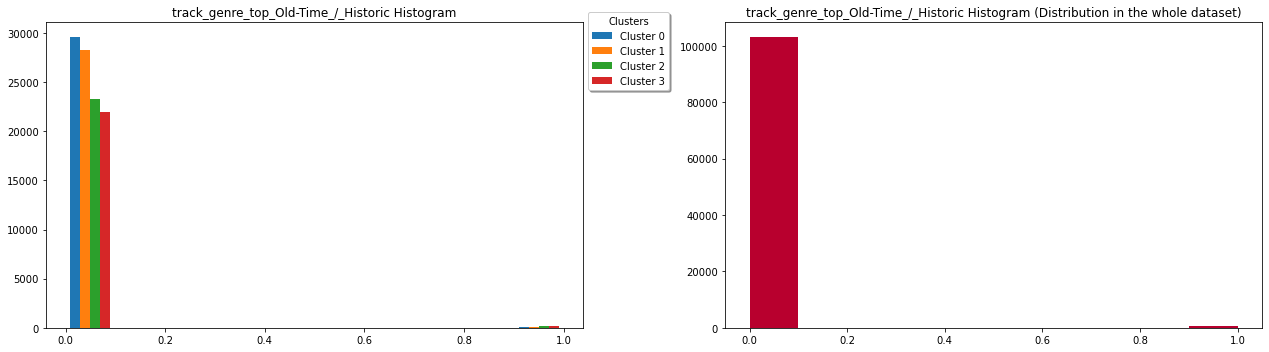

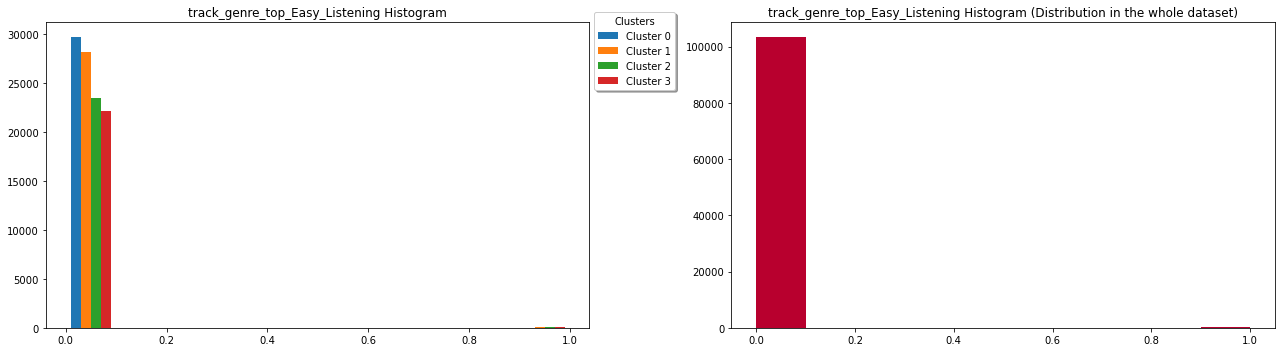

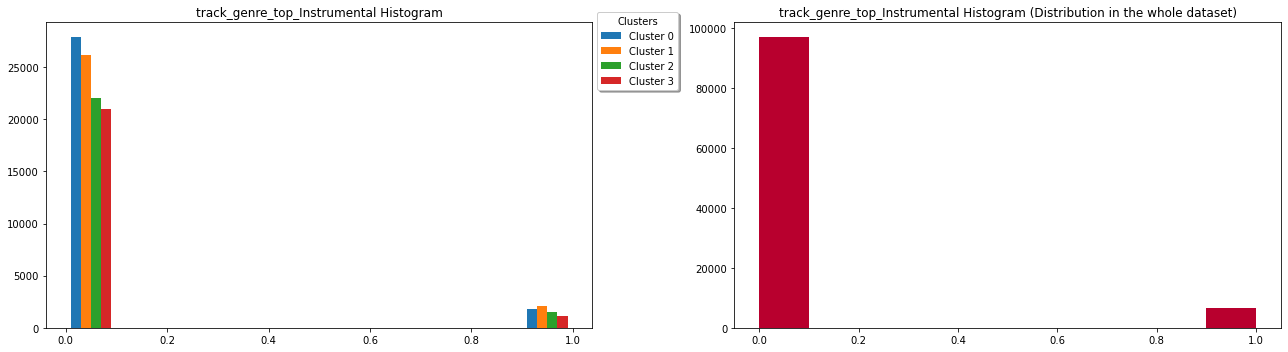

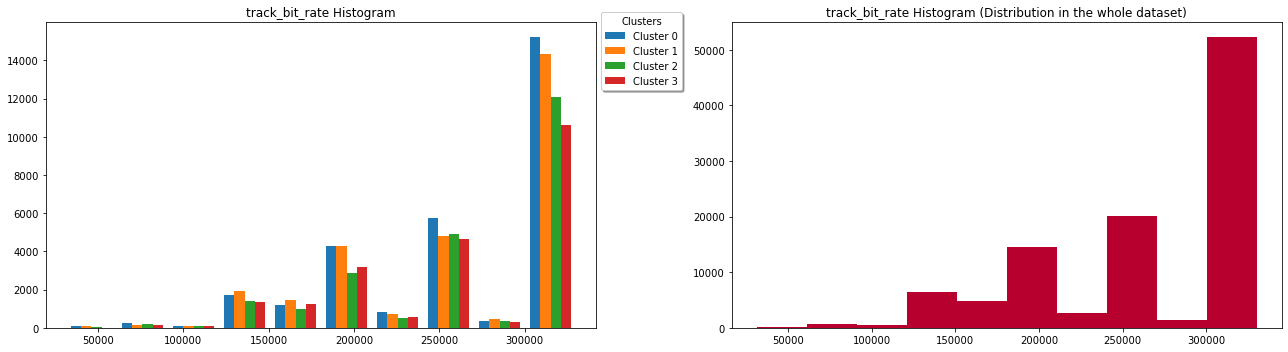

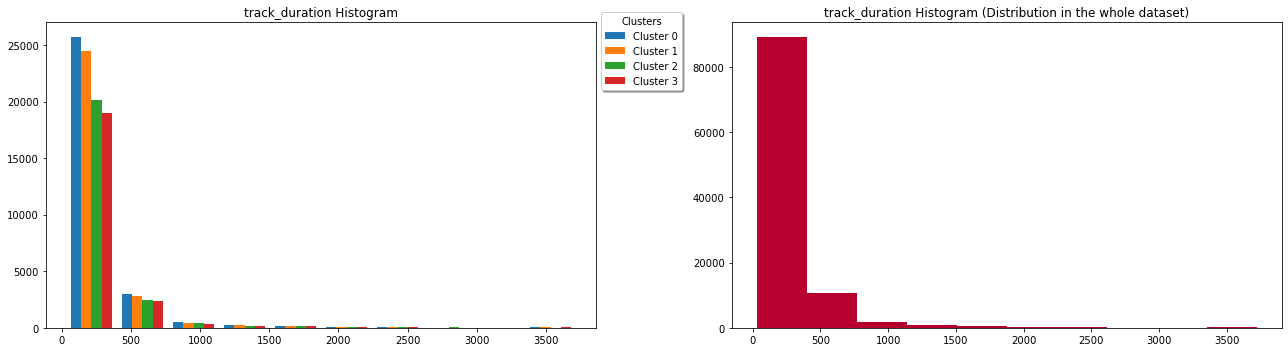

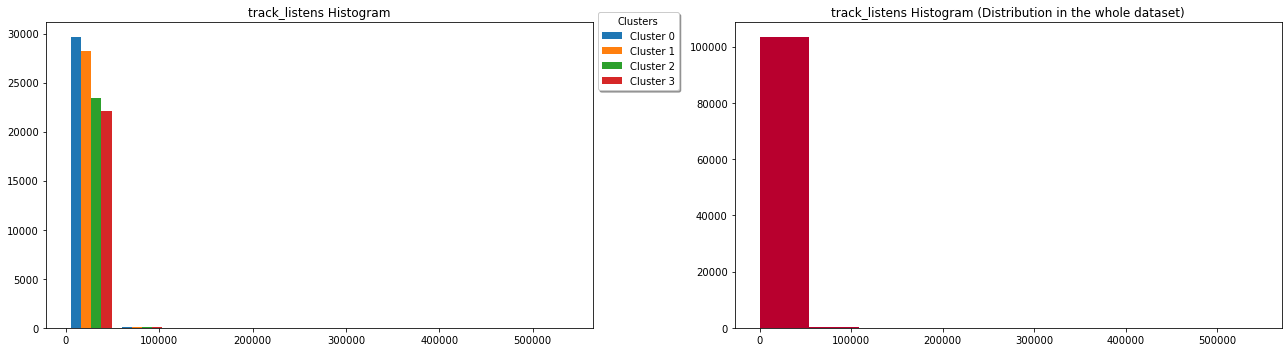

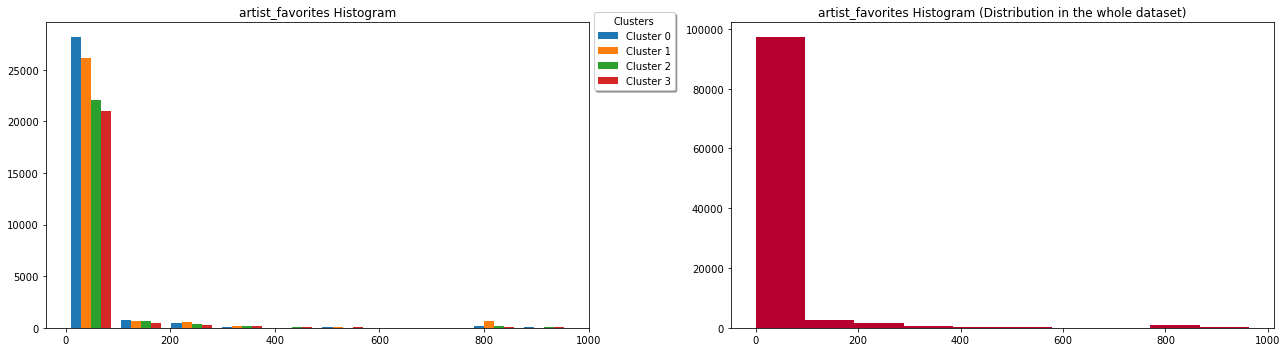

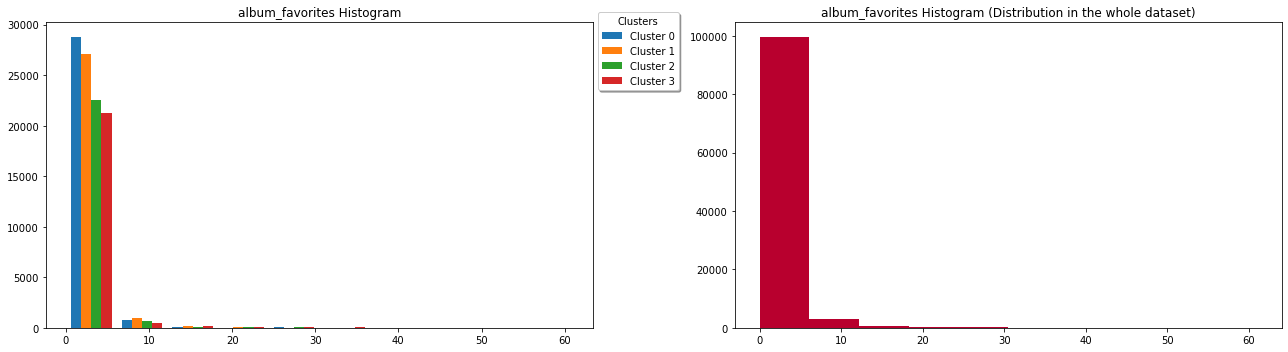

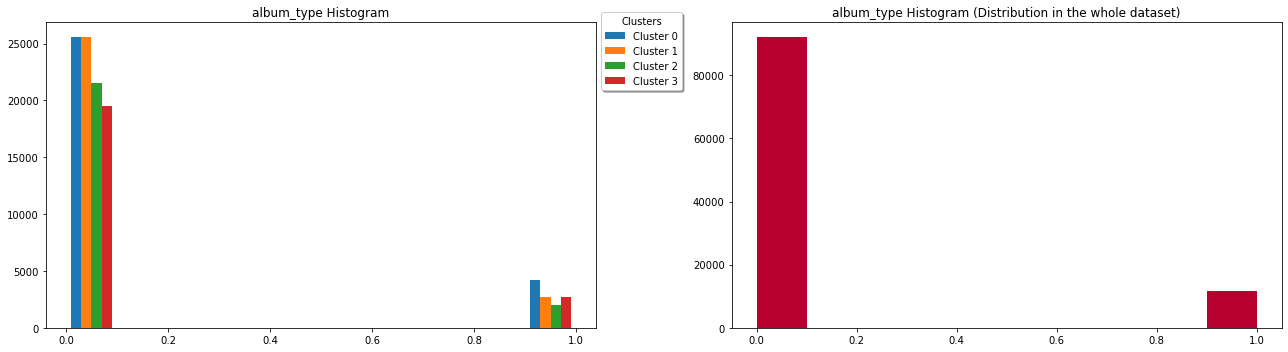

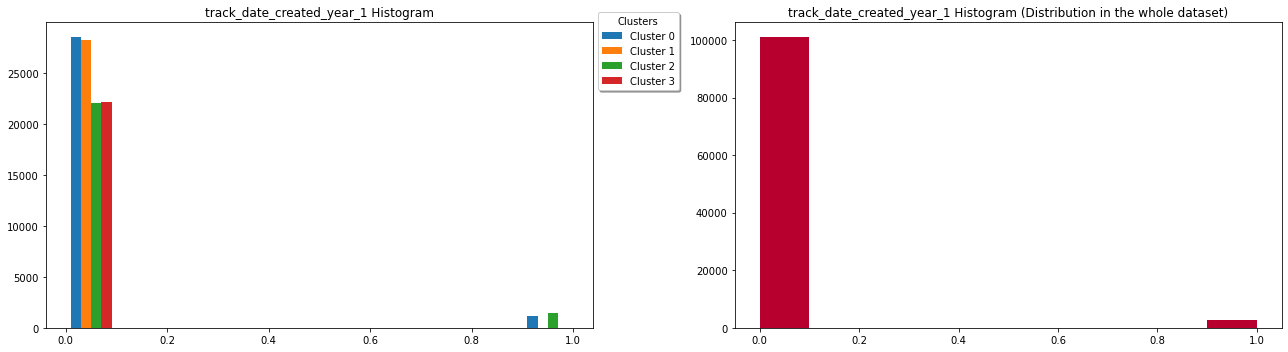

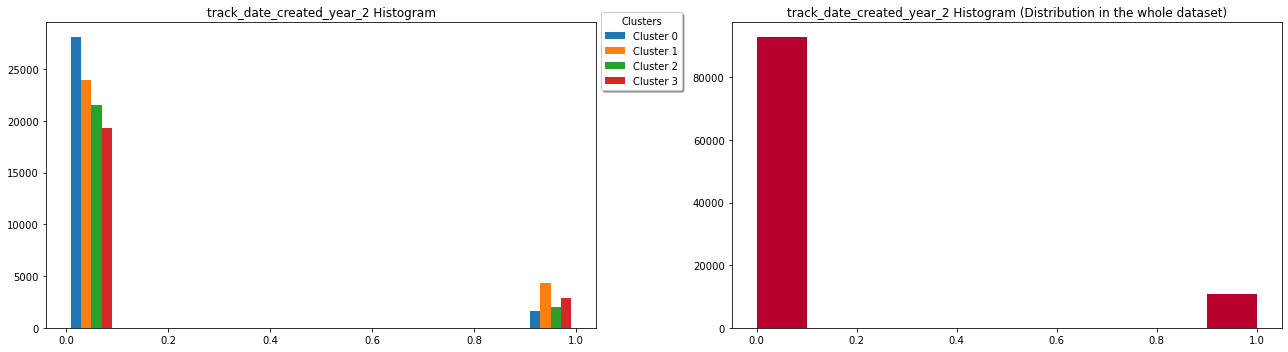

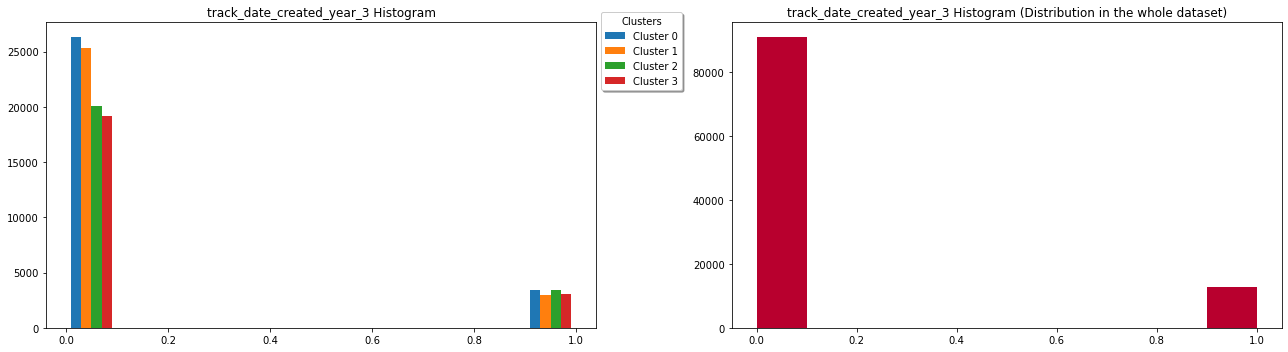

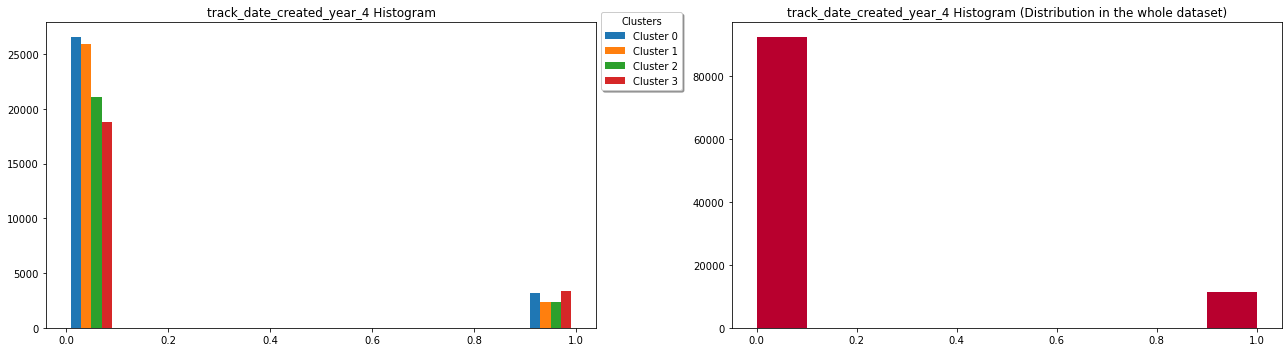

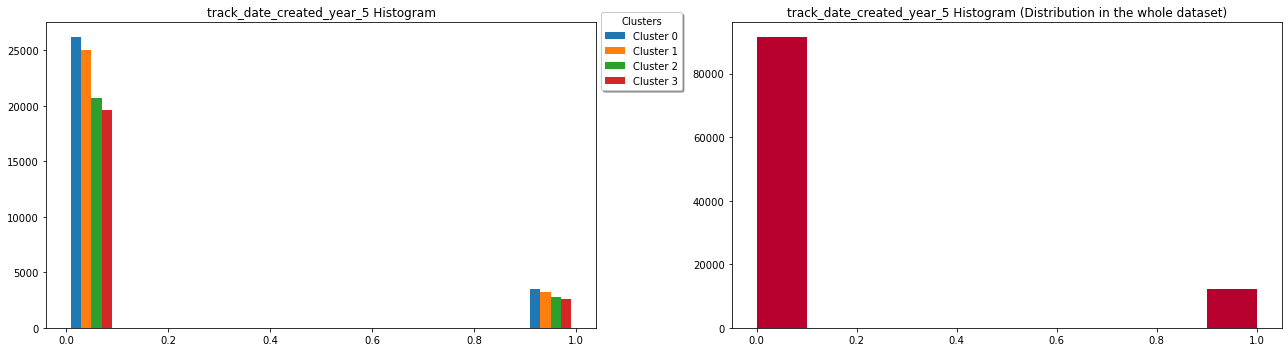

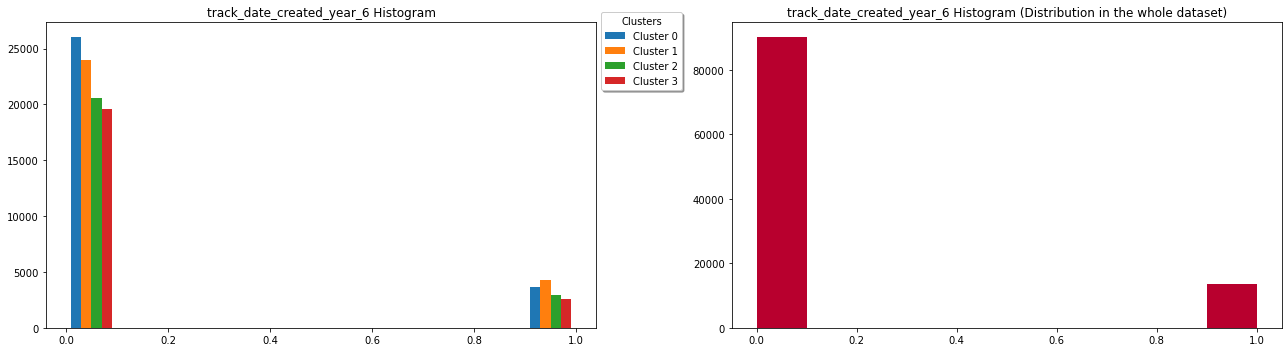

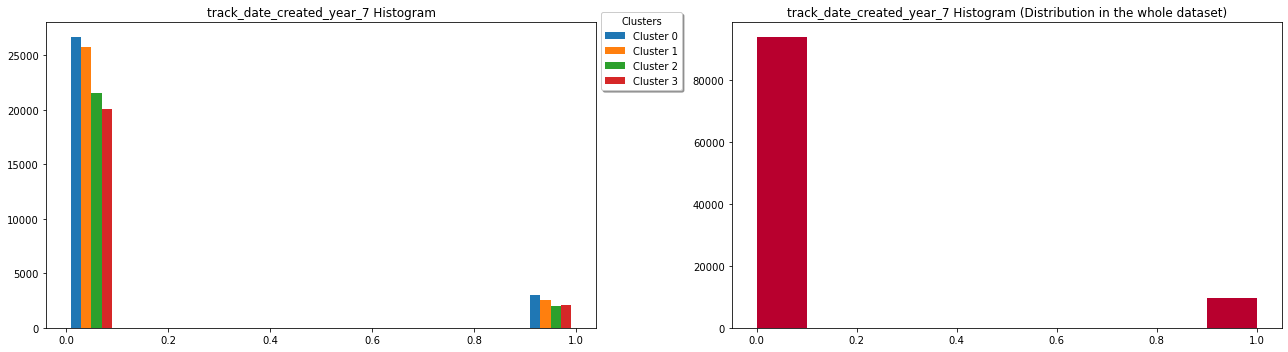

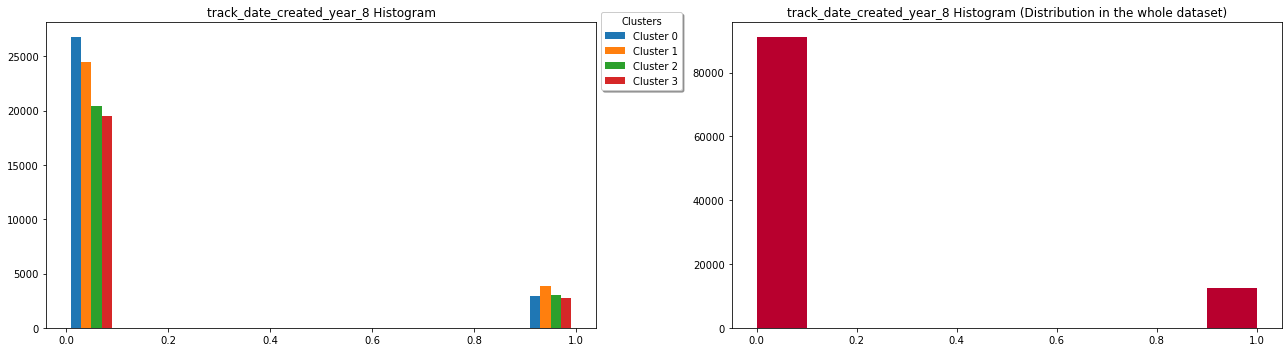

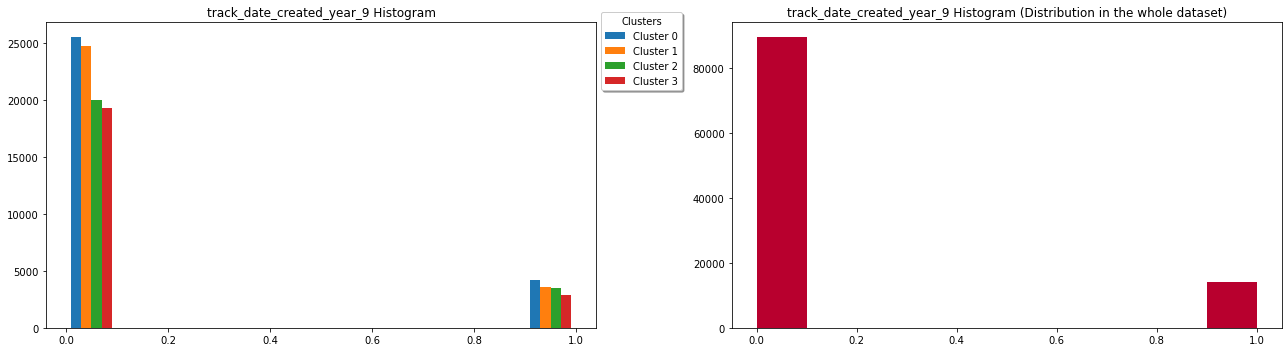

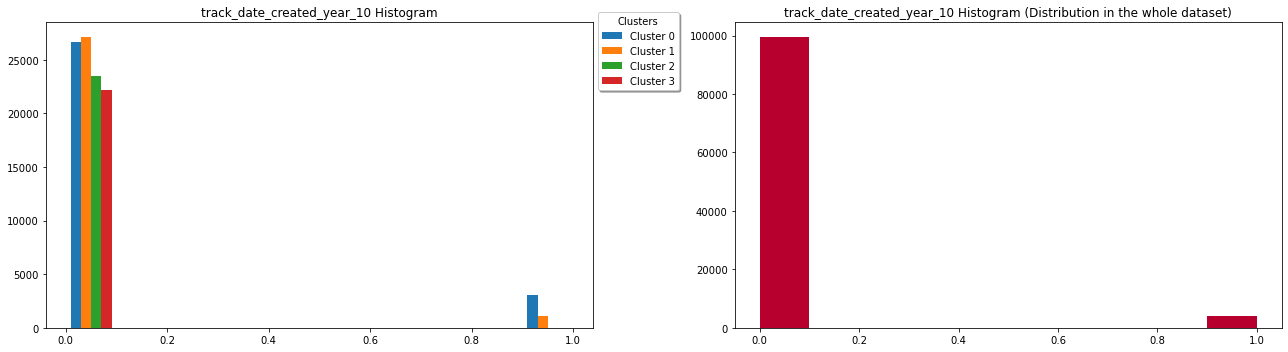

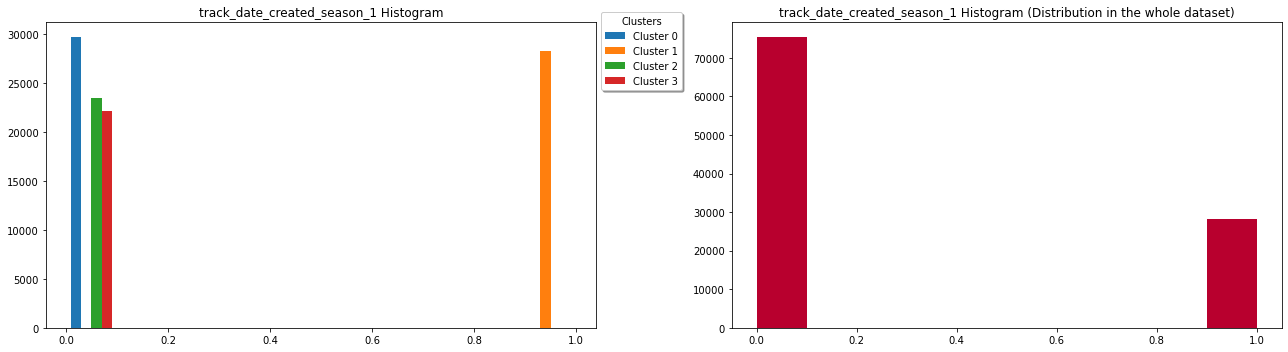

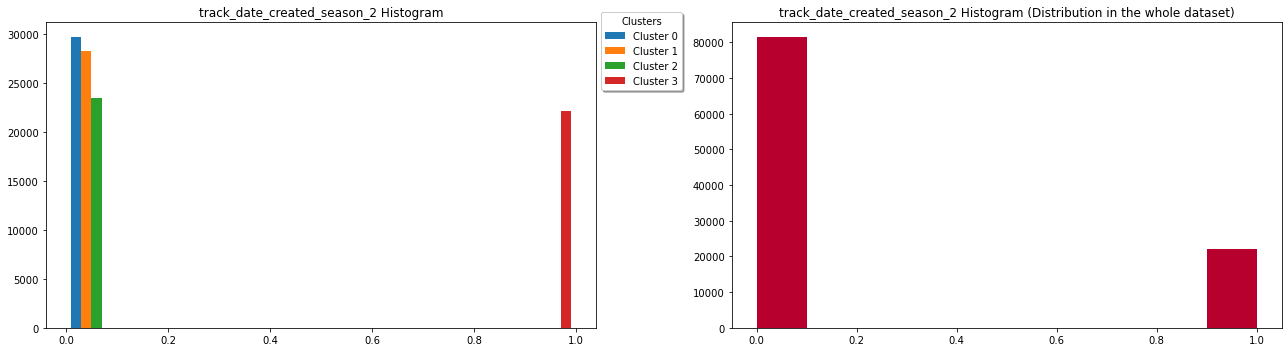

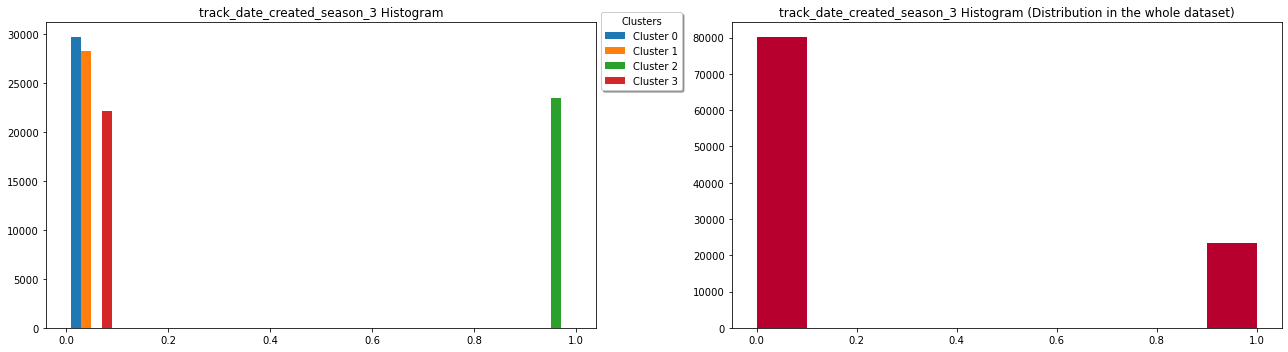

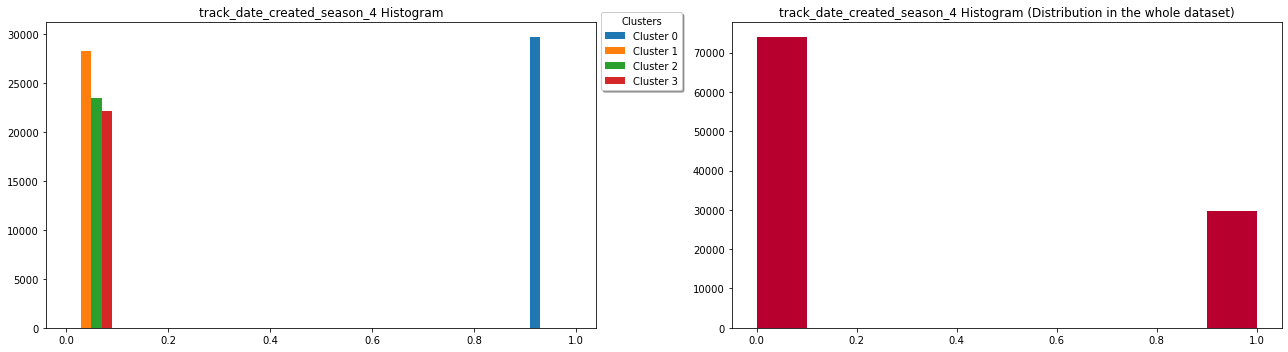

In [180]:
plot_general_distributions(df_original_onehot)

Cluster 0



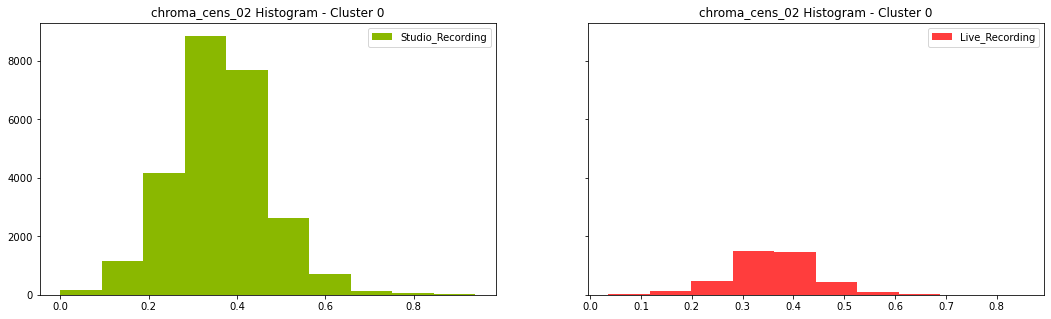

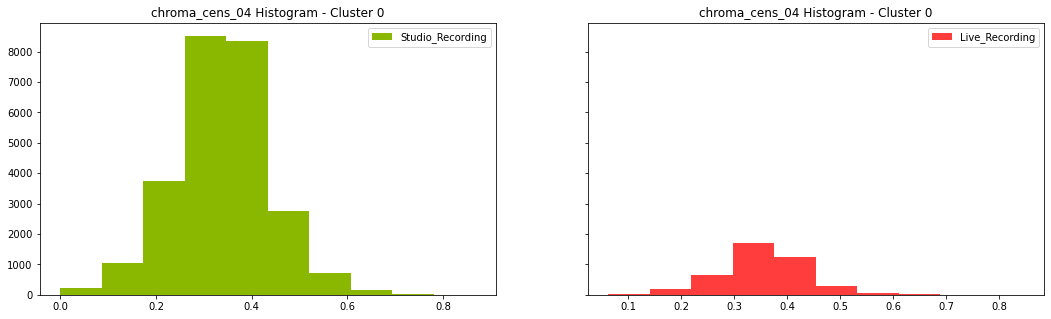

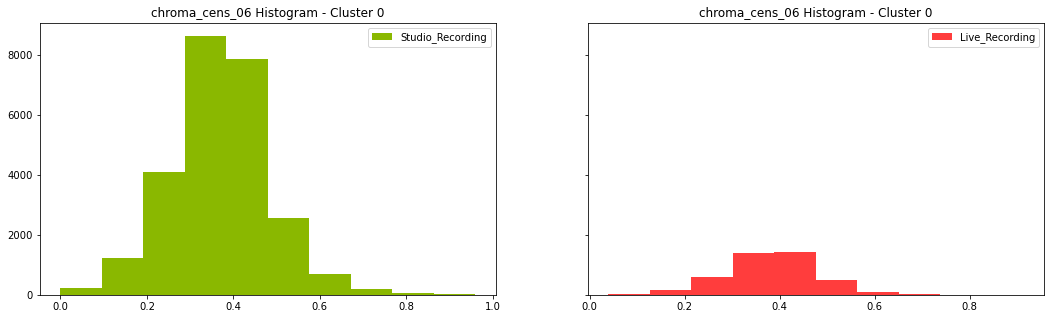

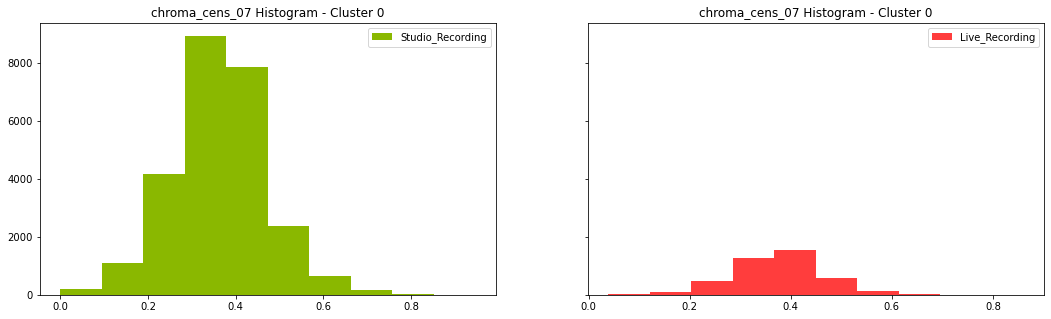

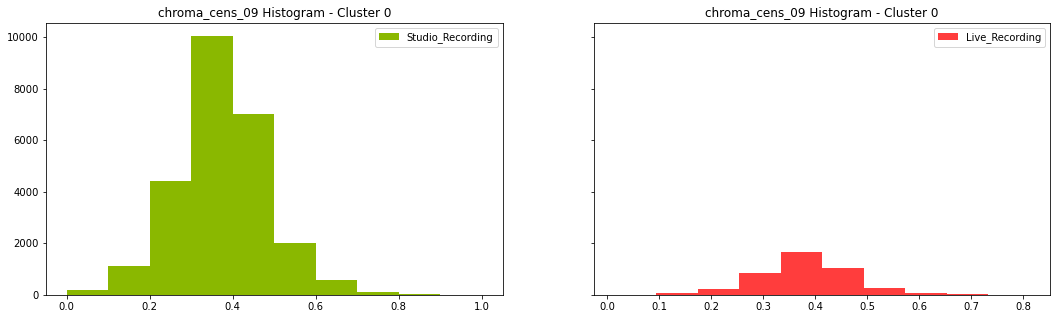

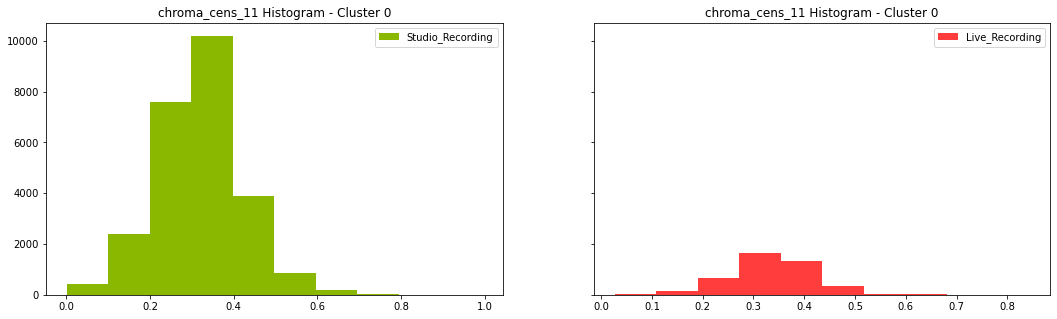

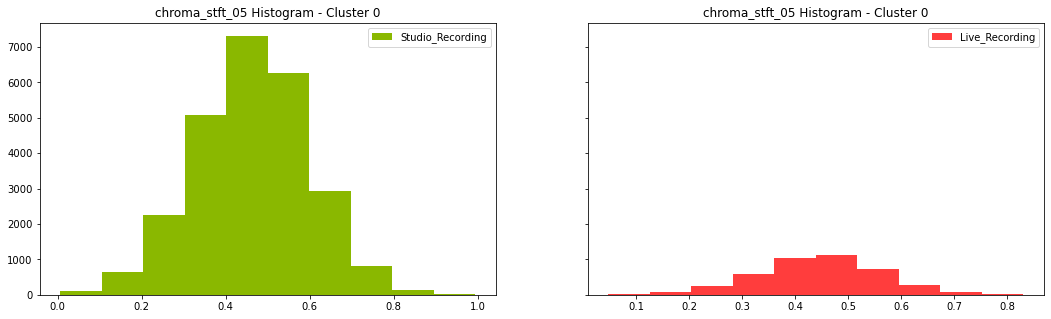

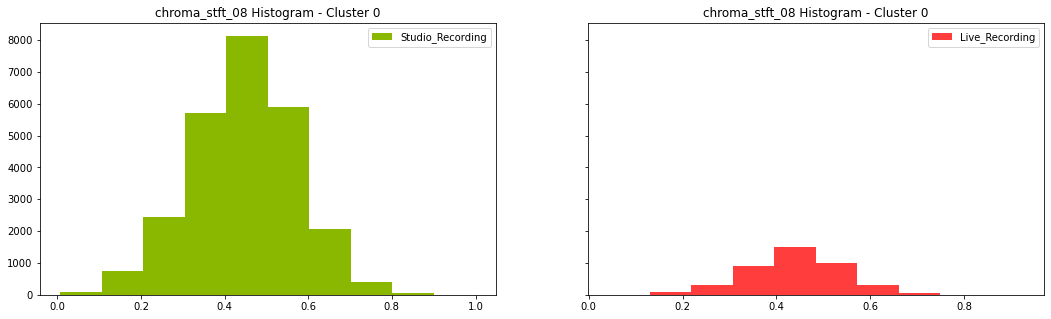

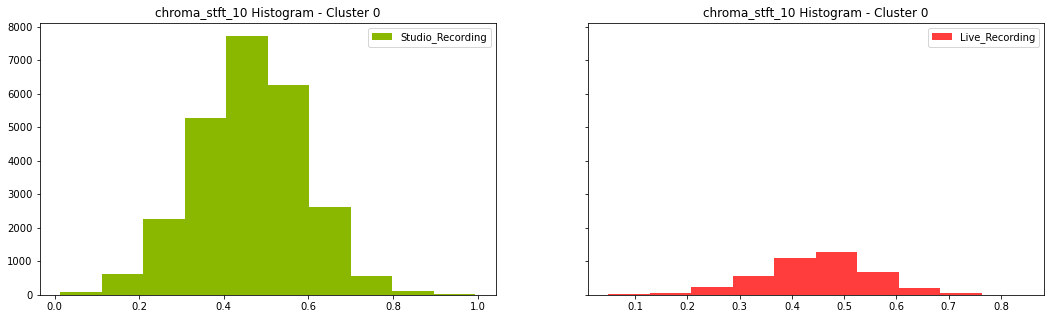

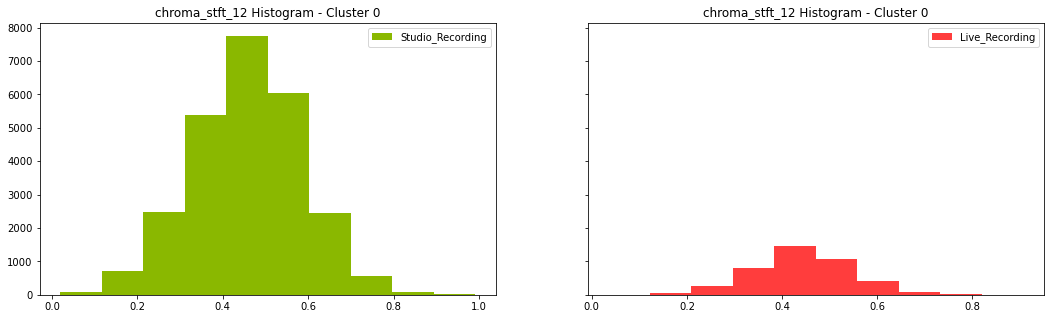

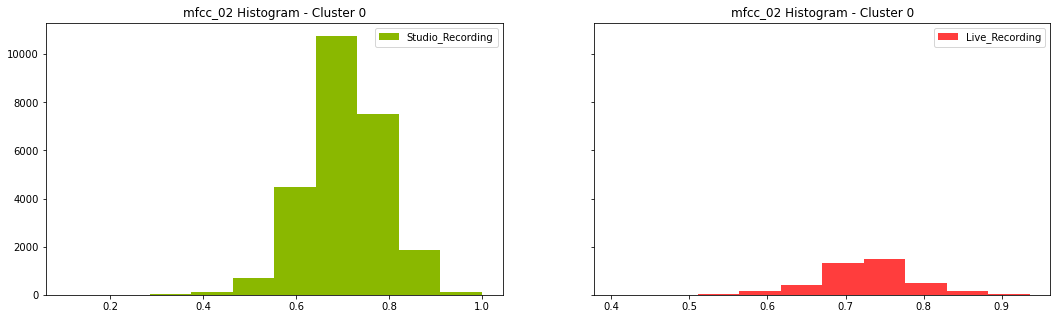

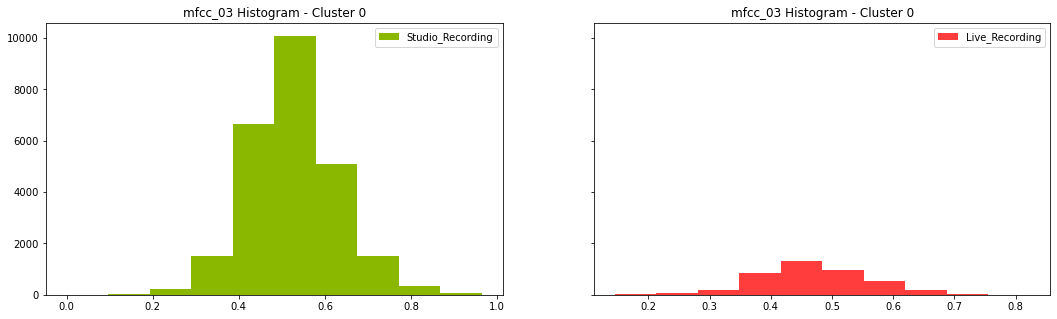

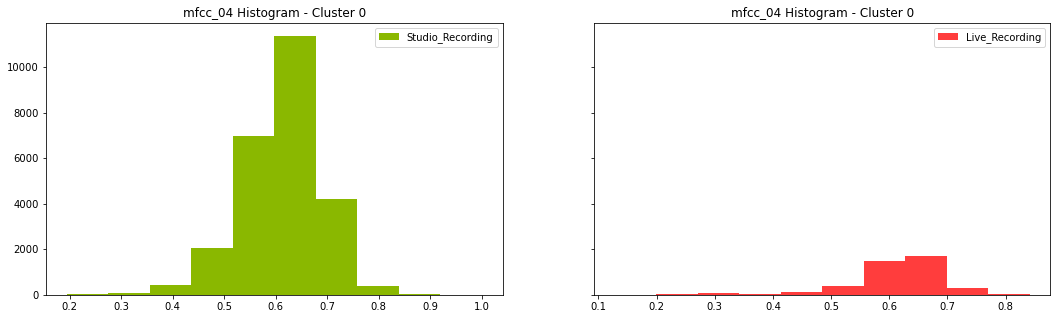

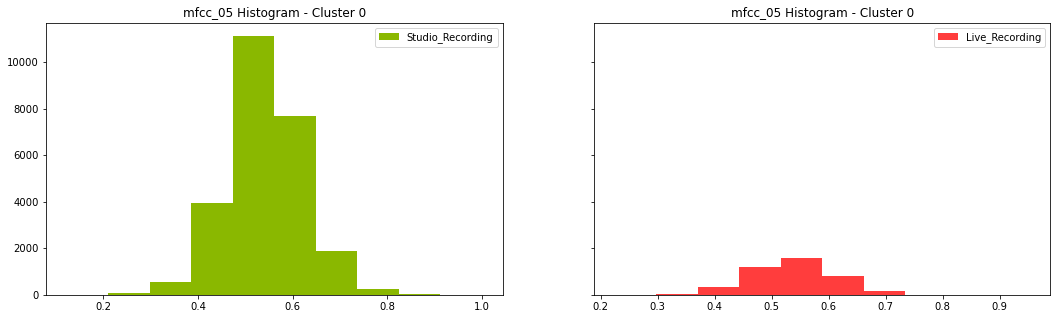

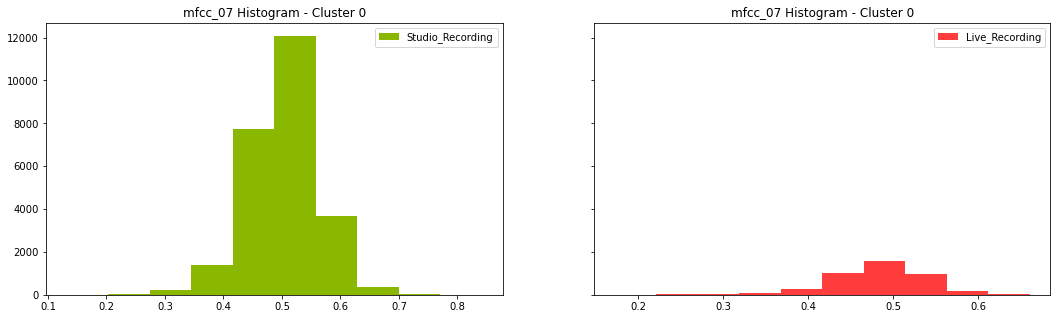

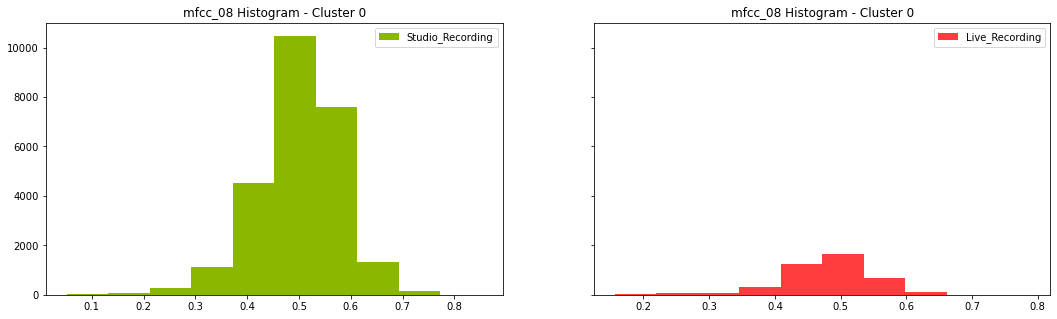

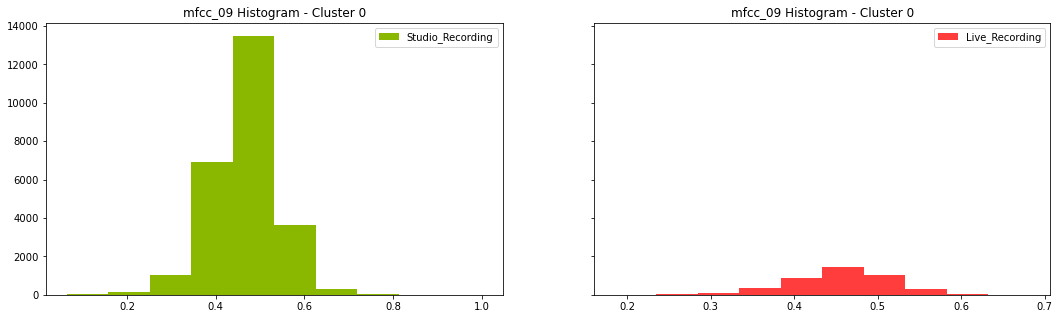

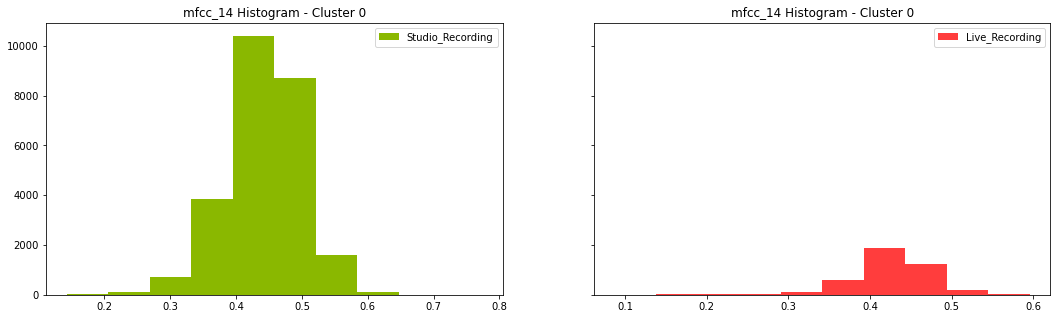

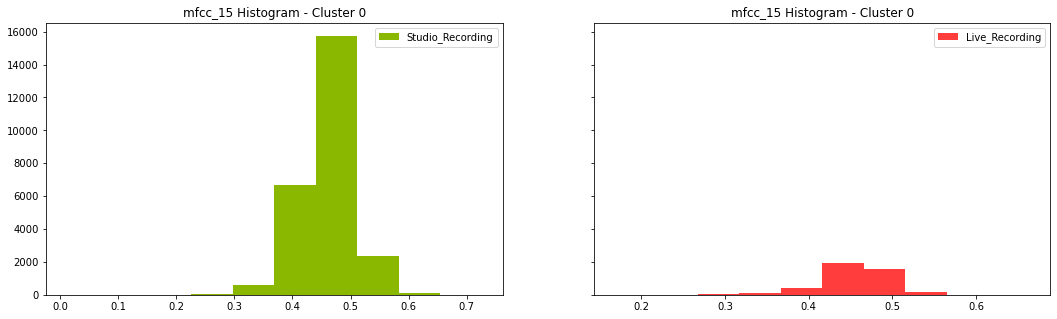

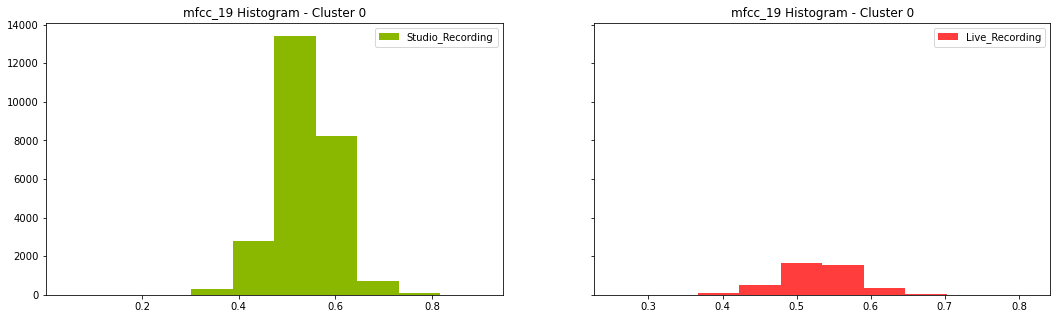

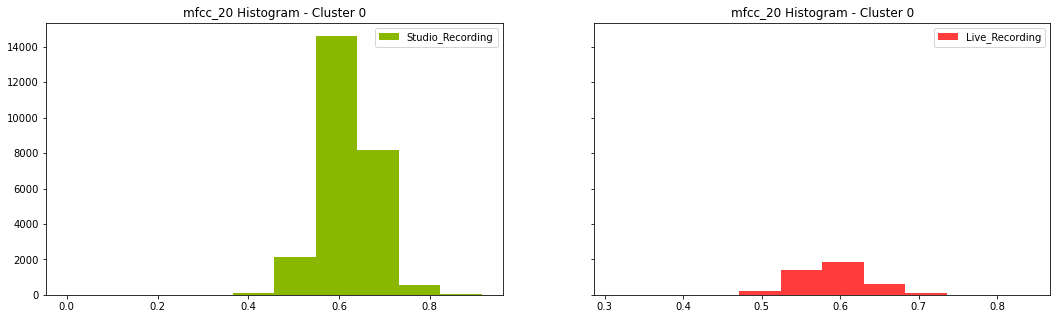

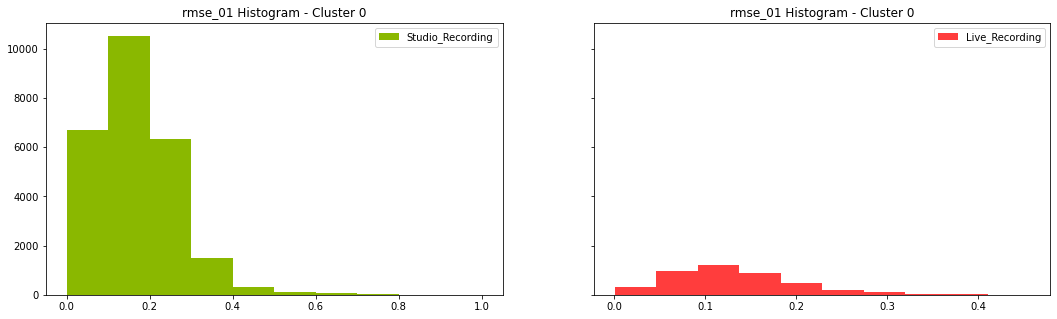

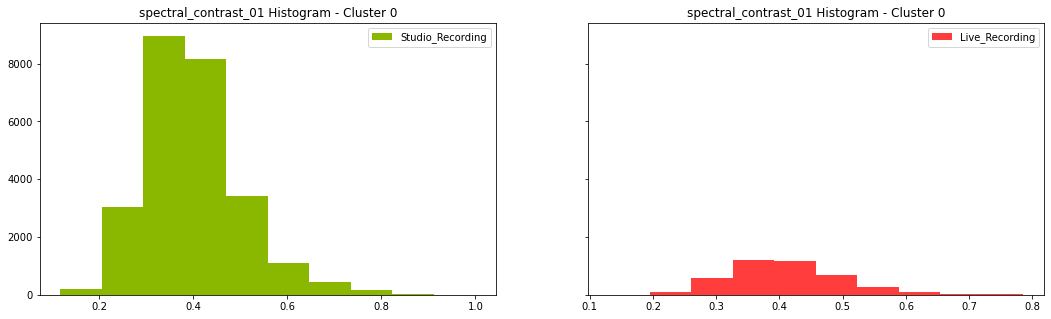

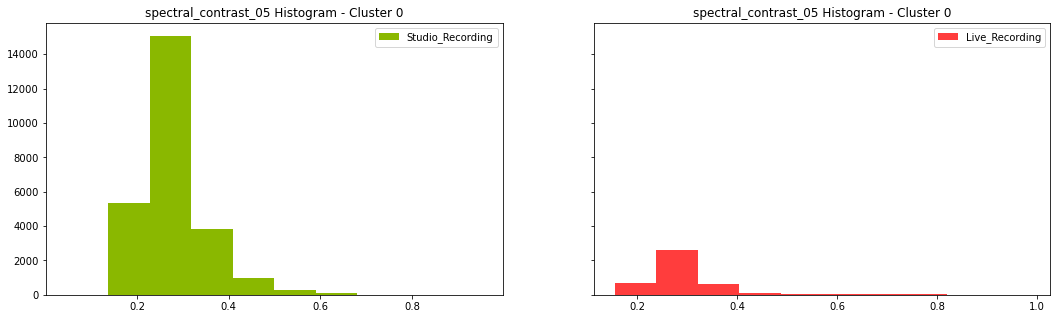

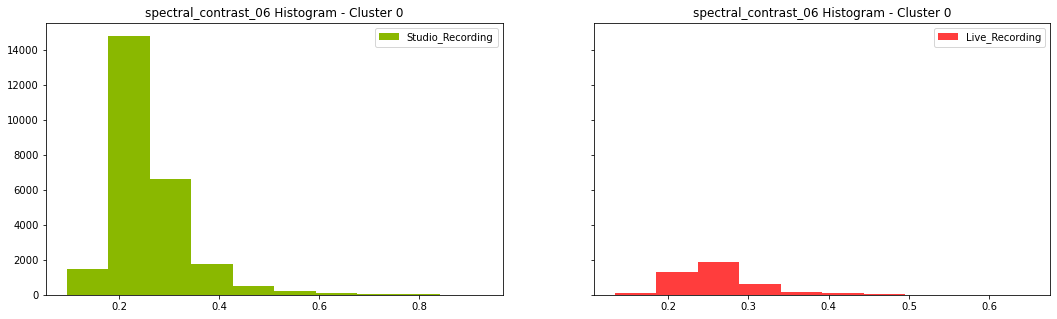

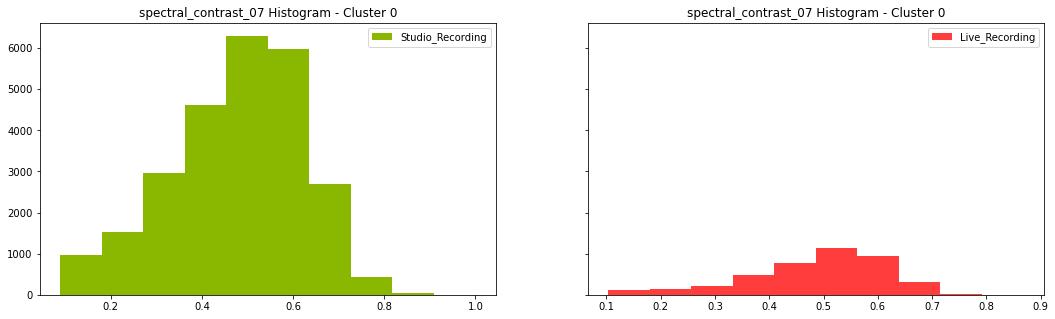

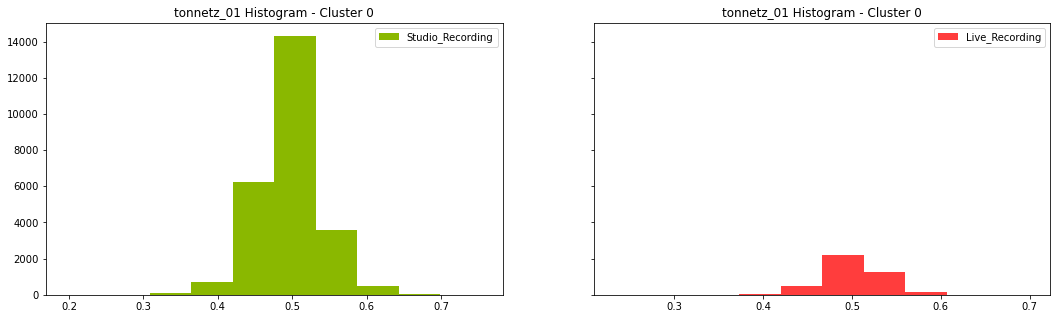

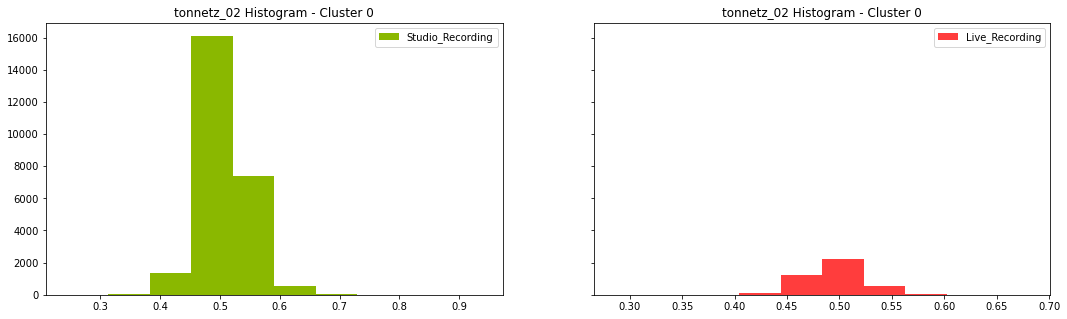

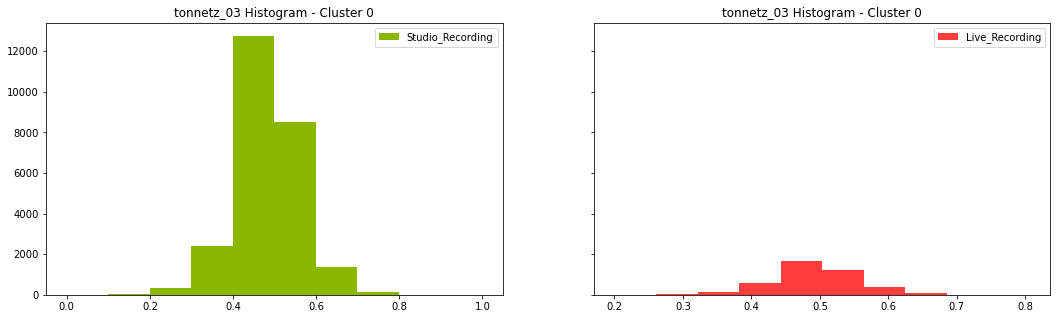

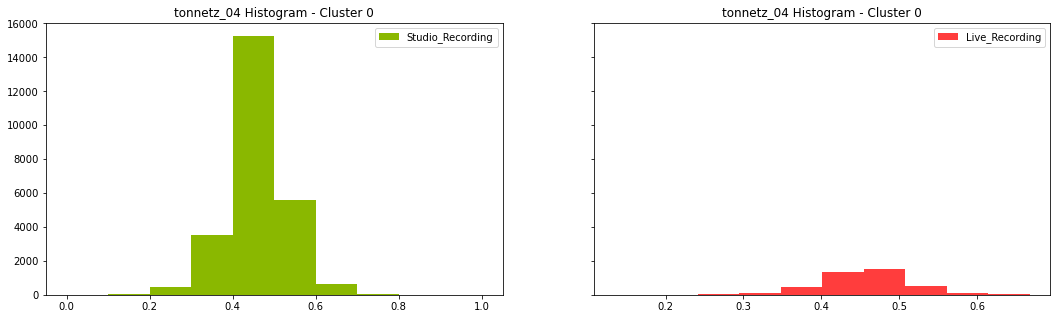

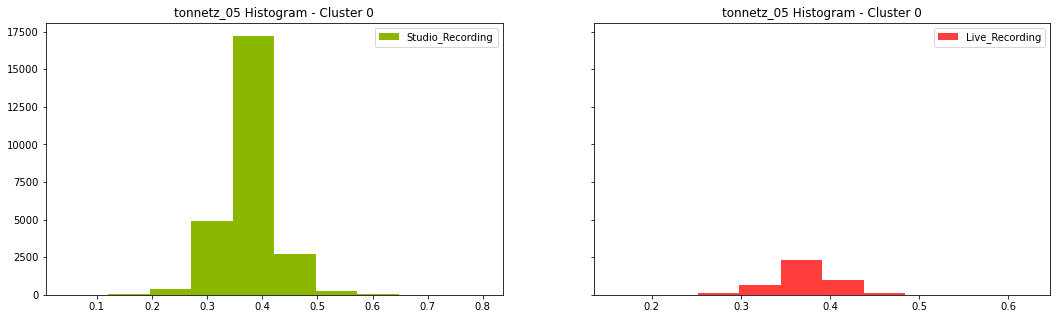

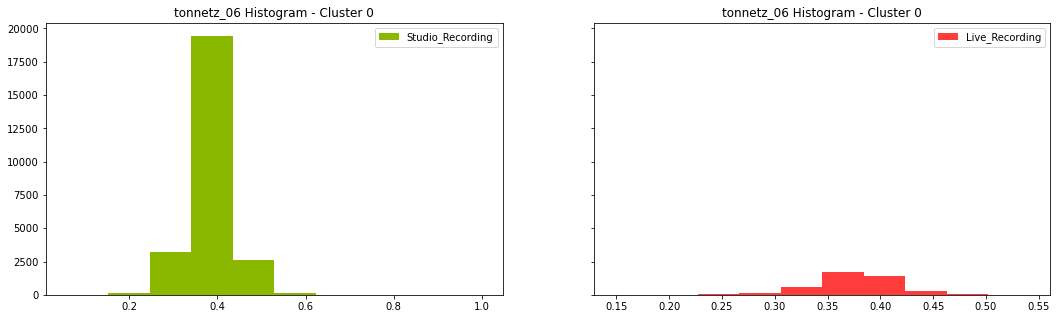

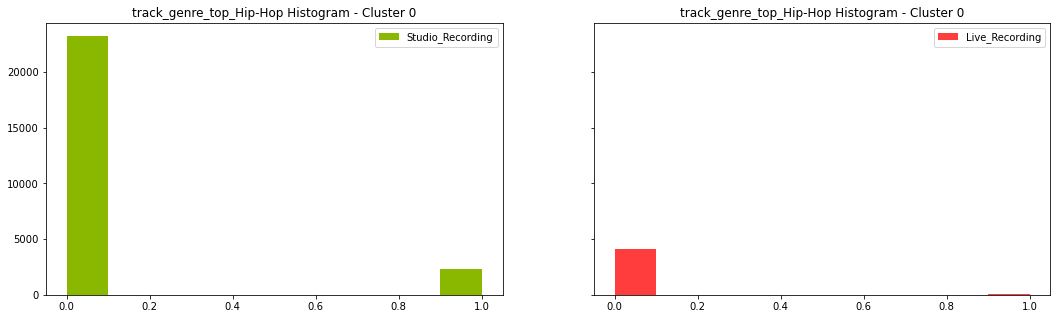

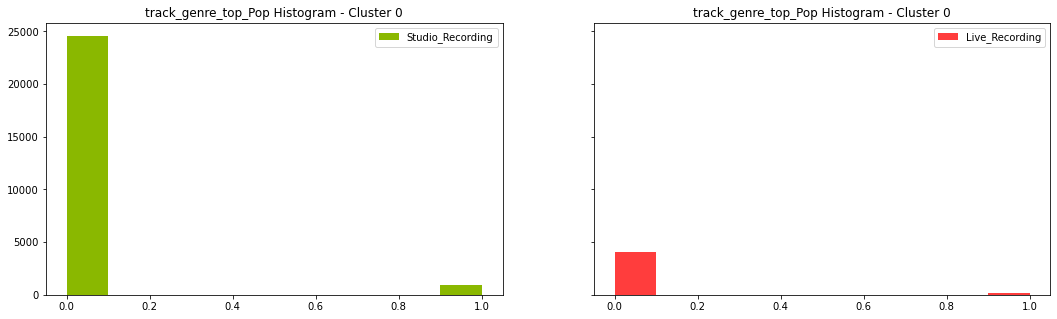

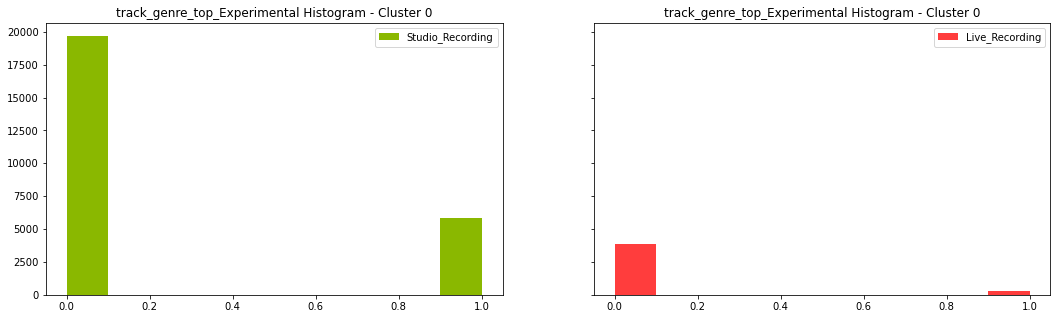

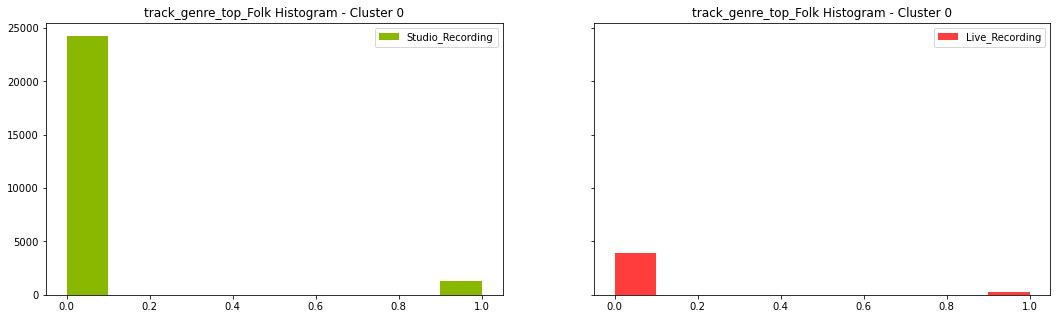

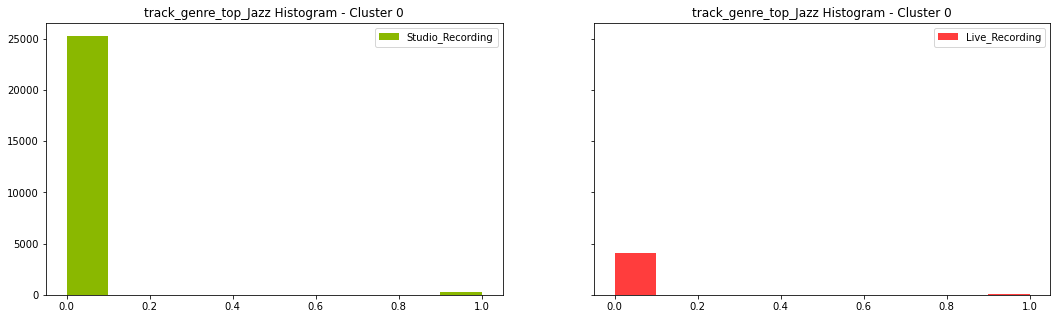

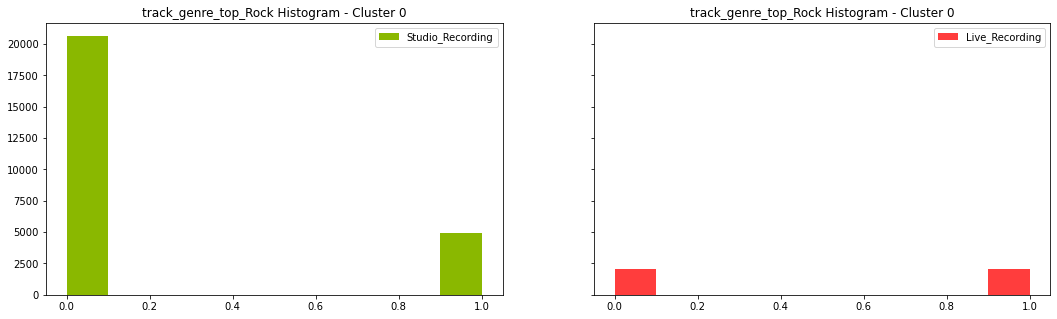

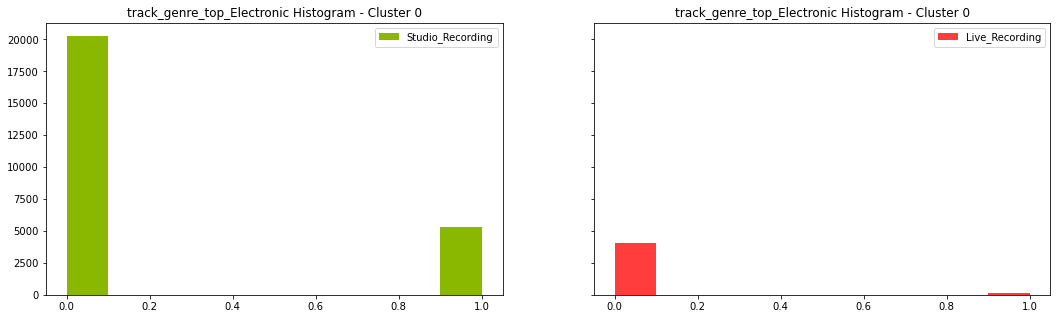

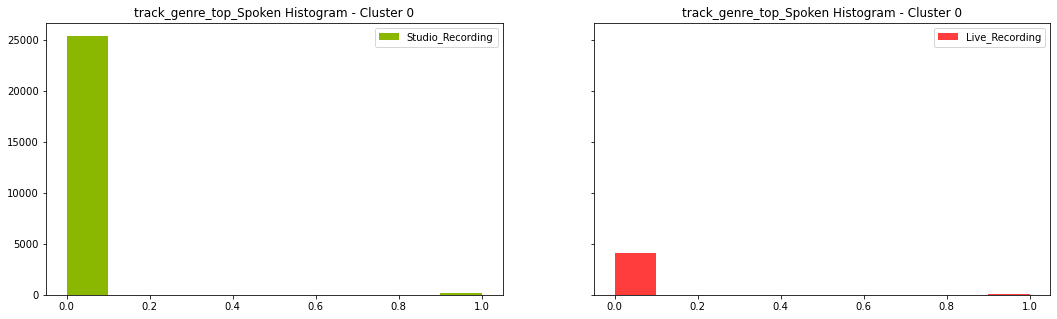

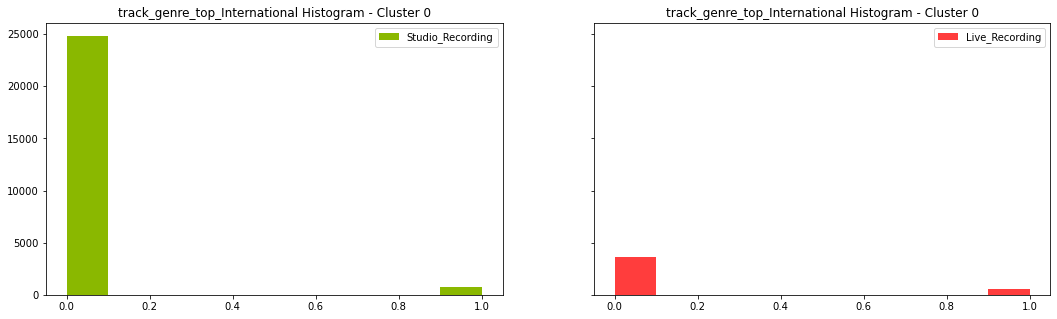

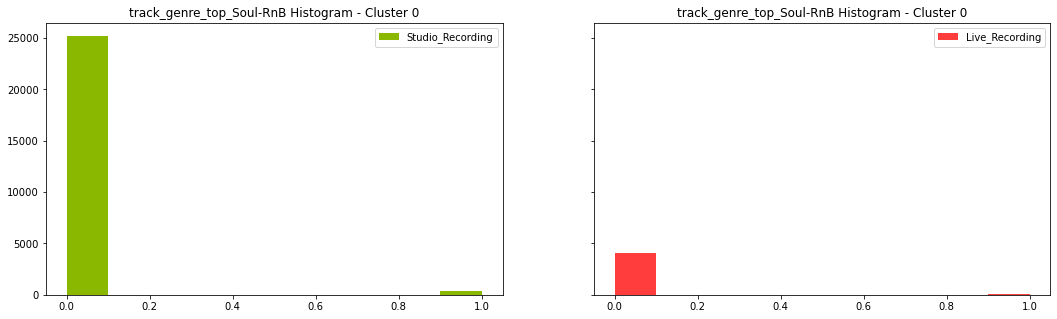

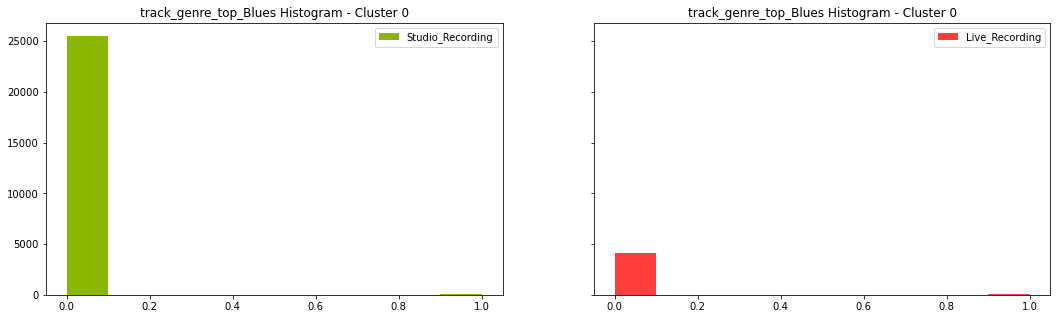

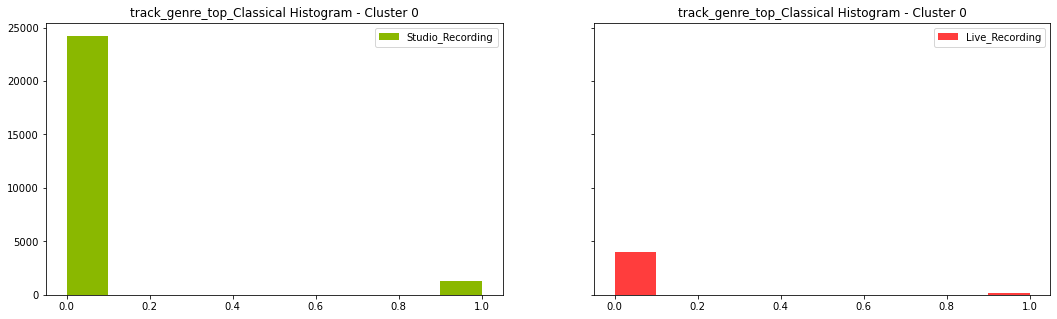

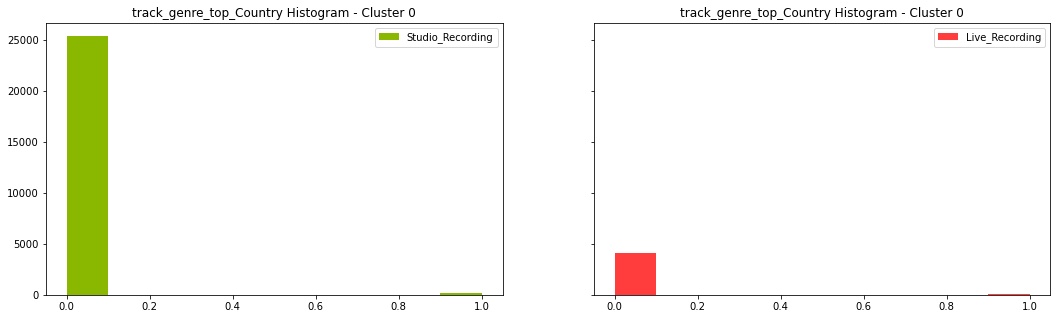

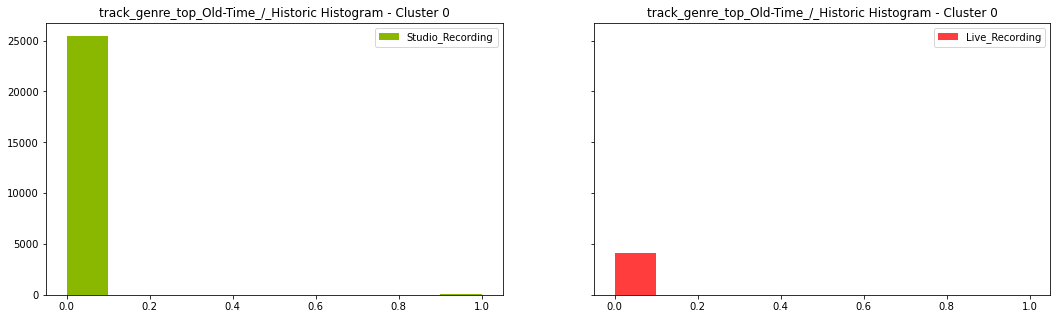

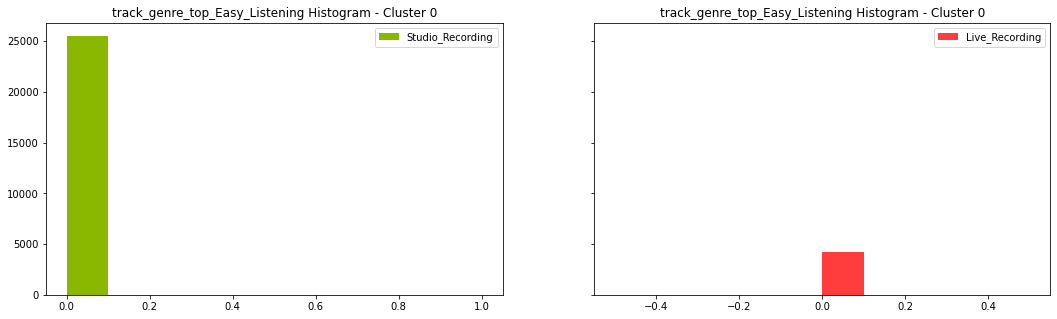

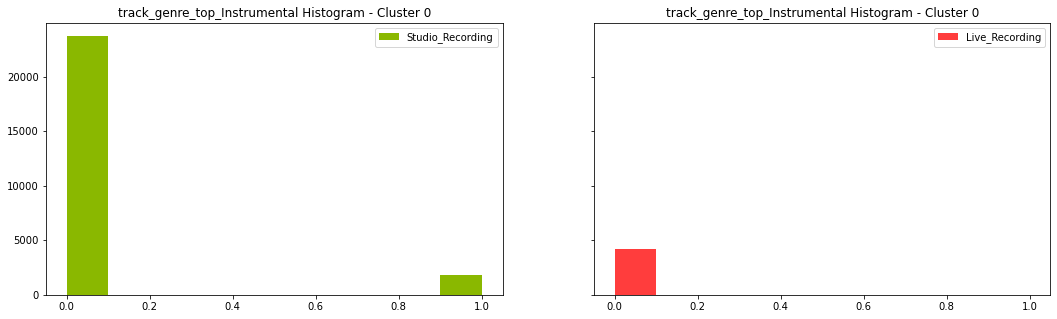

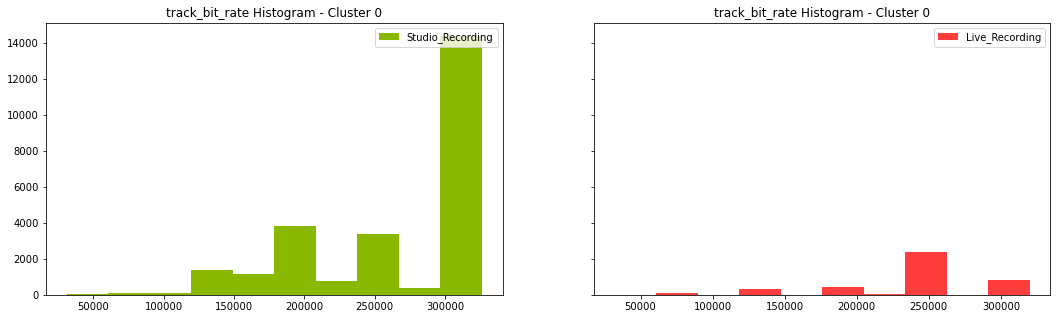

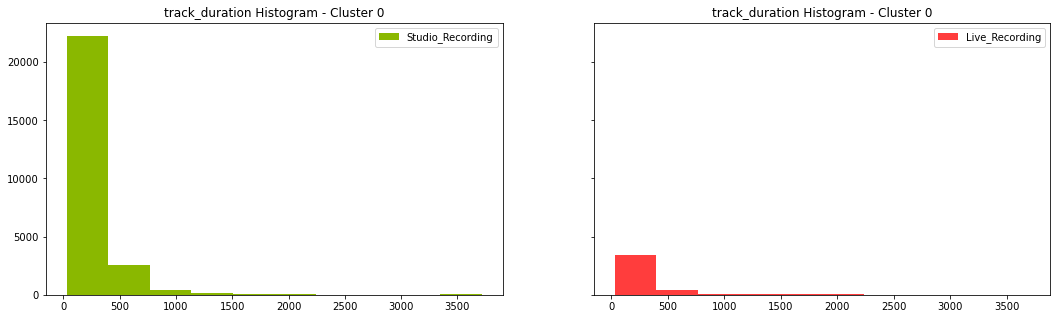

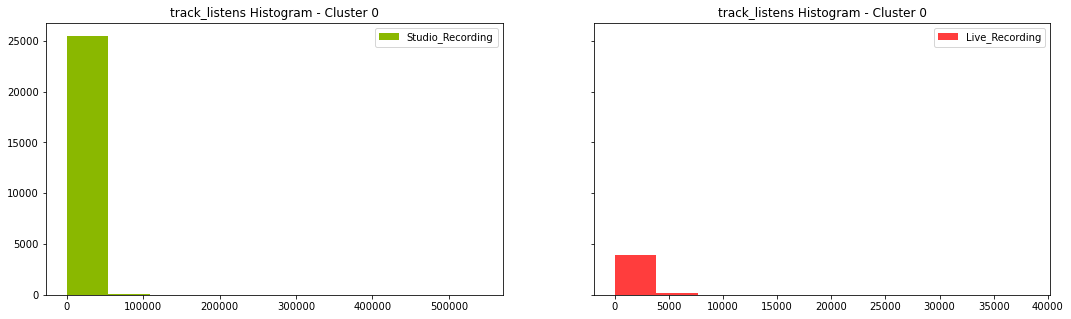

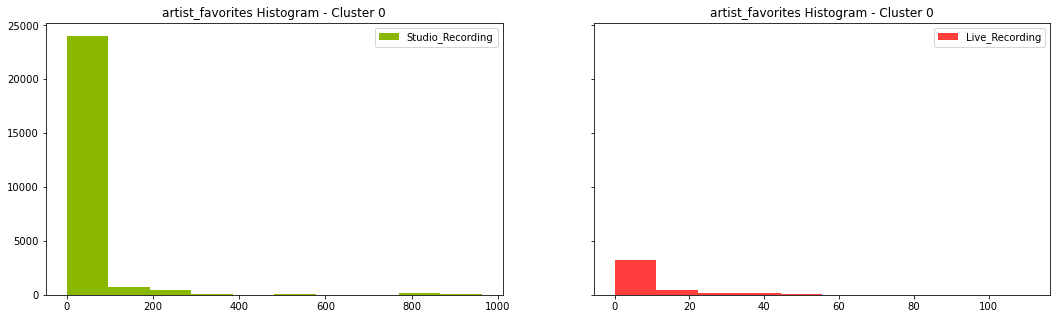

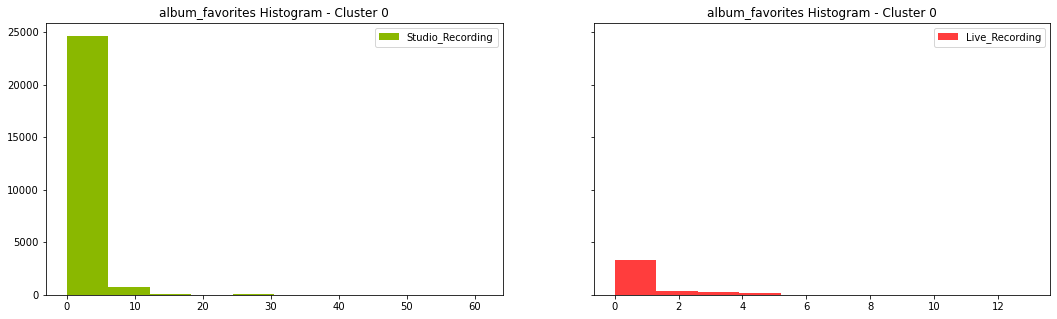

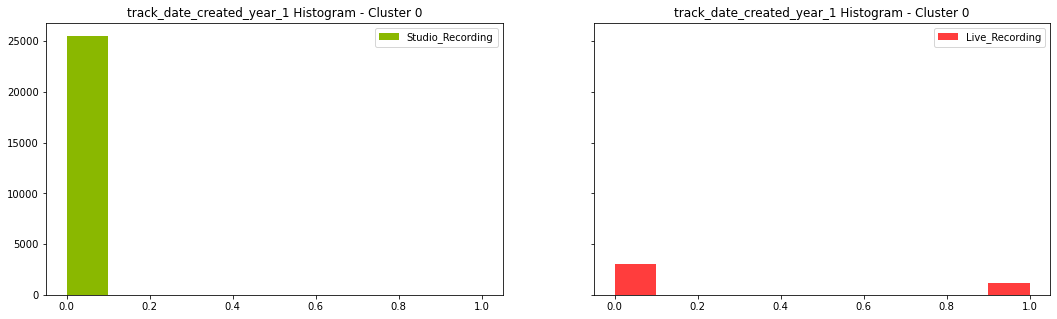

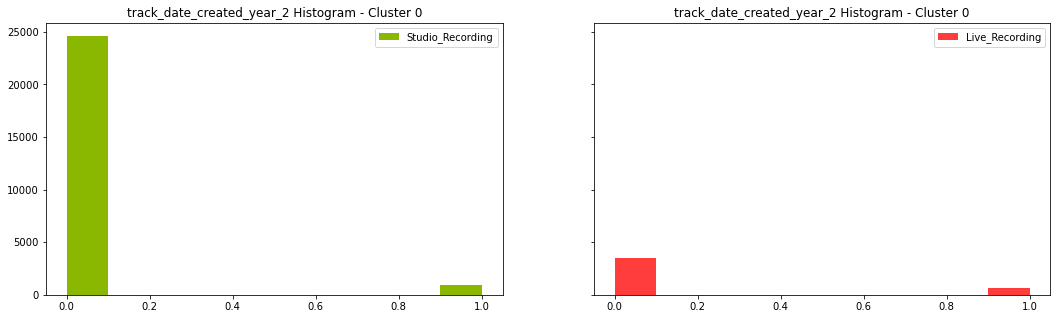

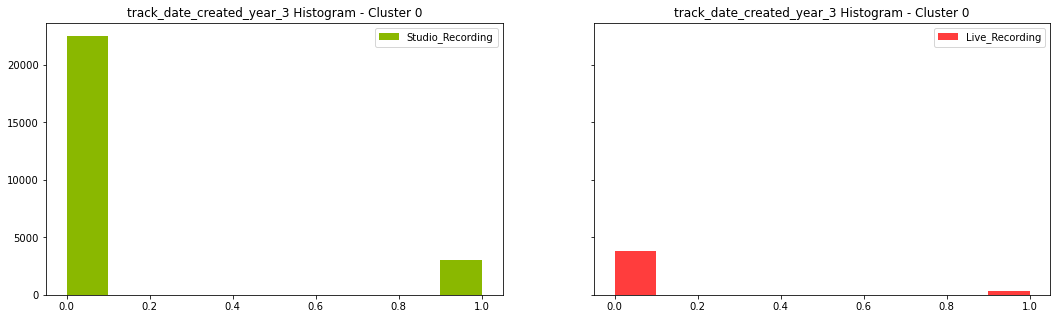

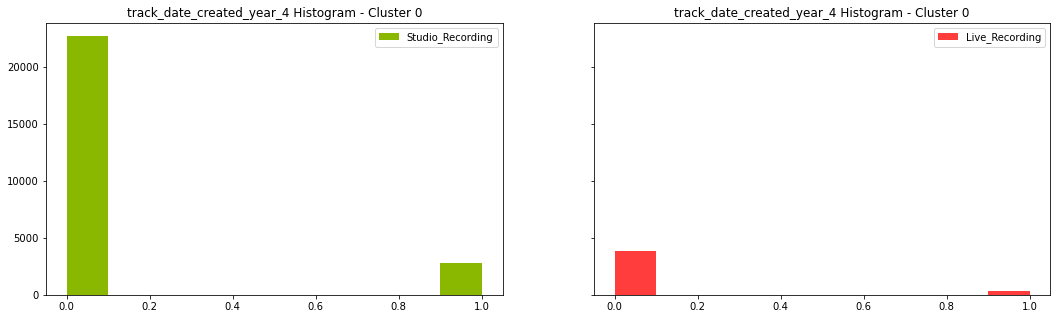

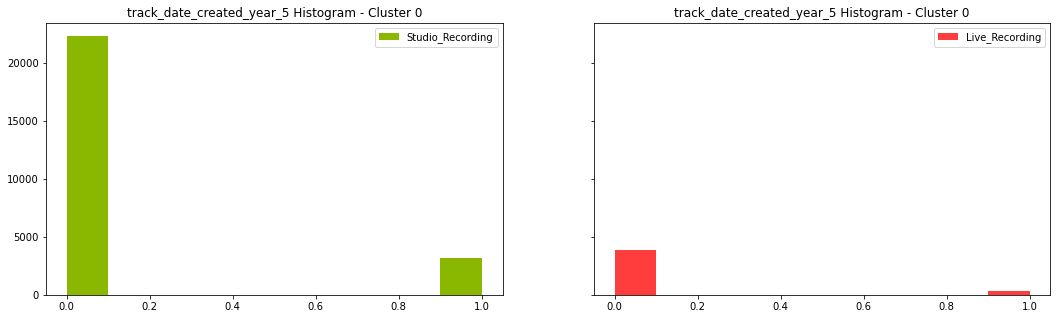

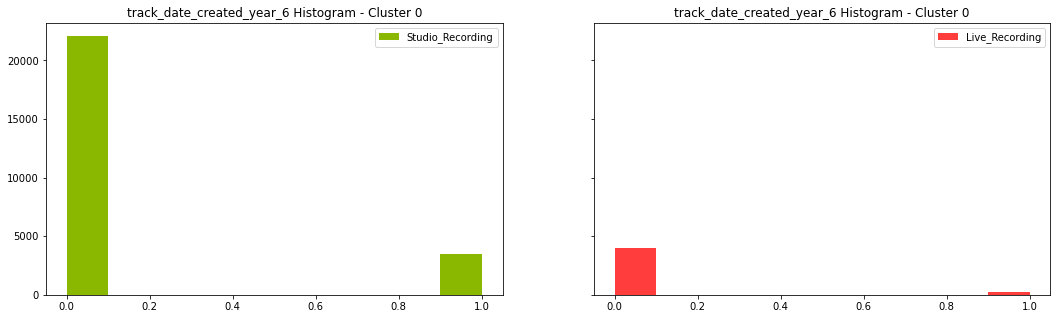

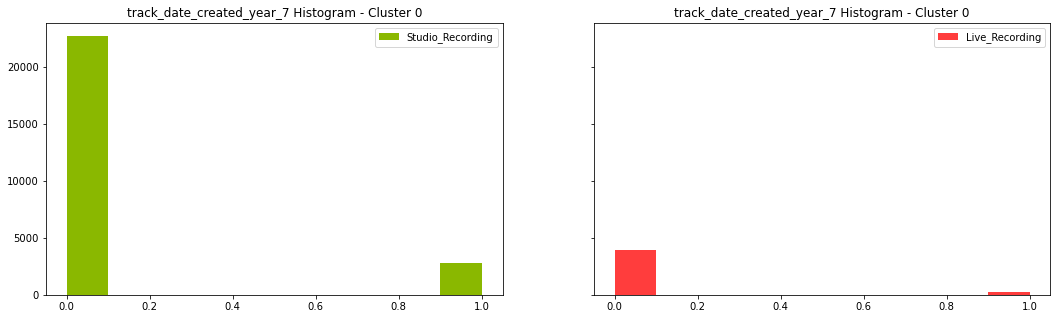

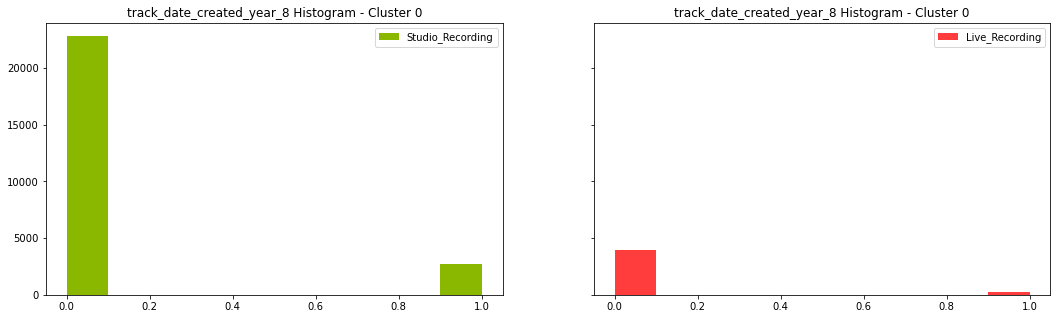

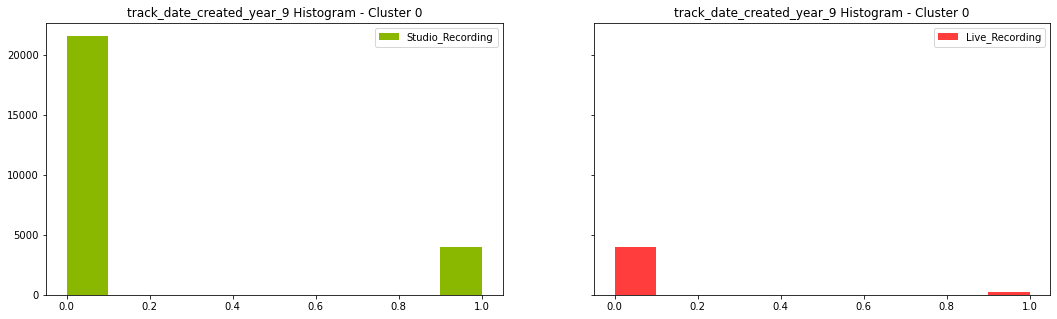

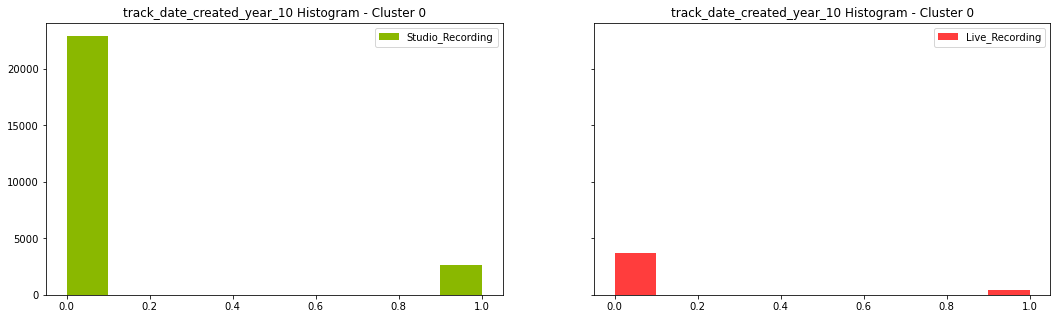

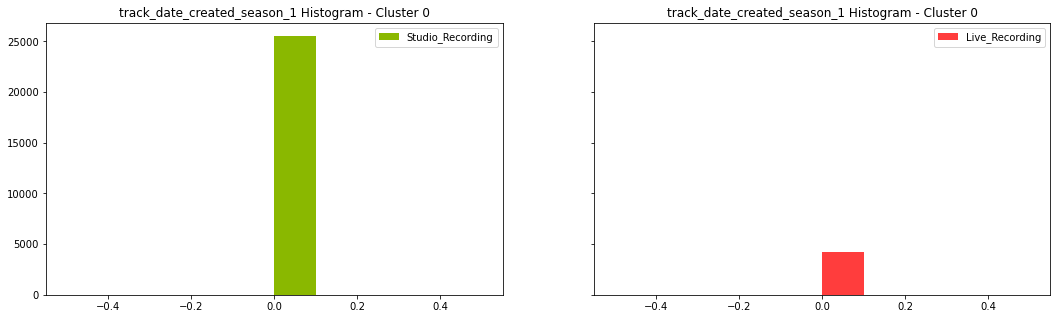

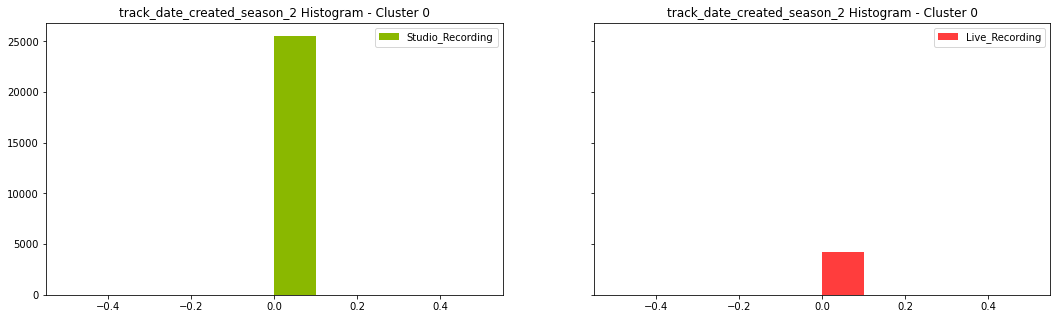

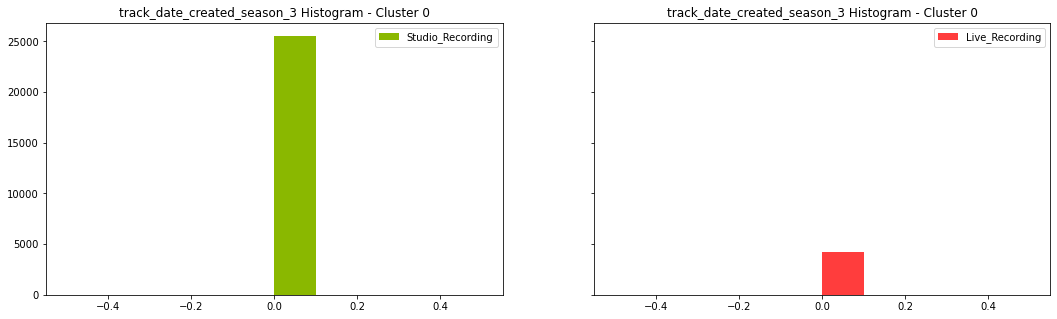

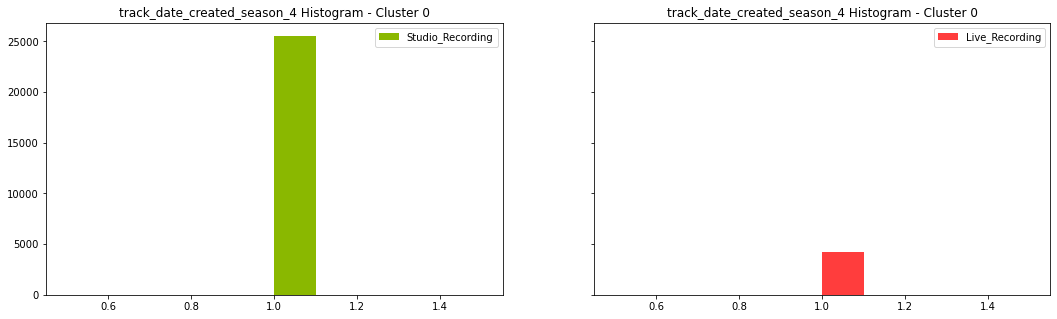

------------------------------------------------------------------------------------------------------------------
Cluster 1



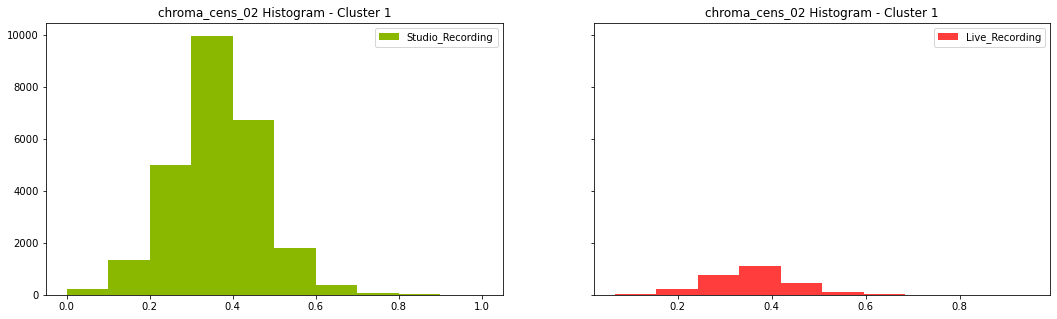

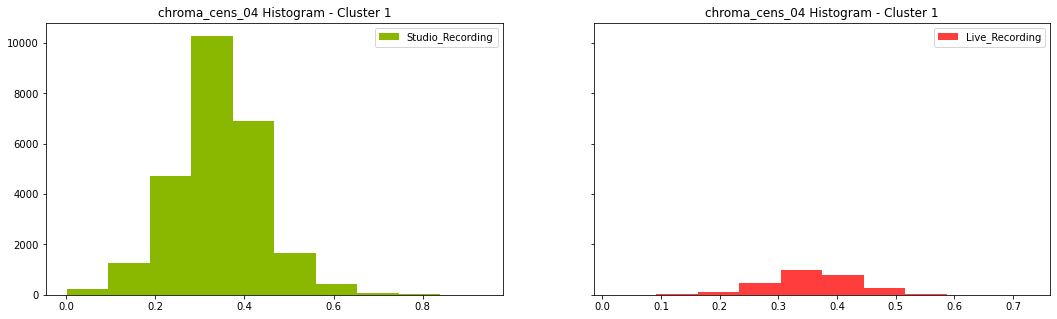

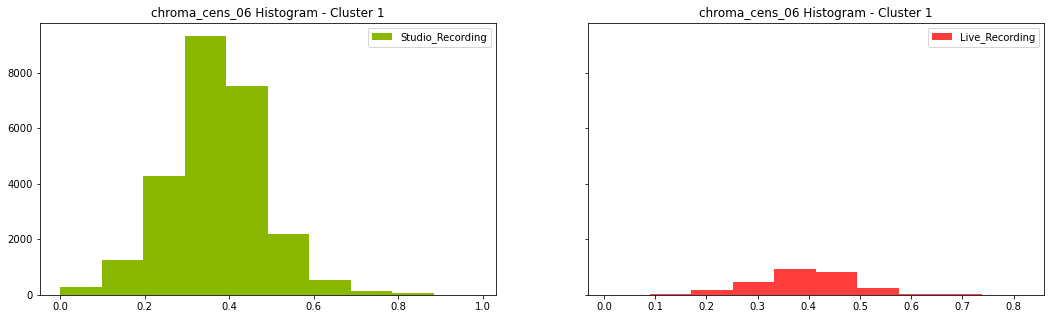

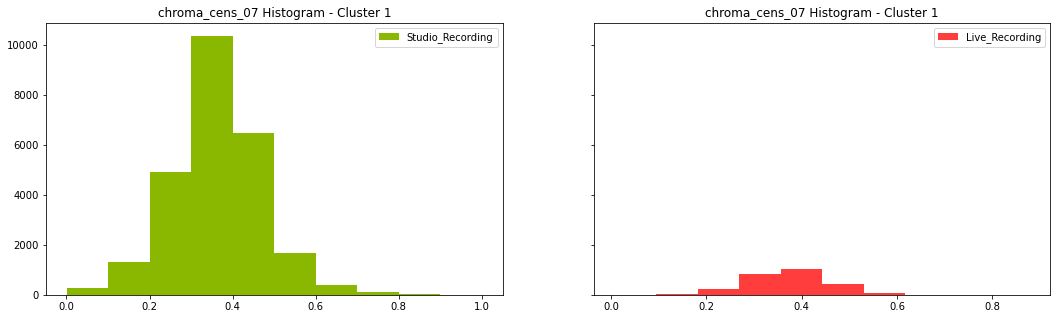

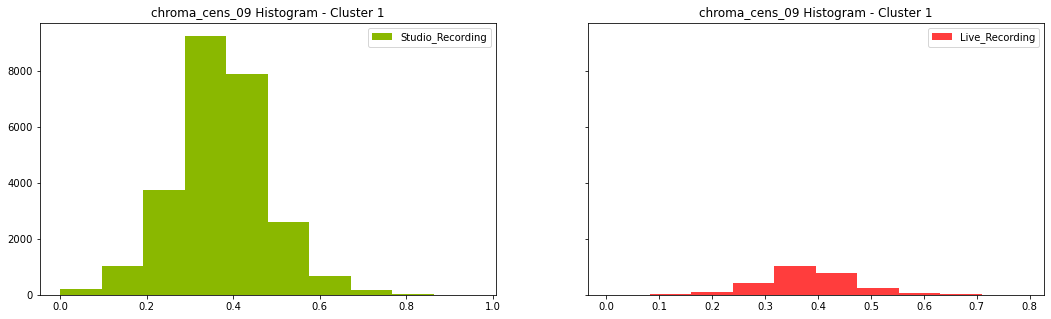

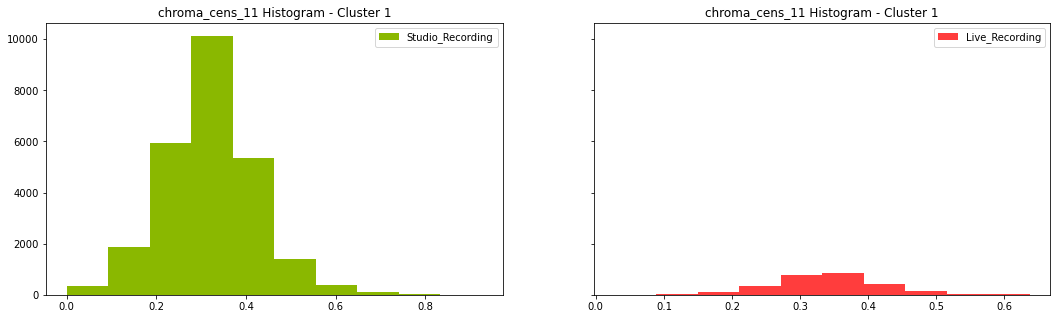

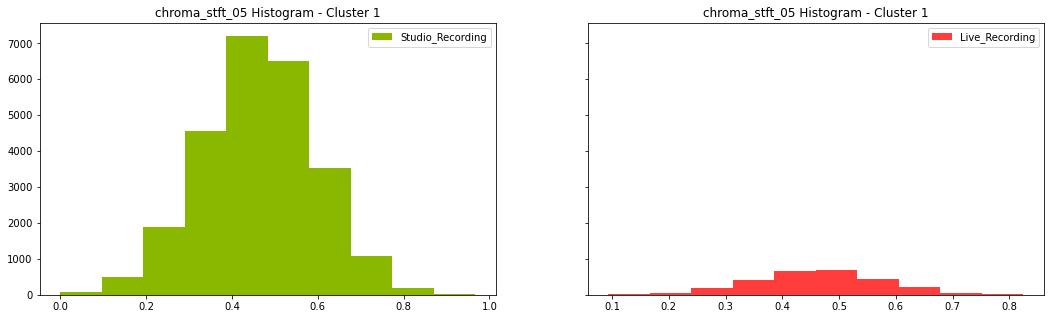

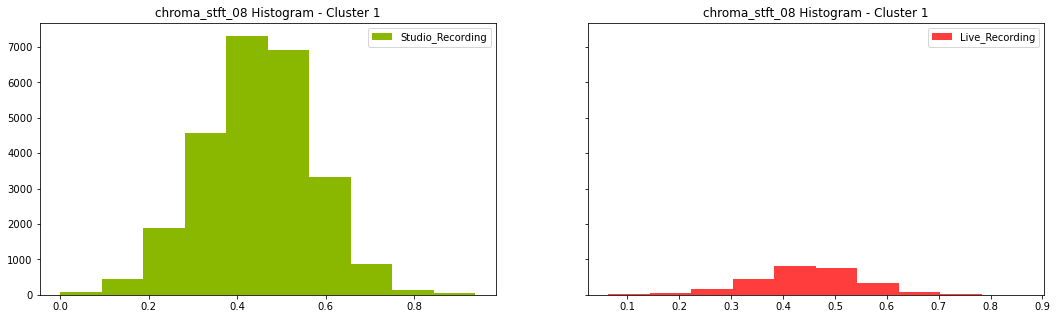

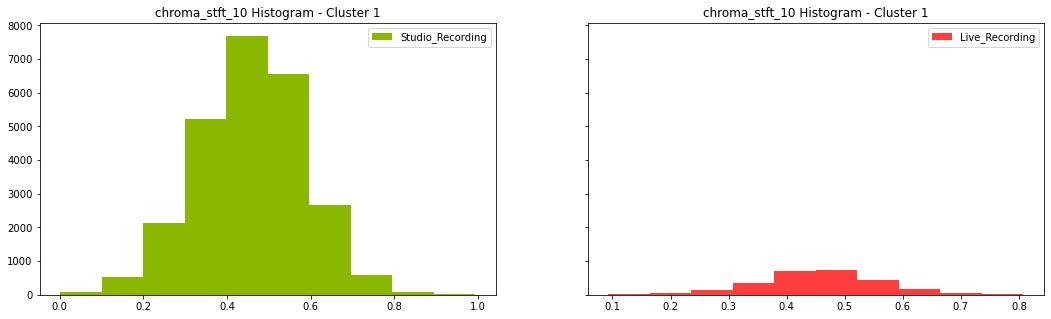

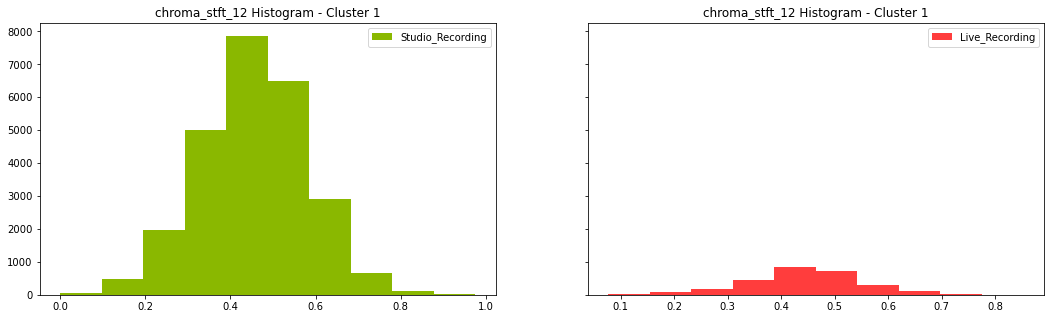

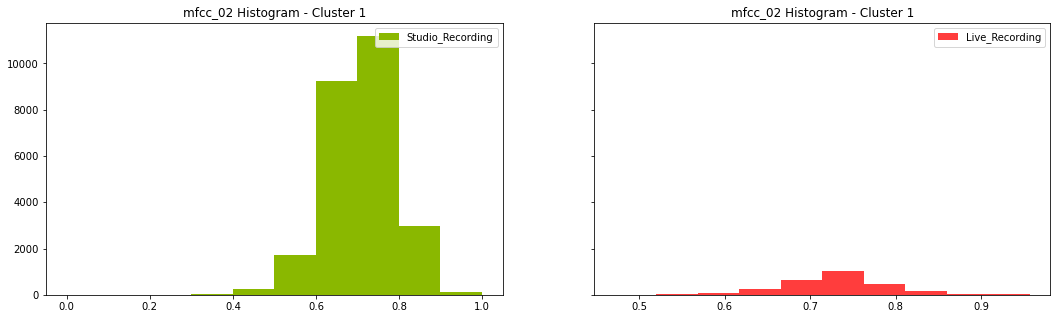

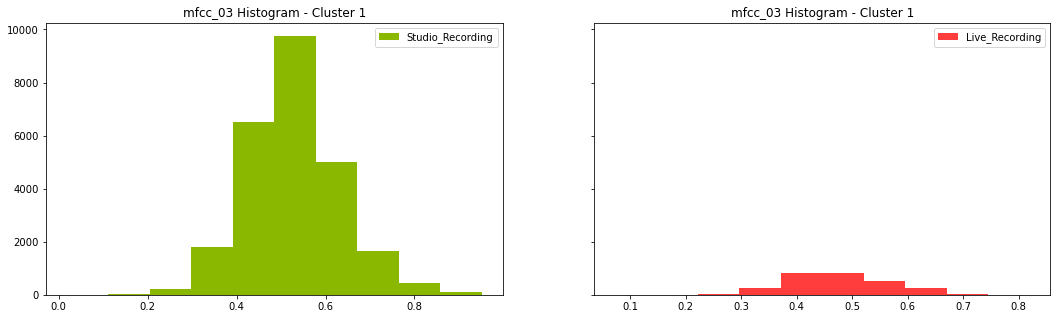

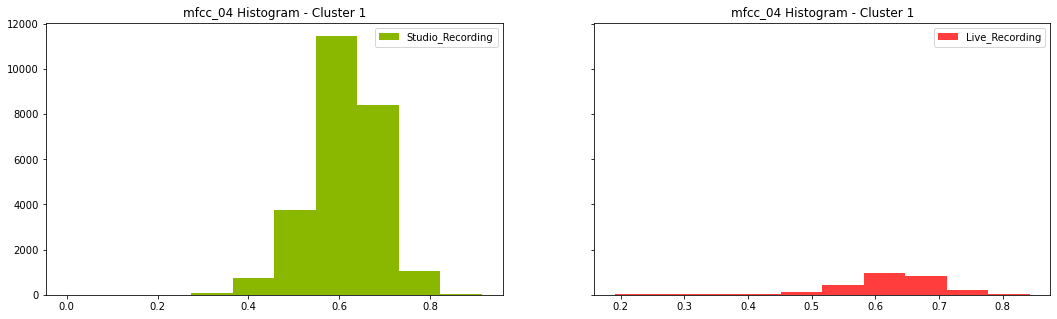

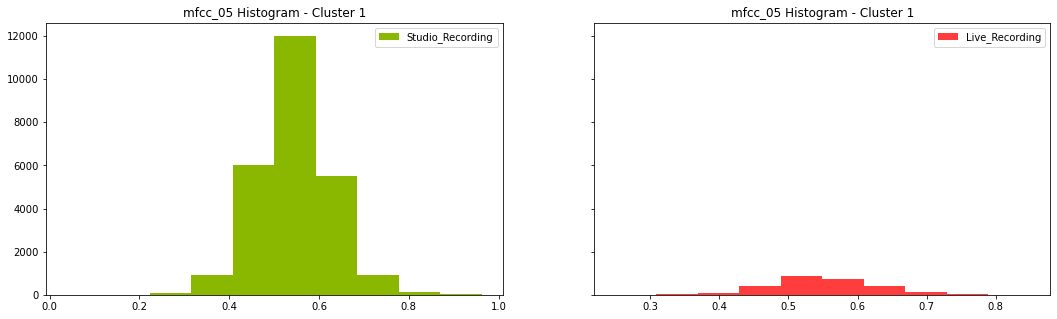

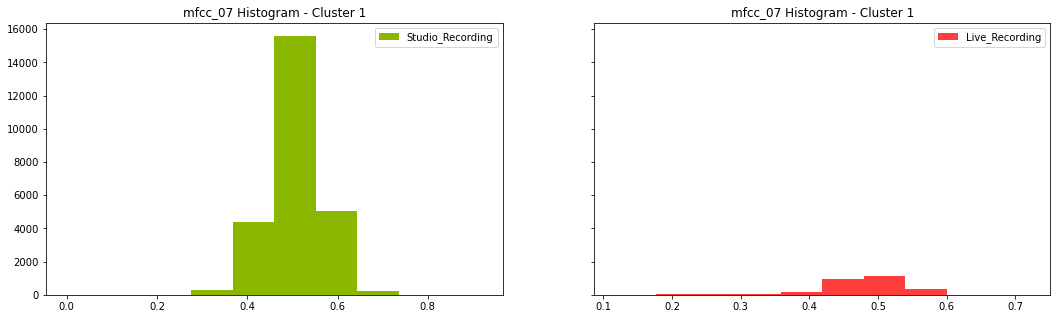

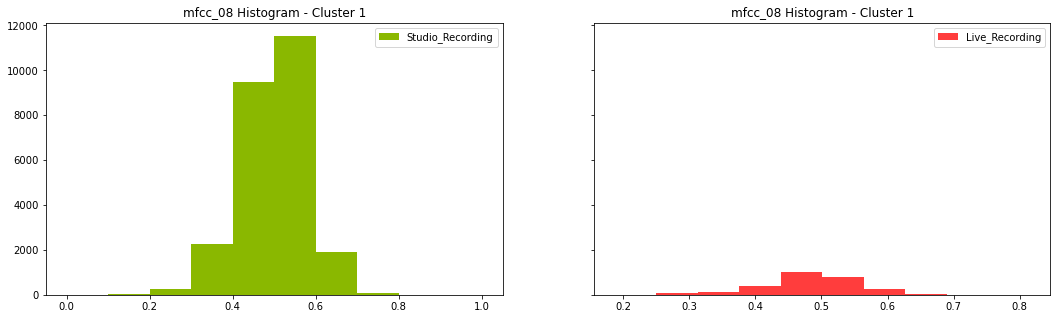

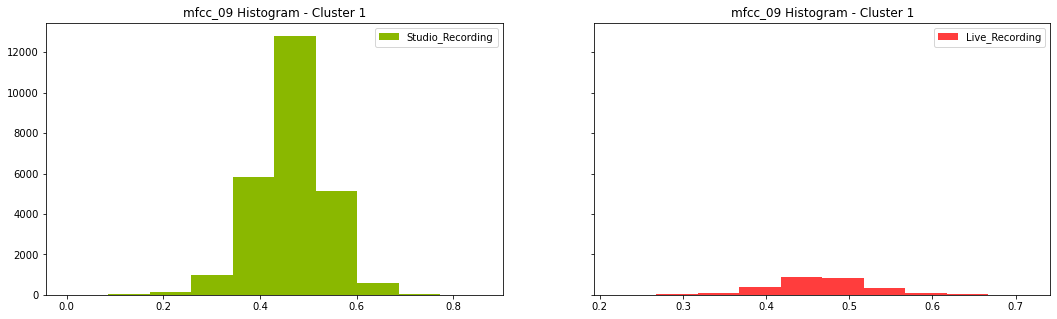

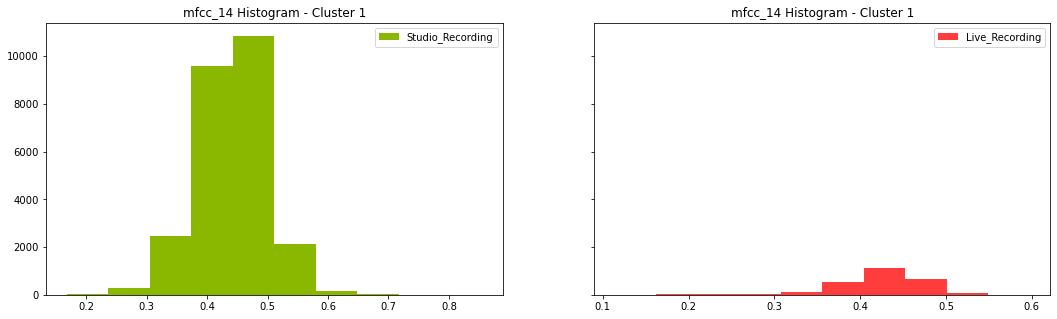

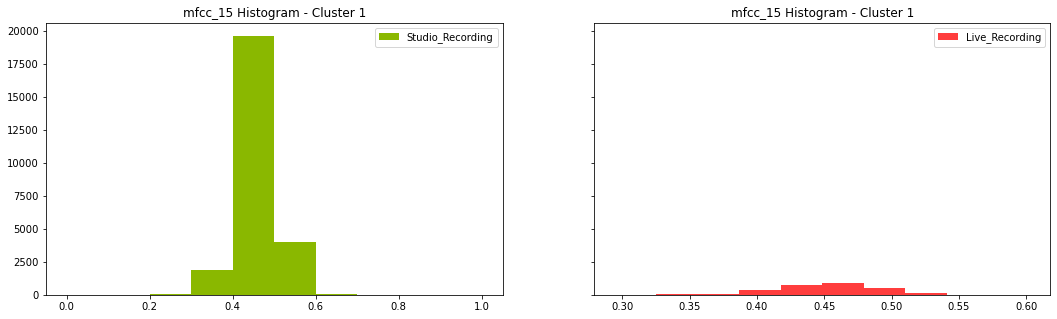

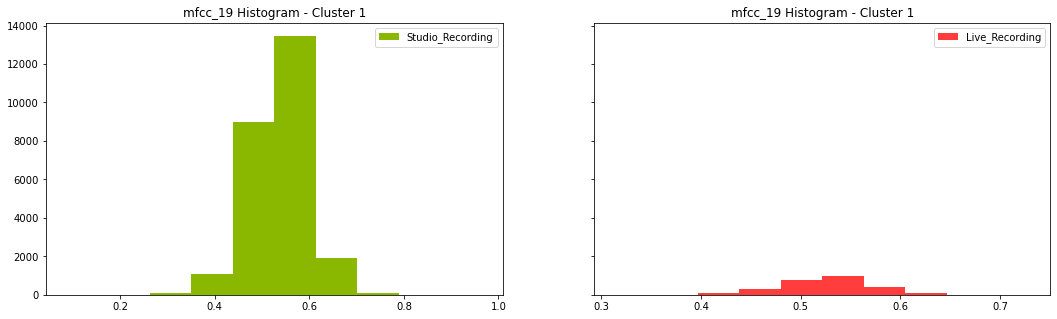

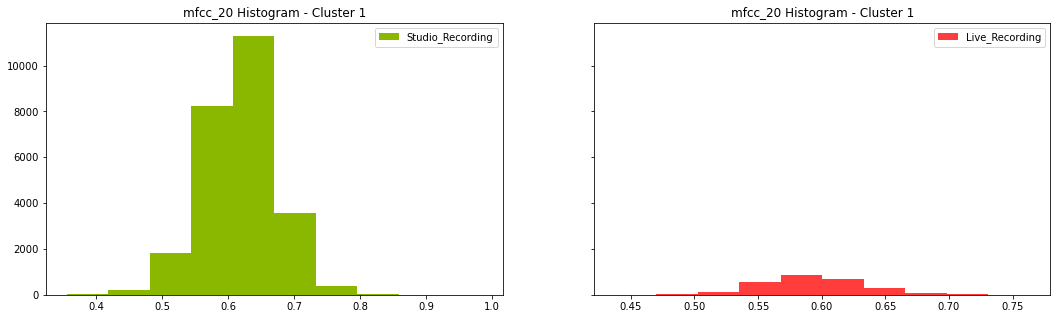

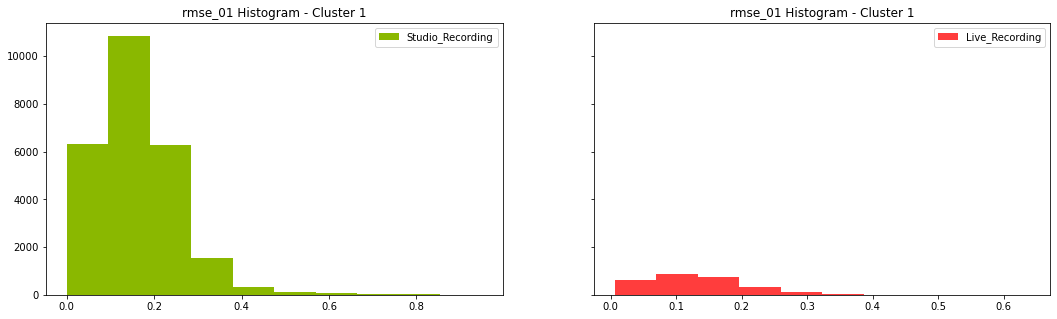

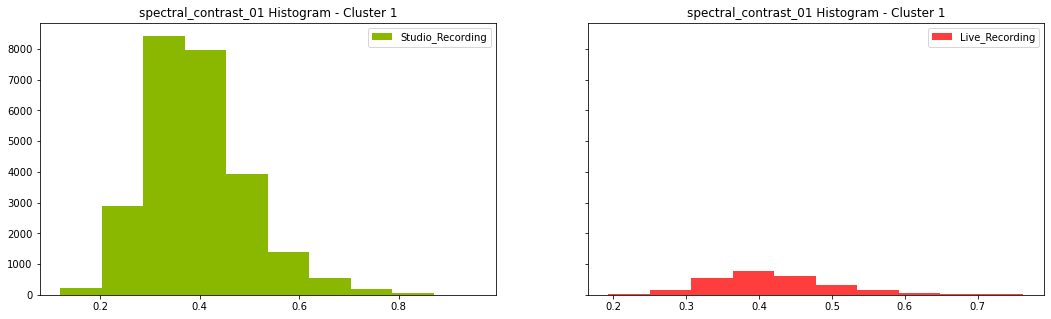

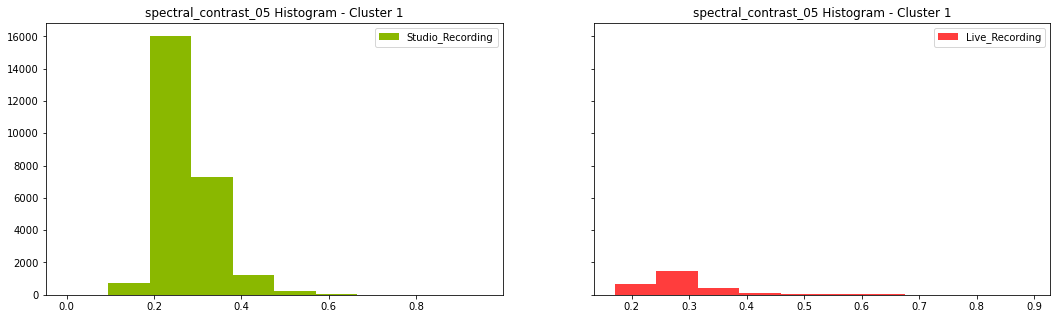

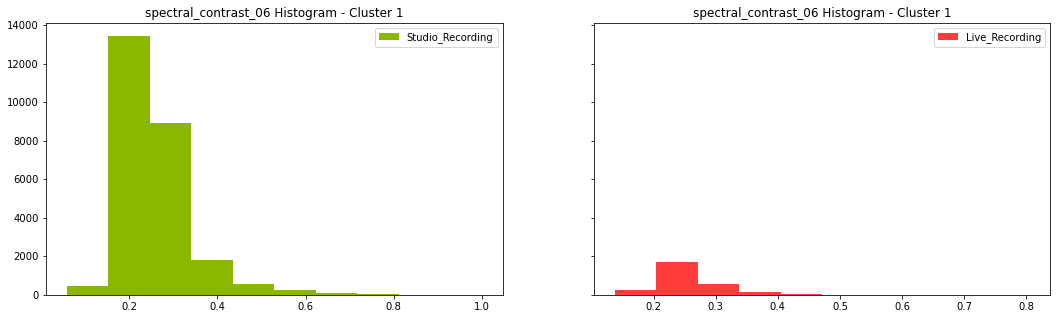

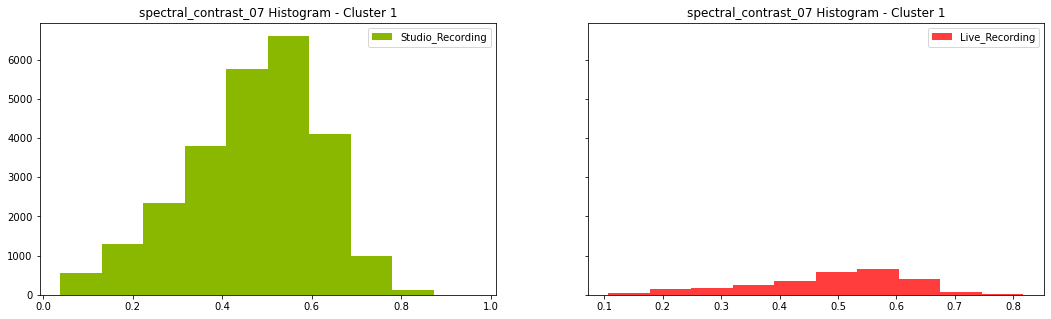

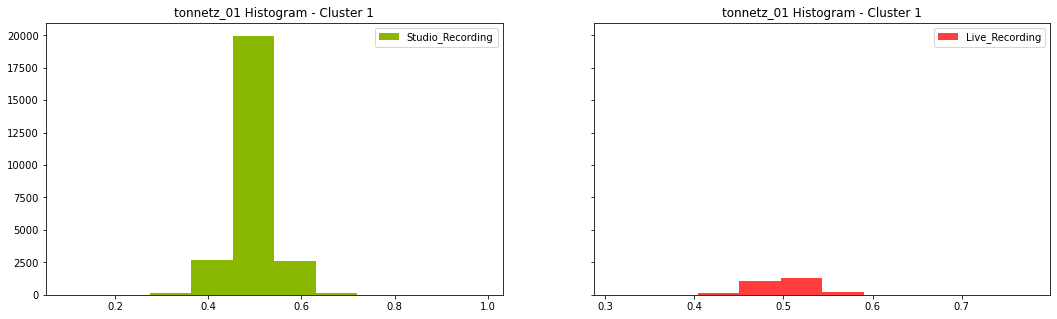

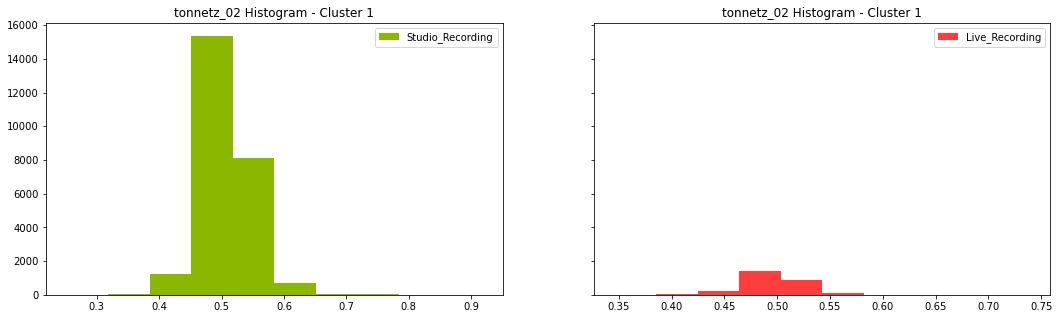

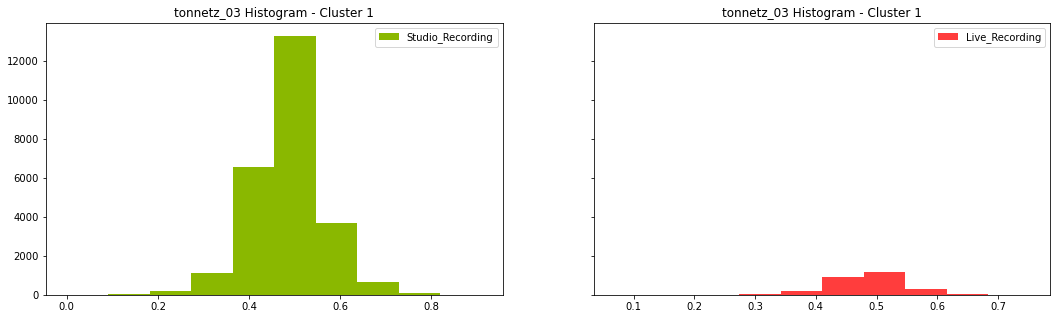

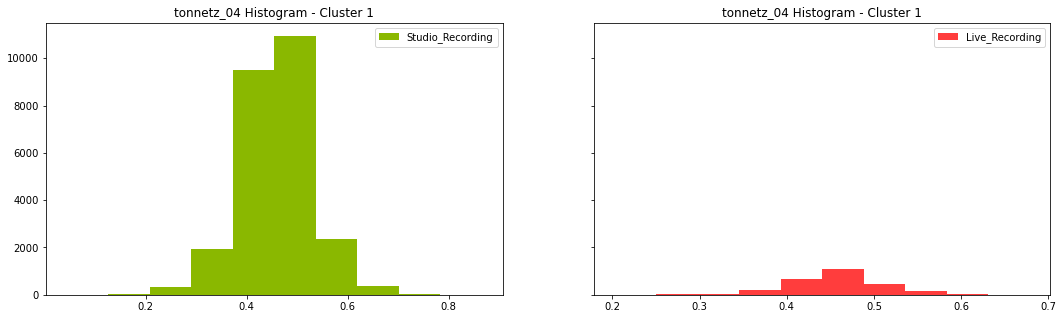

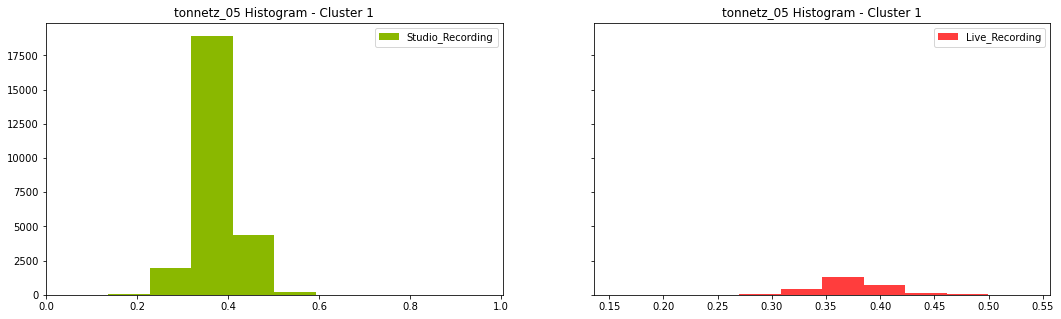

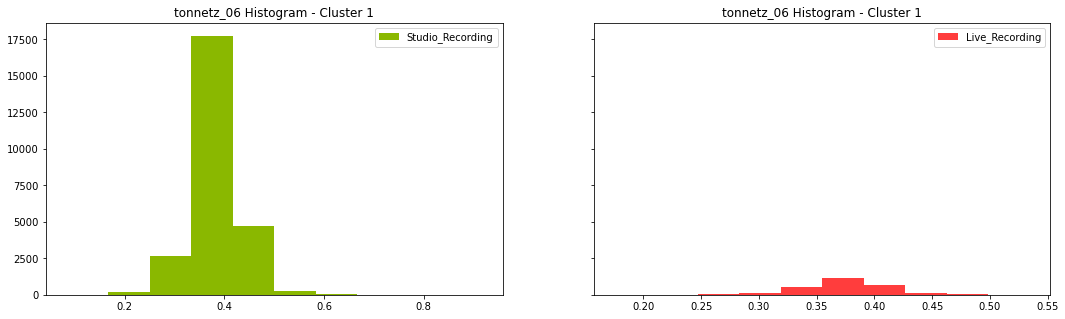

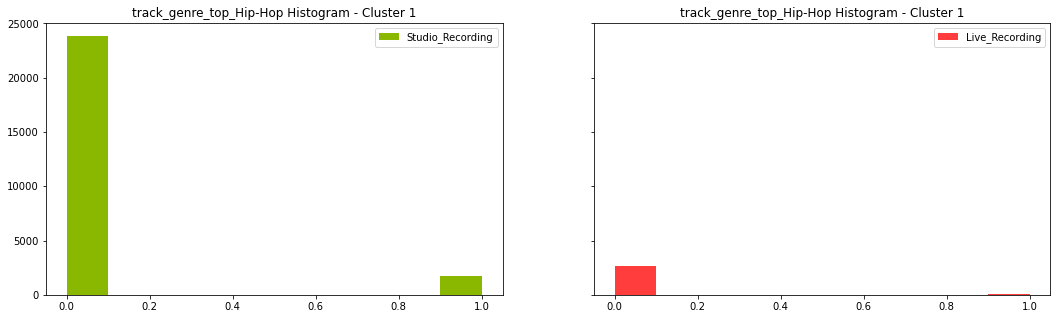

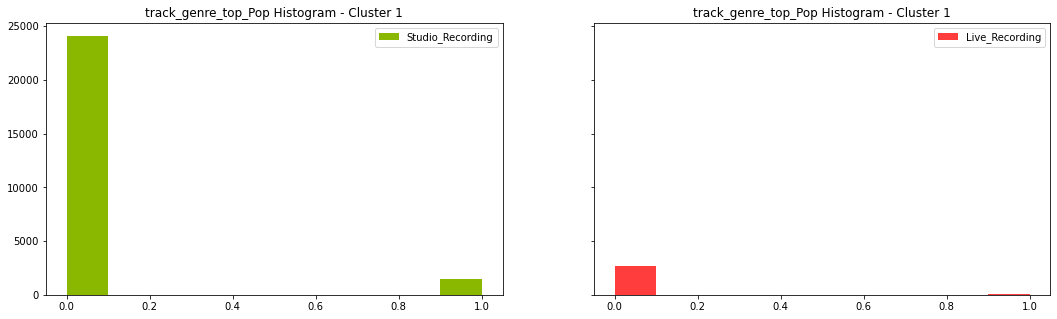

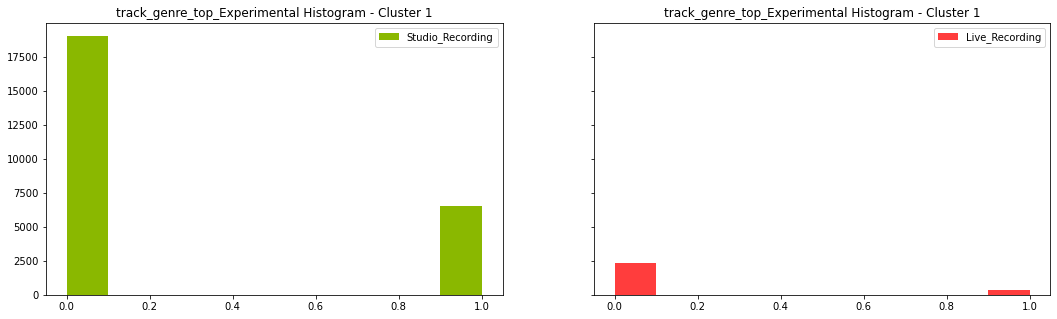

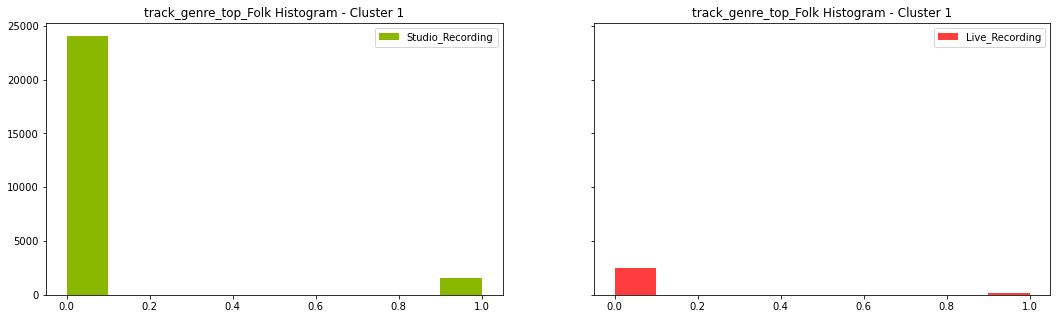

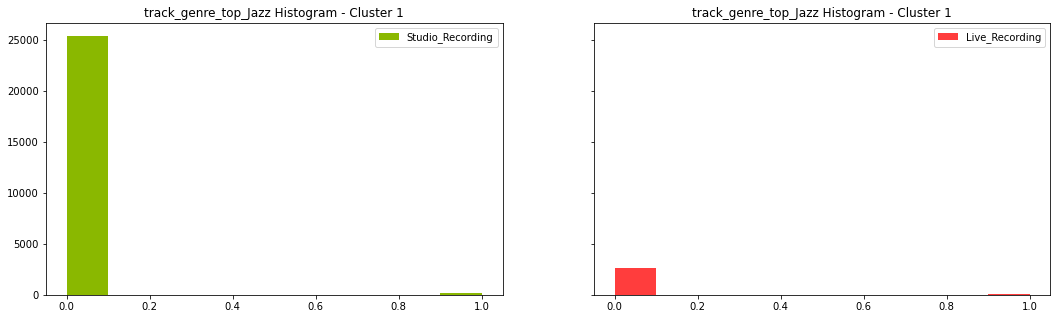

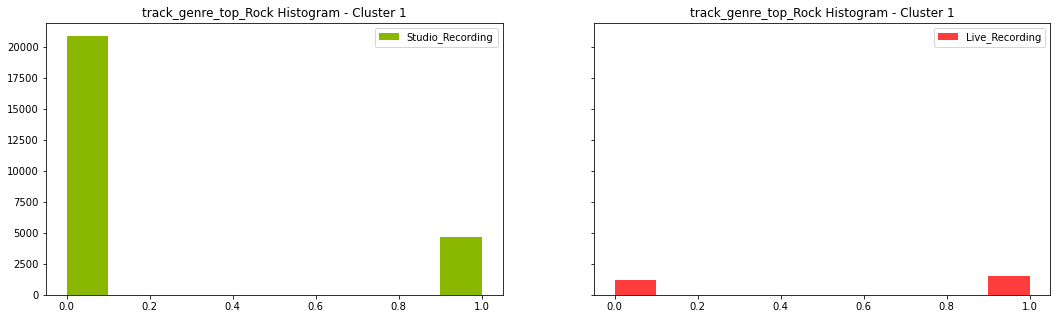

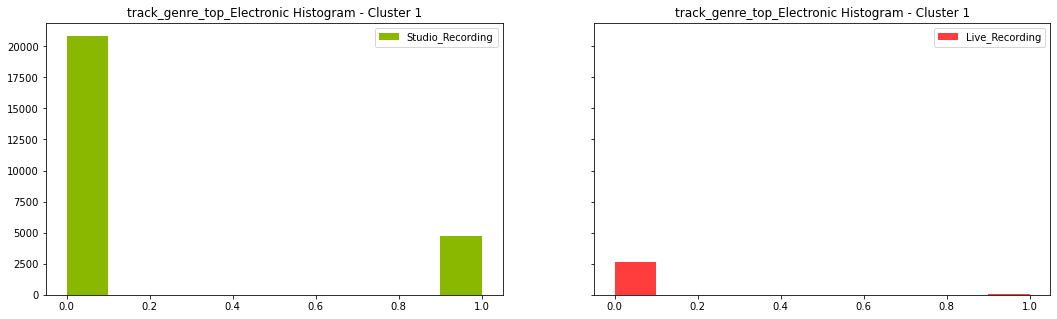

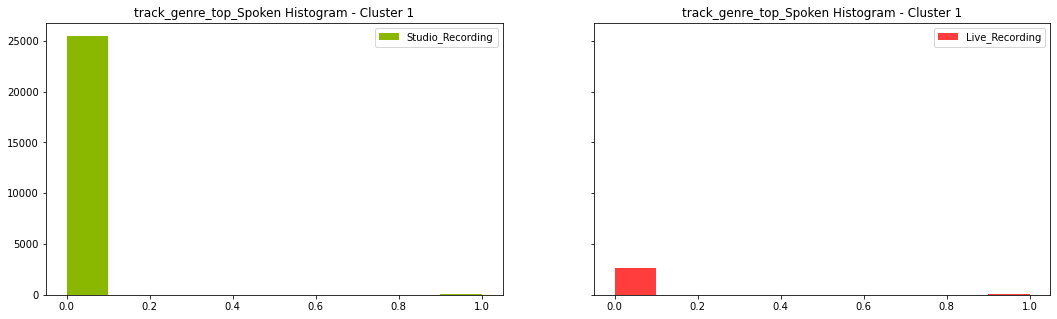

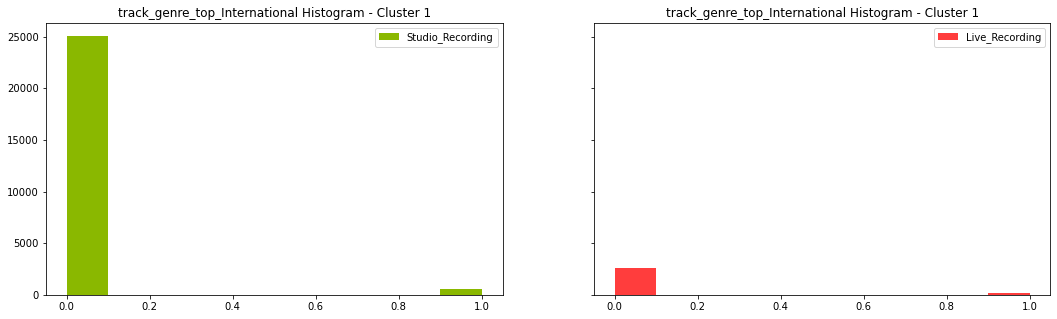

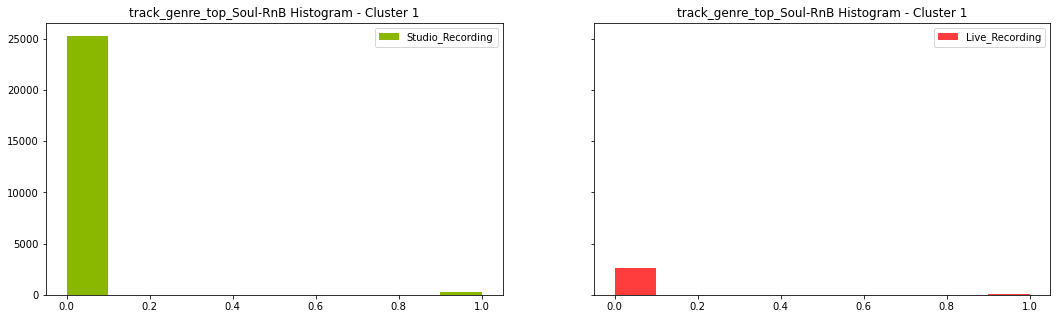

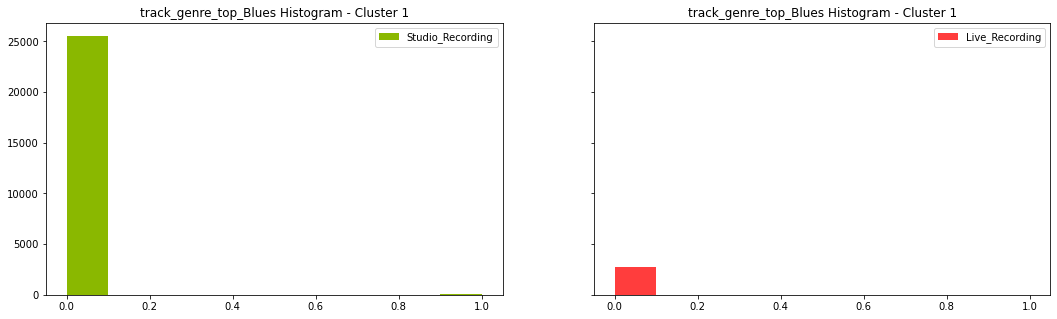

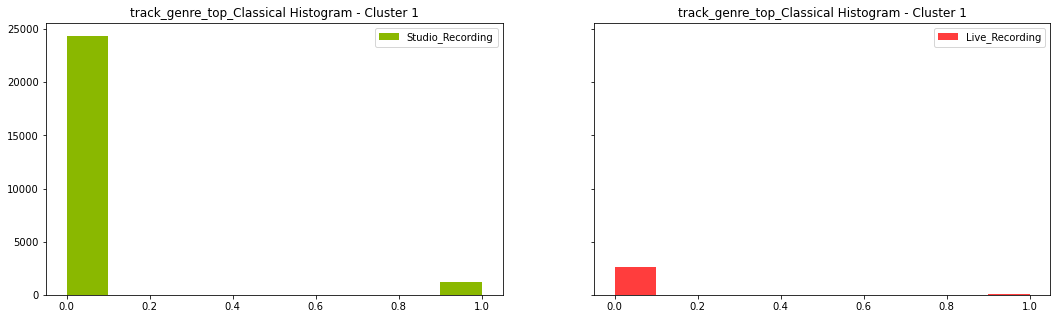

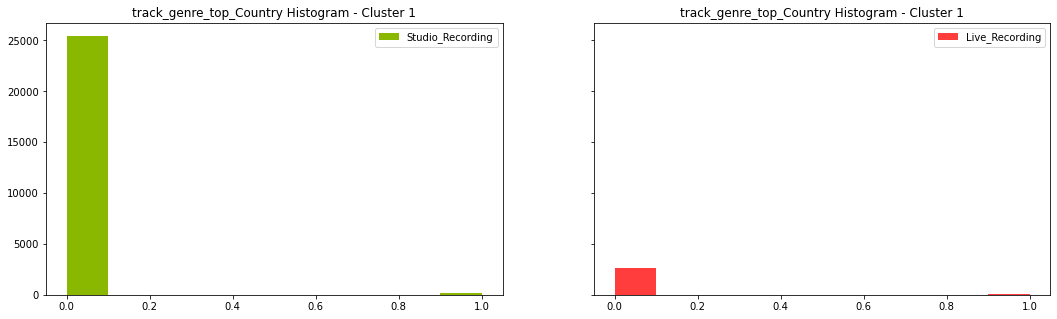

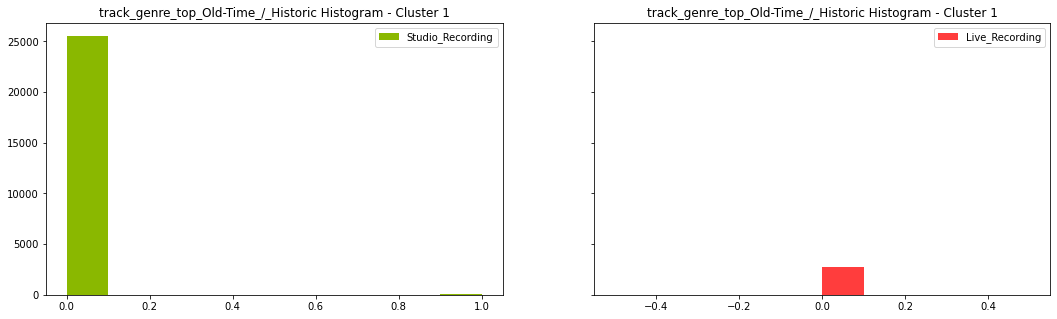

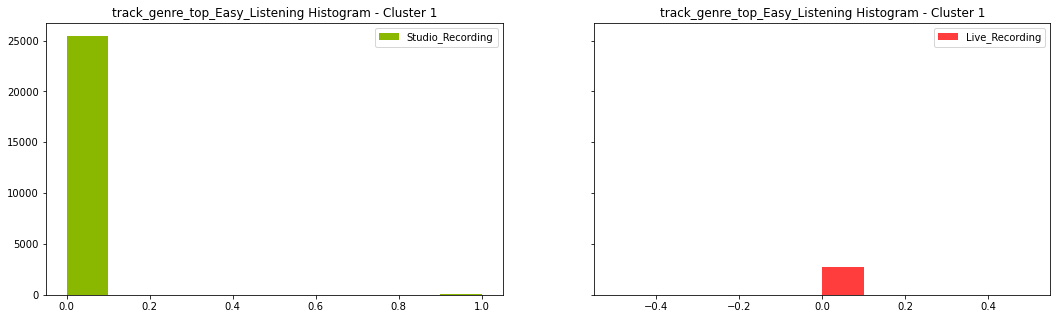

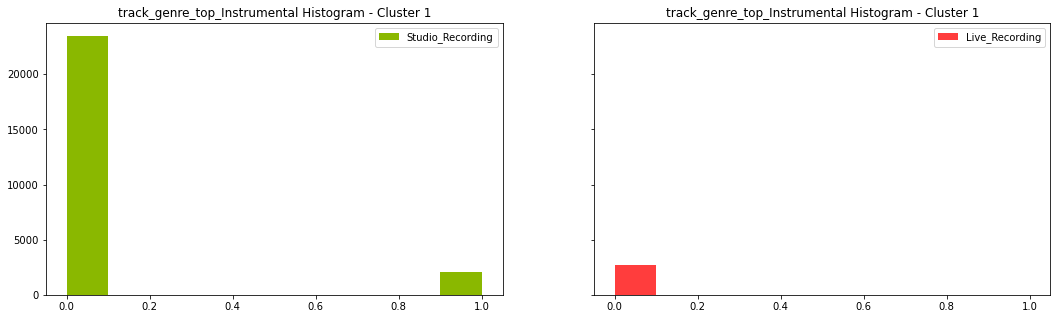

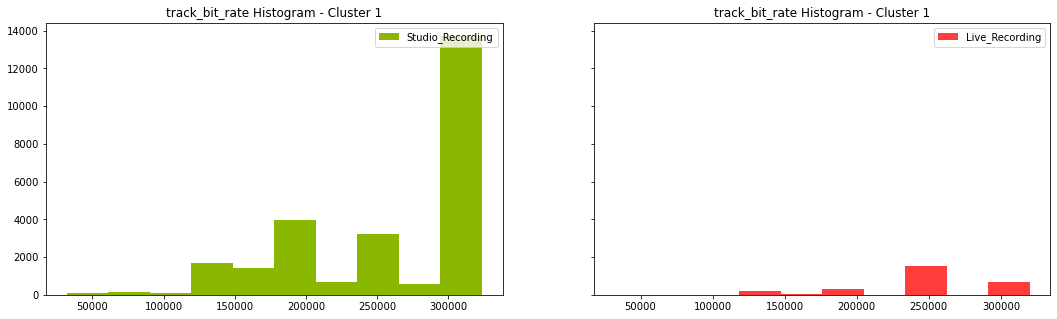

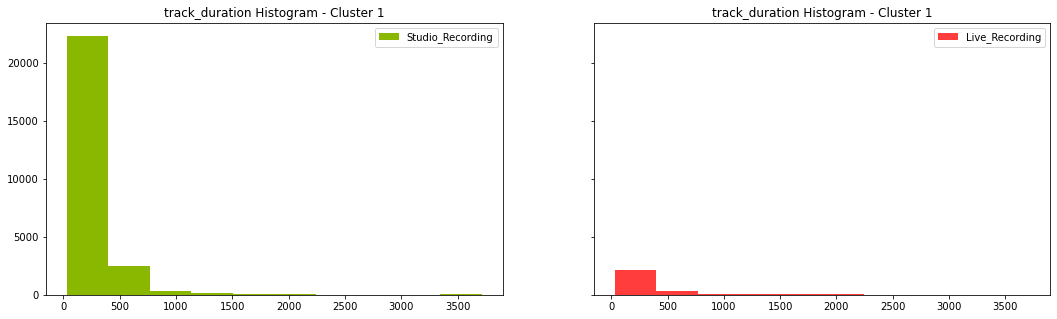

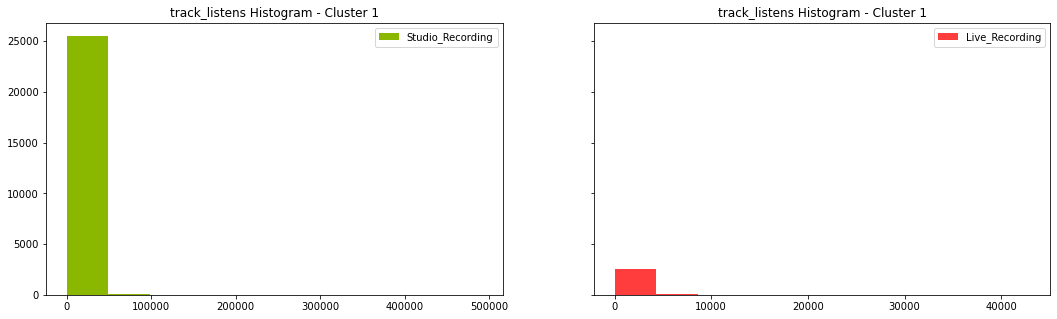

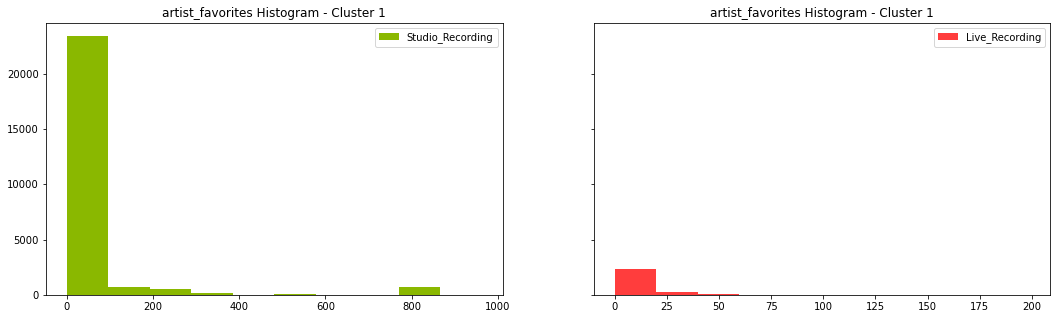

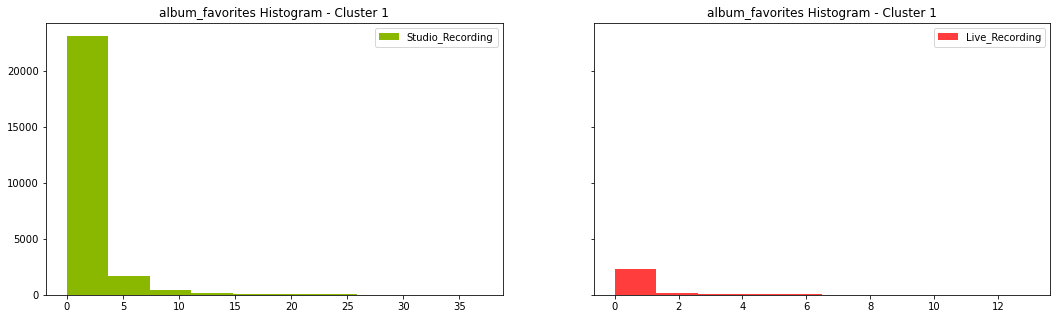

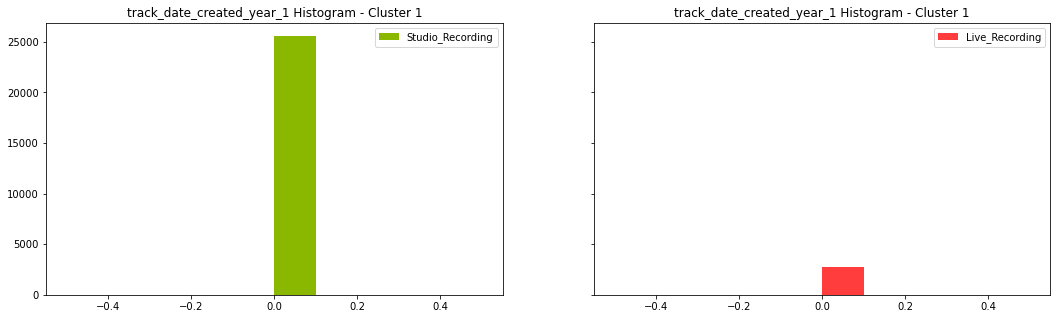

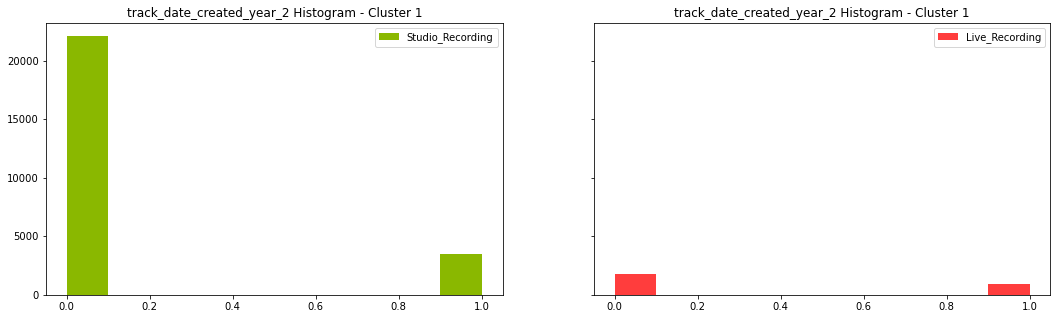

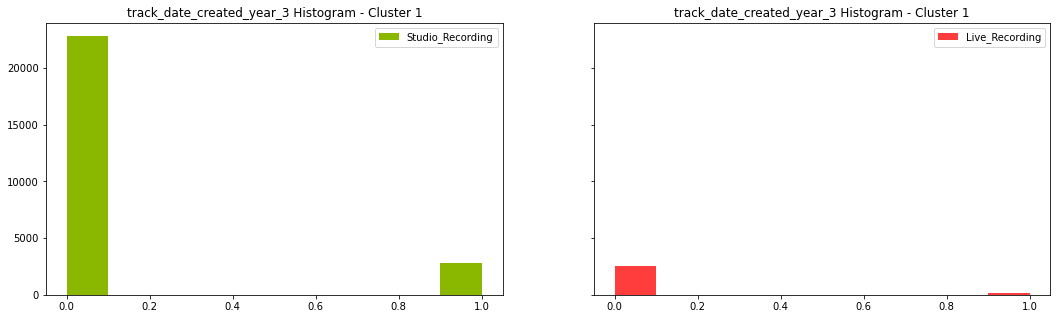

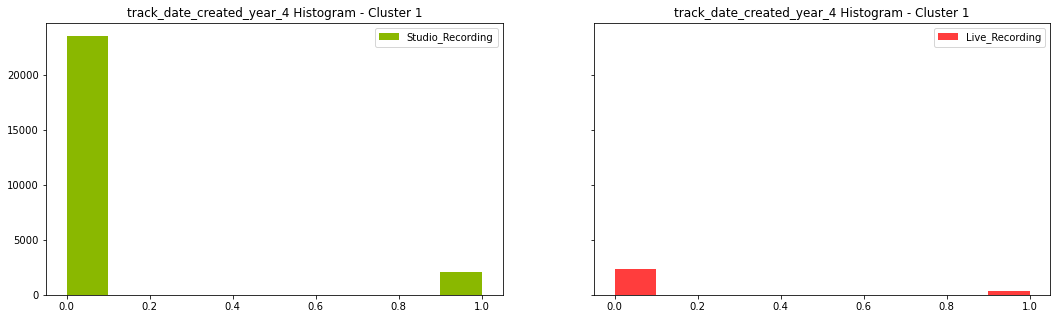

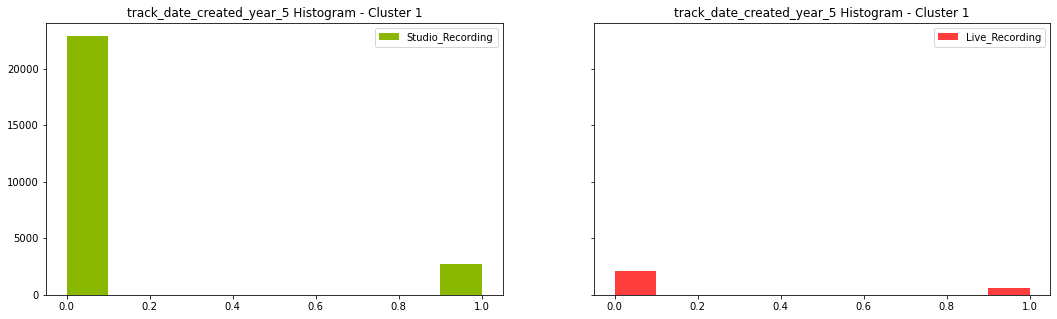

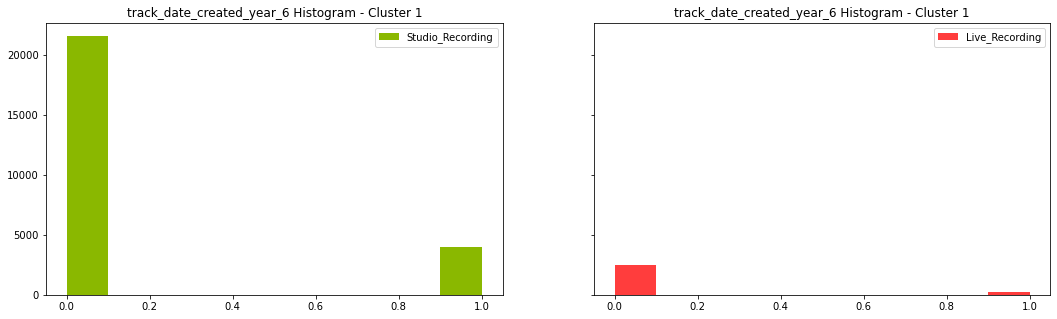

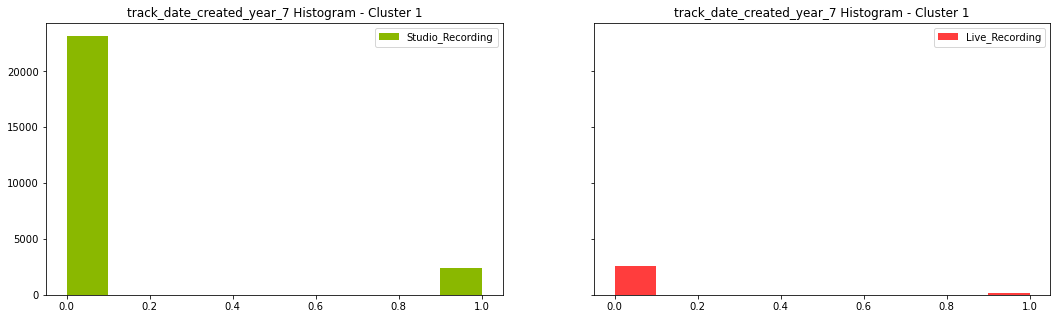

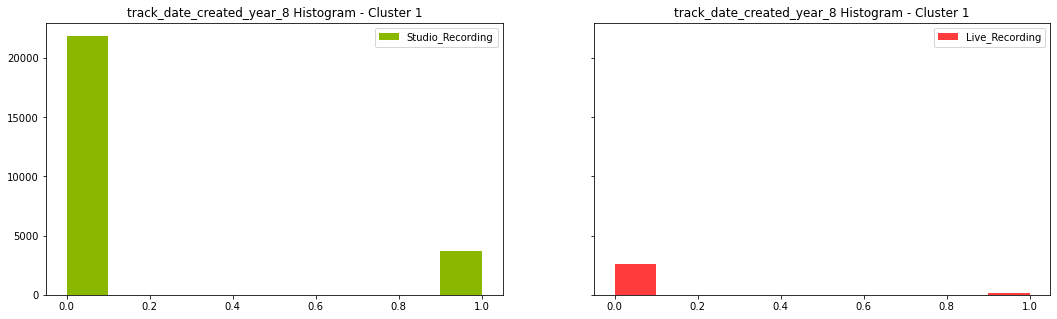

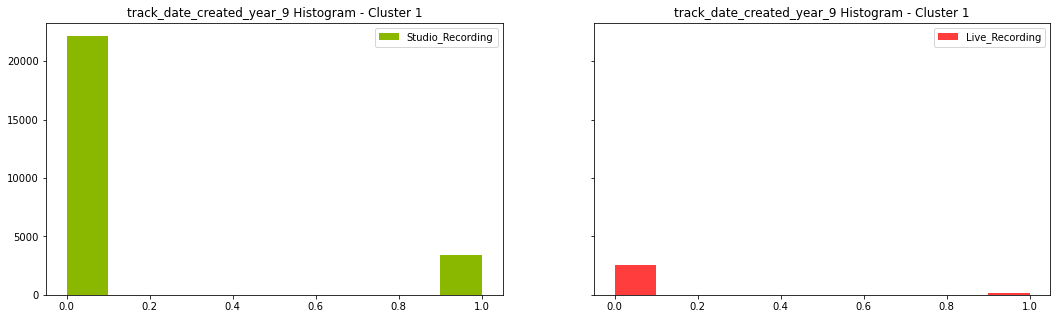

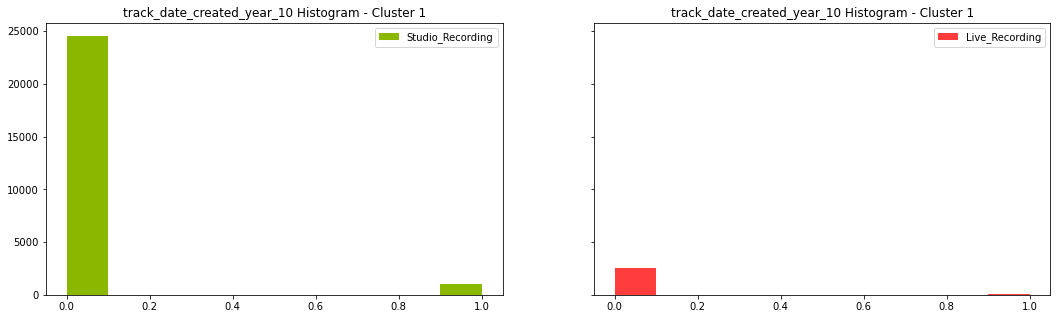

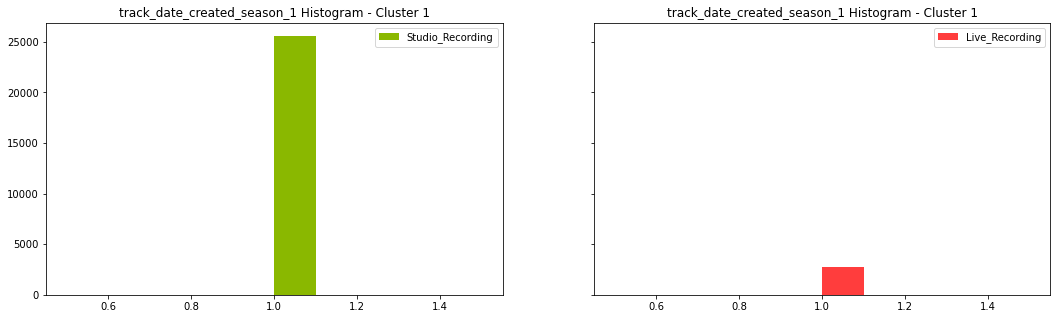

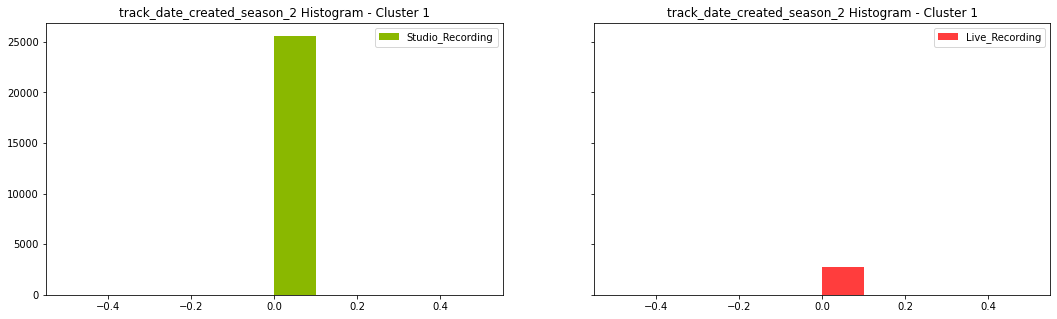

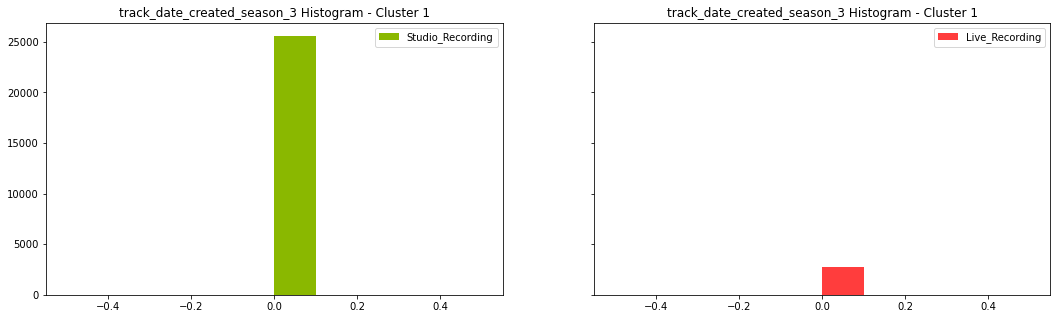

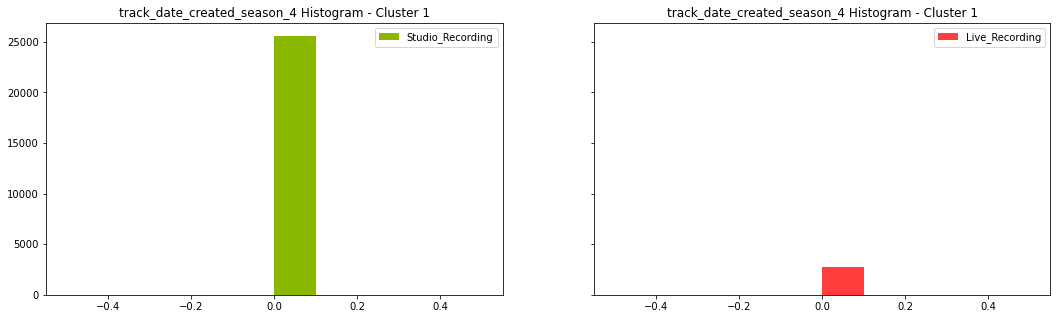

------------------------------------------------------------------------------------------------------------------
Cluster 2



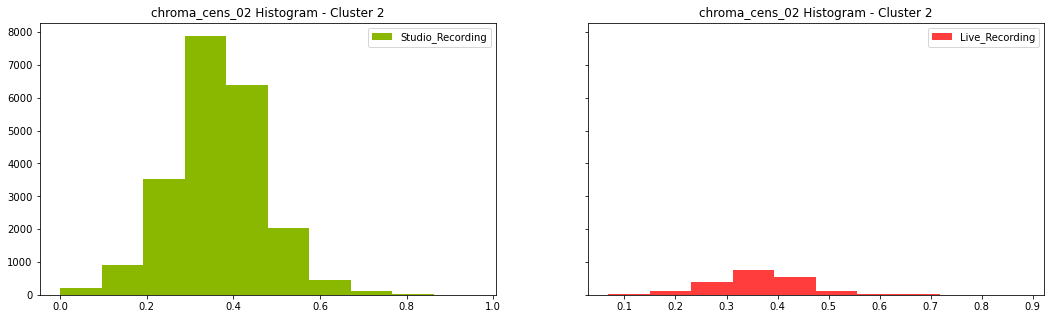

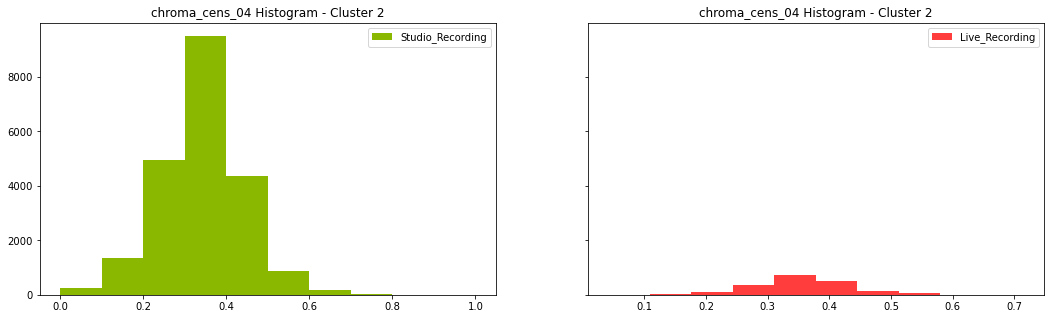

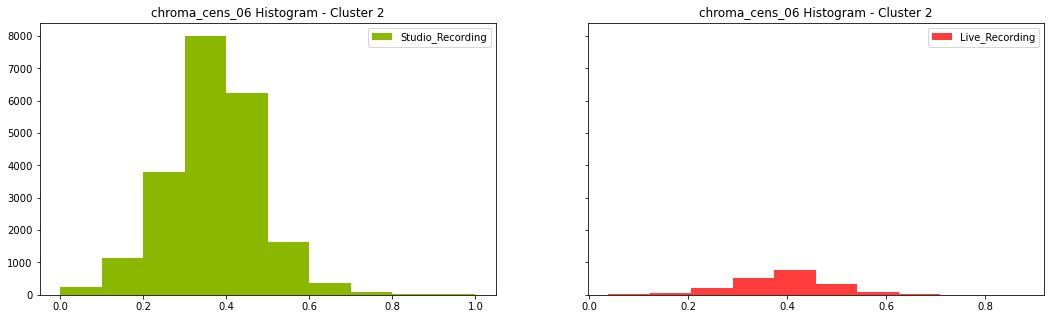

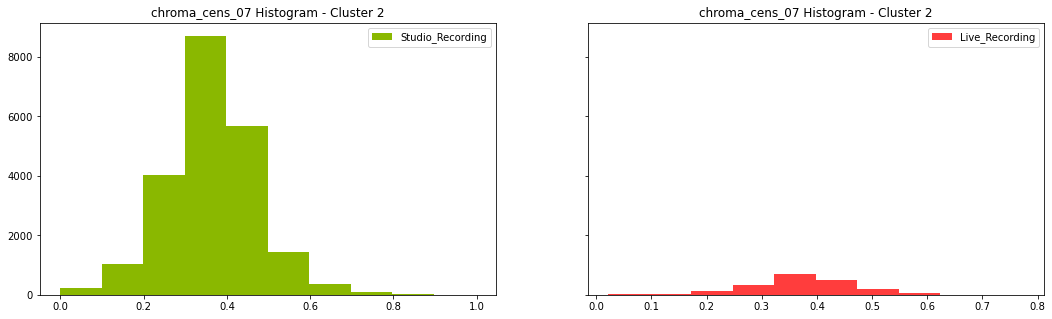

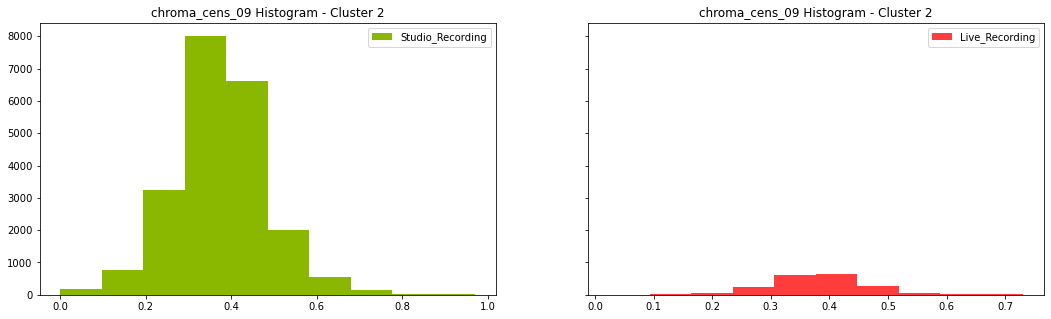

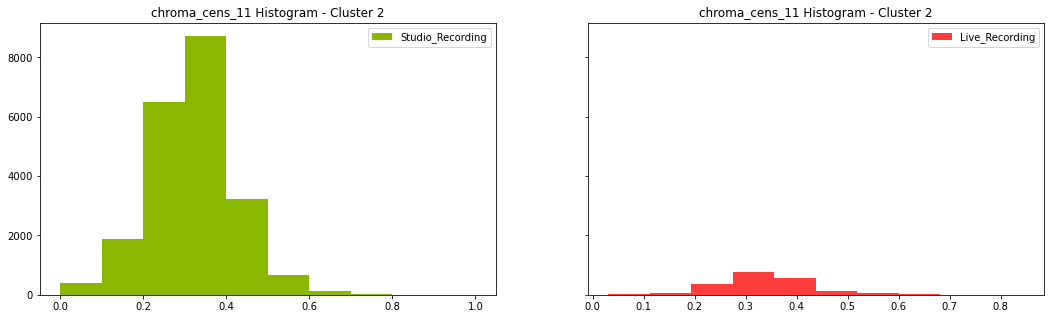

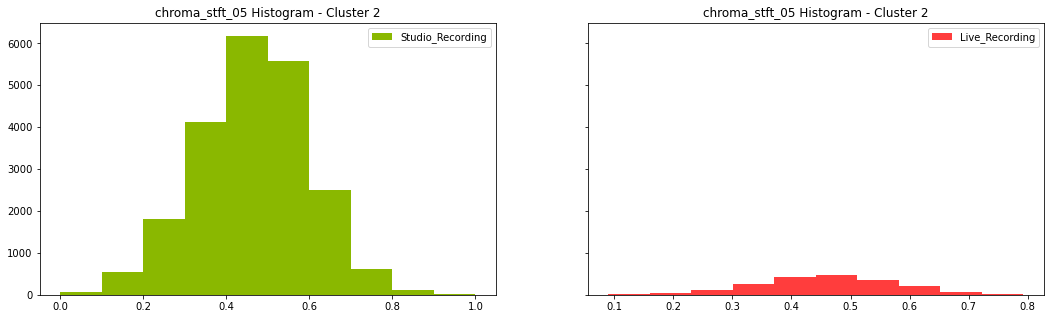

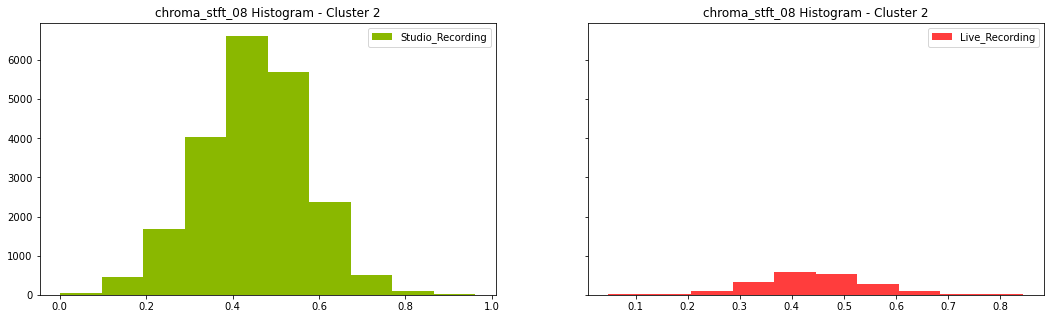

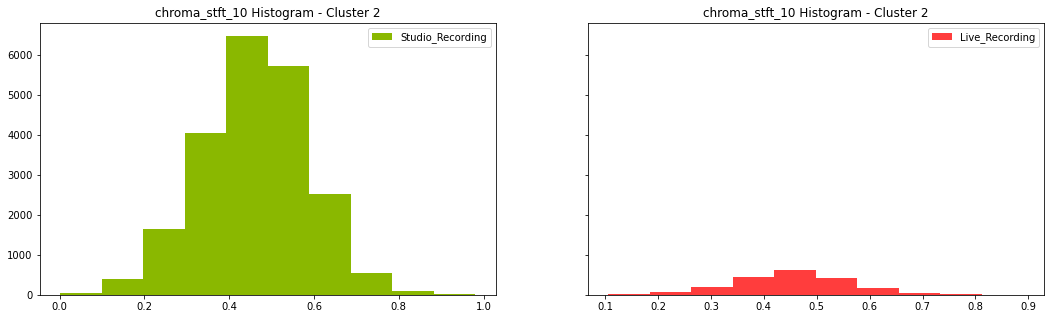

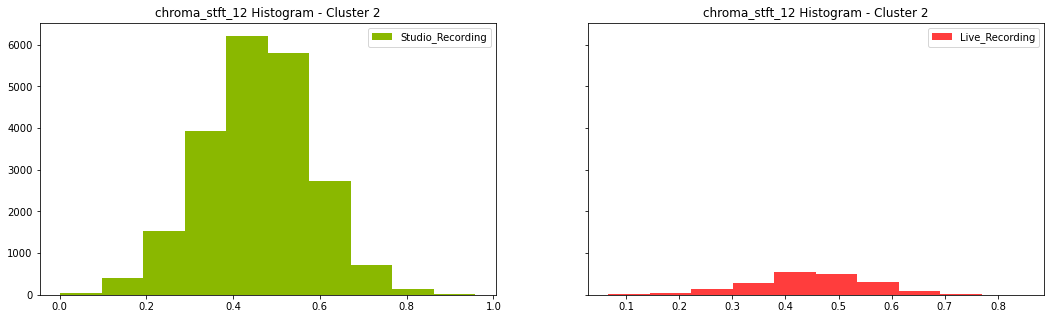

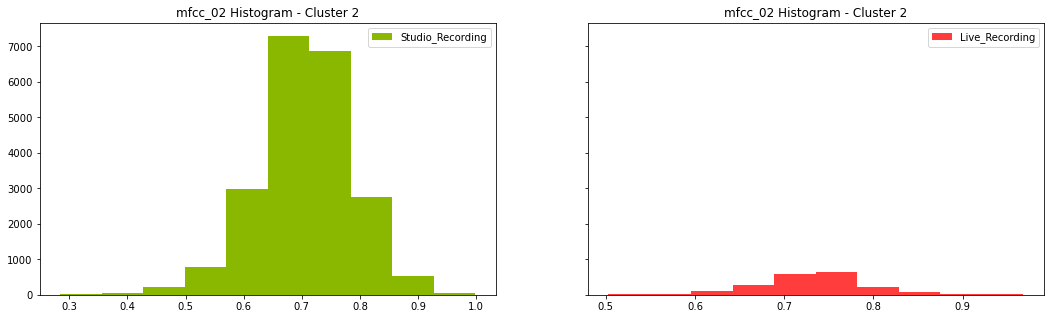

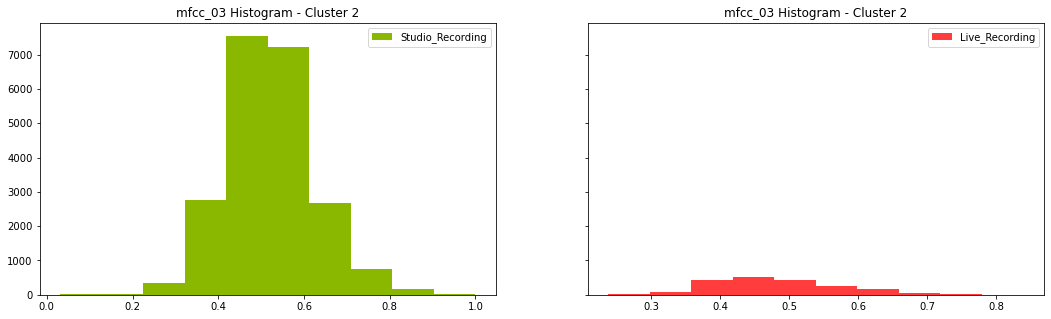

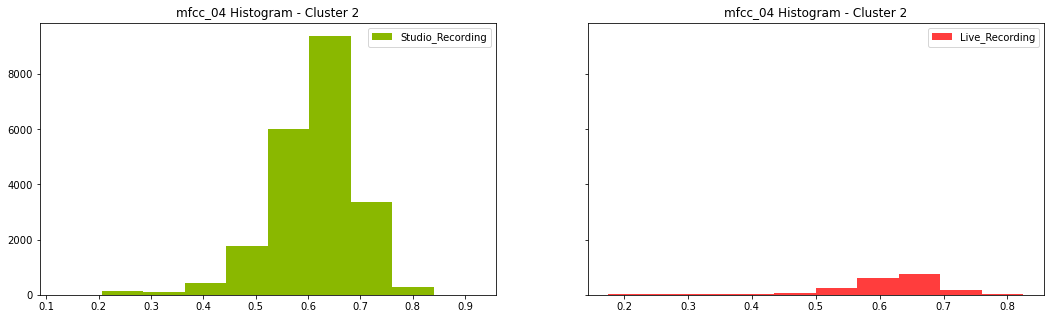

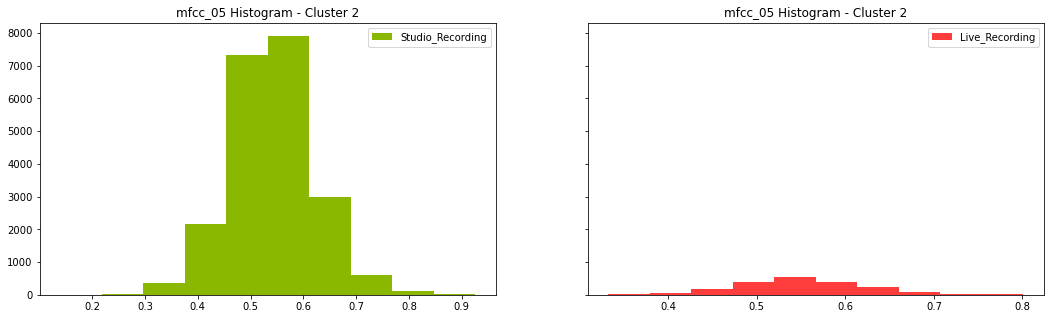

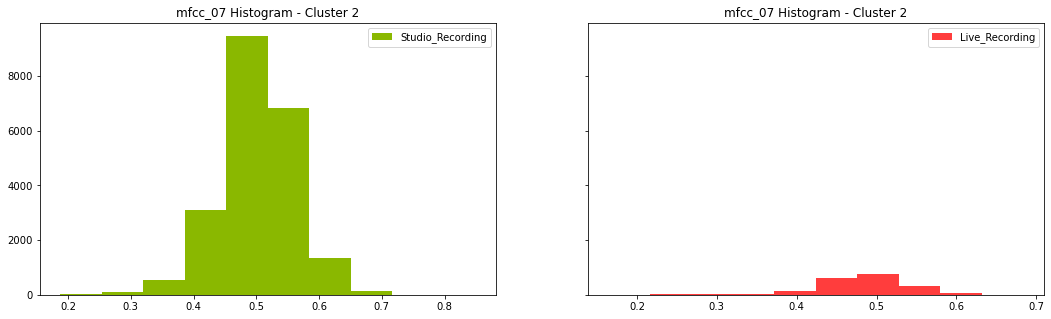

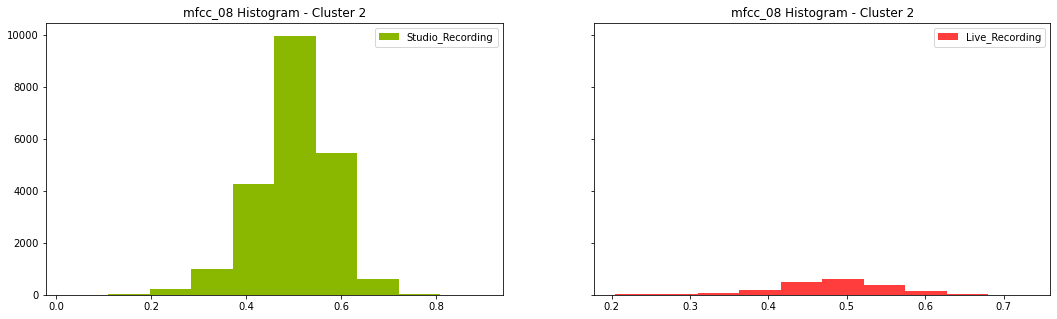

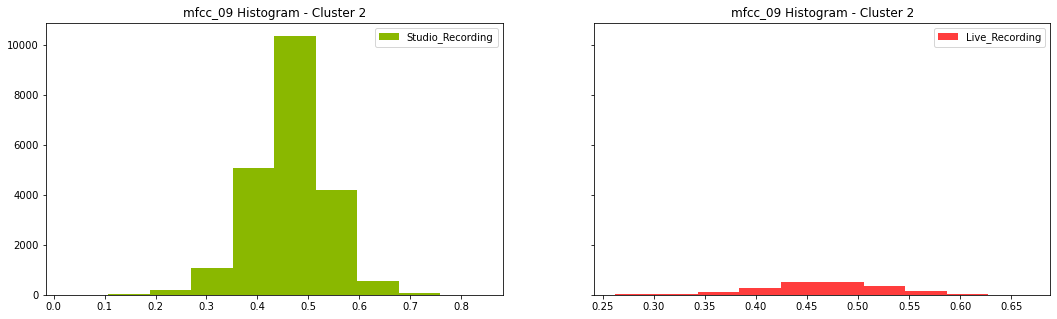

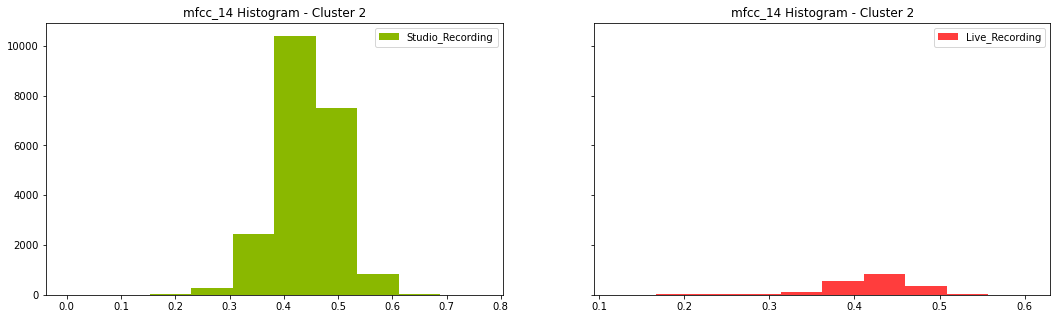

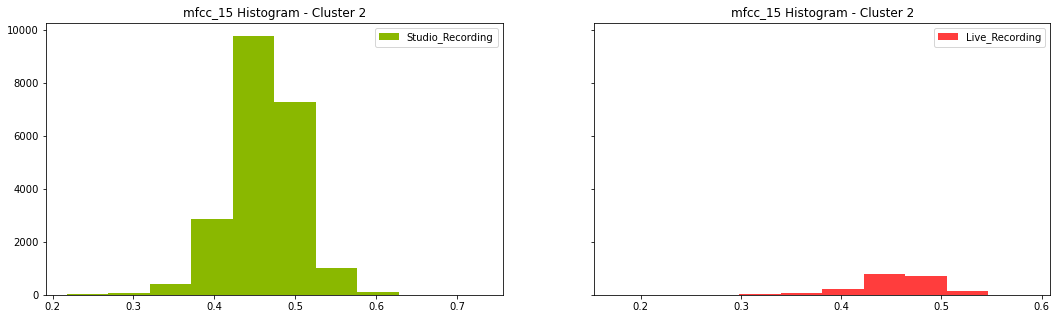

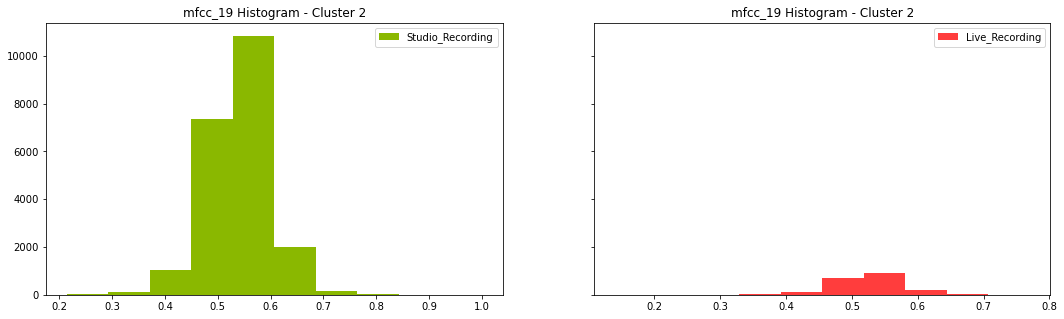

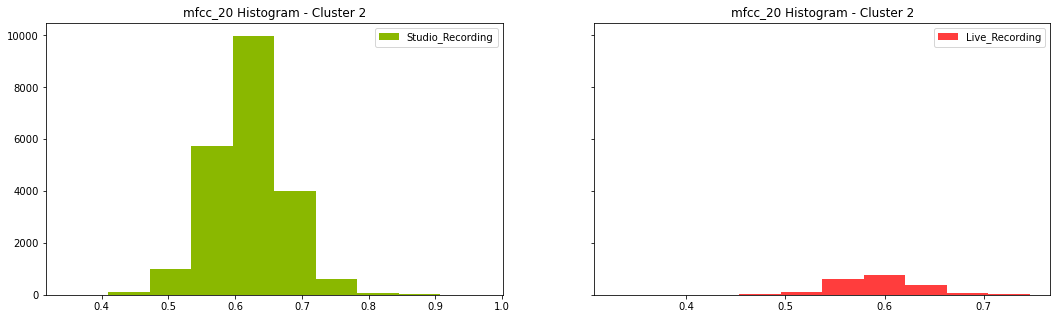

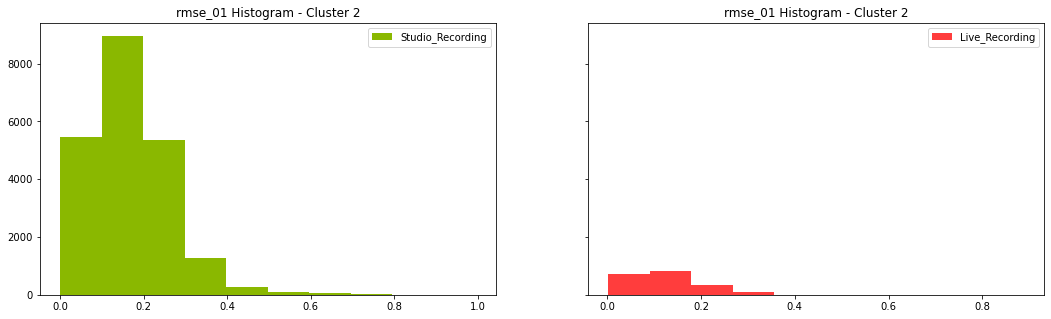

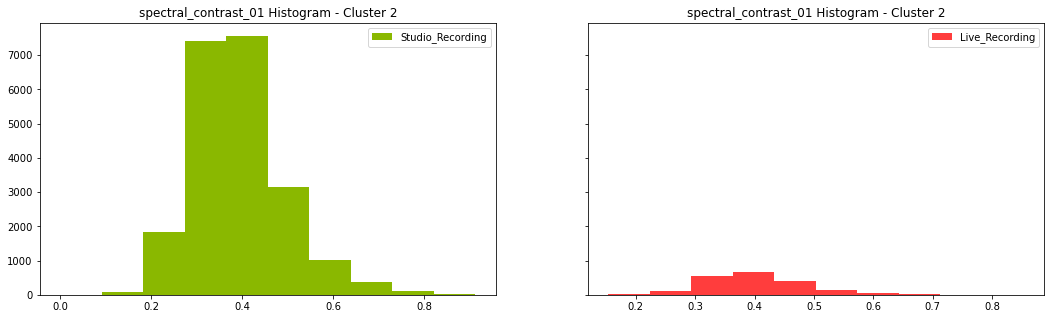

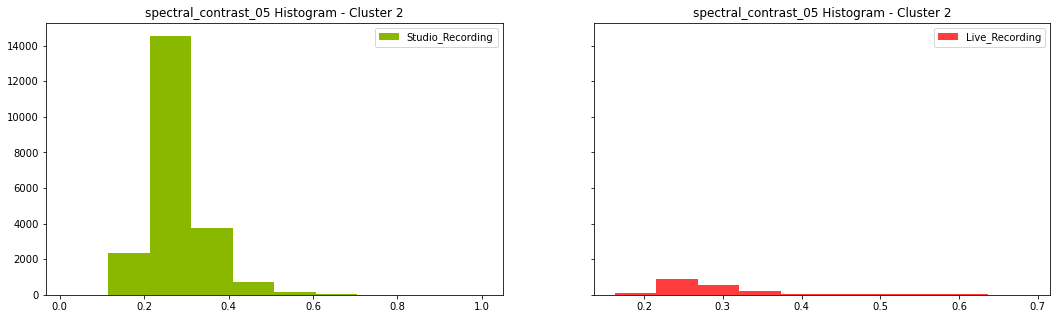

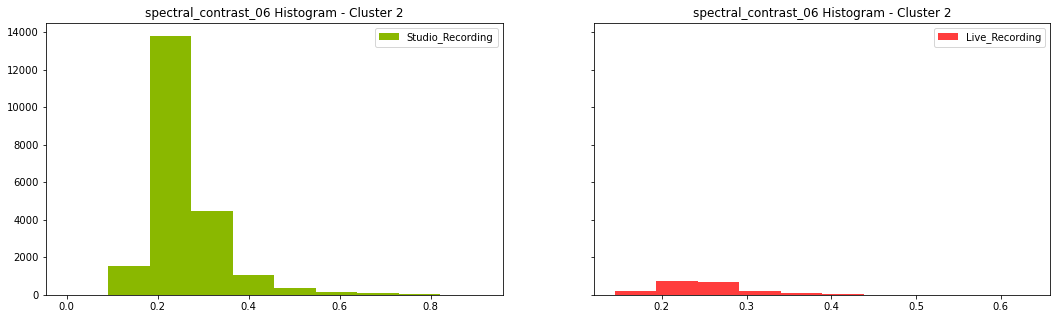

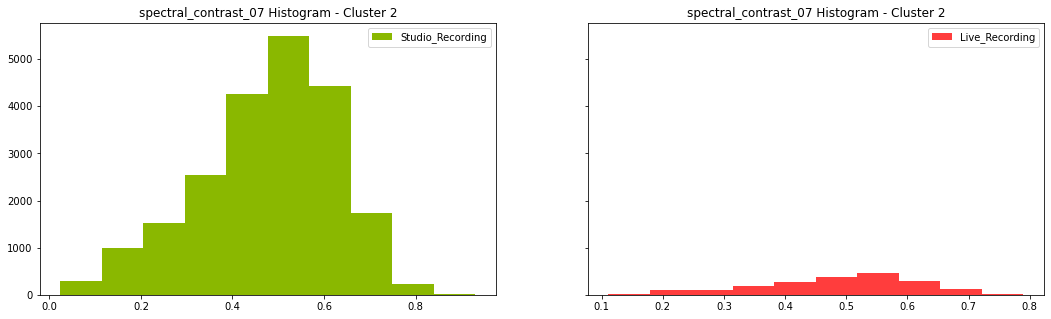

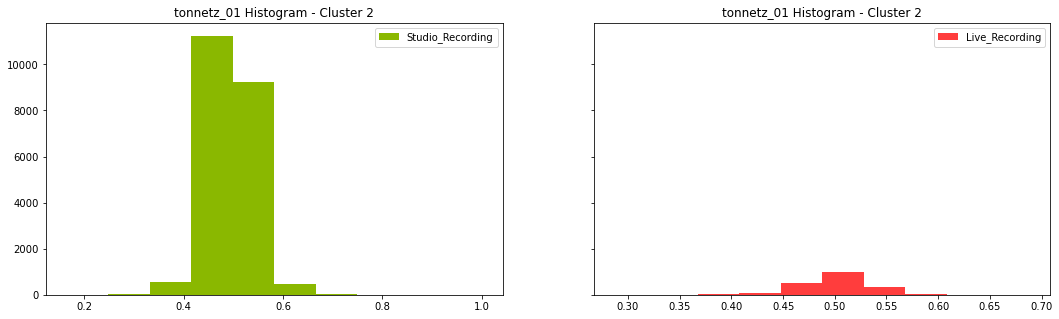

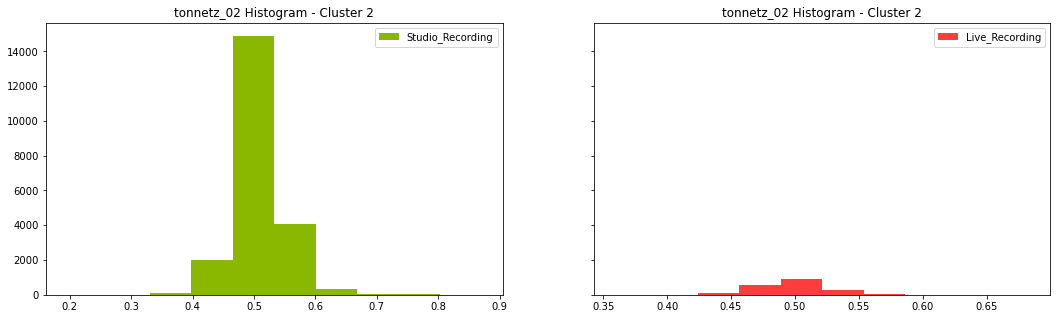

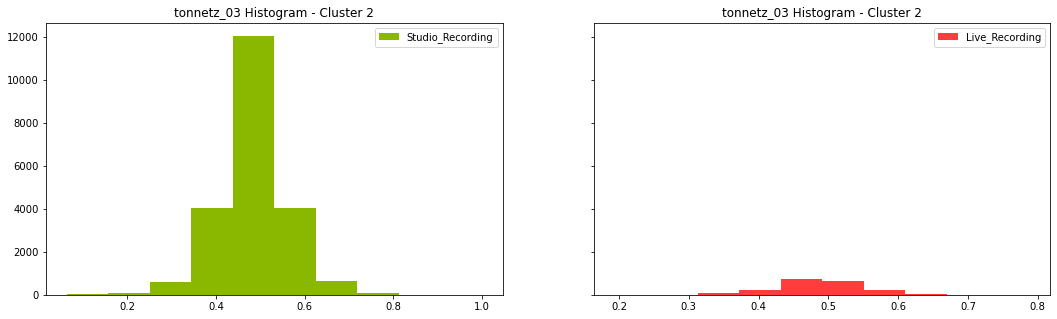

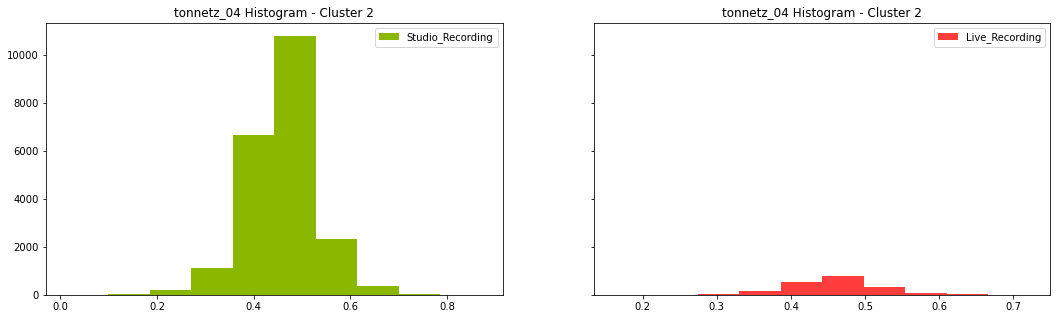

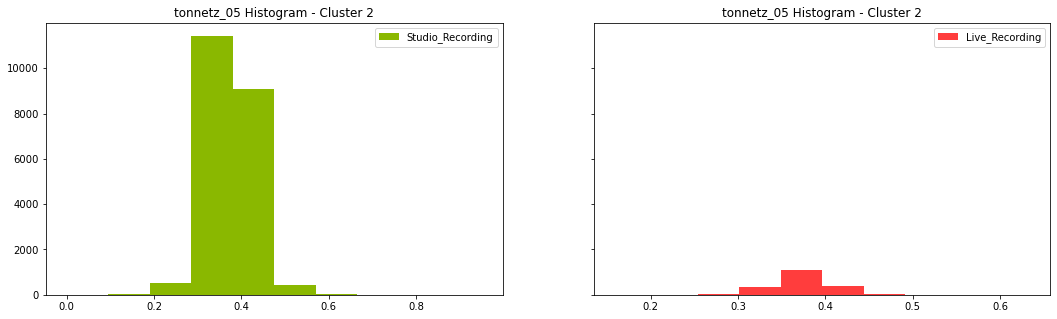

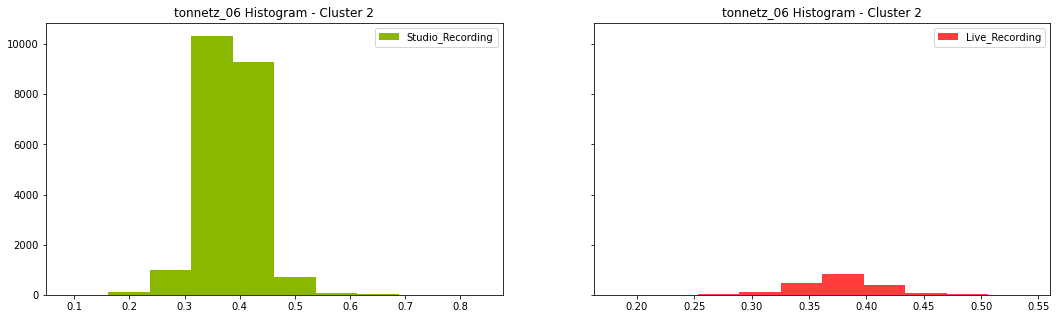

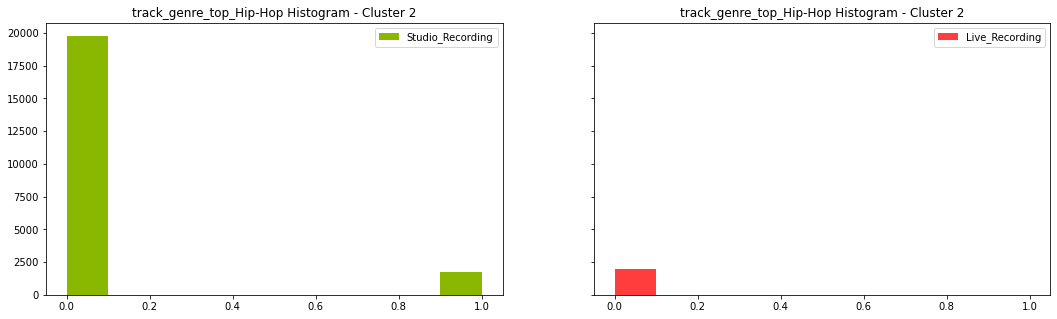

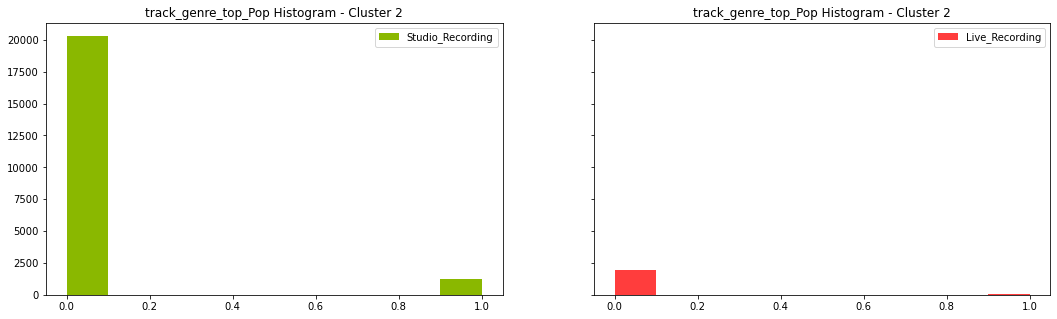

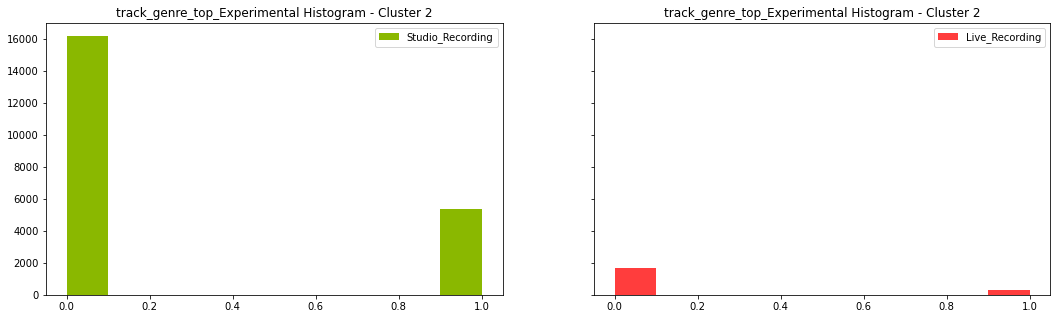

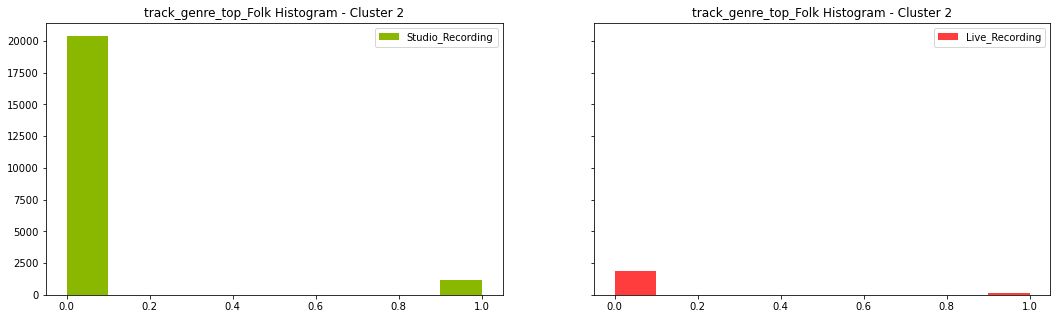

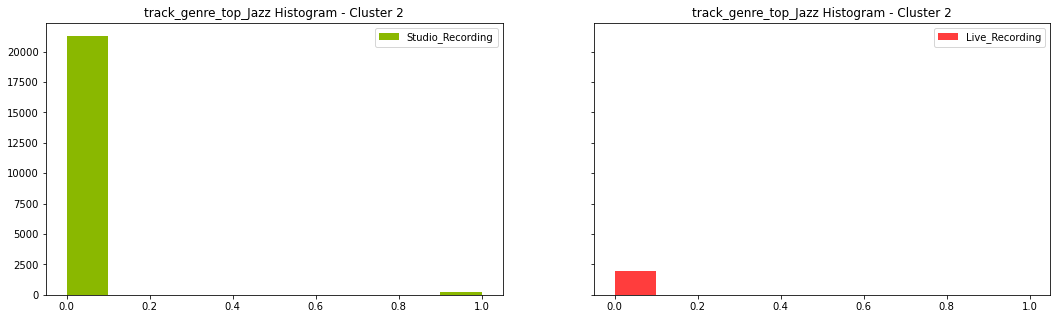

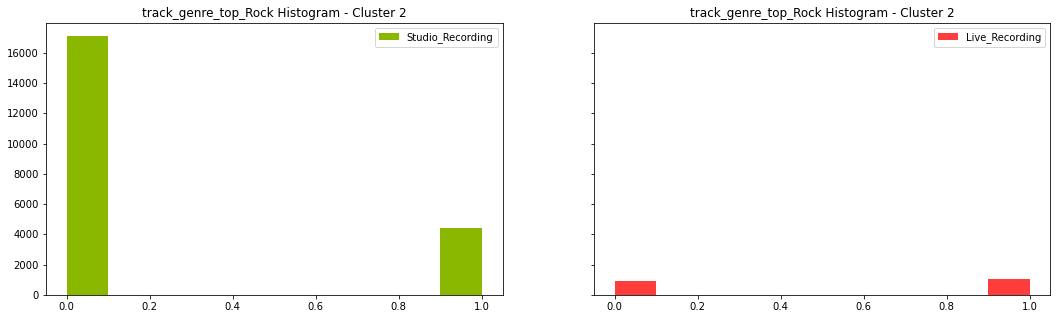

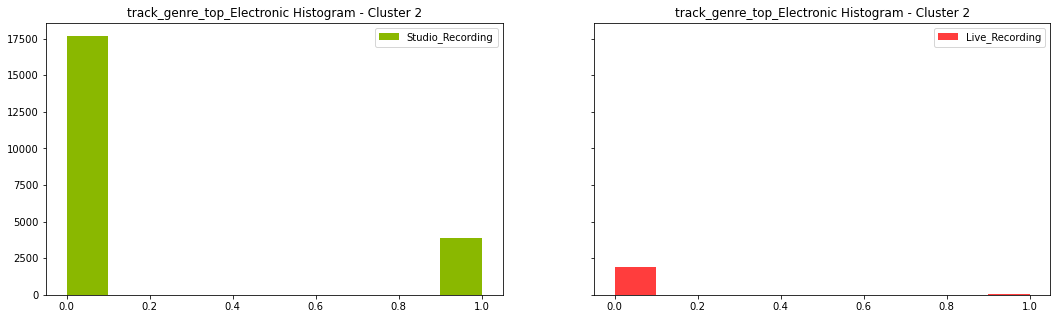

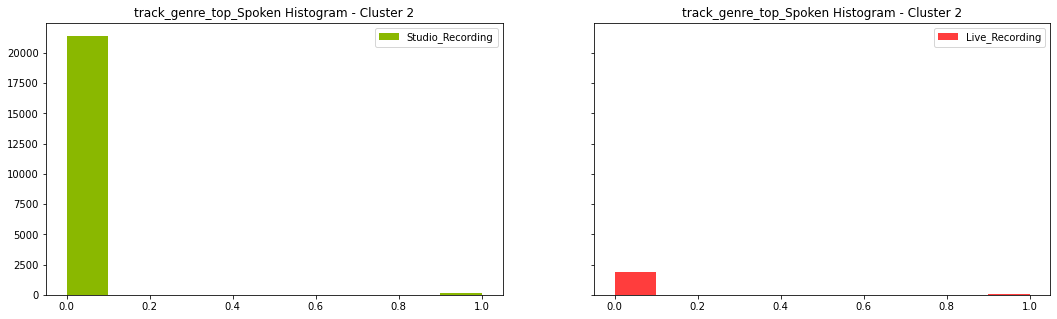

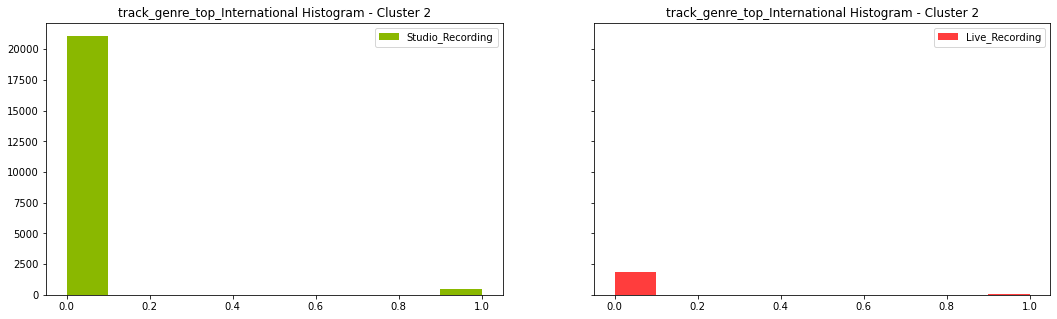

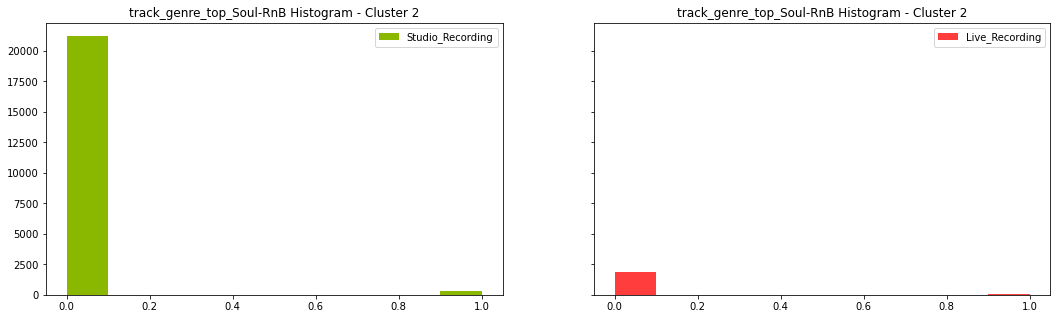

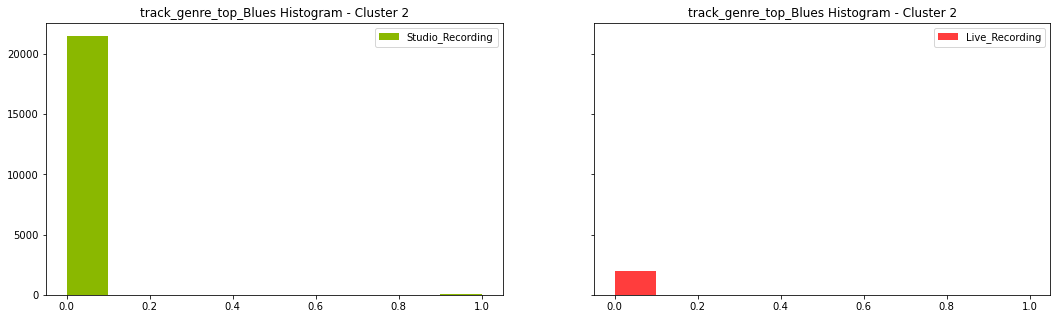

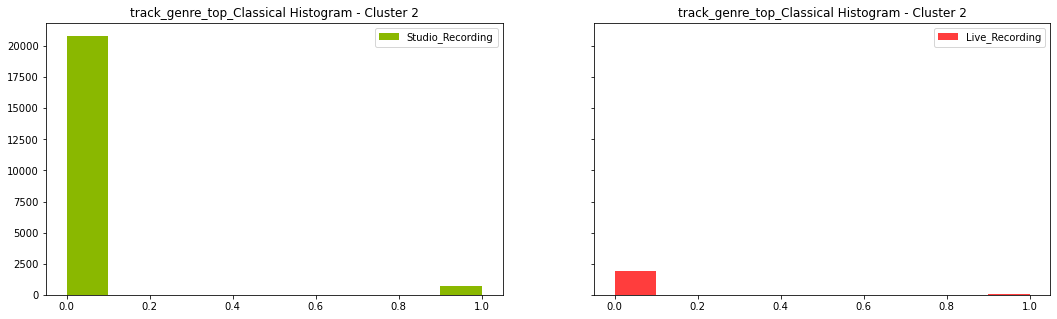

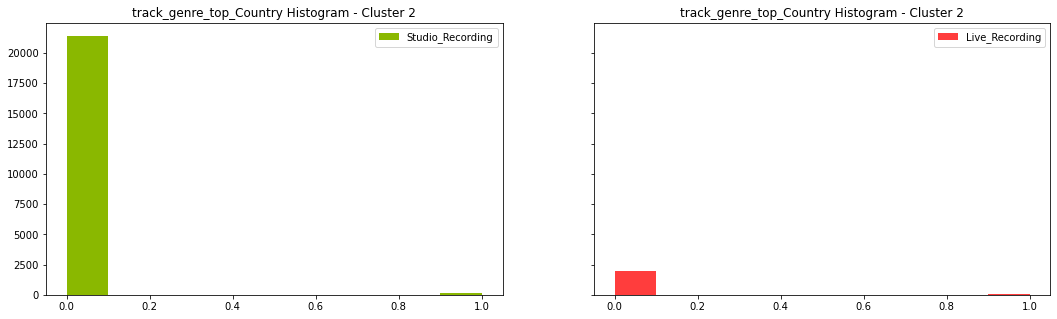

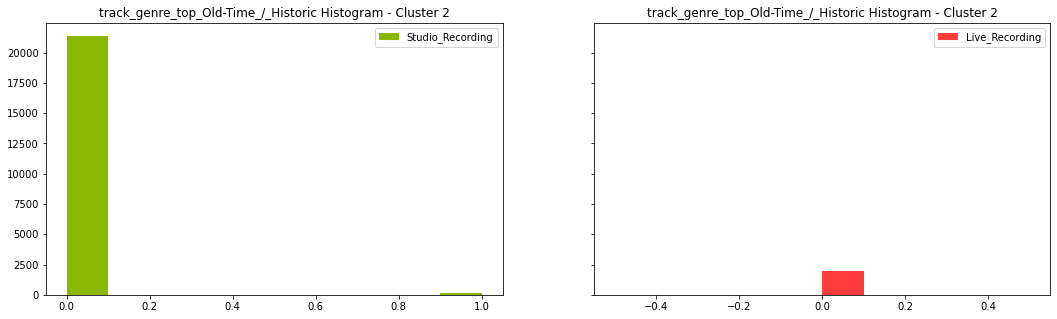

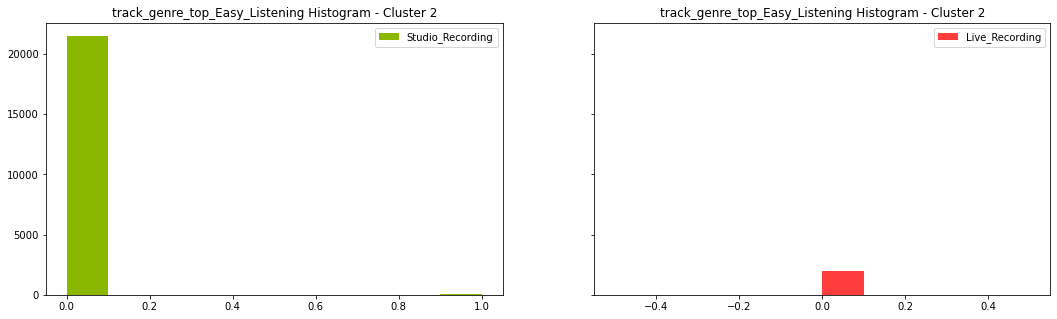

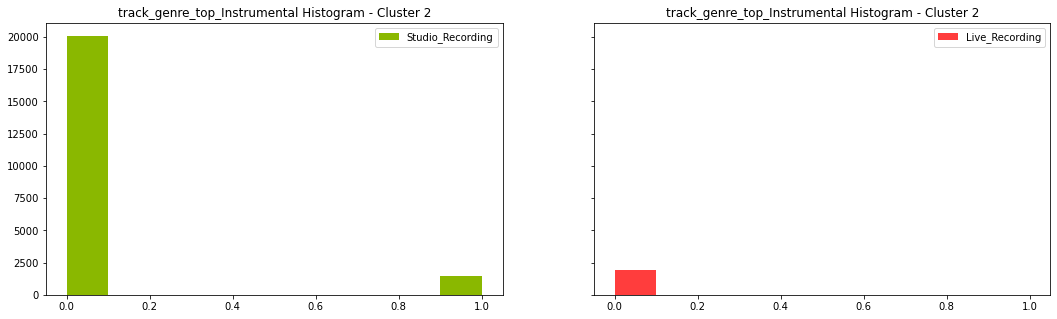

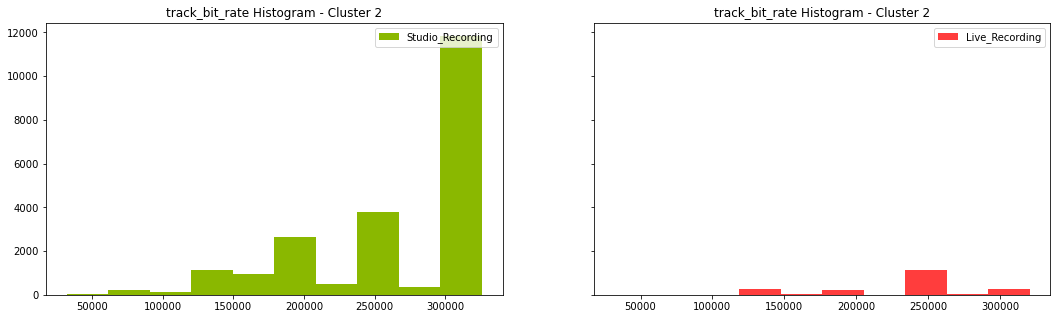

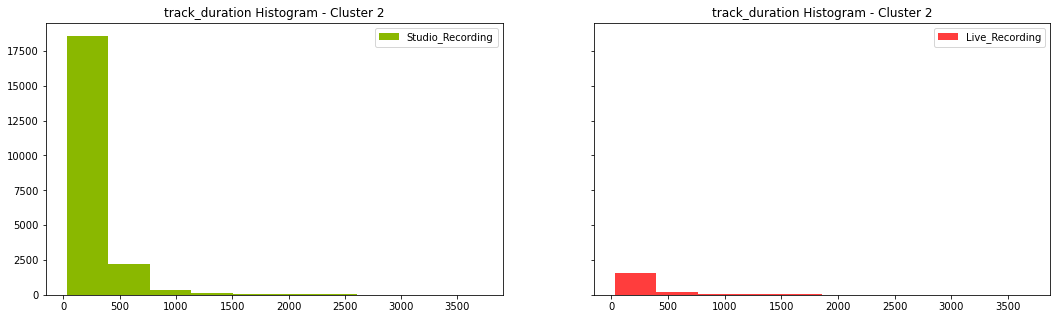

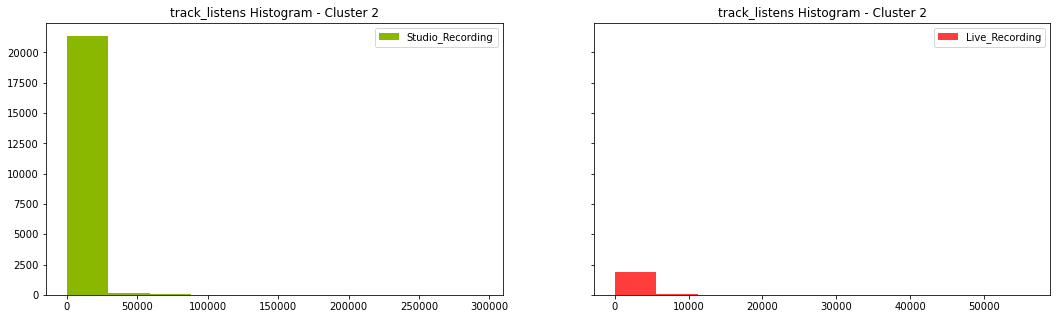

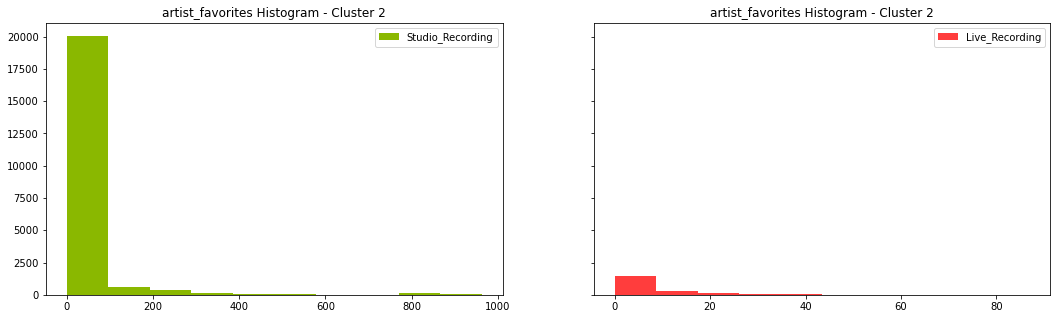

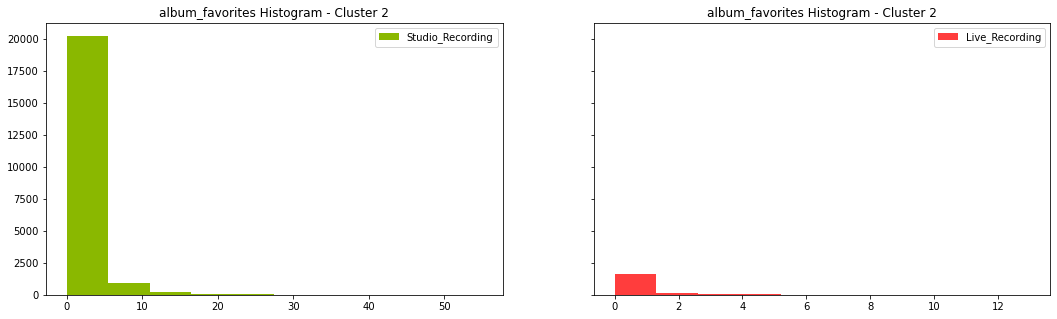

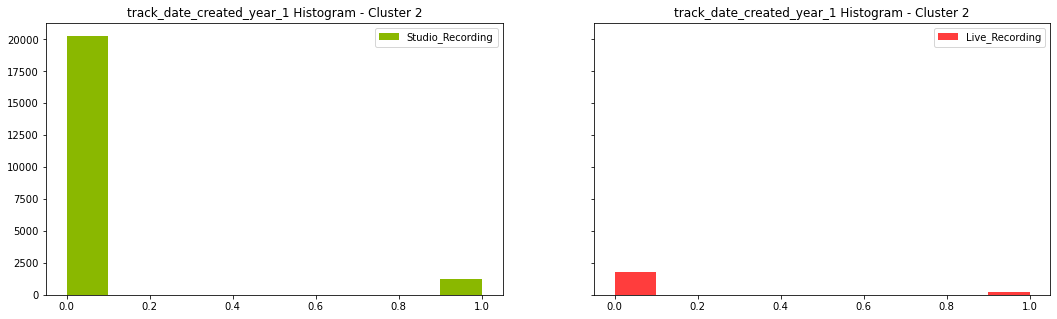

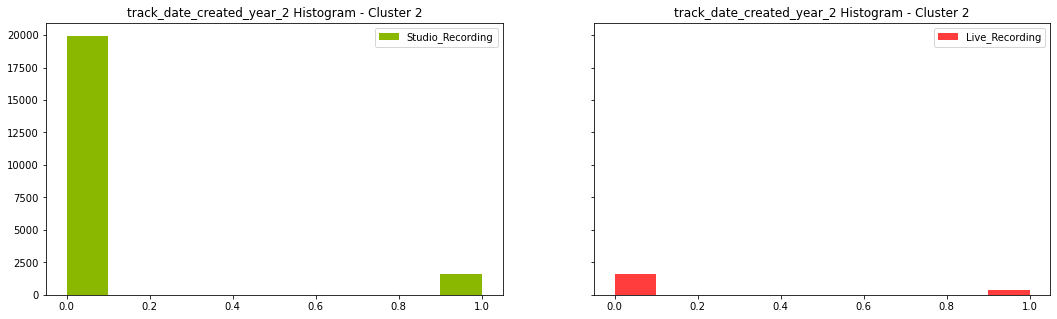

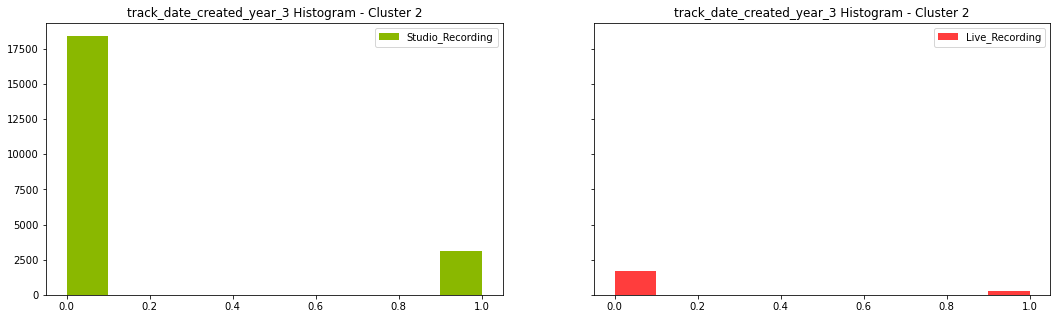

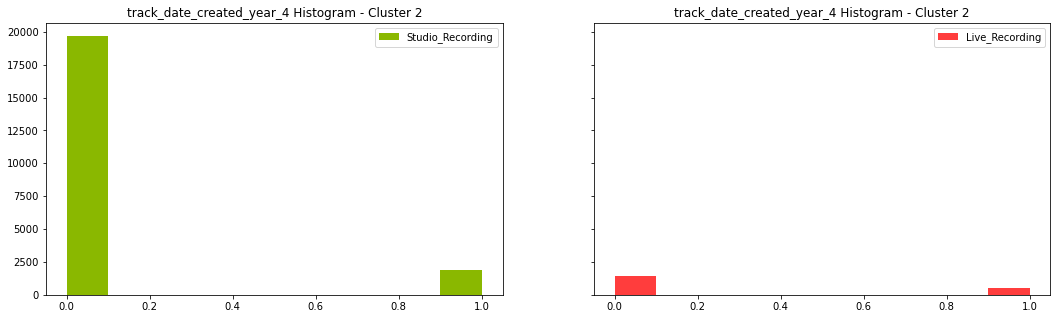

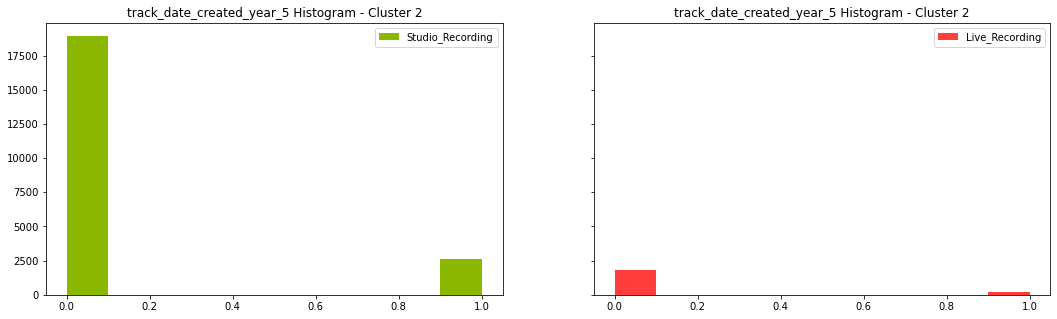

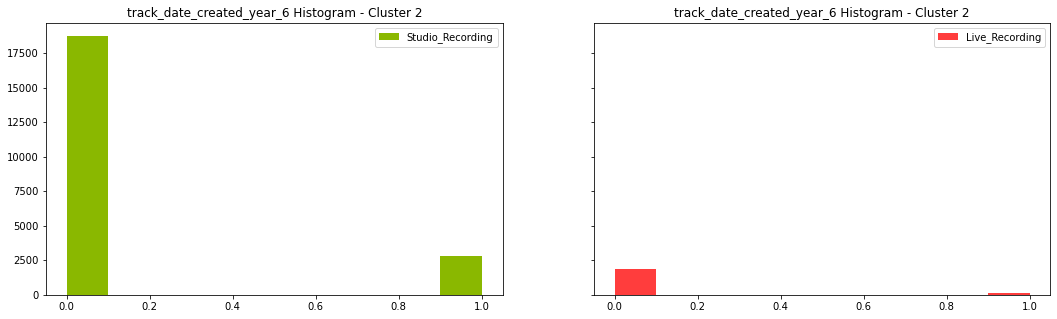

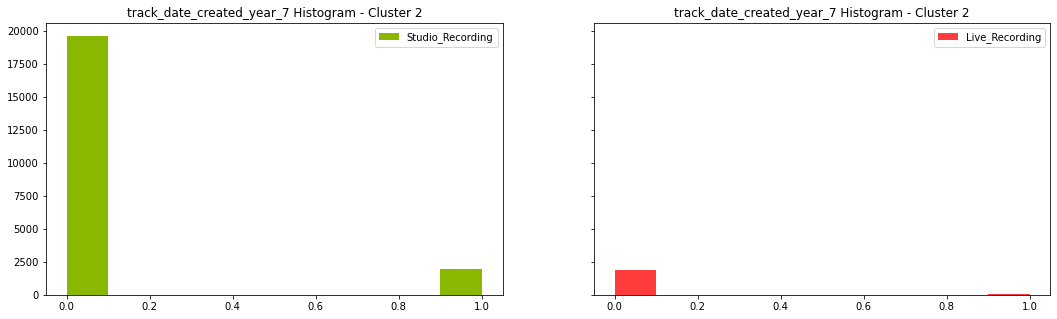

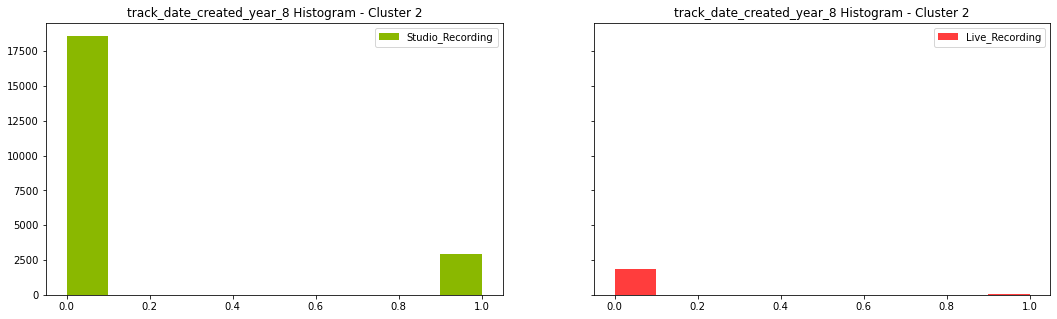

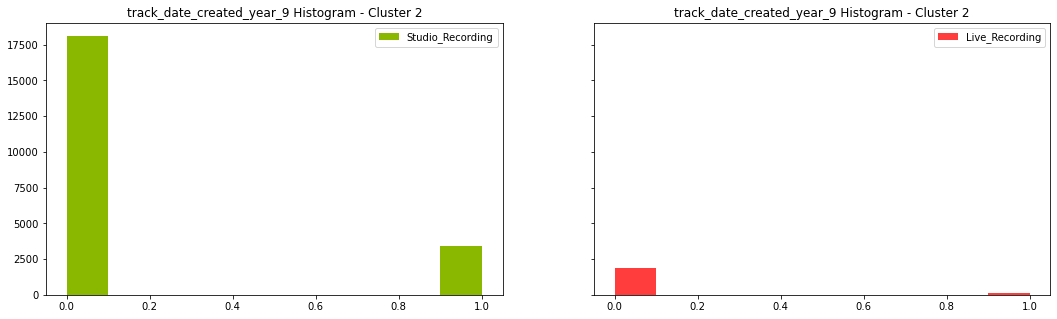

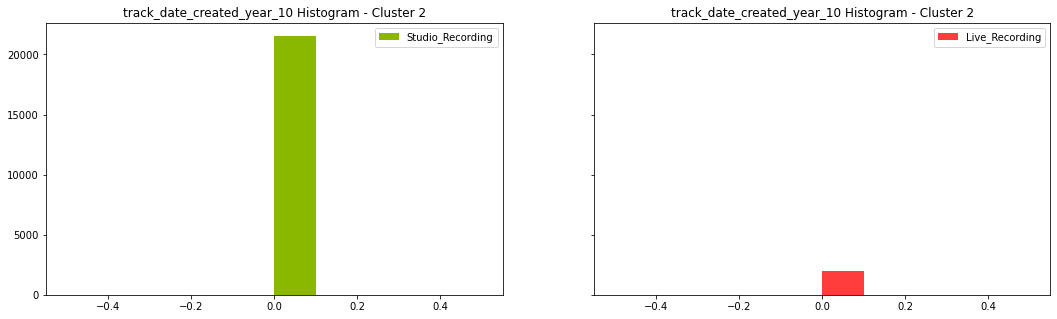

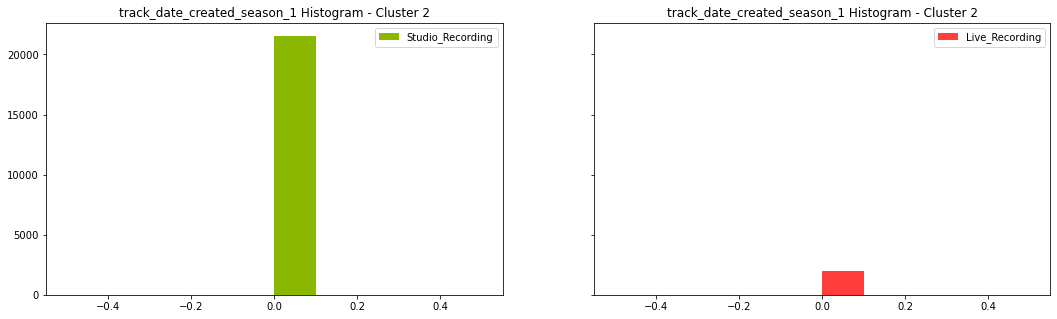

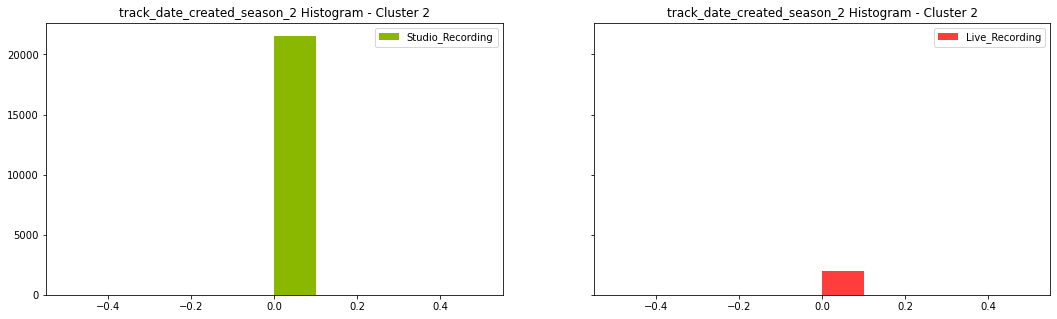

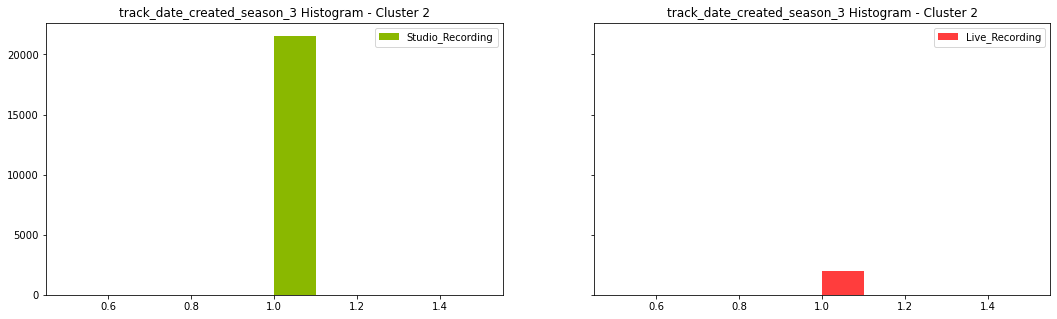

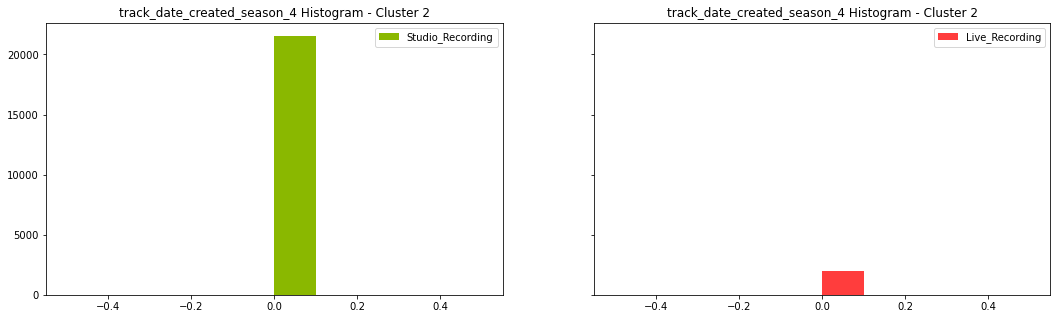

------------------------------------------------------------------------------------------------------------------
Cluster 3



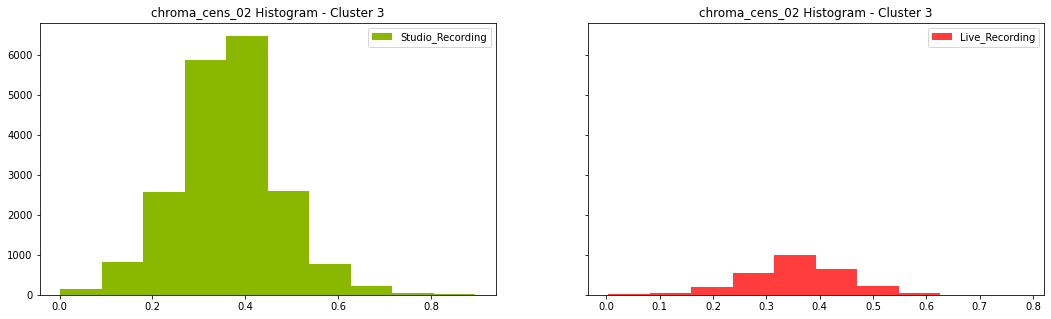

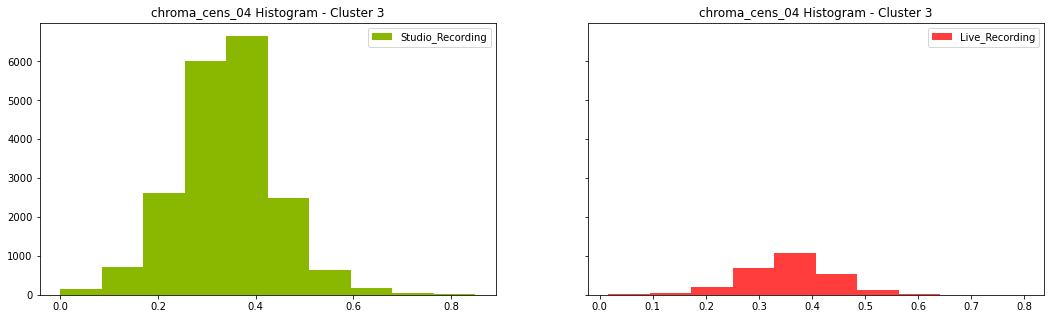

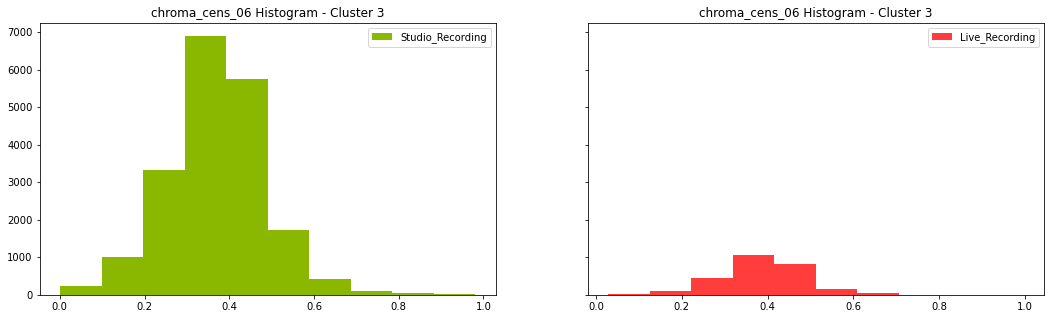

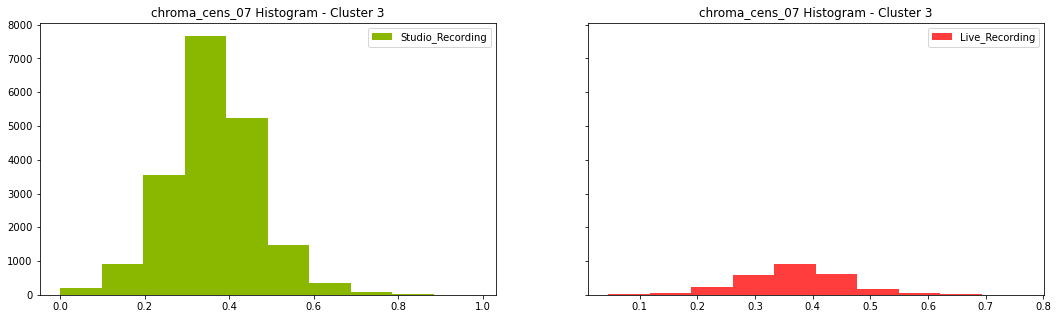

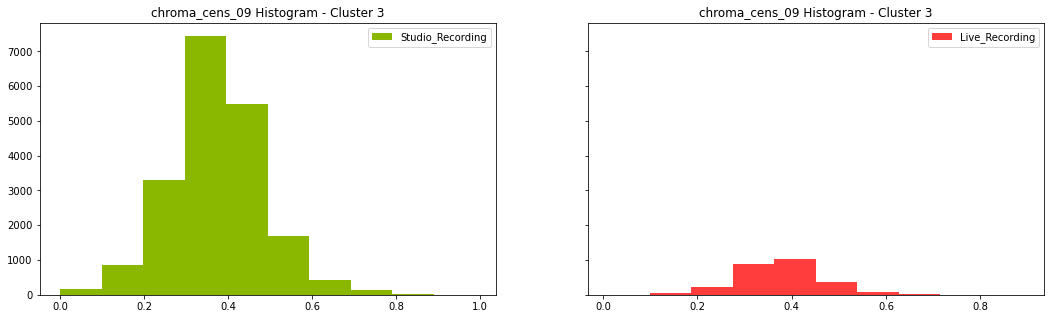

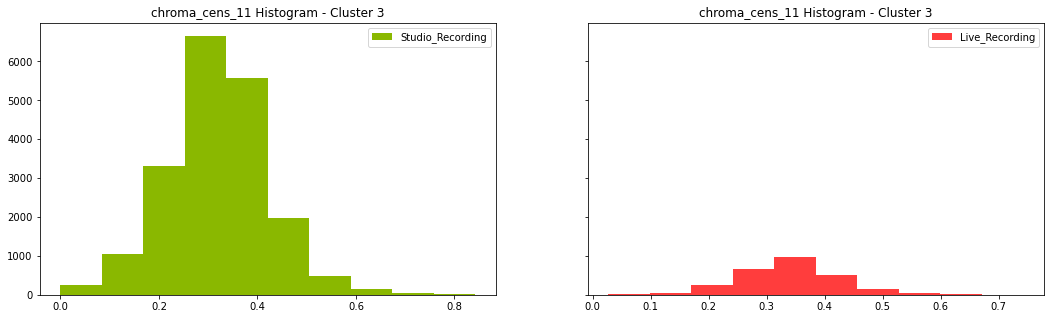

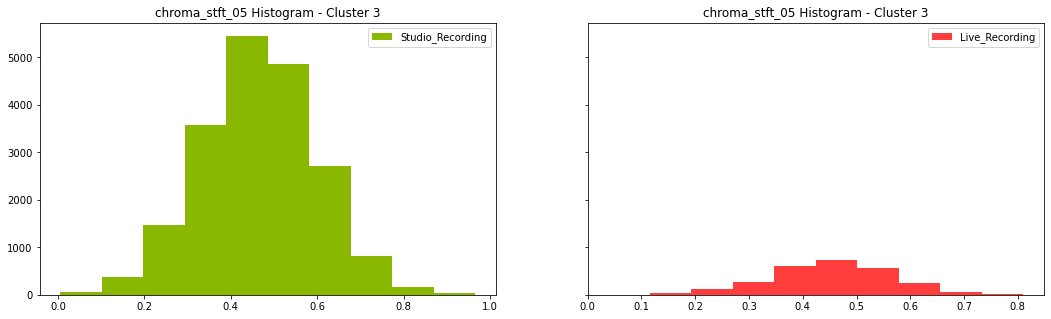

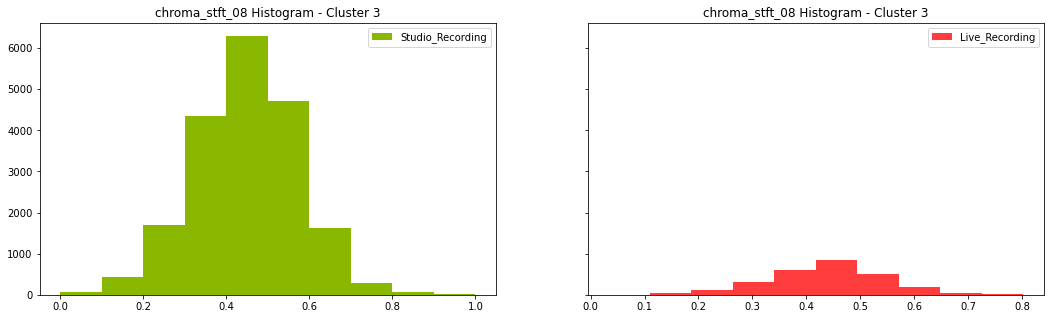

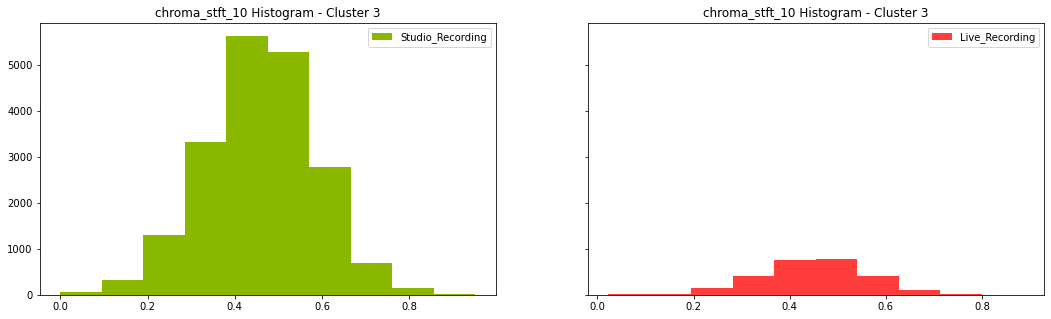

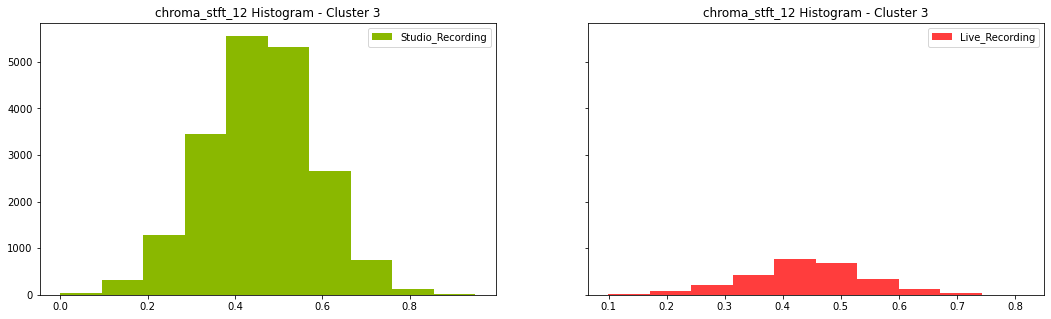

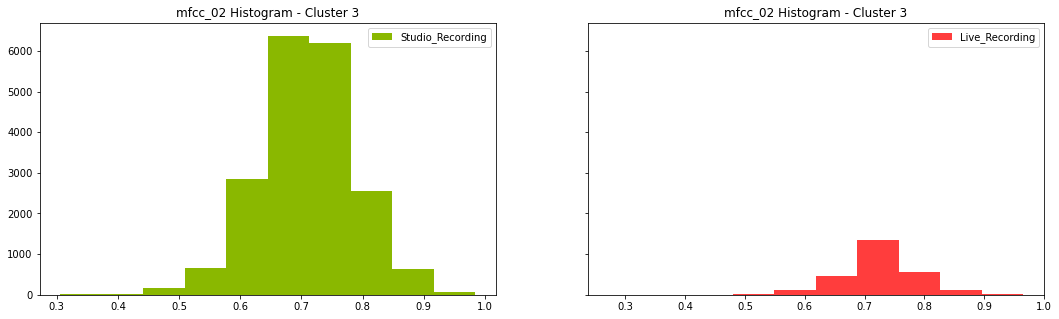

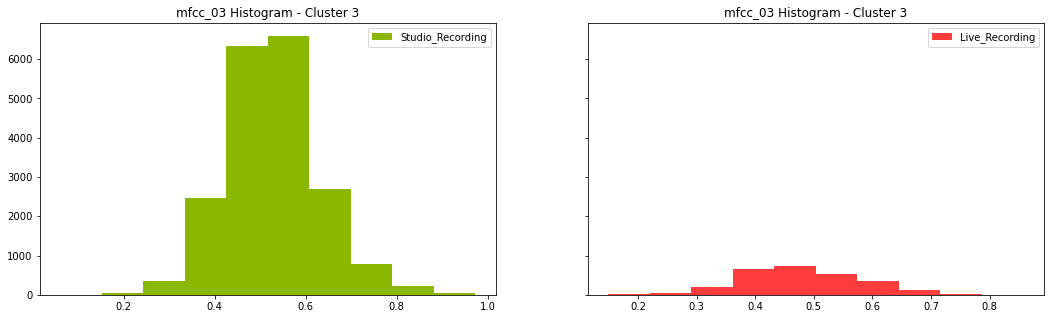

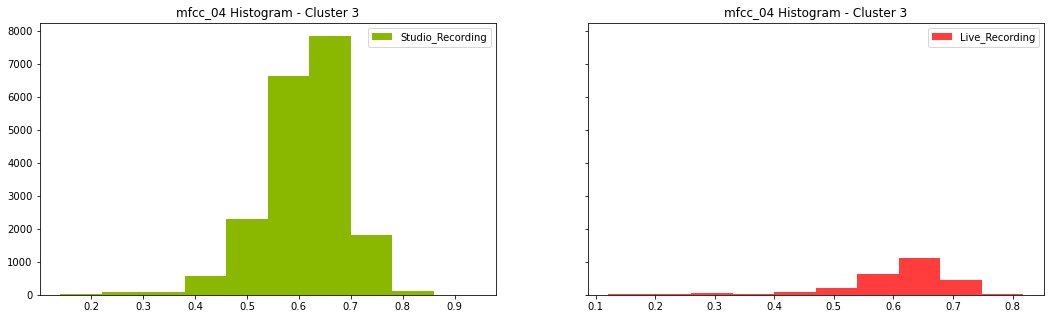

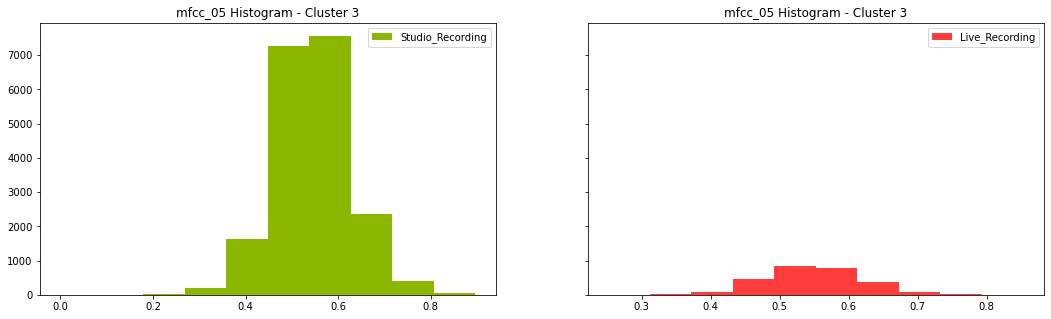

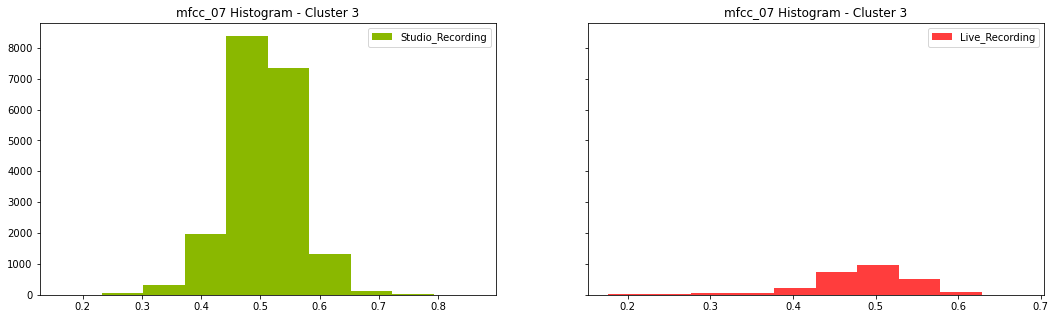

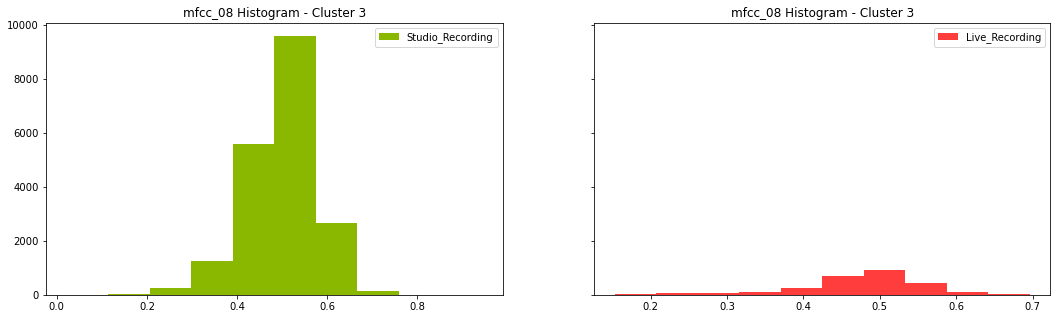

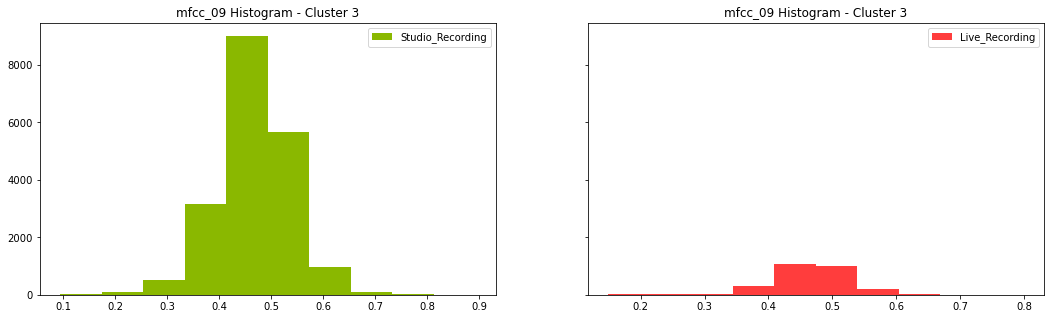

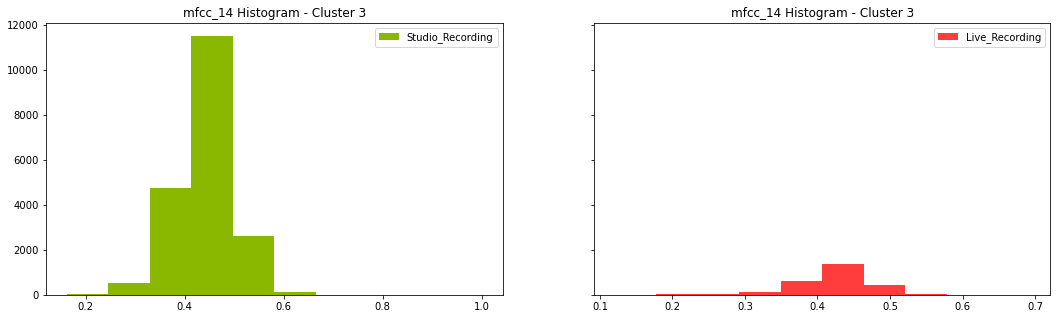

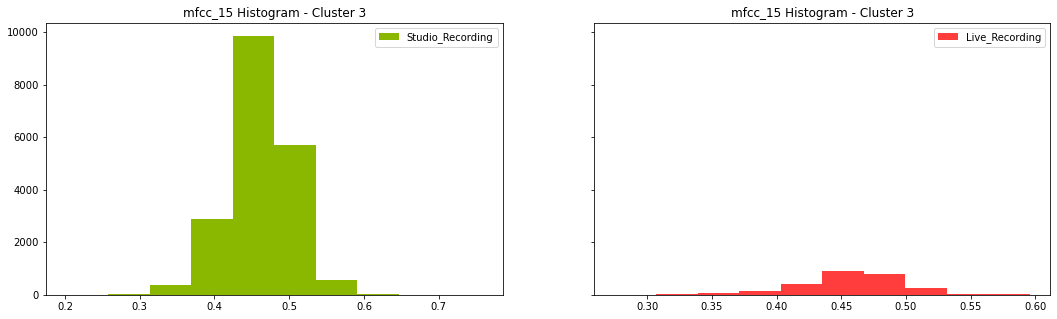

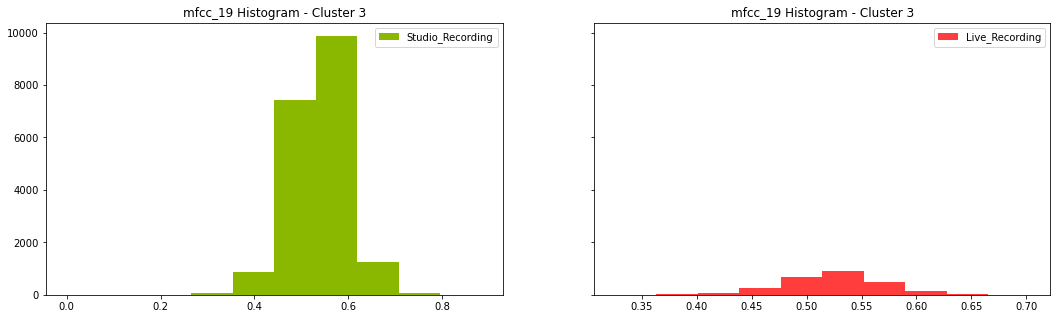

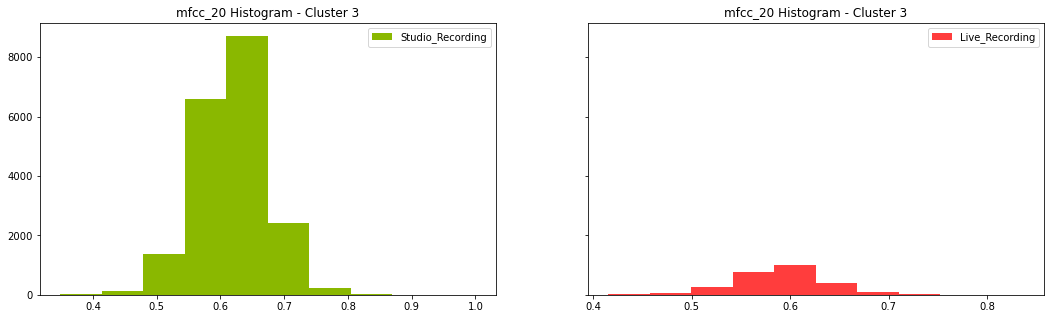

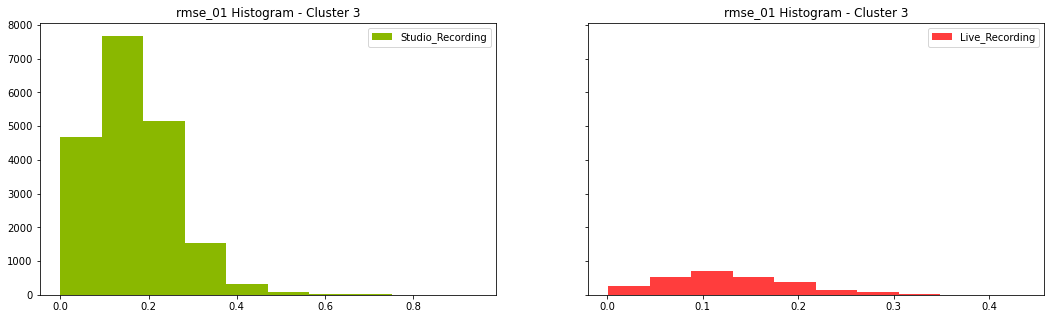

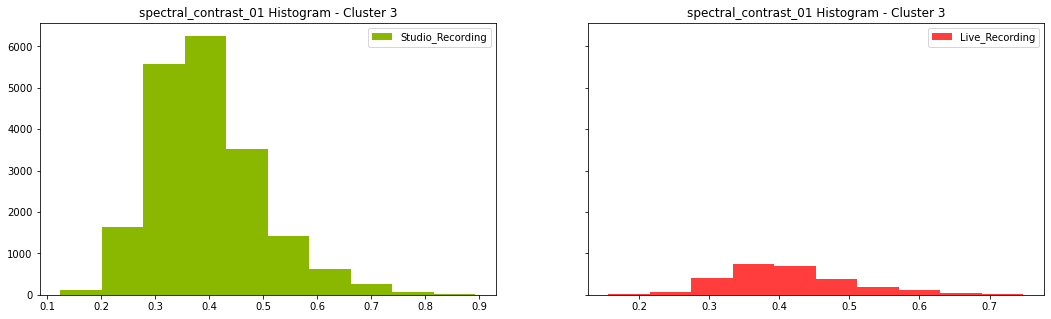

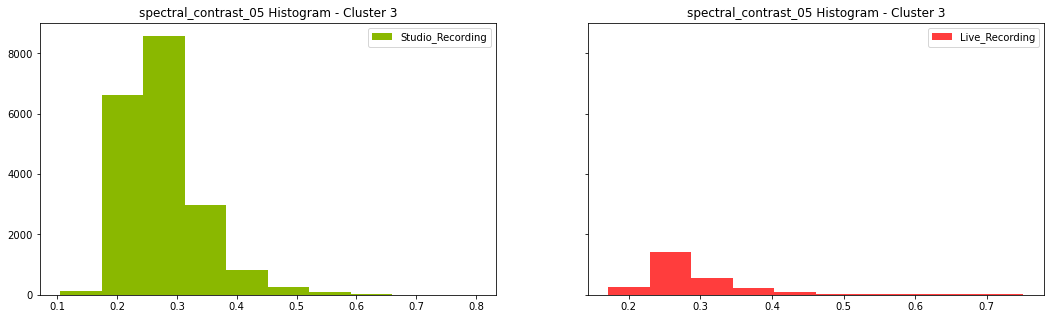

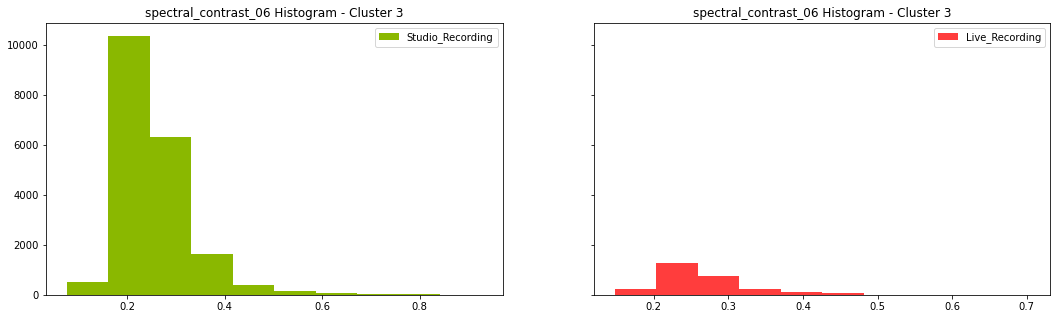

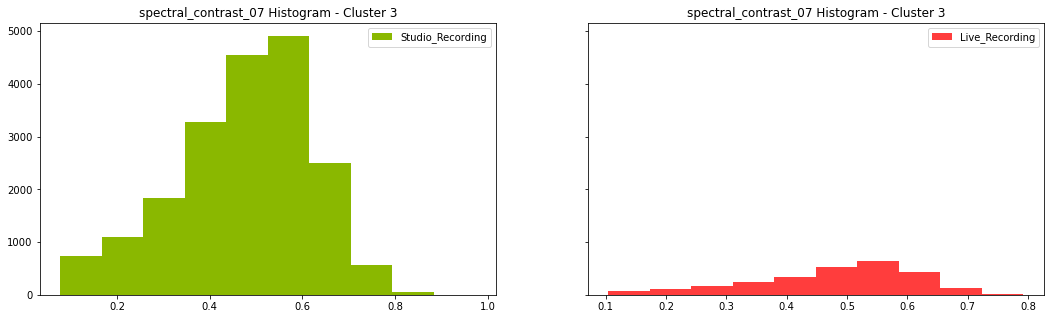

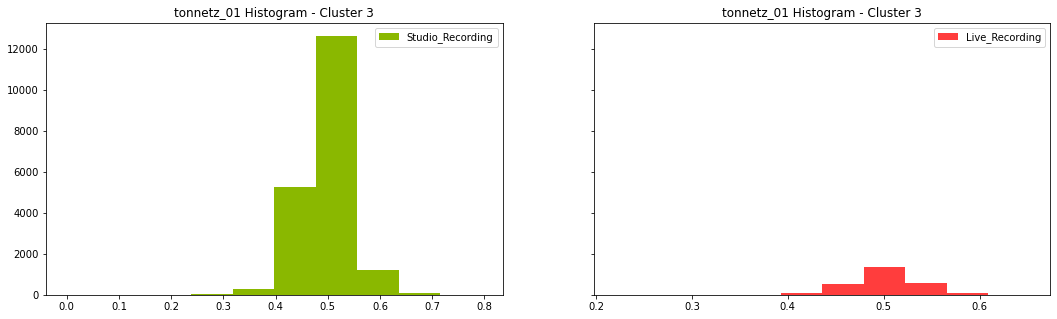

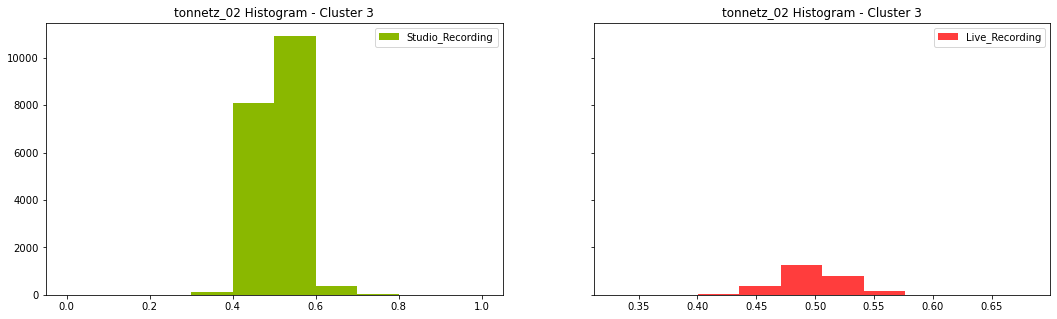

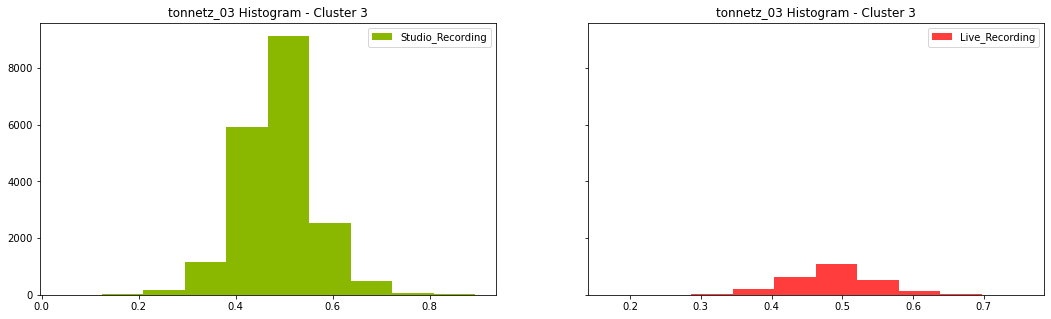

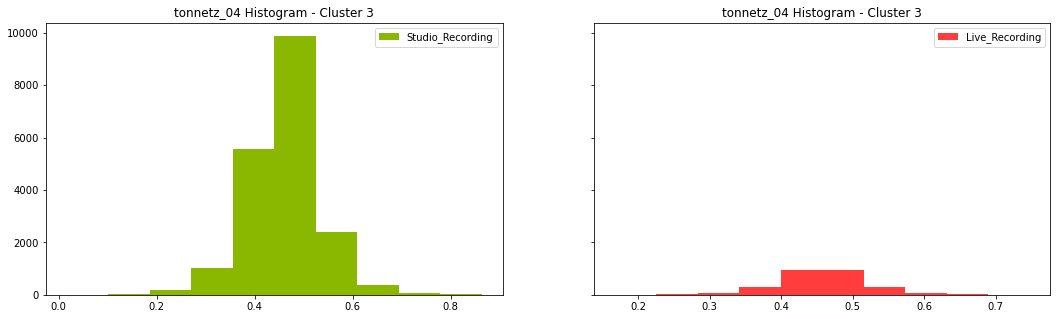

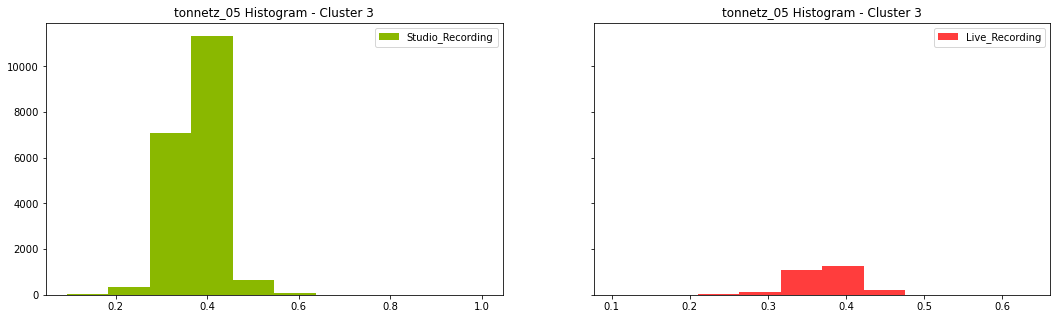

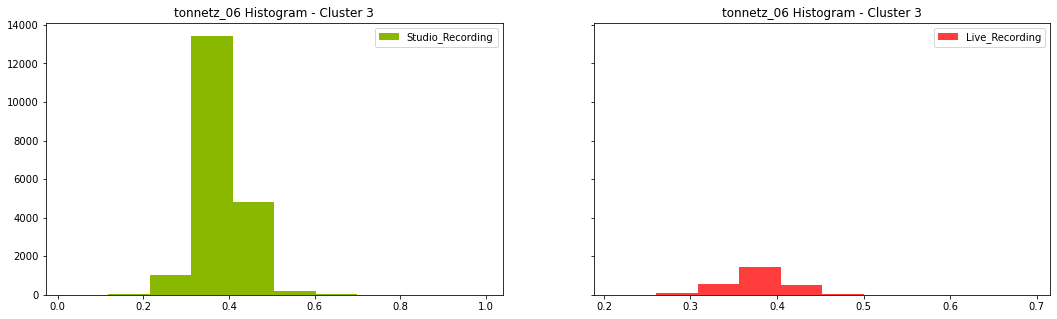

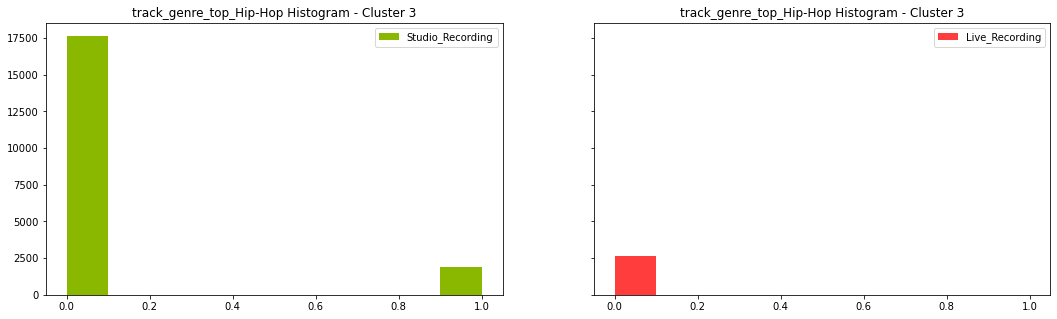

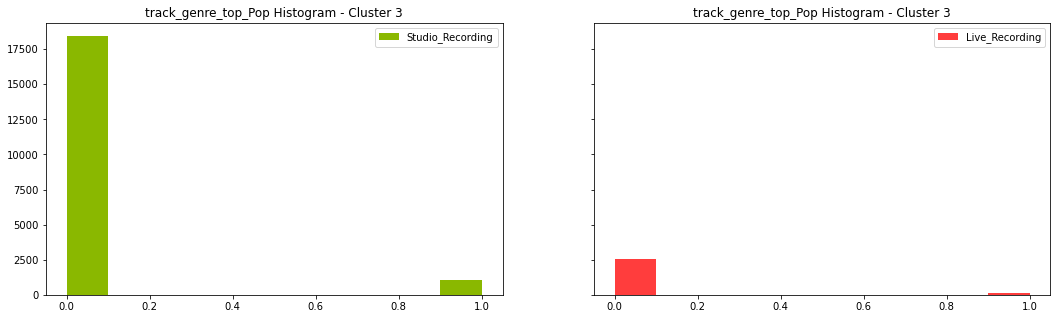

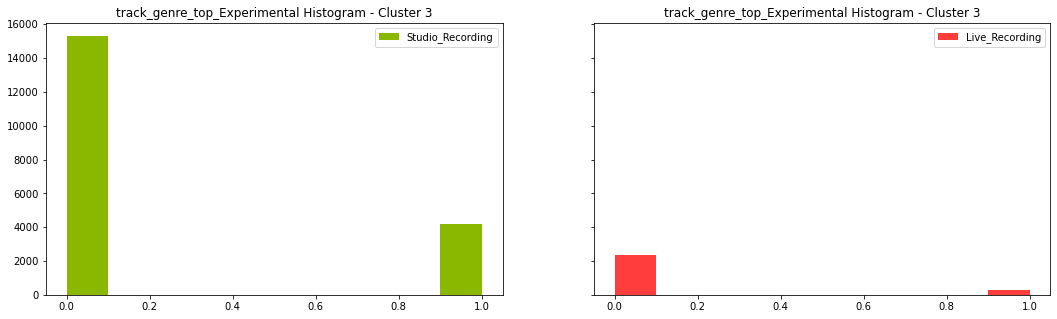

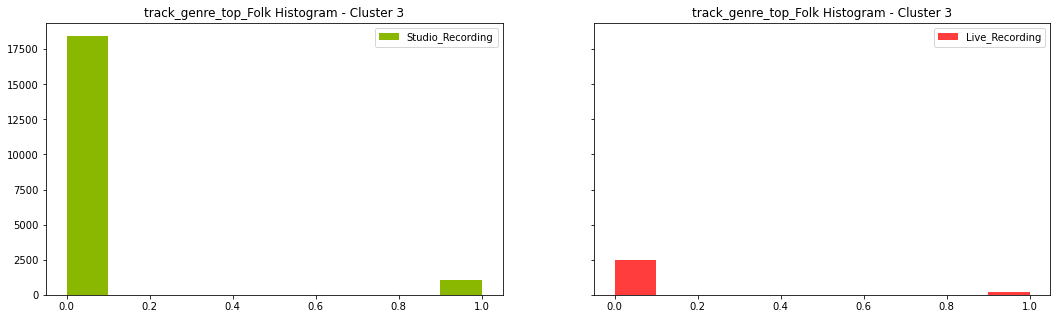

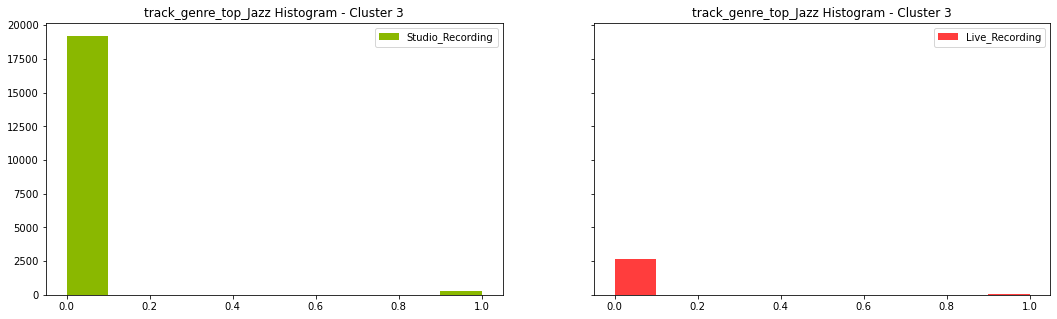

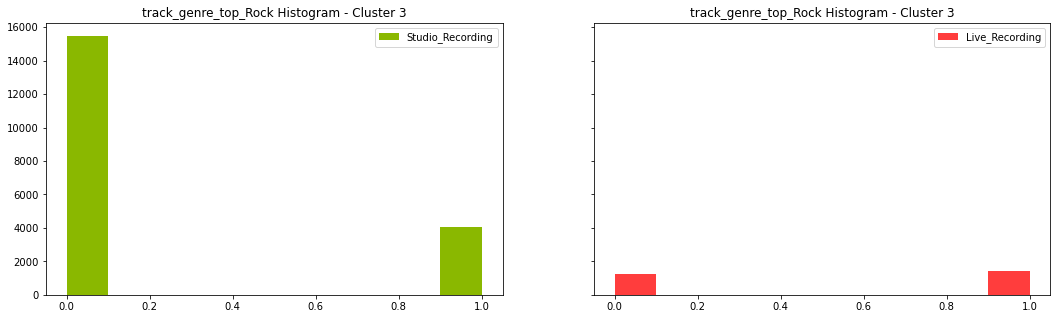

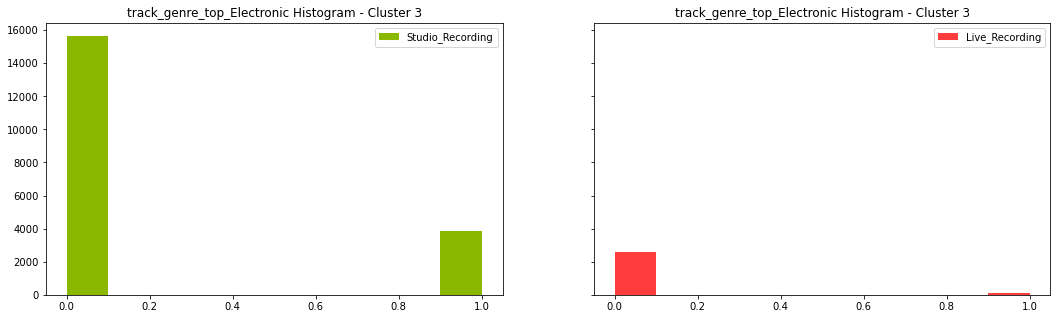

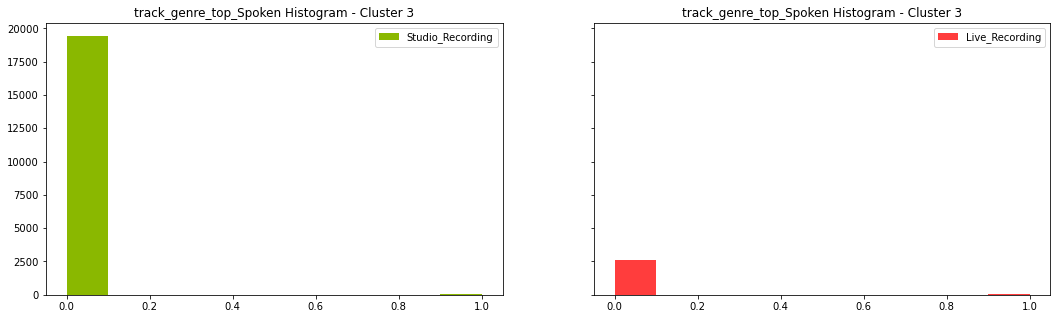

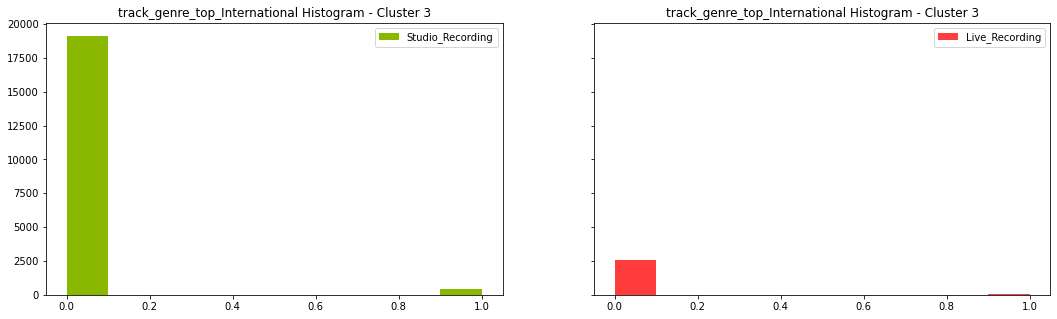

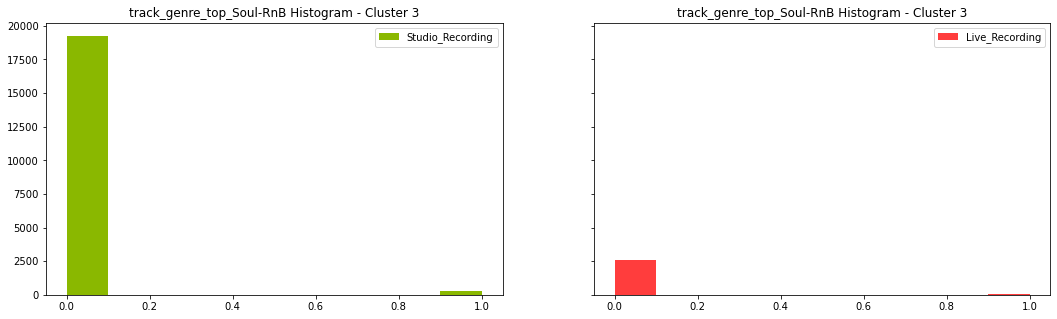

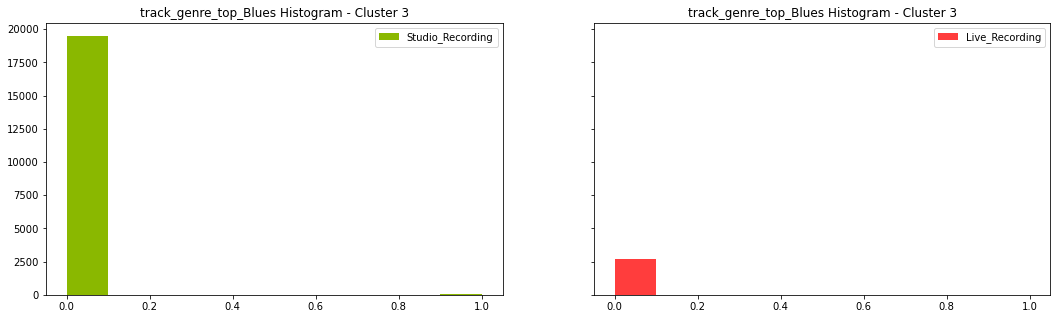

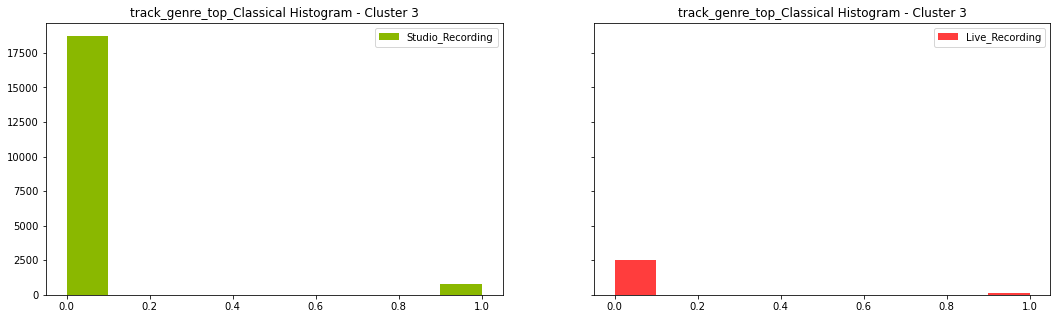

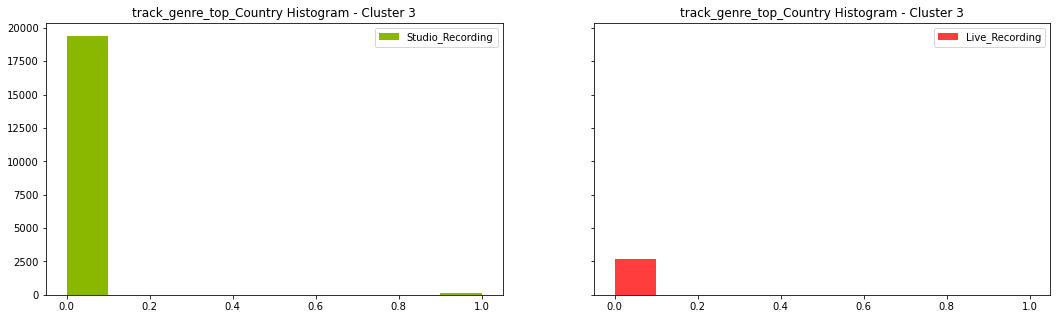

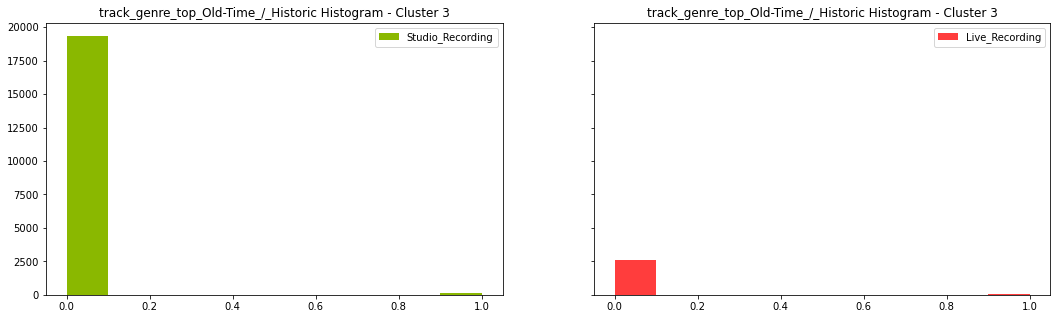

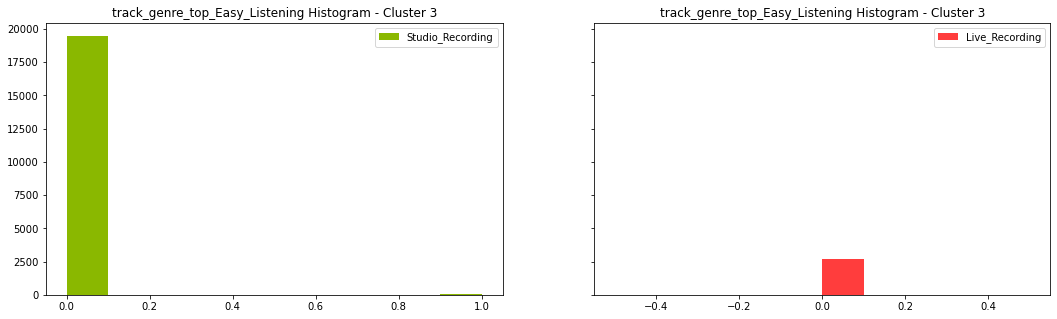

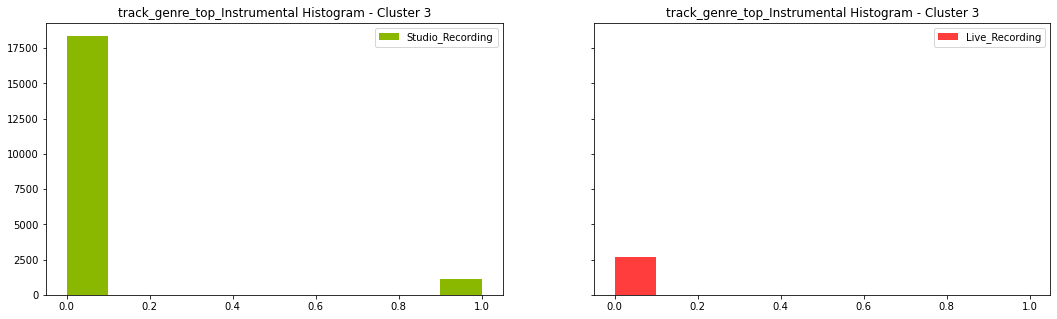

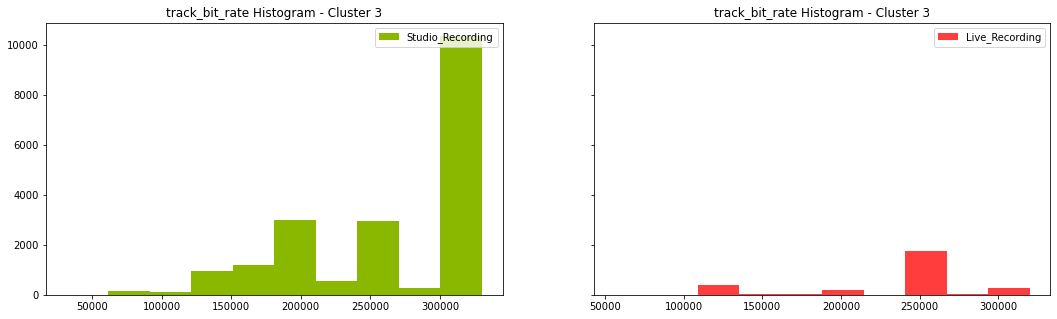

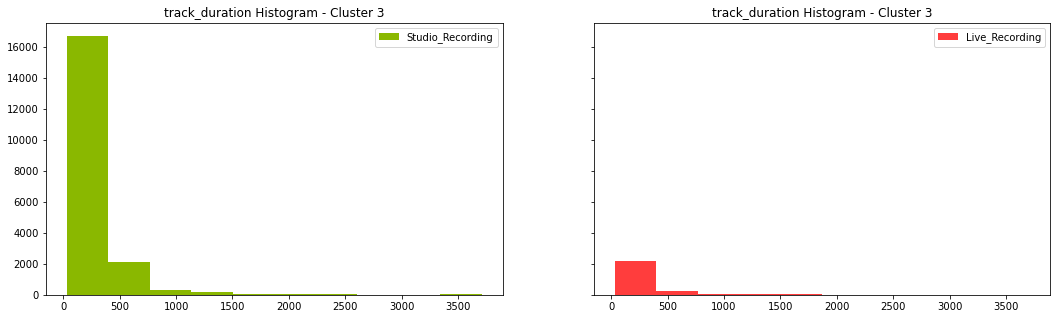

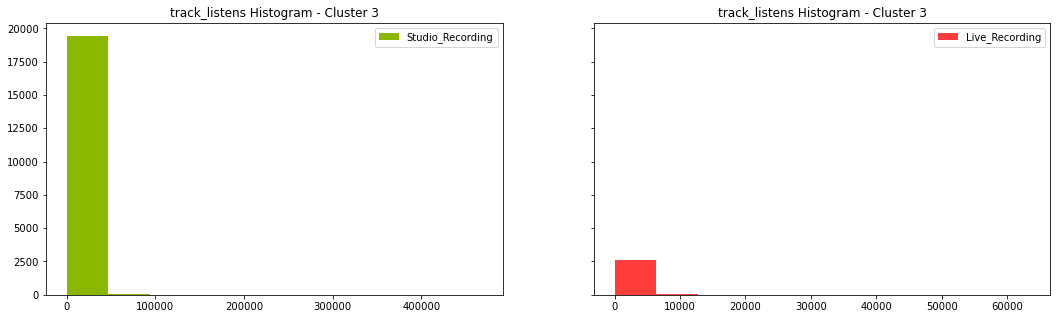

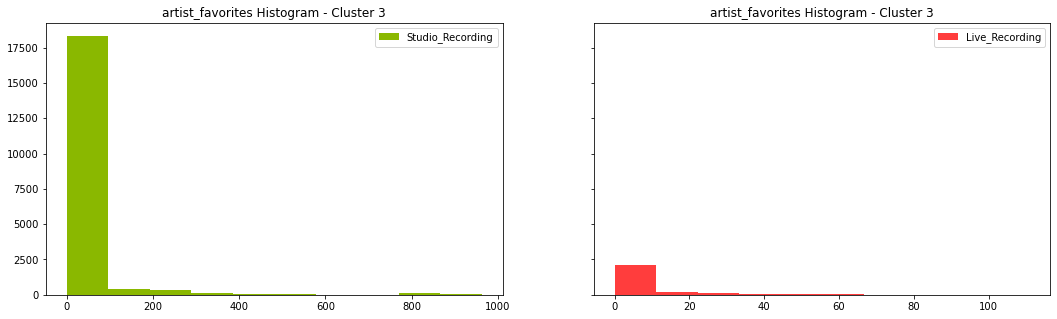

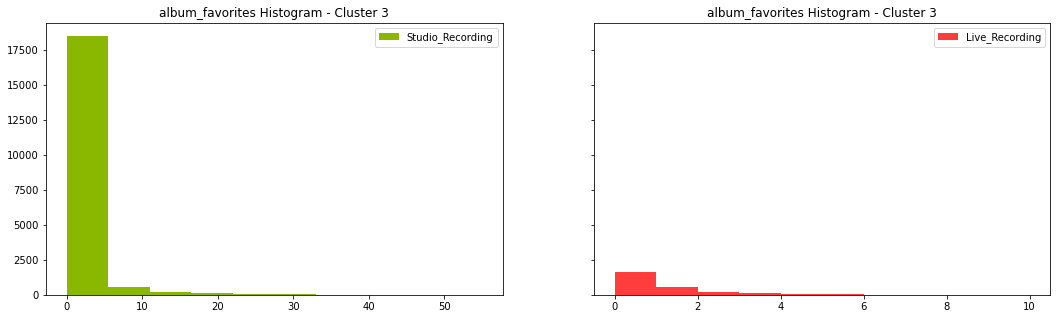

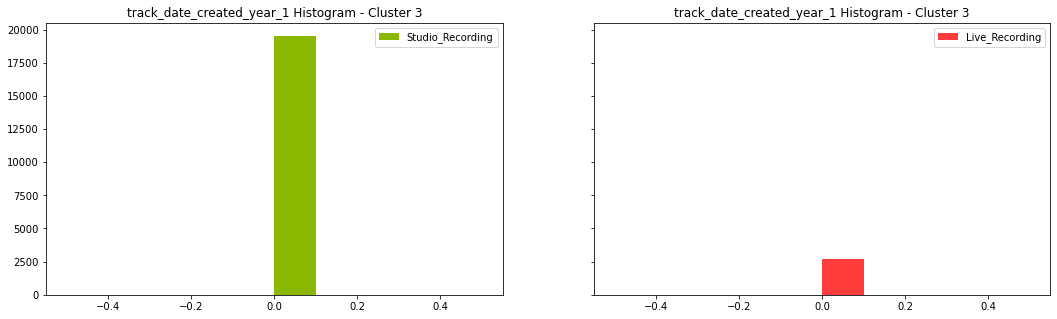

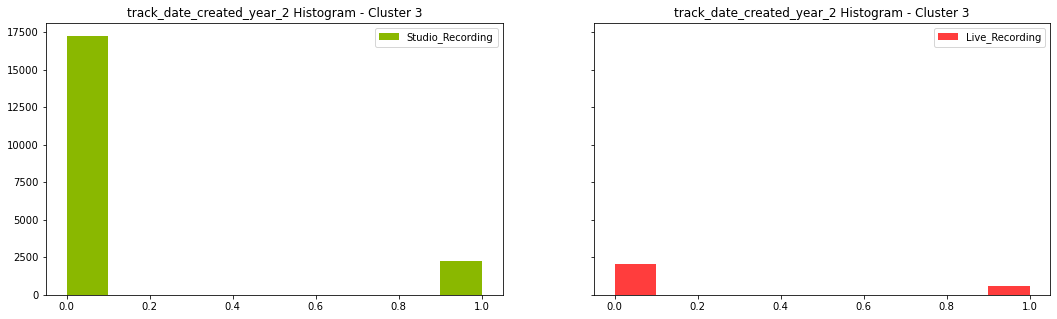

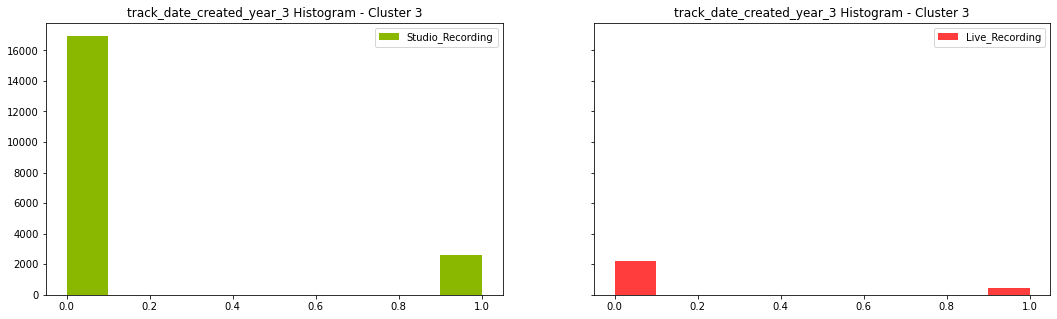

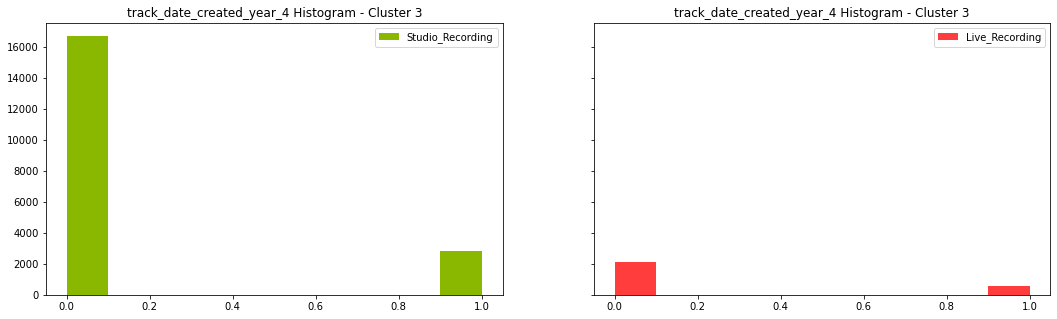

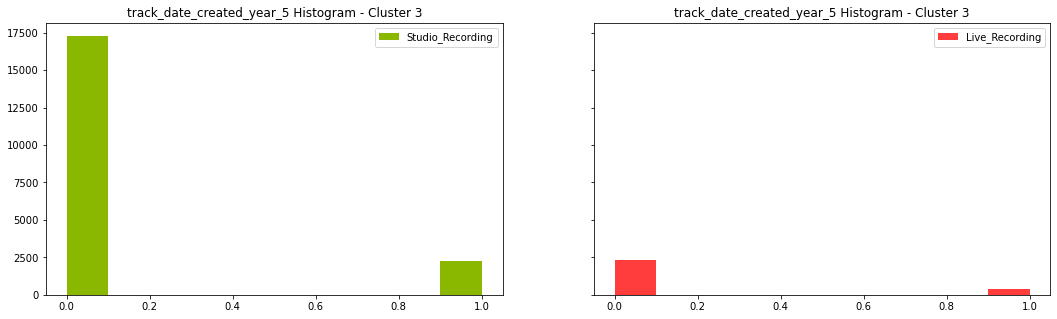

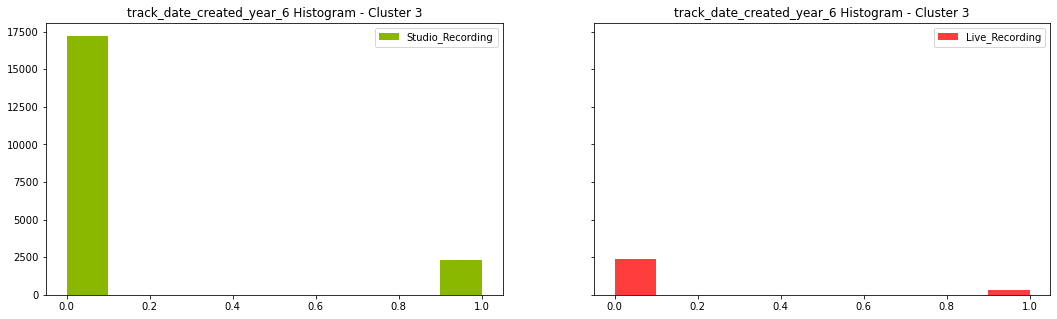

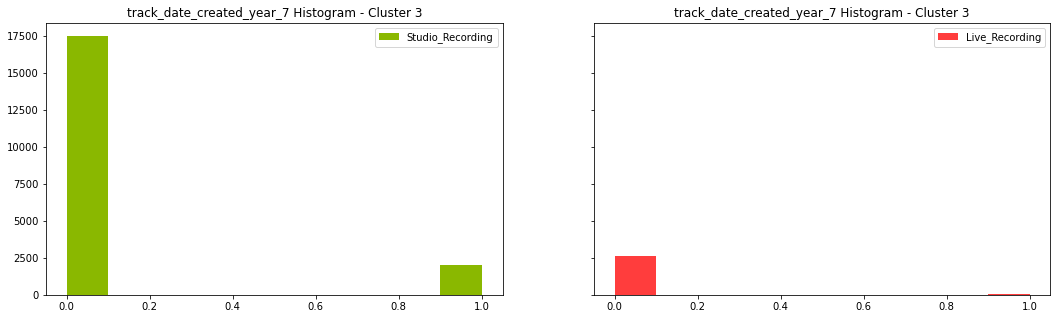

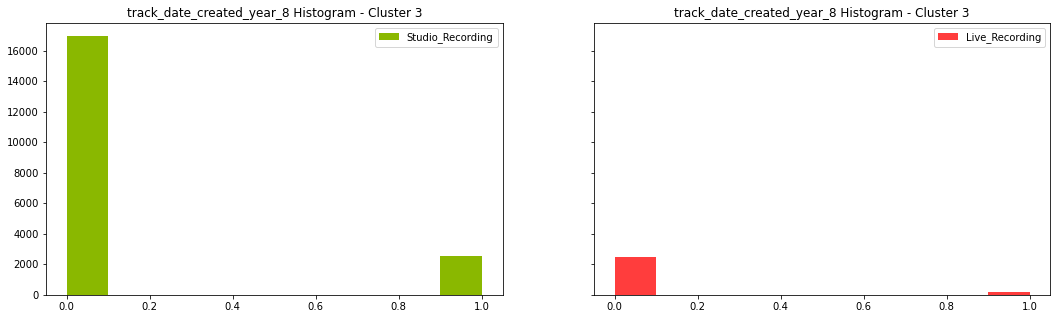

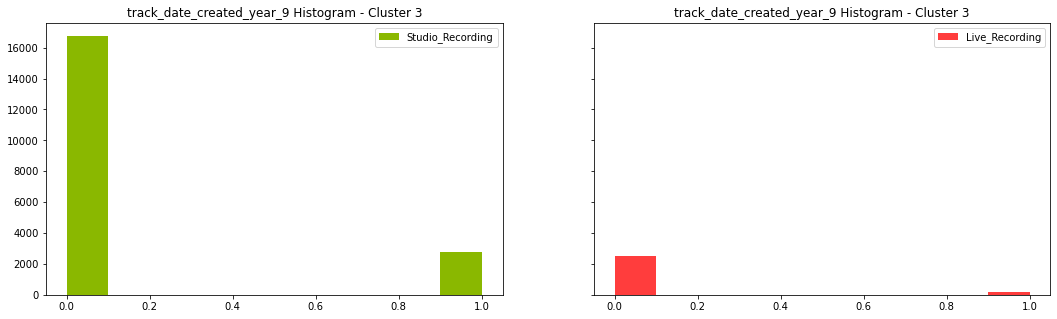

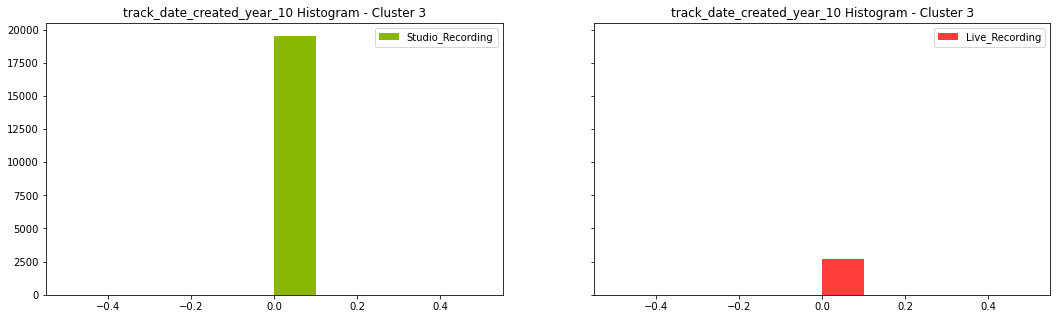

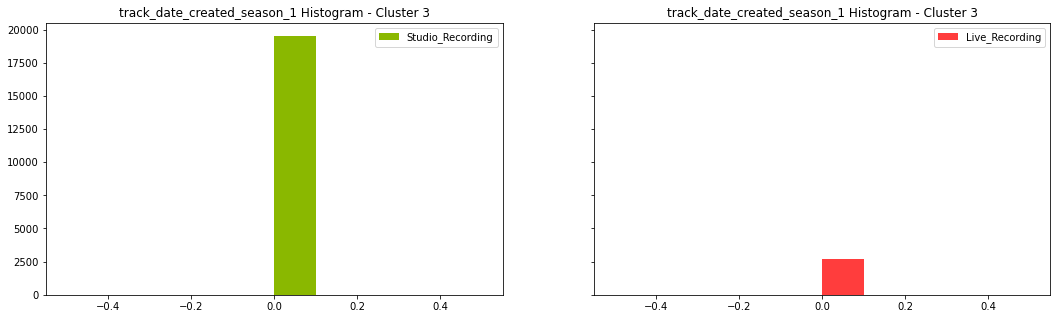

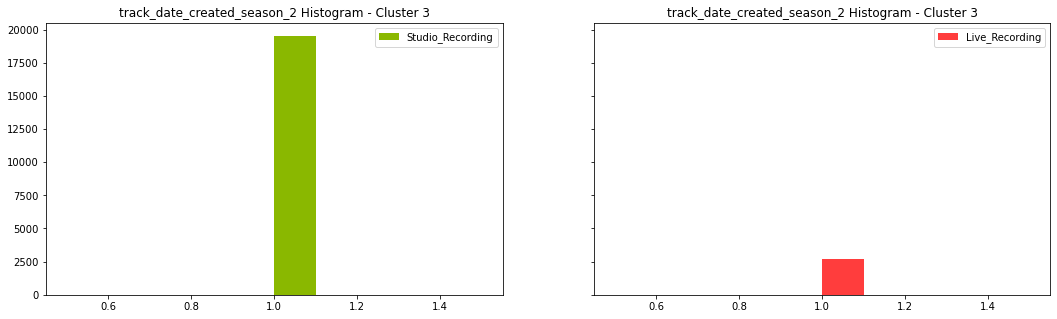

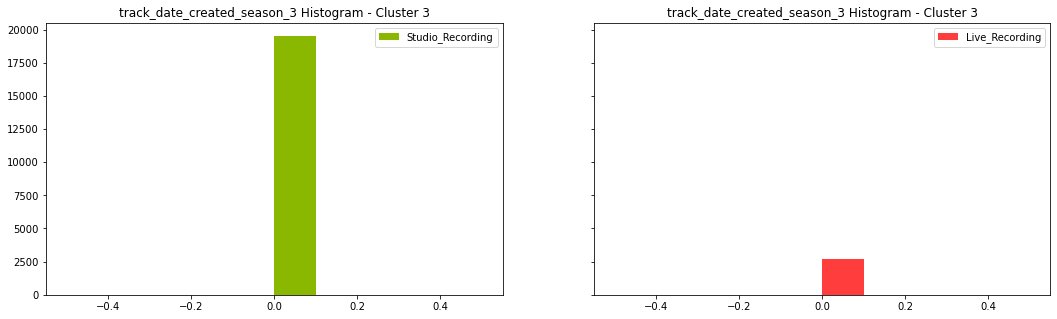

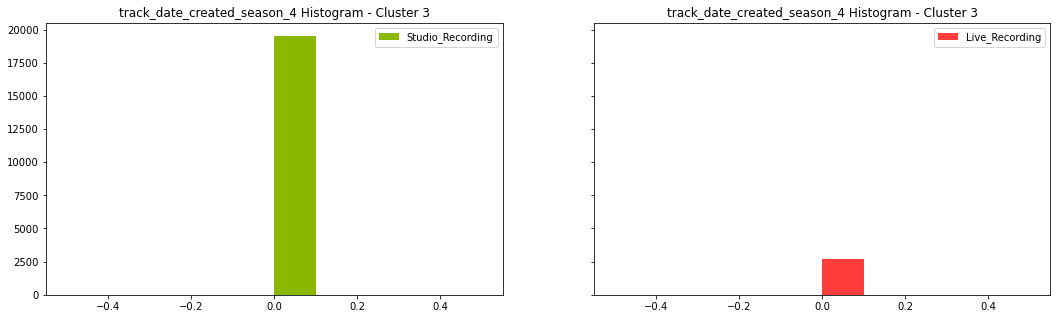

------------------------------------------------------------------------------------------------------------------


In [181]:
analyze_single_clusters(df_original_onehot)

In [231]:
df_generale.to_csv("kmodes_Cao.csv")

In [2]:
def prova_stagioni(df):
    
    for column in df[[col for col in df.columns if 'season' in col]]:

        print(column)
        print()

        #Studio_0_dataset = df[(df['Labels'] == label) & (df['album_type'] == 0)] #Studio_Recording

        #Live_1_dataset = df[(df['Labels'] == label) & (df['album_type'] == 1)]   #Live_Recording

        for column in df.columns:

            #if (column != 'Labels' and column != 'album_type'):

            fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 5), sharey = True)

            ax[0].hist(df[column], label = 'Studio_Recording', color = "#8AB800")
            ax[0].legend(loc='upper right')
            ax[0].set_title(column + " Histogram - Cluster {}".format(label))

            '''
            ax[1].hist(Live_1_dataset[column], label = 'Live_Recording', color = "#FF3D3D")
            ax[1].legend(loc='upper right')
            ax[1].set_title(column + " Histogram - Cluster {}".format(label))
            '''

            plt.show()